**Goal**

- Explore Olist (Brazilian e-commerce) datasets in order to propose clients segmentation(s).
- Generate features to proceed a customers segmentation. It must at least take into account two criterions:
    - the client's appetite for ordering ;
    - the client's satisfaction.
- Must respect PEP8.

**Data**

- can be found on [Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).
- downloaded and extracted in './csv_files'.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from glob import glob
import missingno as msno
import seaborn as sns
import project_tools as pt
import project_tools_v2 as pt2
import data_science_functions as ds

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# from scipy.cluster.hierarchy import dendrogram

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)


**Table of contents**<a id='toc0_'></a>    
- 1. [First glance at the datasets.](#toc1_)    
  - 1.1. [Loading](#toc1_1_)    
  - 1.2. [heads and infos](#toc1_2_)    
  - 1.3. [Summary](#toc1_3_)    
  - 1.4. [Dropping non-relevant columns and dataframes.](#toc1_4_)    
  - 1.5. [ dtypes](#toc1_5_)    
  - 1.6. [Answering some questions](#toc1_6_)    
    - 1.6.1. [Dates range in the dataset](#toc1_6_1_)    
    - 1.6.2. [What if a person orders multiple items.](#toc1_6_2_)    
    - 1.6.3. [Order status and null dates -- Is there any logic?](#toc1_6_3_)    
    - 1.6.4. [Not delivered orders and dates](#toc1_6_4_)    
    - 1.6.5. [Items with no category](#toc1_6_5_)    
- 2. [Merging the datasets step by step.](#toc2_)    
  - 2.1. [merging id's](#toc2_1_)    
  - 2.2. [Merged_df : customers <-- orders](#toc2_2_)    
  - 2.3. [Merged_df <-- order_items](#toc2_3_)    
  - 2.4. [ merged_df <-- order_payments](#toc2_4_)    
  - 2.5. [Checking wether the order total amount is equal to the payment made by the client.](#toc2_5_)    
    - 2.5.1. [Total order cost == 0](#toc2_5_1_)    
    - 2.5.2. [Order price not equal to payment value](#toc2_5_2_)    
    - 2.5.3. [Personal note](#toc2_5_3_)    
  - 2.6. [Merged_df <-- order_reviews](#toc2_6_)    
  - 2.7. [Merged_df <-- products](#toc2_7_)    
  - 2.8. [Larger product categories](#toc2_8_)    
  - 2.9. [Review score vs status](#toc2_9_)    
  - 2.10. [Addressing problems in the merged_df](#toc2_10_)    
    - 2.10.1. [Category problems](#toc2_10_1_)    
    - 2.10.2. [No item info problems](#toc2_10_2_)    
    - 2.10.3. [No review problems](#toc2_10_3_)    
    - 2.10.4. [payment type problems](#toc2_10_4_)    
- 3. [Features engineering](#toc3_)    
  - 3.1. [Design on 5 clients example](#toc3_1_)    
- 4. [Client features analysis](#toc4_)    
  - 4.1. [Distibutions and boxplots](#toc4_1_)    
  - 4.2. [Correlation matrix](#toc4_2_)    
  - 4.3. [PCA's](#toc4_3_)    
    - 4.3.1. [On almost all engineered features](#toc4_3_1_)    
    - 4.3.2. [On recency, frequency, and moneraty value](#toc4_3_2_)    
  - 4.4. [ Visualization in the RFM space](#toc4_4_)    
- 5. [Applying the RFM segmentation](#toc5_)    
  - 5.1. [Criterions used to create tier-groups](#toc5_1_)    
  - 5.2. [RFM 3 digits code](#toc5_2_)    
  - 5.3. [Joining into 9 client profiles.](#toc5_3_)    
  - 5.4. [Visualizing clusters](#toc5_4_)    
- 6. [More feature engineering on relevant clients](#toc6_)    
  - 6.1. [Selecting some clients from distinct segments.](#toc6_1_)    
  - 6.2. [test on example df to build some functions](#toc6_2_)    
  - 6.3. [Testing on more](#toc6_3_)    
  - 6.4. [Orders summary on the full dataset](#toc6_4_)    
  - 6.5. [Testing functions on example to build the client summary](#toc6_5_)    
  - 6.6. [Full routine on the sample df a](#toc6_6_)    
  - 6.7. [Compute clients features on the full dataset](#toc6_7_)    
  - 6.8. [ Clients post-processing / defining dynamic ratios and payment ratios](#toc6_8_)    
- 7. [Refactoring functions for features engineering  (second cleaner version).](#toc7_)    
  - 7.1. [Checking new version of functions](#toc7_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>First glance at the datasets.

## 1.1.  [&#9650;](#toc0_) <a id='toc1_1_'></a>Loading

In [22]:
glob("./csv_files/*")


['./csv_files/olist_order_reviews_dataset.csv',
 './csv_files/olist_order_items_dataset.csv',
 './csv_files/olist_sellers_dataset.csv',
 './csv_files/olist_geolocation_dataset.csv',
 './csv_files/olist_orders_dataset.csv',
 './csv_files/olist_products_dataset.csv',
 './csv_files/olist_order_payments_dataset.csv',
 './csv_files/olist_customers_dataset.csv',
 './csv_files/product_category_name_translation.csv']

In [23]:
df_names = []
for fn in glob("./csv_files/*"):
    df_names.append(fn.removeprefix('./csv_files/')
                    .removesuffix('_dataset.csv'))
df_names


['olist_order_reviews',
 'olist_order_items',
 'olist_sellers',
 'olist_geolocation',
 'olist_orders',
 'olist_products',
 'olist_order_payments',
 'olist_customers',
 'product_category_name_translation.csv']

In [24]:
for n, name in enumerate(df_names):
    df_names[n] = name.removeprefix("olist_").removesuffix(".csv")
df_names


['order_reviews',
 'order_items',
 'sellers',
 'geolocation',
 'orders',
 'products',
 'order_payments',
 'customers',
 'product_category_name_translation']

In [25]:
for name, fn in zip(df_names, glob("./csv_files/*")):
    exec(name + " = pd.read_csv('" + fn + "')")


## 1.2.  [&#9650;](#toc0_) <a id='toc1_2_'></a>heads and infos

In [26]:
for name in df_names:
    print('-' * 30 + "\n" + name)
    df = eval(name)
    display(df.head())
    df.info()
    

------------------------------
order_reviews


review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                                                                                 review_comment_message  \
0                                                                                                   NaN   
1                                                                                                   NaN   
2                                                                                                   NaN   
3                                                                 Recebi bem antes do prazo estipulado.   
4  Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa   

  review_creation_date review_answer_timestamp  
0  2018-01-18 00:00:00     2018-01-18 21:46:59  
1  2018-03-10 00:00:00     2018-03-11 03:05:13  
2  2018-02-17 00:00:00     2018-02-18 14:36:24  
3  2017-04-21 00:00:00     2017-04-21 22:02:06  
4  2018-03-01 00:00:00     2018-03-02 10:26:53

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
------------------------------
order_items


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
------------------------------
sellers


seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
------------------------------
geolocation


geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
------------------------------
orders


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
------------------------------
products


product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
------------------------------
order_payments


order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
------------------------------
customers


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
------------------------------
product_category_name_translation


product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


## 1.3.  [&#9650;](#toc0_) <a id='toc1_3_'></a>Summary

In [27]:
def make_datasets(df_names):
    return {df_name: eval(df_name) for df_name in df_names}


In [28]:
datasets = make_datasets(df_names)


In [29]:
pt.display_summary(datasets)


- 'sellers' and 'geolocation' are not straightforward relevant.
- from 'products', only the product category name seems relevant to define the client's tastes.
- 'orders' and 'orders_review' will be interesting to understand the client's satisfaction.
- 'order_payments' will help in quantifying the quality of the client (heavy buyer, punctual...)

***
I will drop some columns

***

dates must be cast.

## 1.4.  [&#9650;](#toc0_) <a id='toc1_4_'></a>Dropping non-relevant columns and dataframes.

In [30]:
reviews_relevant_cols = ['review_id', 'order_id', 'review_score']
products_relevant_cols = ['product_id', 'product_category_name']

order_reviews = order_reviews[reviews_relevant_cols]
products = products[products_relevant_cols]


In [31]:
df_names.remove('sellers')
df_names.remove('geolocation')
df_names


['order_reviews',
 'order_items',
 'orders',
 'products',
 'order_payments',
 'customers',
 'product_category_name_translation']

In [32]:
datasets = make_datasets(df_names)
pt.display_summary(datasets)


## 1.5.  [&#9650;](#toc0_) <a id='toc1_5_'></a> dtypes

In [33]:
# Cast to datetime
orders_date_columns = ['order_purchase_timestamp',
                       'order_approved_at',
                       'order_delivered_carrier_date',
                       'order_delivered_customer_date',
                       'order_estimated_delivery_date']

for col in orders_date_columns:
    orders.loc[:, col] = pd.to_datetime(orders[col])
    
# Cast to categories and int
cat_cols = ['seller_id',
            'order_status',
            'product_category_name',
            'customer_state',
            'customer_city',
            'product_category_name_english',]

datasets = make_datasets(df_names)
for data in datasets.values():
    for col in data.columns:
        if col in cat_cols:
            data.loc[:, col] = data[col].astype('category')
            

/tmp/ipykernel_3688/1340599933.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  orders.loc[:, col] = pd.to_datetime(orders[col])
/tmp/ipykernel_3688/1340599933.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  orders.loc[:, col] = pd.to_datetime(orders[col])
/tmp/ipykernel_3688/1340599933.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i,

In [34]:
for name in datasets.keys():
    print('-' * 30 + "\n" + name)
    df = eval(name)
    df.info()


------------------------------
order_reviews
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_id     99224 non-null  object
 1   order_id      99224 non-null  object
 2   review_score  99224 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB
------------------------------
order_items
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   order_id             112650 non-null  object  
 1   order_item_id        112650 non-null  int64   
 2   product_id           112650 non-null  object  
 3   seller_id            112650 non-null  category
 4   shipping_limit_date  112650 non-null  object  
 5   price                112650 non-null  float64 
 6   freight_value

We see that there are no nulls except for some dates in the 'orders' and some categories in 'products' dataframes. I discuss that in the following section.

In [35]:
order_items["order_item_id"] = order_items["order_item_id"].astype('int32')


## 1.6.  [&#9650;](#toc0_) <a id='toc1_6_'></a>Answering some questions

### 1.6.1.  [&#9650;](#toc0_) <a id='toc1_6_1_'></a>Dates range in the dataset

In [36]:
orders.order_purchase_timestamp.min()


Timestamp('2016-09-04 21:15:19')

In [37]:
orders.order_purchase_timestamp.max()


Timestamp('2018-10-17 17:30:18')

Roughly 2 years and 1 month data.

### 1.6.2.  [&#9650;](#toc0_) <a id='toc1_6_2_'></a>What if a person orders multiple items.

In [38]:
largest_order_id = (order_items.order_id.value_counts()
                    .sort_values(ascending=False)
                    .index[0])
order_items.query('order_id == @largest_order_id')


order_id  order_item_id  \
57297  8272b63d03f5f79c56e9e4120aec44ef              1   
57298  8272b63d03f5f79c56e9e4120aec44ef              2   
57299  8272b63d03f5f79c56e9e4120aec44ef              3   
57300  8272b63d03f5f79c56e9e4120aec44ef              4   
57301  8272b63d03f5f79c56e9e4120aec44ef              5   
57302  8272b63d03f5f79c56e9e4120aec44ef              6   
57303  8272b63d03f5f79c56e9e4120aec44ef              7   
57304  8272b63d03f5f79c56e9e4120aec44ef              8   
57305  8272b63d03f5f79c56e9e4120aec44ef              9   
57306  8272b63d03f5f79c56e9e4120aec44ef             10   
57307  8272b63d03f5f79c56e9e4120aec44ef             11   
57308  8272b63d03f5f79c56e9e4120aec44ef             12   
57309  8272b63d03f5f79c56e9e4120aec44ef             13   
57310  8272b63d03f5f79c56e9e4120aec44ef             14   
57311  8272b63d03f5f79c56e9e4120aec44ef             15   
57312  8272b63d03f5f79c56e9e4120aec44ef             16   
57313  8272b63d03f5f79c56e9e4120aec44ef             17   
57314  8272b63d03f5f79c56e9e4120aec44ef             18   
57315  8272b63d03f5f79c56e9e4120aec44ef             19   
57316  8272b63d03f5f79c56e9e4120aec44ef             20   
57317  8272b63d03f5f79c56e9e4120aec44ef             21   

                             product_id                         seller_id  \
57297  270516a3f41dc035aa87d220228f844c  2709af9587499e95e803a6498a5a56e9   
57298  05b515fdc76e888aada3c6d66c201dff  2709af9587499e95e803a6498a5a56e9   
57299  05b515fdc76e888aada3c6d66c201dff  2709af9587499e95e803a6498a5a56e9   
57300  05b515fdc76e888aada3c6d66c201dff  2709af9587499e95e803a6498a5a56e9   
57301  05b515fdc76e888aada3c6d66c201dff  2709af9587499e95e803a6498a5a56e9   
57302  05b515fdc76e888aada3c6d66c201dff  2709af9587499e95e803a6498a5a56e9   
57303  05b515fdc76e888aada3c6d66c201dff  2709af9587499e95e803a6498a5a56e9   
57304  05b515fdc76e888aada3c6d66c201dff  2709af9587499e95e803a6498a5a56e9   
57305  05b515fdc76e888aada3c6d66c201dff  2709af9587499e95e803a6498a5a56e9   
57306  05b515fdc76e888aada3c6d66c201dff  2709af9587499e95e803a6498a5a56e9   
57307  05b515fdc76e888aada3c6d66c201dff  2709af9587499e95e803a6498a5a56e9   
57308  270516a3f41dc035aa87d220228f844c  2709af9587499e95e803a6498a5a56e9   
57309  270516a3f41dc035aa87d220228f844c  2709af9587499e95e803a6498a5a56e9   
57310  270516a3f41dc035aa87d220228f844c  2709af9587499e95e803a6498a5a56e9   
57311  270516a3f41dc035aa87d220228f844c  2709af9587499e95e803a6498a5a56e9   
57312  270516a3f41dc035aa87d220228f844c  2709af9587499e95e803a6498a5a56e9   
57313  270516a3f41dc035aa87d220228f844c  2709af9587499e95e803a6498a5a56e9   
57314  270516a3f41dc035aa87d220228f844c  2709af9587499e95e803a6498a5a56e9   
57315  270516a3f41dc035aa87d220228f844c  2709af9587499e95e803a6498a5a56e9   
57316  270516a3f41dc035aa87d220228f844c  2709af9587499e95e803a6498a5a56e9   
57317  79ce45dbc2ea29b22b5a261bbb7b7ee7  2709af9587499e95e803a6498a5a56e9   

       shipping_limit_date  price  freight_value  
57297  2017-07-21 18:25:23    1.2           7.89  
57298  2017-07-21 18:25:23    1.2           7.89  
57299  2017-07-21 18:25:23    1.2           7.89  
57300  2017-07-21 18:25:23    1.2           7.89  
57301  2017-07-21 18:25:23    1.2           7.89  
57302  2017-07-21 18:25:23    1.2           7.89  
57303  2017-07-21 18:25:23    1.2           7.89  
57304  2017-07-21 18:25:23    1.2           7.89  
57305  2017-07-21 18:25:23    1.2           7.89  
57306  2017-07-21 18:25:23    1.2           7.89  
57307  2017-07-21 18:25:23    1.2           7.89  
57308  2017-07-21 18:25:23    1.2           7.89  
57309  2017-07-21 18:25:23    1.2           7.89  
57310  2017-07-21 18:25:23    1.2           7.89  
57311  2017-07-21 18:25:23    1.2           7.89  
57312  2017-07-21 18:25:23    1.2           7.89  
57313  2017-07-21 18:25:23    1.2           7.89  
57314  2017-07-21 18:25:23    1.2           7.89  
57315  2017-07-21 18:25:23    1.2           7.89  
57316  2017-07-21 18:25:23    1.2      

An order can hold multiple items, thus multiple rows describe it.

If the buyer buys 6 times the same item, it induces 6 different rows.

### 1.6.3.  [&#9650;](#toc0_) <a id='toc1_6_3_'></a>Order status and null dates -- Is there any logic?

In [39]:
orders.order_status.value_counts()


delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

delivered


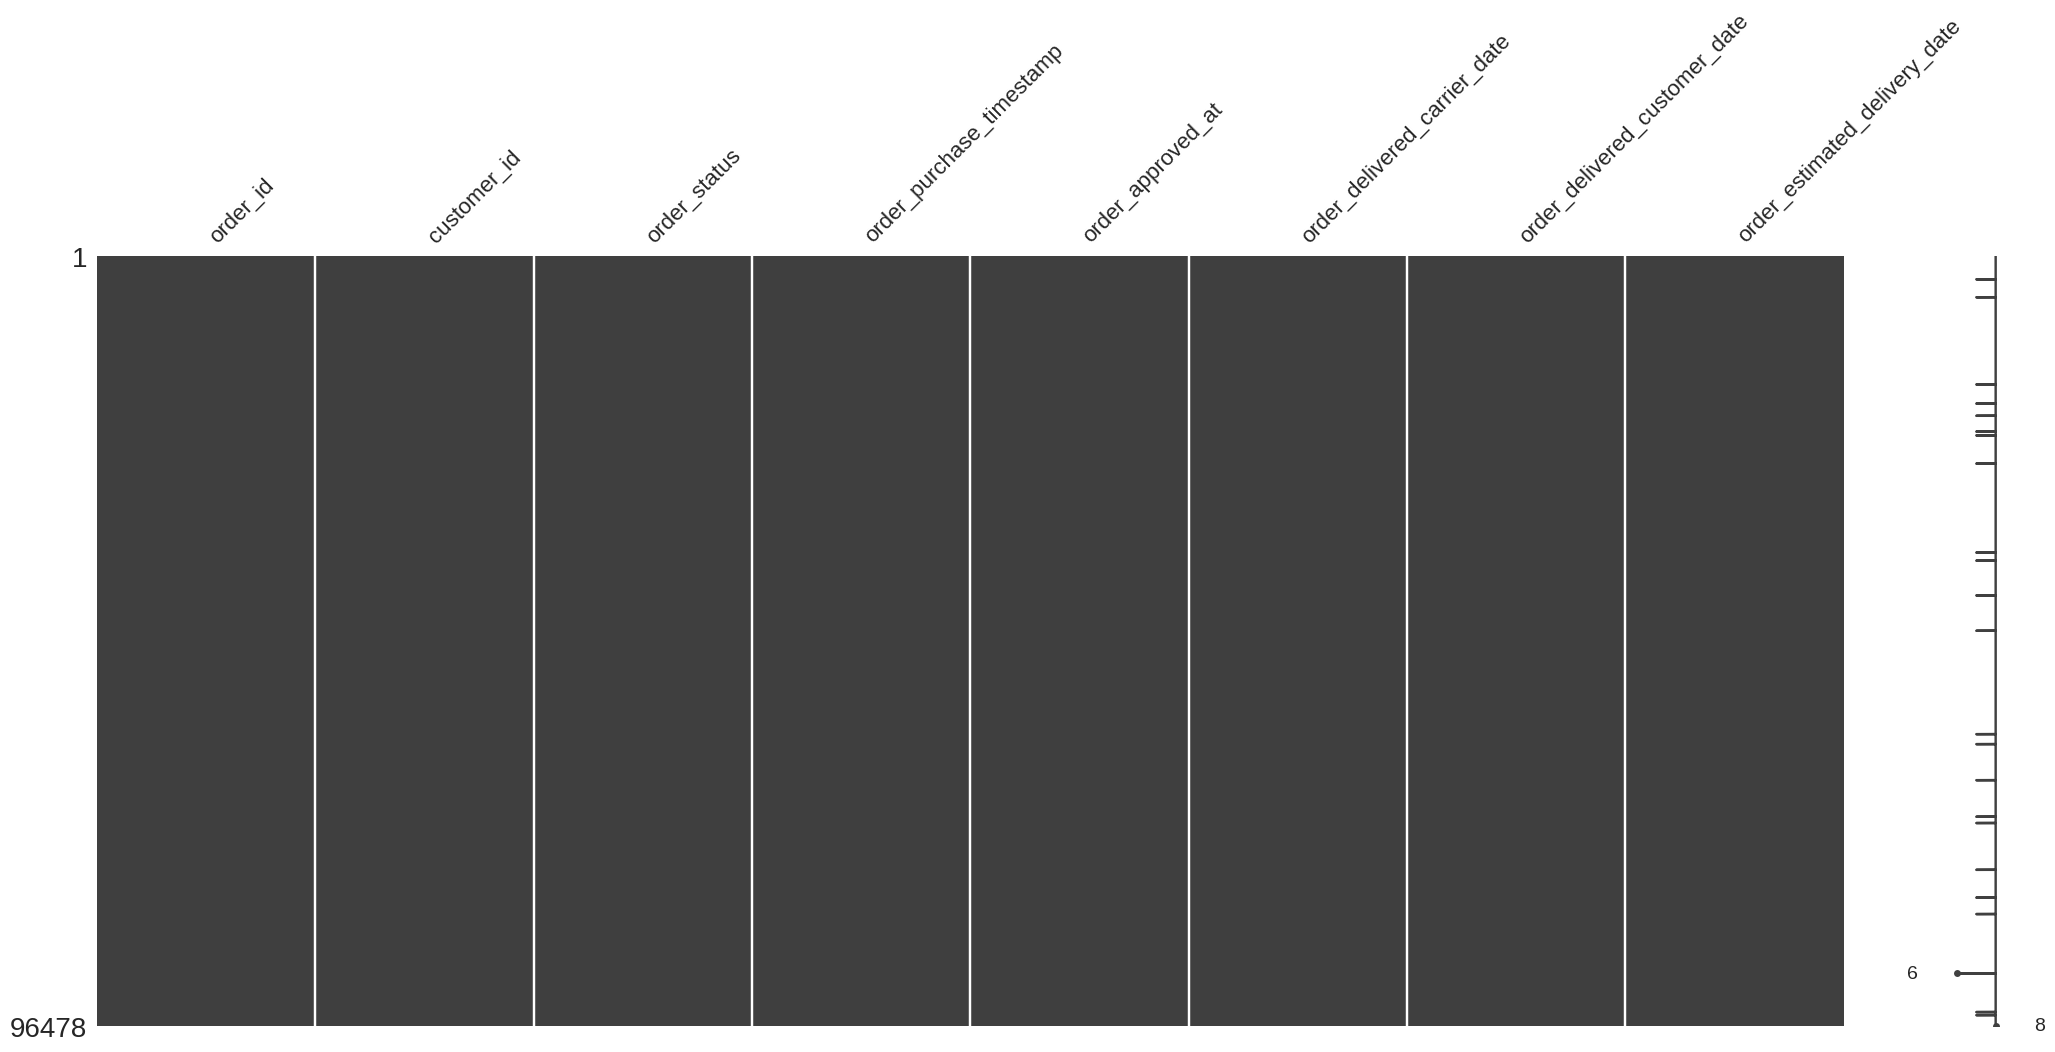

invoiced


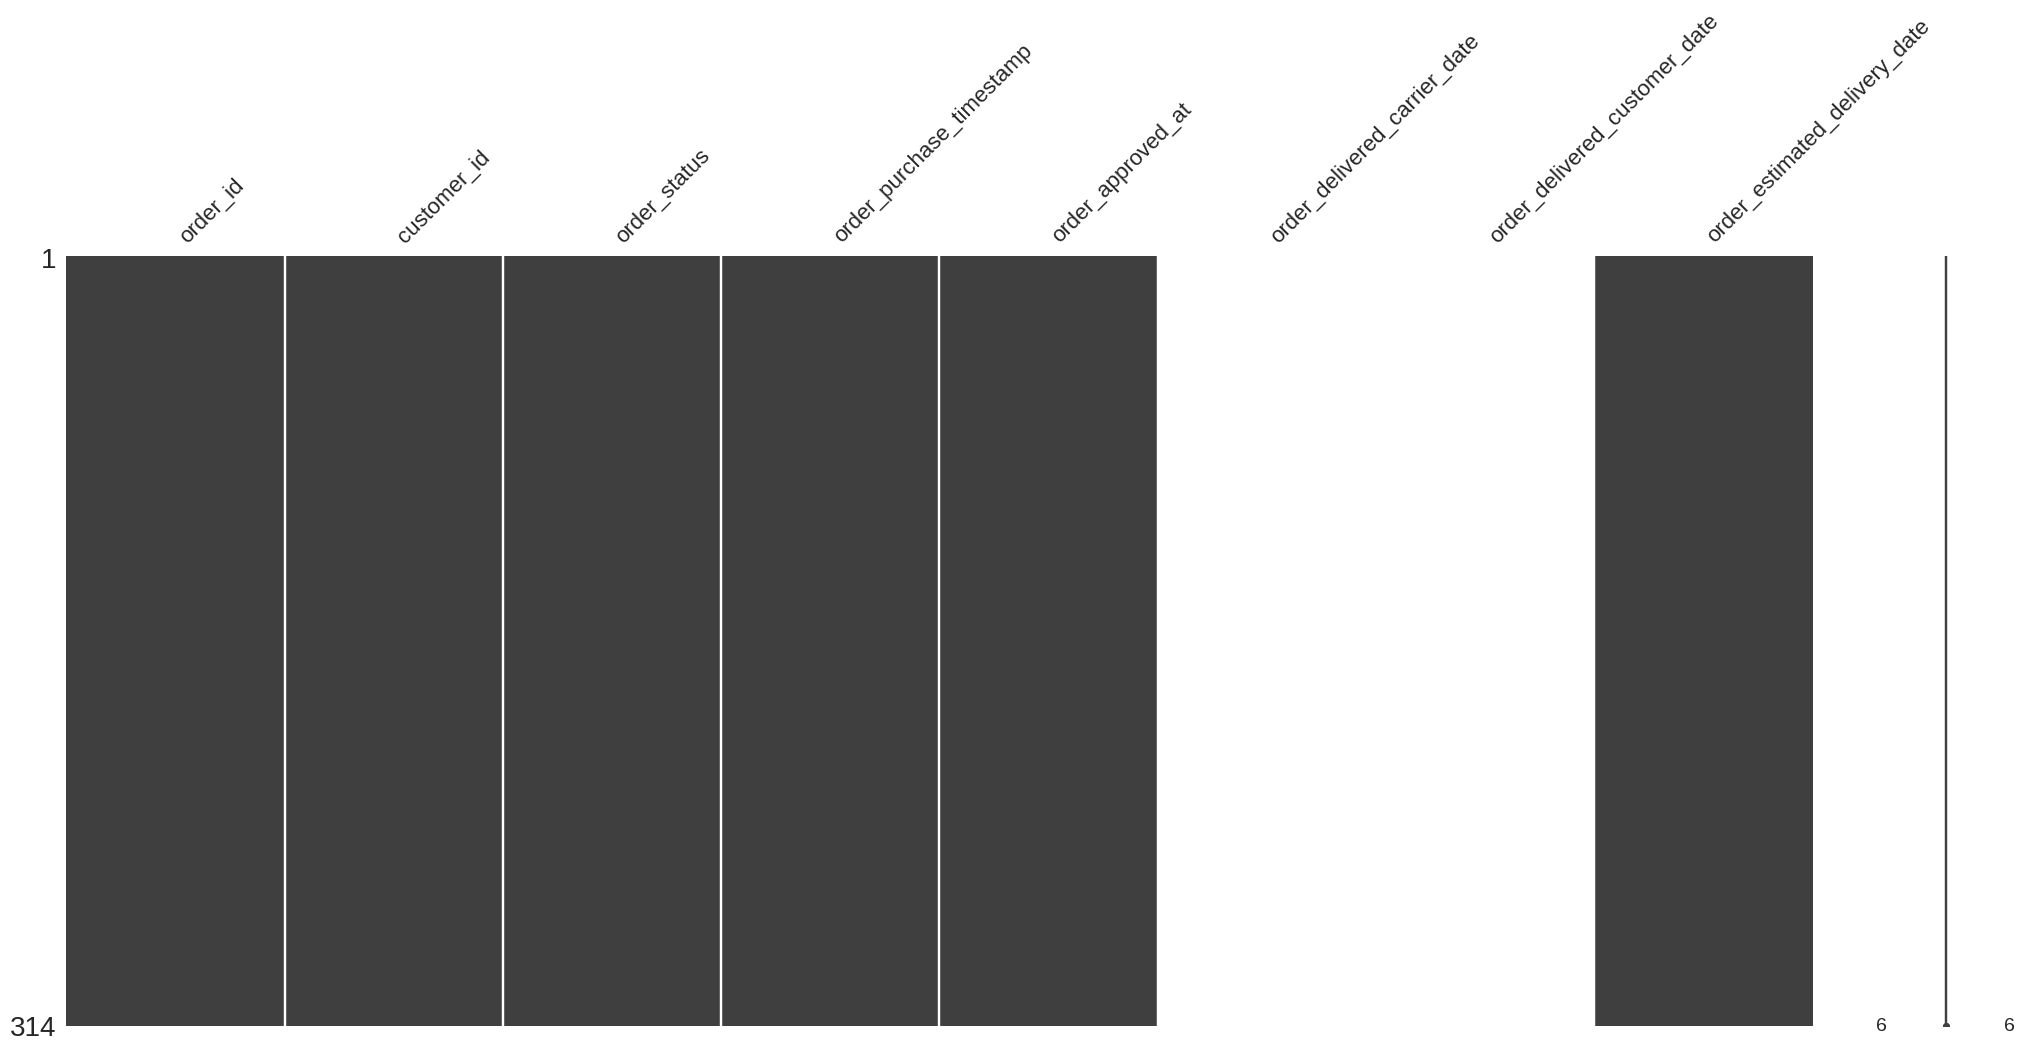

shipped


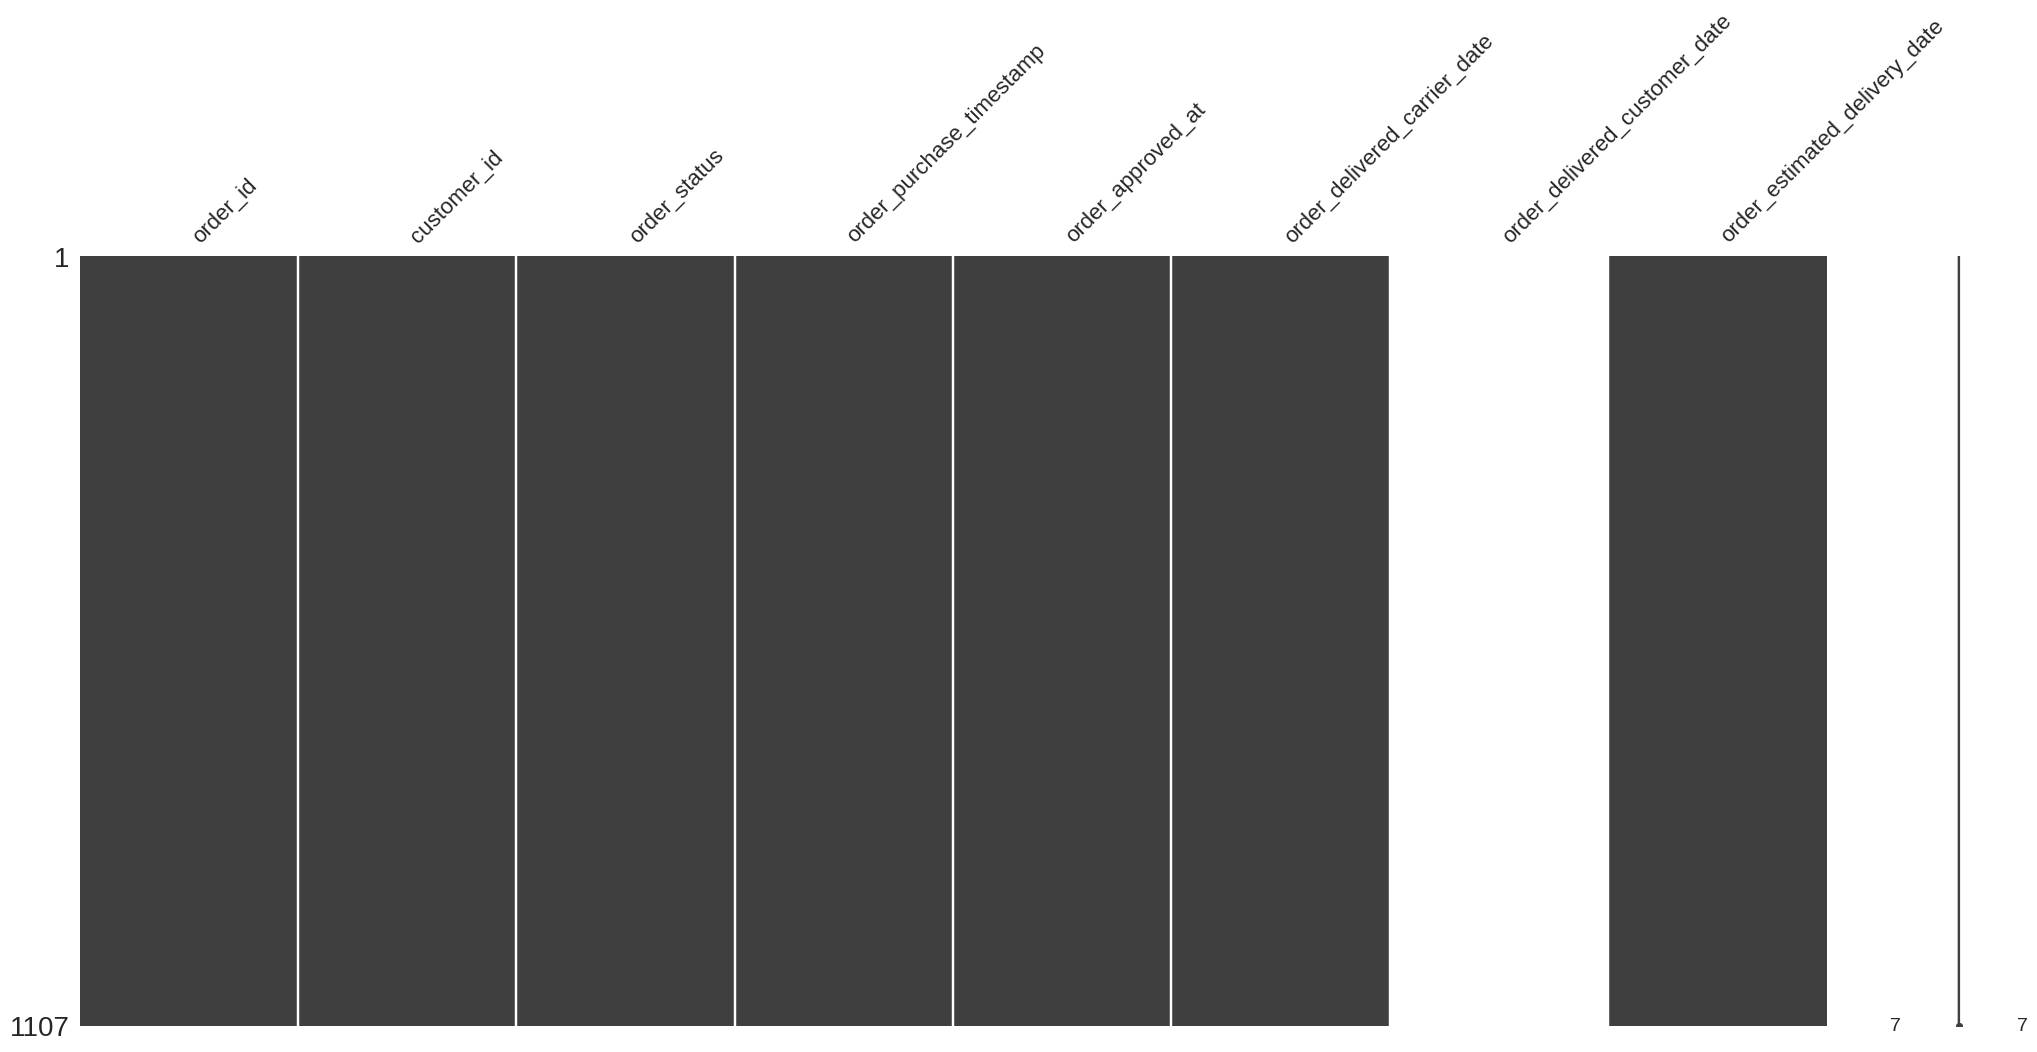

processing


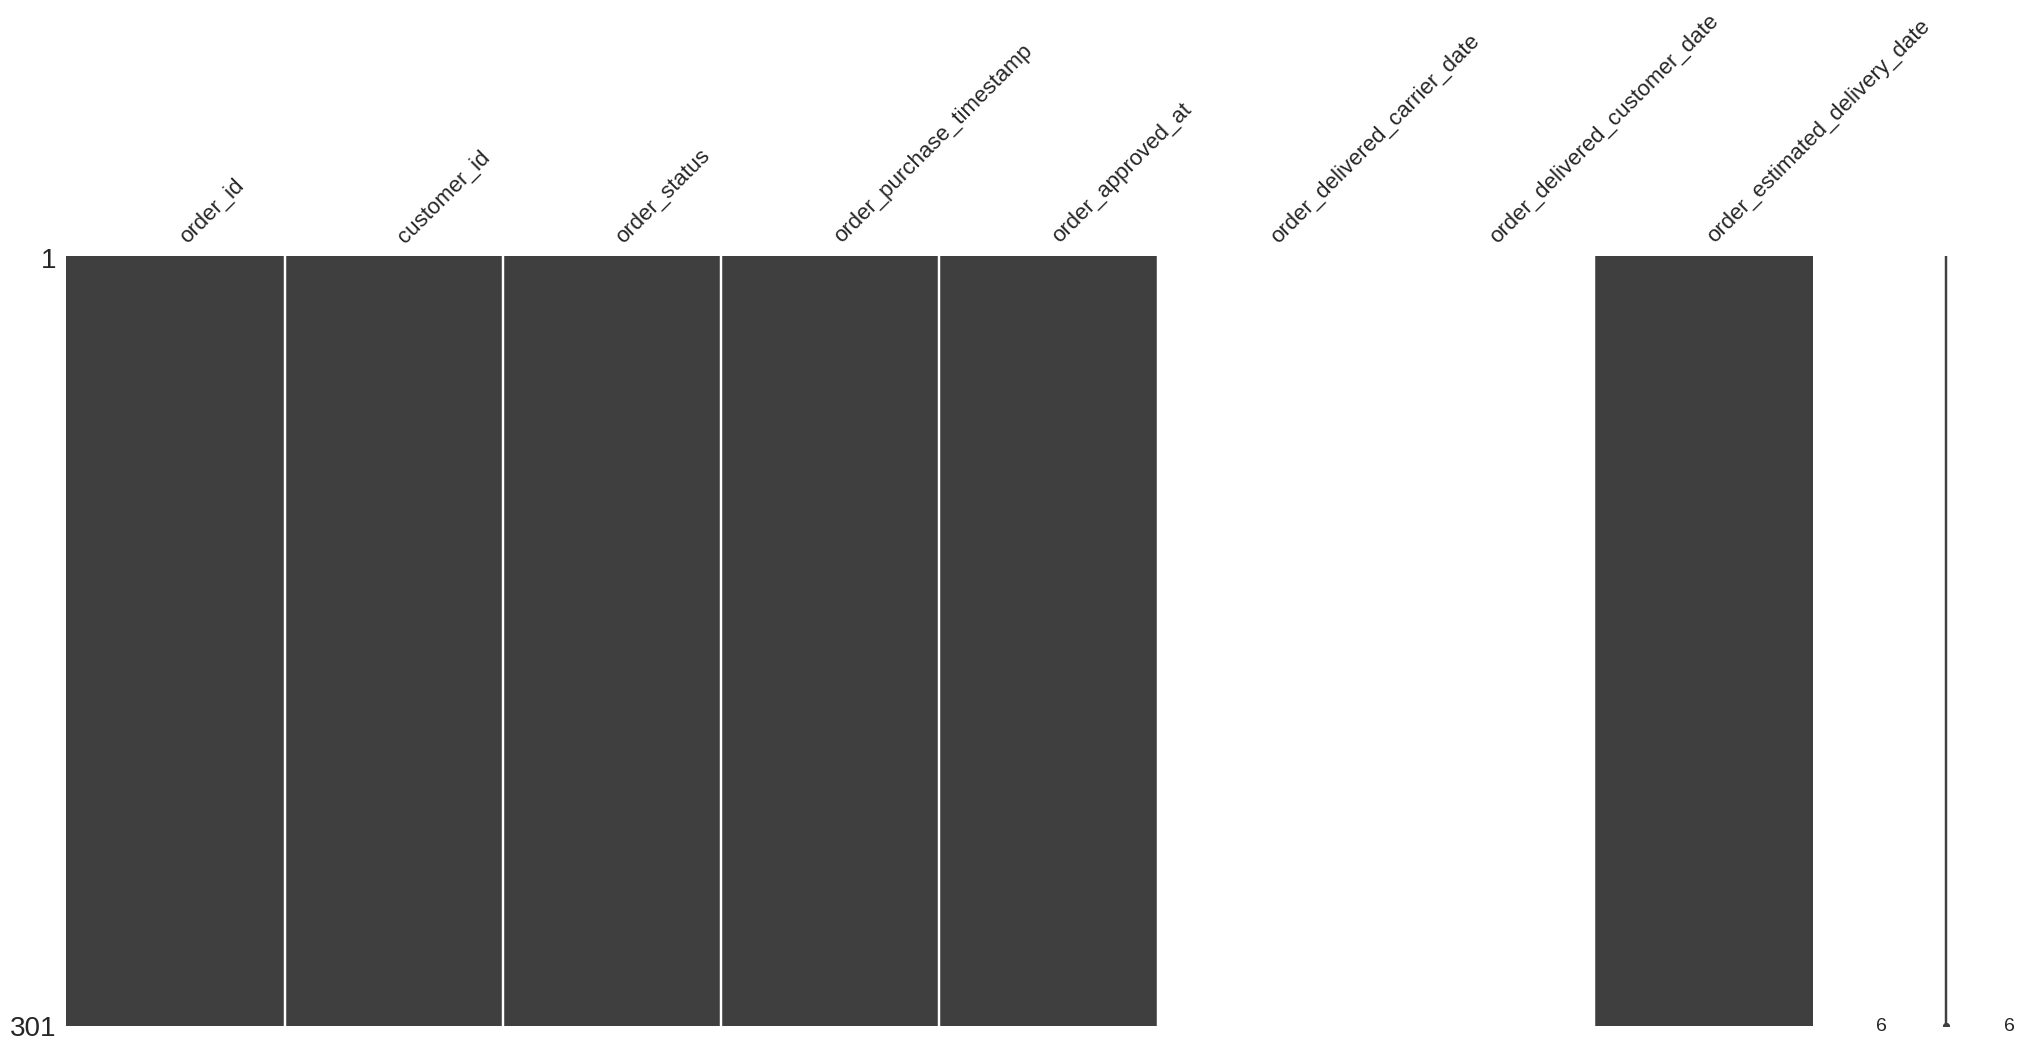

unavailable


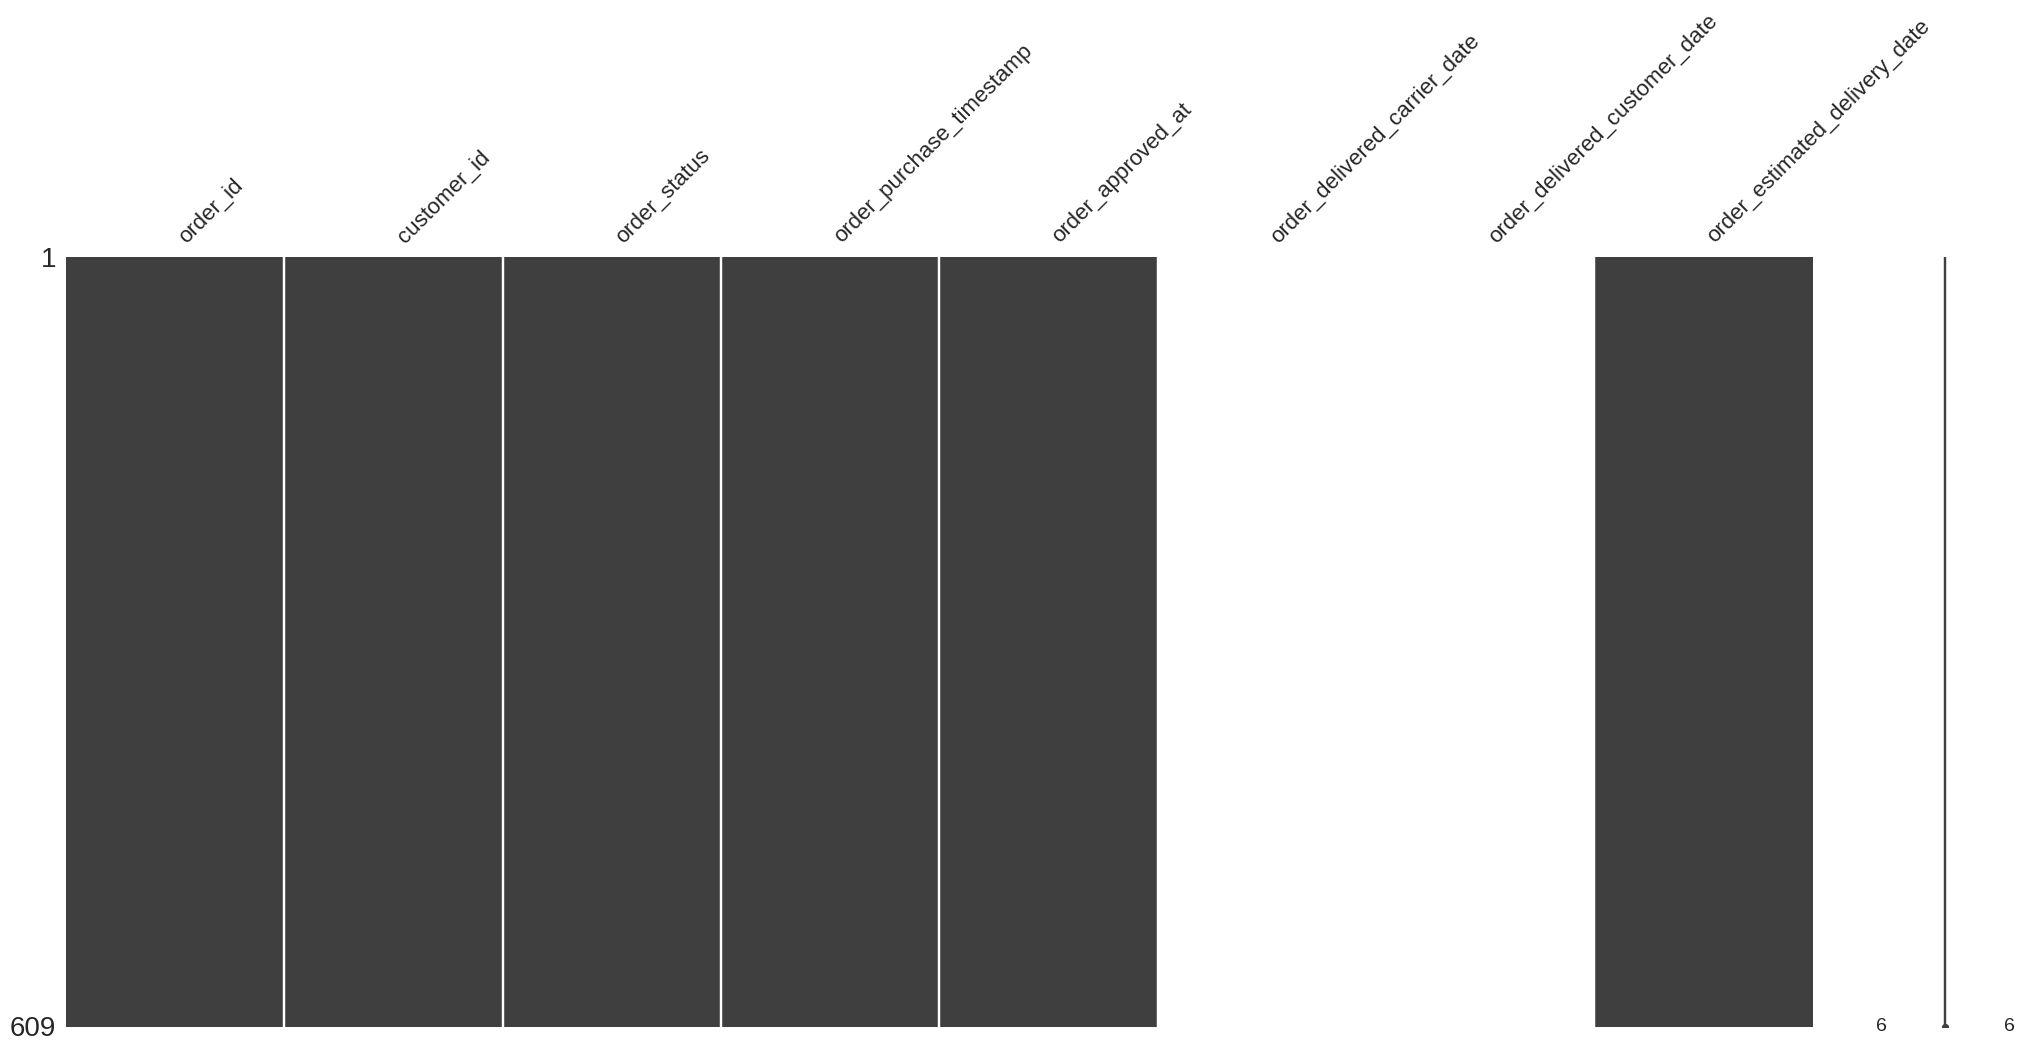

canceled


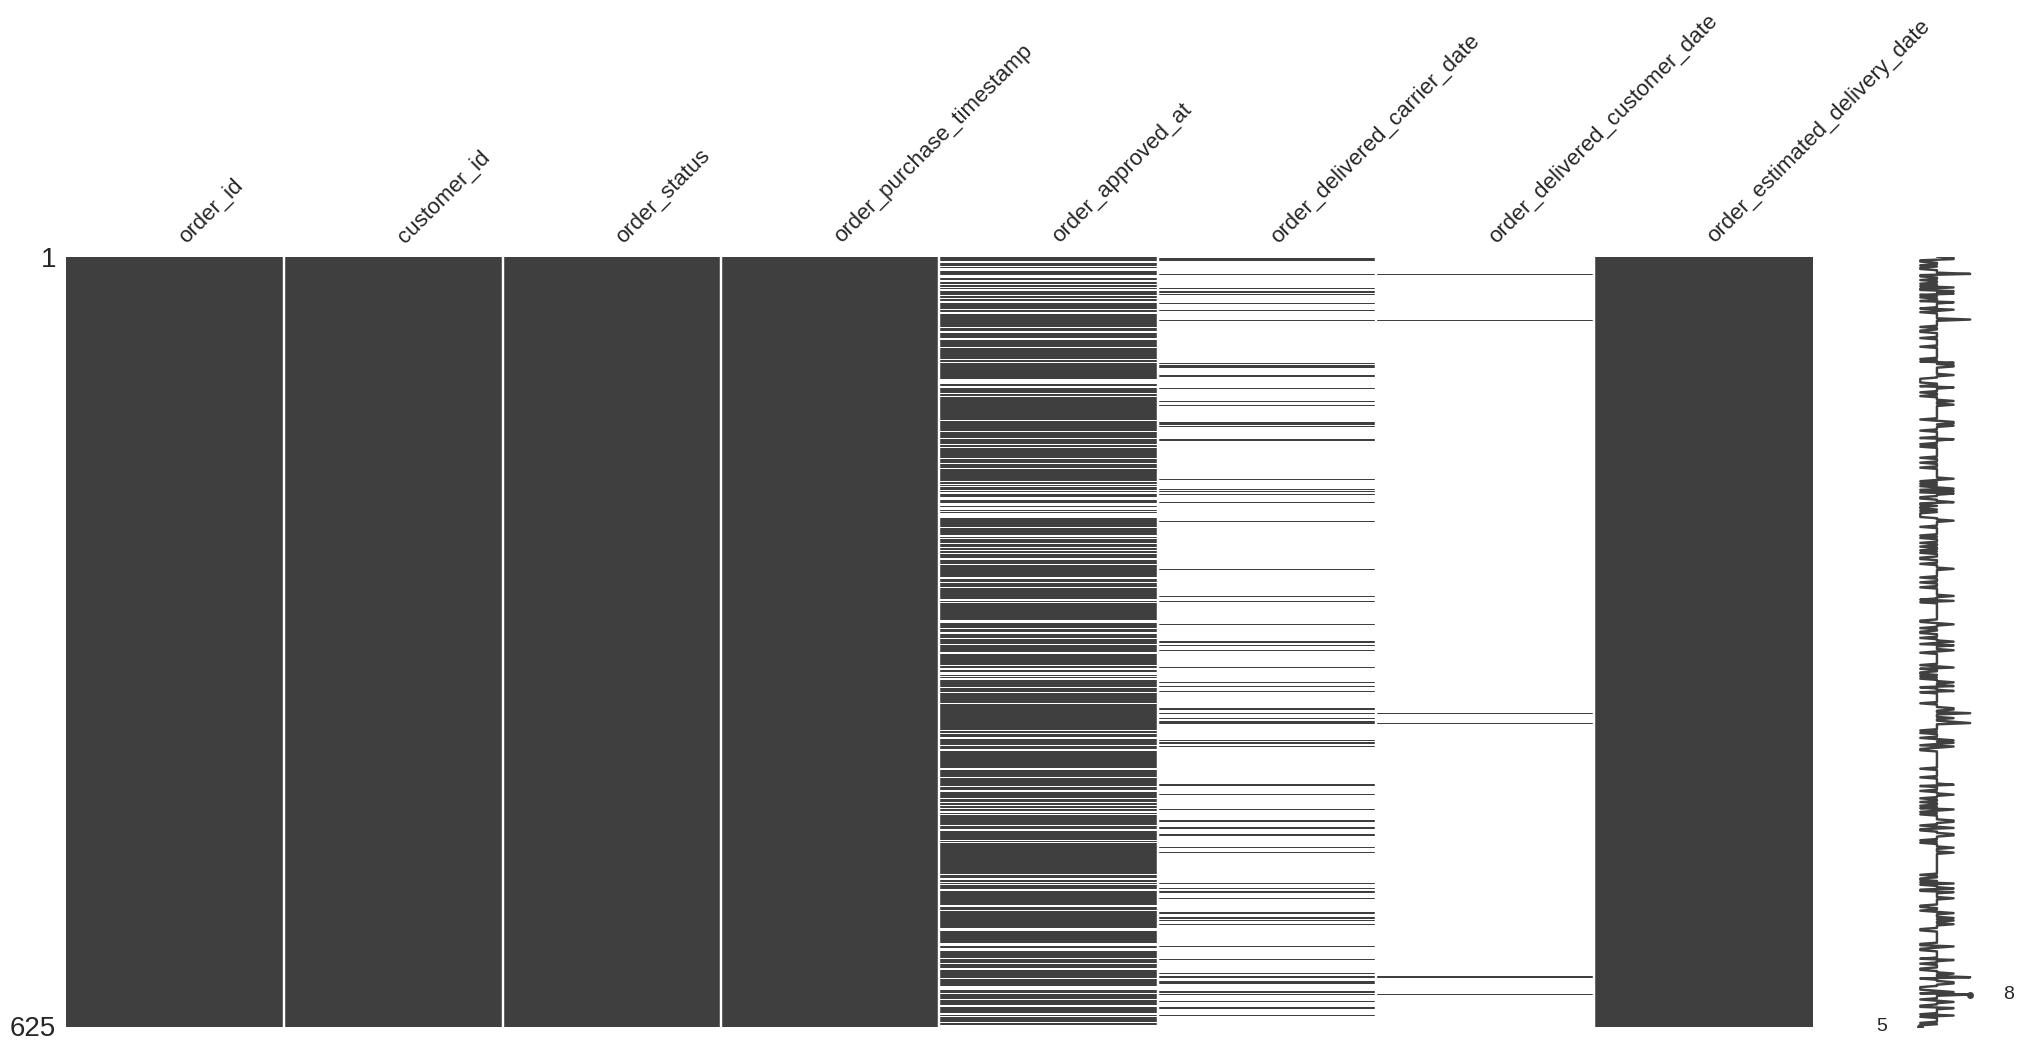

created


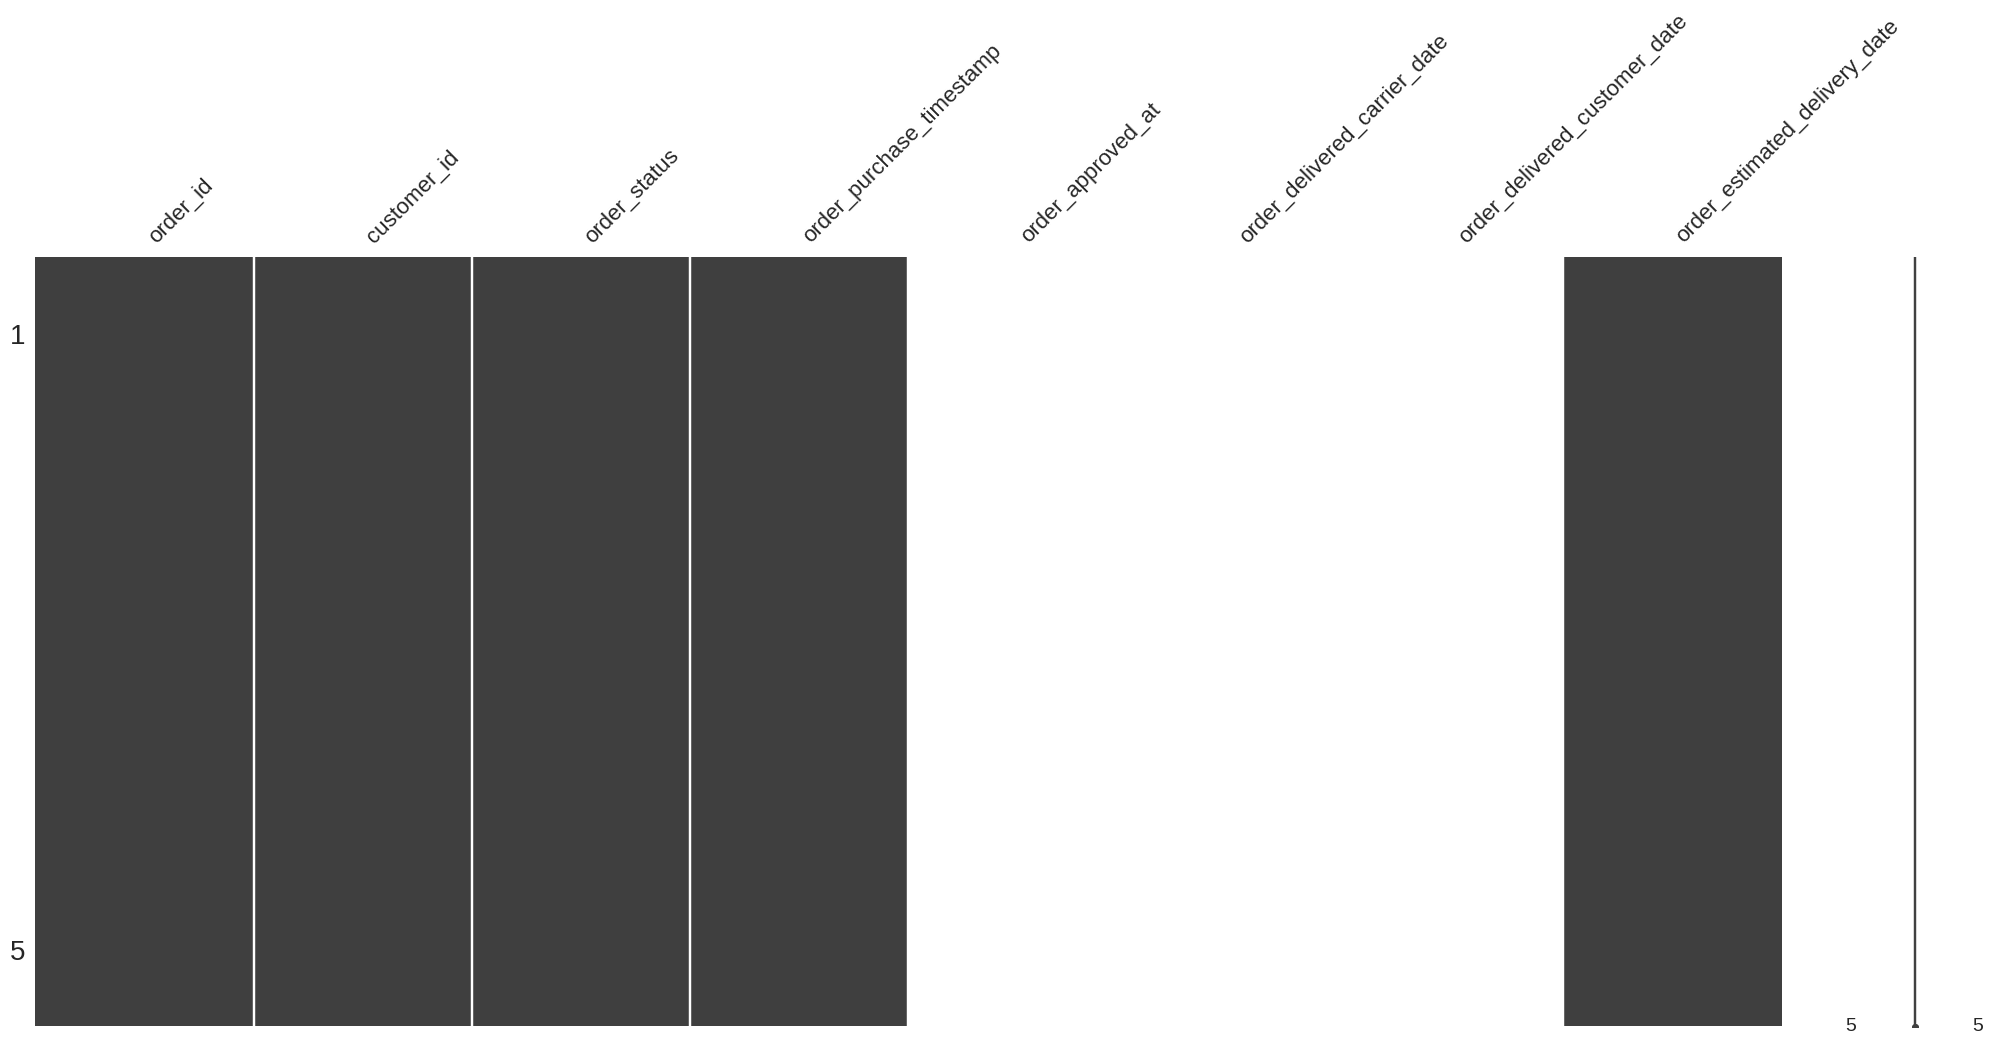

approved


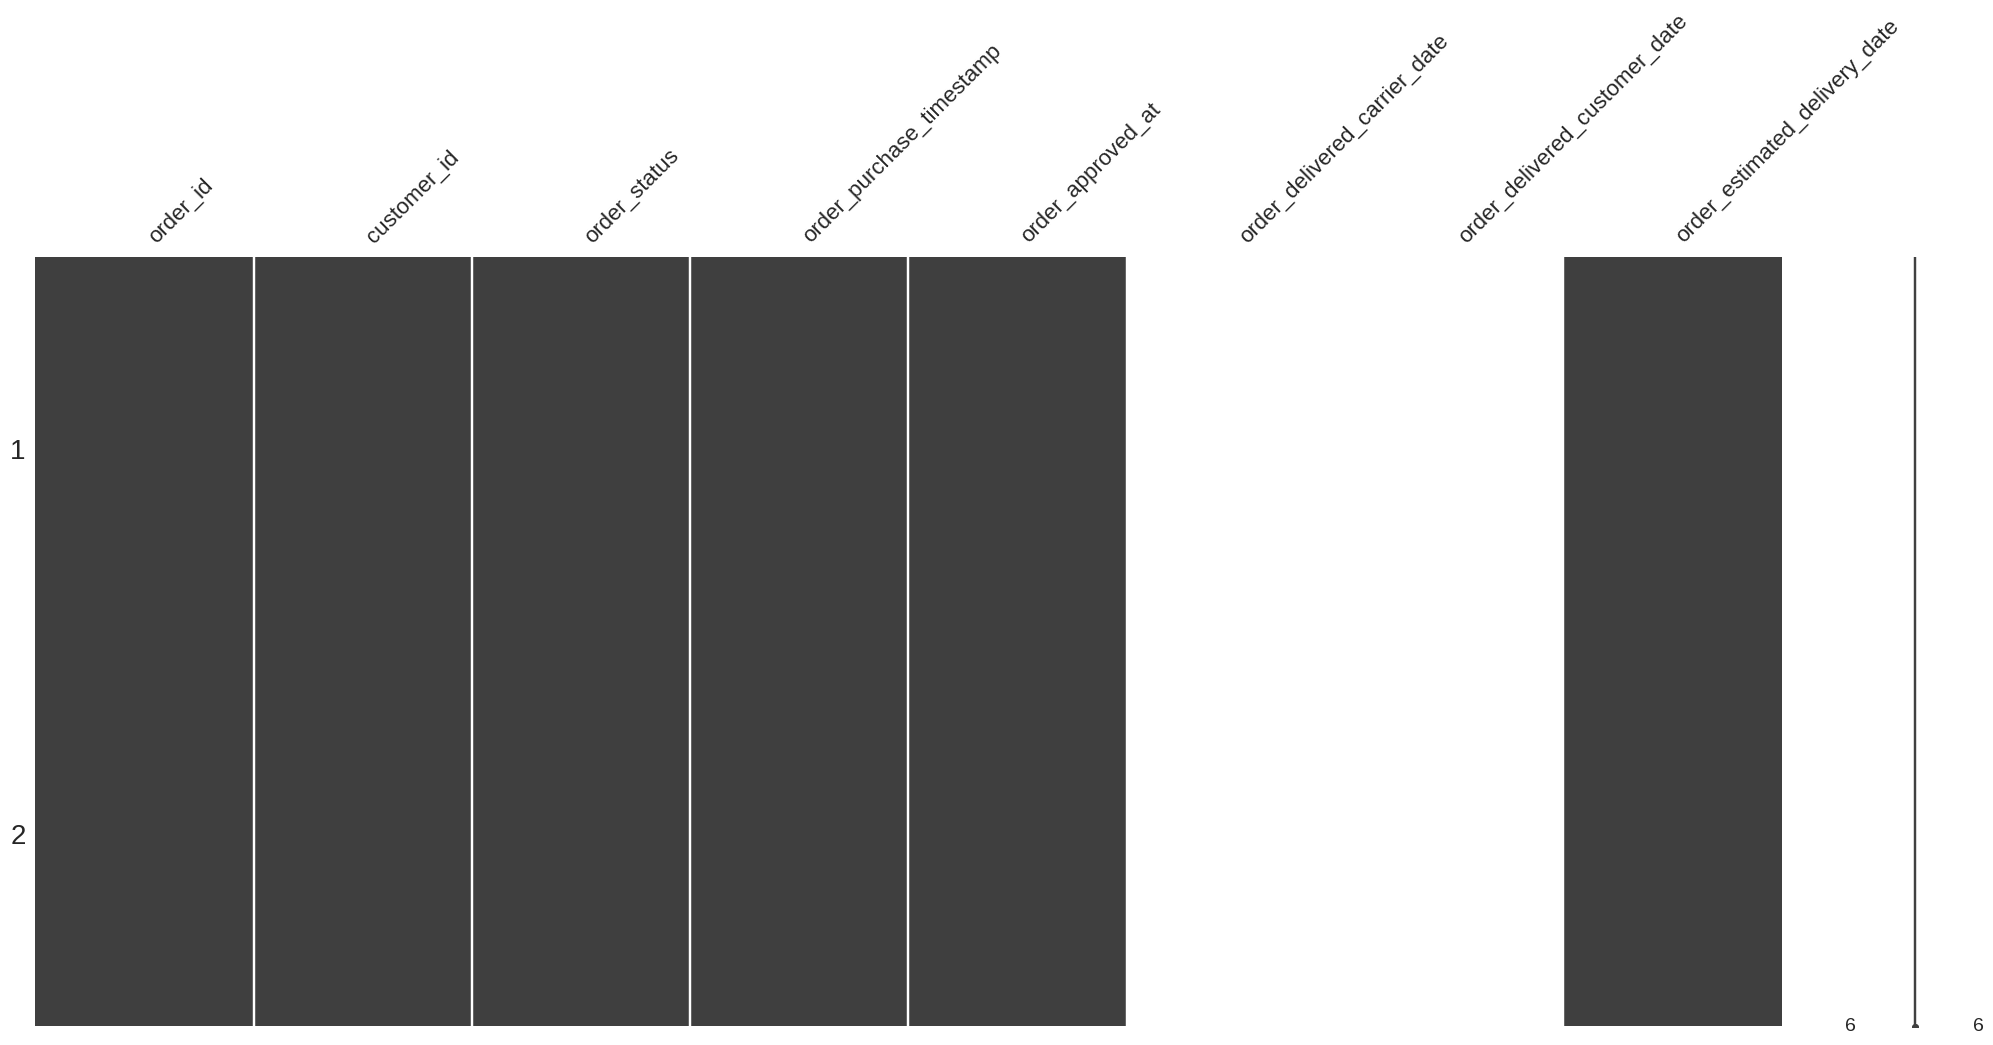

In [40]:
# Observe nulls depending on the status
for status in orders.order_status.unique():
    print(status)
    wdf = orders.query('order_status == @status')
    if len(wdf) > 300:
        wdf.sample(300)
    msno.matrix(wdf)
    plt.show()


We have clear nulls patterns in columns dealing with dates according to the status.

Meaning of these columns thanks to the documentation : 
| Column name    | Description |
| -------- | ------- |
|order_purchase_timestamp | Shows the purchase timestamp|
|order_approved_at | Shows the payment approval timestamp.|
|order_delivered_carrier_date | Shows the order posting timestamp. When it was handled to the logistic partner.|
|order_delivered_customer_date | Shows the actual order delivery date to the customer.|
|order_estimated_delivery_date|Shows the estimated delivery date that was informed to customer at the purchase moment.|

My hypothesis about these status :
- delivered : no nulls --> the product is now at the client's.
- shipped : expected null in the delivery date --> the product is in the hands of the carrier.
- processing : expected nulls (carrier) because the seller is preparing the package.
- unavailable : expected nulls (carrier) the client paid and it was approved but unfortunately the seller cannot send because he does not have any sample left.
- canceled : several reasons --> canceled because not approved, while shipping : was it too long, did it get lost?
*Here, it is somewhat special that the client has a delivered date stamp if the order was canceled.*
Mostly understandable nulls.


- invoiced and approved seem similar. The client paid, and when the seller will notice that, he will start processing the transmission. Expected nulls.
- created : not approved by the bank yet. Expected nulls.

**Conclusion** :
- Every nulls seem legitimate. They are due to the status of the order. 
- However, *some non-null dates* are catching my attention. Why some clients received the package whereas the order was labeled canceled? 

*remark* : As my conclusion are based on sampling, I might want to count nulls in date columns once group by the status to be sure I did not miss anything.


In [41]:
# counting missing dates per order status.
nulls_counts = (orders[["order_approved_at",
                        "order_delivered_carrier_date",
                        "order_delivered_customer_date"]]
                .groupby(orders.order_status)
                .apply(lambda x: x.isnull().sum()))

totals = (orders
          .groupby('order_status')["order_id"]
          .agg(len)
          .rename("total"))

nulls_view = pd.concat([nulls_counts, totals], axis=1)
nulls_view.T.style.background_gradient('Purples')


In [42]:
# Counting known dates per order status.
not_null_counts = (orders
                   .groupby('order_status')["order_approved_at",
                                            "order_delivered_carrier_date",
                                            "order_delivered_customer_date"]
                   .apply(lambda x: x.notnull().sum()))

totals = (orders
          .groupby('order_status')["order_id"]
          .agg(len)
          .rename("total"))

nulls_view = pd.concat([not_null_counts, totals], axis=1)
nulls_view.T.style.background_gradient('Purples')


/tmp/ipykernel_3688/4126326100.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  not_null_counts = (orders


My conclusions were exact except for the delivered status where there are missing dates that should be known.

Or is it possible that the order status is wrong?

Can we know more about that?


In [43]:
mycols = ["order_approved_at",
          "order_delivered_carrier_date",
          "order_delivered_customer_date",
          "order_status"]

delivered = orders.query("order_status =='delivered'")

mask = delivered.loc[:, mycols].isnull().any(axis=1)
display(delivered.loc[mask])

# saving problematic order_ids
problems_order_id = list(delivered.loc[mask].order_id.values)
len(problems_order_id)


order_id                       customer_id  \
3002   2d1e2d5bf4dc7227b3bfebb81328c15f  ec05a6d8558c6455f0cbbd8a420ad34f   
5323   e04abd8149ef81b95221e88f6ed9ab6a  2127dc6603ac33544953ef05ec155771   
16567  8a9adc69528e1001fc68dd0aaebbb54a  4c1ccc74e00993733742a3c786dc3c1f   
19031  7013bcfc1c97fe719a7b5e05e61c12db  2941af76d38100e0f8740a374f1a5dc3   
20618  f5dd62b788049ad9fc0526e3ad11a097  5e89028e024b381dc84a13a3570decb4   
22663  5cf925b116421afa85ee25e99b4c34fb  29c35fc91fc13fb5073c8f30505d860d   
23156  12a95a3c06dbaec84bcfb0e2da5d228a  1e101e0daffaddce8159d25a8e53f2b2   
26800  c1d4211b3dae76144deccd6c74144a88  684cb238dc5b5d6366244e0e0776b450   
38290  d69e5d356402adc8cf17e08b5033acfb  68d081753ad4fe22fc4d410a9eb1ca01   
39334  d77031d6a3c8a52f019764e68f211c69  0bf35cac6cc7327065da879e2d90fae8   
43834  2ebdfc4f15f23b91474edf87475f108e  29f0540231702fda0cfdee0a310f11aa   
48401  7002a78c79c519ac54022d4f8a65e6e8  d5de688c321096d15508faae67a27051   
61743  2eecb0d85f281280f79fa00f9cec1a95  a3d3c38e58b9d2dfb9207cab690b6310   
63052  51eb2eebd5d76a24625b31c33dd41449  07a2a7e0f63fd8cb757ed77d4245623c   
67697  88083e8f64d95b932164187484d90212  f67cd1a215aae2a1074638bbd35a223a   
72407  3c0b8706b065f9919d0505d3b3343881  d85919cb3c0529589c6fa617f5f43281   
73222  2aa91108853cecb43c84a5dc5b277475  afeb16c7f46396c0ed54acb45ccaaa40   
79263  e69f75a717d64fc5ecdfae42b2e8e086  cfda40ca8dd0a5d486a9635b611b398a   
82868  0d3268bad9b086af767785e3f0fc0133  4f1d63d35fb7c8999853b2699f5c7649   
84999  2babbb4b15e6d2dfe95e2de765c97bce  74bebaf46603f9340e3b50c6b086f992   
92643  2d858f451373b04fb5c984a1cc2defaf  e08caf668d499a6d643dafd7c5cc498a   
97647  ab7c89dc1bf4a1ead9d6ec1ec8968a84  dd1b84a7286eb4524d52af4256c0ba24   
98038  20edc82cf5400ce95e1afacc25798b31  28c37425f1127d887d7337f284080a0f   

      order_status order_purchase_timestamp   order_approved_at  \
3002     delivered      2017-11-28 17:44:07 2017-11-28 17:56:40   
5323     delivered      2017-02-18 14:40:00                 NaT   
16567    delivered      2017-02-18 12:45:31                 NaT   
19031    delivered      2017-02-18 13:29:47                 NaT   
20618    delivered      2018-06-20 06:58:43 2018-06-20 07:19:05   
22663    delivered      2017-02-18 16:48:35                 NaT   
23156    delivered      2017-02-17 13:05:55                 NaT   
26800    delivered      2017-01-19 12:48:08                 NaT   
38290    delivered      2017-02-19 01:28:47                 NaT   
39334    delivered      2017-02-18 11:04:19                 NaT   
43834    delivered      2018-07-01 17:05:11 2018-07-01 17:15:12   
48401    delivered      2017-01-19 22:26:59                 NaT   
61743    delivered      2017-02-17 17:21:55                 NaT   
63052    delivered      2017-02-18 15:52:27                 NaT   
67697    delivered      2017-02-18 22:49:19                 NaT   
72407    delivered      2017-02-17 15:53:27                 NaT   
73222    delivered      2017-09-29 08:52:58 2017-09-29 09:07:16   
79263    delivered      2018-07-01 22:05:55 2018-07-01 22:15:14   
82868    delivered      2018-07-01 21:14:02 2018-07-01 21:29:54   
84999    delivered      2017-02-18 17:15:03                 NaT   
92643    delivered      2017-05-25 23:22:43 2017-05-25 23:30:16   
97647    delivered      2018-06-08 12:09:39 2018-06-08 12:36:39   
98038    delivered      2018-06-27 16:09:12 2018-06-27 16:29:30   

      order_delivered_carrier_date order_delivered_customer_date  \
3002           2017-11-30 18:12:23                           NaT   
5323           2017-02-23 12:04:47           2017-03-01 13:25:33   
16567          2017-02-23 09:01:52           2017-03-02 10:05:06   
19031          2017-02-22 16:25:25           2017-03-01 08:07:38   
20618          2018-06-25 08:05:00                           NaT   
22663          2017-02-22 11:23:10           2017-03-09 07:28:47   
23156          2017-02-22 11:23:11           2017-03-02 11:09:19   
26800          2017-01-25 14:

23

May be crossing this with the reviews would help understand.

Thoughts :
- A package can not be delivered if not given to the carrier at some point. (1 ludicrous case).
- It is possible that the seller was notified of the purchase and sent the package without waiting for the payment approval...

In [44]:
arrived_but_canceled = (orders
                        .loc[orders.order_delivered_customer_date.notnull()]
                        .query("order_status == 'canceled'"))

display(arrived_but_canceled)

# saving more problematic order_ids
problems_order_id.extend(list(arrived_but_canceled.order_id.values))
len(problems_order_id)


order_id                       customer_id  \
2921   1950d777989f6a877539f53795b4c3c3  1bccb206de9f0f25adc6871a1bcf77b2   
8791   dabf2b0e35b423f94618bf965fcb7514  5cdec0bb8cbdf53ffc8fdc212cd247c6   
58266  770d331c84e5b214bd9dc70a10b829d0  6c57e6119369185e575b36712766b0ef   
59332  8beb59392e21af5eb9547ae1a9938d06  bf609b5741f71697f65ce3852c5d2623   
92636  65d1e226dfaeb8cdc42f665422522d14  70fc57eeae292675927697fe03ad3ff5   
94399  2c45c33d2f9cb8ff8b1c86cc28c11c30  de4caa97afa80c8eeac2ff4c8da5b72e   

      order_status order_purchase_timestamp   order_approved_at  \
2921      canceled      2018-02-19 19:48:52 2018-02-19 20:56:05   
8791      canceled      2016-10-09 00:56:52 2016-10-09 13:36:58   
58266     canceled      2016-10-07 14:52:30 2016-10-07 15:07:10   
59332     canceled      2016-10-08 20:17:50 2016-10-09 14:34:30   
92636     canceled      2016-10-03 21:01:41 2016-10-04 10:18:57   
94399     canceled      2016-10-09 15:39:56 2016-10-10 10:40:49   

      order_delivered_carrier_date order_delivered_customer_date  \
2921           2018-02-20 19:57:13           2018-03-21 22:03:51   
8791           2016-10-13 13:36:59           2016-10-16 14:36:59   
58266          2016-10-11 15:07:11           2016-10-14 15:07:11   
59332          2016-10-14 22:45:26           2016-10-19 18:47:43   
92636          2016-10-25 12:14:28           2016-11-08 10:58:34   
94399          2016-10-14 10:40:50           2016-11-09 14:53:50   

      order_estimated_delivery_date  
2921                     2018-03-09  
8791                     2016-11-30  
58266                    2016-11-29  
59332                    2016-11-30  
92636                    2016-11-25  
94399                    2016-12-08

29

### 1.6.4.  [&#9650;](#toc0_) <a id='toc1_6_4_'></a>Not delivered orders and dates

In [45]:
not_delivered = (orders.loc[orders.order_status != 'delivered', :])
display(not_delivered.head())
not_delivered.order_status.value_counts()


order_id                       customer_id  \
6    136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
44   ee64d42b8cf066f35eac1cf57de1aa85  caded193e8e47b8362864762a83db3c5   
103  0760a852e4e9d89eb77bf631eaaf1c84  d2a79636084590b7465af8ab374a8cf5   
128  15bed8e2fec7fdbadb186b57c46c92f2  f3f0e613e0bdb9c7cee75504f0f90679   
154  6942b8da583c2f9957e990d028607019  52006a9383bf149a4fb24226b173106f   

    order_status order_purchase_timestamp   order_approved_at  \
6       invoiced      2017-04-11 12:22:08 2017-04-13 13:25:17   
44       shipped      2018-06-04 16:44:48 2018-06-05 04:31:18   
103     invoiced      2018-08-03 17:44:42 2018-08-07 06:15:14   
128   processing      2017-09-03 14:22:03 2017-09-03 14:30:09   
154      shipped      2018-01-10 11:33:07 2018-01-11 02:32:30   

    order_delivered_carrier_date order_delivered_customer_date  \
6                            NaT                           NaT   
44           2018-06-05 14:32:00                           NaT   
103                          NaT                           NaT   
128                          NaT                           NaT   
154          2018-01-11 19:39:23                           NaT   

    order_estimated_delivery_date  
6                      2017-05-09  
44                     2018-06-28  
103                    2018-08-21  
128                    2017-10-03  
154                    2018-02-07

shipped        1107
canceled        625
unavailable     609
invoiced        314
processing      301
created           5
approved          2
delivered         0
Name: order_status, dtype: int64

In [46]:
statuses = (not_delivered
            .loc[:, ['order_status', 'order_purchase_timestamp', 'order_id']]
            .set_index('order_purchase_timestamp'))

statuses.head()


order_status                          order_id
order_purchase_timestamp                                               
2017-04-11 12:22:08          invoiced  136cce7faa42fdb2cefd53fdc79a6098
2018-06-04 16:44:48           shipped  ee64d42b8cf066f35eac1cf57de1aa85
2018-08-03 17:44:42          invoiced  0760a852e4e9d89eb77bf631eaaf1c84
2017-09-03 14:22:03        processing  15bed8e2fec7fdbadb186b57c46c92f2
2018-01-10 11:33:07           shipped  6942b8da583c2f9957e990d028607019

In [47]:
statuses['year'] = statuses.index.year
statuses['week'] = statuses.index.isocalendar().week


In [48]:
statuses.head()


order_status                          order_id  year  \
order_purchase_timestamp                                                        
2017-04-11 12:22:08          invoiced  136cce7faa42fdb2cefd53fdc79a6098  2017   
2018-06-04 16:44:48           shipped  ee64d42b8cf066f35eac1cf57de1aa85  2018   
2018-08-03 17:44:42          invoiced  0760a852e4e9d89eb77bf631eaaf1c84  2018   
2017-09-03 14:22:03        processing  15bed8e2fec7fdbadb186b57c46c92f2  2017   
2018-01-10 11:33:07           shipped  6942b8da583c2f9957e990d028607019  2018   

                          week  
order_purchase_timestamp        
2017-04-11 12:22:08         15  
2018-06-04 16:44:48         23  
2018-08-03 17:44:42         31  
2017-09-03 14:22:03         35  
2018-01-10 11:33:07          2

/home/louberehc/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/louberehc/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/home/louberehc/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/louberehc/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dt

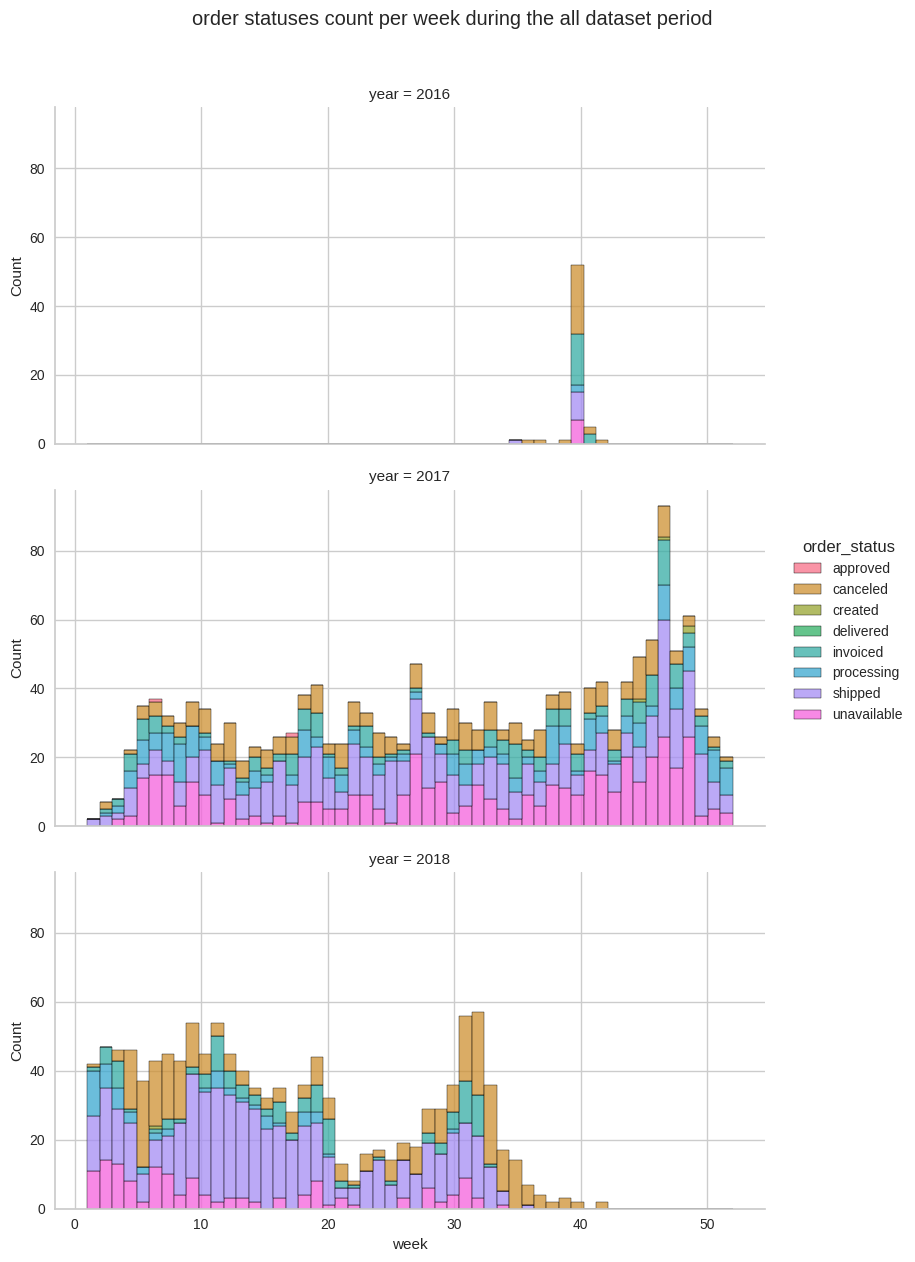

In [49]:
sns.displot(data=statuses, x="week", hue="order_status",
            row="year", multiple="stack", height=4, aspect=2, bins=52)
plt.suptitle('order statuses count per week during the all dataset period',
             y=1.05)
plt.show()


In [50]:
orders.order_purchase_timestamp.max().week


42

I was expecting to essentially see shipped orders in the last weeks of this dataset.
It is very surprising to see there are almost none... 

Thus, shipped order could be labeled as not_delivered at some point (except if the current date is not after the estimated delivery date)

### 1.6.5.  [&#9650;](#toc0_) <a id='toc1_6_5_'></a>Items with no category

In [51]:
no_product_category = products.query("product_category_name.isnull()")
no_product_category.head()


product_id product_category_name
105  a41e356c76fab66334f36de622ecbd3a                   NaN
128  d8dee61c2034d6d075997acef1870e9b                   NaN
145  56139431d72cd51f19eb9f7dae4d1617                   NaN
154  46b48281eb6d663ced748f324108c733                   NaN
197  5fb61f482620cb672f5e586bb132eae9                   NaN

Need to merge the info to investigate...

# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Merging the datasets step by step.

The idea of merging the information is to build a dataset in which each row would represent the information associated with each product ordered on the platform.

Then, this will allow to group information by client and generate features to characterize it, such as the features used in the RFM approach : 
- Recency ;
- Frequency ;
- Monetary value. 

Let's figure out if there is non-unique id's to better understand how the merging will work according to the following schema.

<img src="./data_schema.png" width="600"/>

## 2.1.  [&#9650;](#toc0_) <a id='toc2_1_'></a>merging id's

In [52]:
ids = dict(customers="customer_id",
           orders="order_id",
           order_reviews="order_id",
           order_payments="order_id",
           order_items="order_id",
           products="product_id")

for df_name in ids:
    print(df_name)
    data = eval(df_name)
    print('length of the dataframe :')
    print(len(data))
    print('number of unique ids used to merge :')
    print(data[ids[df_name]].nunique())
    print('-'*30)
    

customers
length of the dataframe :
99441
number of unique ids used to merge :
99441
------------------------------
orders
length of the dataframe :
99441
number of unique ids used to merge :
99441
------------------------------
order_reviews
length of the dataframe :
99224
number of unique ids used to merge :
98673
------------------------------
order_payments
length of the dataframe :
103886
number of unique ids used to merge :
99440
------------------------------
order_items
length of the dataframe :
112650
number of unique ids used to merge :
98666
------------------------------
products
length of the dataframe :
32951
number of unique ids used to merge :
32951
------------------------------


First, we can note that all numbers of unique ids are lower than the number of customers from which I am going to start the merging process. Thus, there won't always be a match.

We are expecting 2 one-to-one matches (when the number of unique ids is the same than the dataframe length), but for the rest, some null values will be introduced. We will have to understand why and where there is some missing information and address it.

## 2.2.  [&#9650;](#toc0_) <a id='toc2_2_'></a>Merged_df : customers <-- orders

In [53]:
df = pt.merge_and_display(customers, orders, on="customer_id")


shape before merging : (99441, 5)
shape of the right df: (99441, 8)
shape after merging : (99441, 12)


customer_id                      1.000000
customer_unique_id               1.000000
customer_zip_code_prefix         1.000000
customer_city                    1.000000
customer_state                   1.000000
order_id                         1.000000
order_status                     1.000000
order_purchase_timestamp         1.000000
order_approved_at                0.998391
order_delivered_carrier_date     0.982070
order_delivered_customer_date    0.970183
order_estimated_delivery_date    1.000000
dtype: float64

Null dates already studied.

## 2.3.  [&#9650;](#toc0_) <a id='toc2_3_'></a>Merged_df <-- order_items

In [54]:
df = pt.merge_and_display(df, order_items, on="order_id")


shape before merging : (99441, 12)
shape of the right df: (112650, 7)
shape after merging : (113425, 18)


customer_id                      1.000000
customer_unique_id               1.000000
customer_zip_code_prefix         1.000000
customer_city                    1.000000
customer_state                   1.000000
order_id                         1.000000
order_status                     1.000000
order_purchase_timestamp         1.000000
order_approved_at                0.998581
order_delivered_carrier_date     0.982649
order_delivered_customer_date    0.971532
order_estimated_delivery_date    1.000000
order_item_id                    0.993167
product_id                       0.993167
seller_id                        0.993167
shipping_limit_date              0.993167
price                            0.993167
freight_value                    0.993167
dtype: float64

The last merging is not a one-to-one.

There are orders where no information was matched, resulting in nulls being introduced.
(consistent because we found out the number of unique order_id in the order_items dataframe to be lower than the number of orders.)

Let's try to understand which are the rows impacted.

In [55]:
# Some order had no item correspondance
113425-112650


775

In [56]:
# Checking for the introduced nulls
no_items = df.loc[df[df.columns[-6:]].isnull().any(axis=1), :]
print(no_items.shape)
display(no_items.sample(20))
no_items.order_status.value_counts()


(775, 18)


customer_id                customer_unique_id  \
62326   950212a2b67caa64e9628f68a58b3314  395e3187ccf0df6a57f81f778b896251   
1050    d83753f7658bcc23859c5f1988cdf50f  0c17966568c69f8f827f574911f8b729   
28245   b0232f62bd310b605fc9ba834860ce2c  1350e2fa0415f0c50796bde8c33325a2   
48025   fc605af68bba864d01d42be7edd4ec6e  3db9654cb5274f5b9e70960acc045dc0   
80723   fa8edf721f4091b4851977b761d62c1e  68d891ce207863d0b5391a364d42cb6a   
78961   3d2f26eab3f79dd1fe9977f615e70c2f  cd88b962adbc4b174353217f99dc6174   
92664   fb5adcc8d11e1000f05d9e6b683a0700  910049a37deee265cbf313d8fc77df7c   
112085  7353b0fb8e8d9675e3a704c60ca44ebe  21c933c8dd97d088e64c50988c90ccf5   
66446   6f113a5510dd5bffba3fc6b0dd006de2  48a5a17d697d2da4735f51e37dfbdc50   
78790   856336203359aa6a61bf3826f7d84c49  262e1f1e26e92e86375f86840b4ffd63   
94544   d46ae795ce93d1cec2f41eea68a58982  3da26ad0ffe9feea8ce65b20cedc17bf   
111129  6e568303db60ca2bb3aec0b1f9183492  7c9a0402e884c791edf88646b7c20a82   
21308   cef54c3ad569af033c4ecdaa69c9e140  cfc8d9c0287ded52a81b90c102827129   
43305   0a7dbfcfdf274bc1e1965b91489ba2f9  ff222edf83338ca6b35f8e29871fa07a   
98164   250625a5b2e001bf9876418c919f4a21  df6e683f07113fa30062d2f884569421   
28684   158af3ad0742719d373724b762396918  e96373fff9632d363f5d96e6f169ef33   
80662   63531fc8d878fe9a0ac4fd07a4d8a7b1  81acf66173bb80d6988f3aa37d56176b   
102271  113ccf9504bda6180e498d862b8e9815  b5b985a49b13ddfe43dc657134e7ff94   
17162   2d2259e2fbd96d9aae631389a1d22cf6  683cda1913456fb0cca302892b37a052   
71008   52ac1d5c2063338b5a45f69a14528c9b  93345700f0e852aa904fae18cec8437c   

        customer_zip_code_prefix          customer_city customer_state  \
62326                      82640               curitiba             PR   
1050                        2832              sao paulo             SP   
28245                       4608              sao paulo             SP   
48025                      20040         rio de janeiro             RJ   
80723                      11701           praia grande             SP   
78961                      41180               salvador             BA   
92664                      41730               salvador             BA   
112085                      5017              sao paulo             SP   
66446                      93950            dois irmaos             RS   
78790                      64600                  picos             PI   
94544                       4082              sao paulo             SP   
111129                     13085               campinas             SP   
21308                      36152                 goiana             MG   
43305                      17047                  bauru             SP   
98164                      14409                 franca             SP   
28684                      99960                charrua             RS   
80662                       3360              sao paulo             SP   
102271                      9840  sao bernardo do campo             SP   
17162                       3978              sao paulo             SP   
71008                      26087            nova iguacu             RJ   

                                order_id order_status  \
62326   96e78a16640bdff7370dd73cb821fc01  unavailable   
1050    bc99558709784e3ae0b9f8dbff8c06f0  unavailable   
28245   ee234bfd26ca588915483995d811c1d0  unavailable   
48025   cbc0f78d9e0d7cd99582cd7552cfd64f  unavailable   
80723   4ce5e2d15628c2277ca6ed81ee60f9de  unavailable   
78961   00a500bc03bc4ec968e574c2553bed4b  unavailable   
92664   aed5fd4c4ada58504679761465a6486e  unavailable   
112085  2f634e2cebf8c0283e7ef0989f77d217  unavailable   
66446   037a9cf279c376ab222c9d27be892513  unavailable   
78790   b059ee4de278302d550a3035c4cdb740     canceled   
94544   6111350dd1f8b825ac82e9caea339f07  unavailable   
111129  2c990009034e1fc83904584b26b5fd25  unavailable   
21308   33e13c48e5883f2a3ae2269bf57650c7  unavailable   
43305   259fe605870f08ddf83ebb61f204b

unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
approved         0
delivered        0
processing       0
Name: order_status, dtype: int64

It seems reasonable that unavailable orders have no items correspondance. It is also possible that for unavailable reasons, someone canceled and thus changed the order status. 

But invoiced and shipped orders should at least had one item. And what about created?

In [57]:
instruction = ds.or_query_instruction('order_status',
                                      ["created", "invoiced", "shipped"])

problematic_no_items = no_items.query(instruction)
problematic_no_items


customer_id                customer_unique_id  \
14902  4ee64f4bfc542546f422da0aeb462853  10d5890ed5e7ec78a7db23b5ac579b17   
51673  7d61b9f4f216052ba664f22e9c504ef1  161e5b2b4513edb336986a8909218365   
58265  964a6df3d9bdf60fe3e7b8bb69ed893a  2e015e68fbfa36910263df5384e8e45c   
62064  d7bed5fac093a4136216072abaf599d5  f15a952dfc52308d0361288fbf42c7b3   
77472  b2d7ae0415dbbca535b5f7b38056dd1f  6a2da481aa7827b951175772a0fe8bb8   
87946  0d00d77134cae4c58695086ad8d85100  8886115442775dd8a20c2dcc921c7cc8   
90395  438449d4af8980d107bf04571413a8e7  55fbb57fd54c35a38c80c2a032a6ca6e   
99547  725e9c75605414b21fd8c8d5a1c2f1d6  355862aa14375fe3950ee04fef9c7a53   

       customer_zip_code_prefix    customer_city customer_state  \
14902                     93025     sao leopoldo             RS   
51673                     87720        paranavai             PR   
58265                     73401         brasilia             DF   
62064                     91250     porto alegre             RS   
77472                     16012        aracatuba             SP   
87946                     88070    florianopolis             SC   
90395                     15300  general salgado             SP   
99547                     22621   rio de janeiro             RJ   

                               order_id order_status order_purchase_timestamp  \
14902  35de4050331c6c644cddc86f4f2d0d64      created      2017-12-05 01:07:58   
51673  90ab3e7d52544ec7bc3363c82689965f      created      2017-11-06 13:12:34   
58265  dba5062fbda3af4fb6c33b1e040ca38f      created      2018-02-09 17:21:04   
62064  a68ce1686d536ca72bd2dadc4b8671e5      shipped      2016-10-05 01:47:40   
77472  2ce9683175cdab7d1c95bcbb3e36f478     invoiced      2016-10-05 21:03:33   
87946  e04f1da1f48bf2bbffcf57b9824f76e1     invoiced      2016-10-05 13:22:20   
90395  b5359909123fa03c50bdb0cfed07f098      created      2017-12-05 01:07:52   
99547  7a4df5d8cff4090e541401a20a22bb80      created      2017-11-25 11:10:33   

        order_approved_at order_delivered_carrier_date  \
14902                 NaT                          NaT   
51673                 NaT                          NaT   
58265                 NaT                          NaT   
62064 2016-10-07 03:11:22          2016-11-07 16:37:37   
77472 2016-10-06 07:46:39                          NaT   
87946 2016-10-06 15:51:38                          NaT   
90395                 NaT                          NaT   
99547                 NaT                          NaT   

      order_delivered_customer_date order_estimated_delivery_date  \
14902                           NaT                    2018-01-08   
51673                           NaT                    2017-12-01   
58265                           NaT                    2018-03-07   
62064                           NaT                    2016-12-01   
77472                           NaT                    2016-11-25   
87946                           NaT                    2016-11-29   
90395                           NaT                    2018-01-11   
99547                           NaT                    2017-12-12   

       order_item_id product_id seller_id shipping_limit_date  price  \
14902            NaN        NaN       NaN                 NaN    NaN   
51673            NaN        NaN       NaN                 NaN    NaN   
58265            NaN        NaN       NaN                 NaN    NaN   
62064            NaN        NaN       NaN                 NaN    NaN   
77472            NaN        NaN       NaN                 NaN    NaN   
87946            NaN        NaN       NaN                 NaN    NaN   
90395            NaN        NaN       NaN                 NaN    NaN   
99547            NaN        NaN       NaN                 NaN    NaN   

       freight_value  
14902            NaN  
51673            NaN  
58265            NaN  
62064            NaN  
77472            NaN  
87946            NaN  
90395            NaN  
99547            NaN

## 2.4.  [&#9650;](#toc0_) <a id='toc2_4_'></a> merged_df <-- order_payments

In [58]:
df = pt.merge_and_display(df, order_payments, on="order_id")


shape before merging : (113425, 18)
shape of the right df: (103886, 5)
shape after merging : (118434, 22)


customer_id                      1.000000
customer_unique_id               1.000000
customer_zip_code_prefix         1.000000
customer_city                    1.000000
customer_state                   1.000000
order_id                         1.000000
order_status                     1.000000
order_purchase_timestamp         1.000000
order_approved_at                0.998514
order_delivered_carrier_date     0.982488
order_delivered_customer_date    0.971317
order_estimated_delivery_date    1.000000
order_item_id                    0.992992
product_id                       0.992992
seller_id                        0.992992
shipping_limit_date              0.992992
price                            0.992992
freight_value                    0.992992
payment_sequential               0.999975
payment_type                     0.999975
payment_installments             0.999975
payment_value                    0.999975
dtype: float64

Here the number of rows grows too.
Let's investigate why

In [59]:
# Searching for order_id which somehow got expanded
(df.groupby('order_id')["customer_id"].agg(len)
 .sort_values(ascending=False)
 .rename("order_id_number_of_rows")
 .head())


order_id
895ab968e7bb0d5659d16cd74cd1650c    63
fedcd9f7ccdc8cba3a18defedd1a5547    38
fa65dad1b0e818e3ccc5cb0e39231352    29
ccf804e764ed5650cd8759557269dc13    26
c6492b842ac190db807c15aff21a7dd6    24
Name: order_id_number_of_rows, dtype: int64

In [60]:
# What about the order_id with the most rows.
(df.query("order_id == '895ab968e7bb0d5659d16cd74cd1650c'")
   .sort_values(['order_item_id', 'payment_sequential']))


customer_id                customer_unique_id  \
22290  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22296  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22301  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22294  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22302  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22309  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22304  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22299  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22308  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22303  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22300  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22297  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22291  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22307  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22305  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22292  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22289  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22298  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22293  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22306  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22295  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22311  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22317  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22322  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22315  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22323  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22330  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22325  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22320  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22329  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22324  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22321  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22318  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22312  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22328  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22326  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22313  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22310  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22319  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22314  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22327  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22316  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22332  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22338  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22343  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22336  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22344  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22351  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22346  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22341  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22350  270c23a11d024a44c896d1894b261a83  9a736b248f67d166d2fbb006bcb877c3   
22345  270c23a11d024a44c

This order has 3 items and was paid with small vouchers.
One line per voucher was introduced.

In [61]:
# What about the second order_id with the most rows.
(df.query("order_id == 'fedcd9f7ccdc8cba3a18defedd1a5547'")
   .sort_values(['order_item_id', 'payment_sequential']))


customer_id                customer_unique_id  \
58396  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58401  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58411  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58406  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58404  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58413  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58412  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58399  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58397  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58405  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58398  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58408  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58402  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58400  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58395  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58409  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58407  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58410  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58403  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58415  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58420  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58430  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58425  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58423  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58432  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58431  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58418  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58416  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58424  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58417  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58427  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58421  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58419  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58414  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58428  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58426  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58429  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58422  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   

       customer_zip_code_prefix   customer_city customer_state  \
58396                     23070  rio de janeiro             RJ   
58401                     23070  rio de janeiro             RJ   
58411                     23070  rio de janeiro             RJ   
58406                     23070  rio de janeiro             RJ   
58404                     23070  rio de janeiro             RJ   
58413                     23070  rio de janeiro             RJ   
58412                     23070  rio de janeiro             RJ   
58399                     23070  rio de janeiro             RJ   
58397                     23070  rio de janeiro             RJ   
58405                     23070  rio de janeiro             RJ   
58398                     23070  rio de janeiro             RJ   
58408                     23070  rio de janeiro             RJ   
58402                     23070  rio de janeiro             RJ   
58400                     23070  rio de janeiro             RJ   
58395                     23070  r

It is the same thing but the client also paid a little part with its credit card.

In [62]:
df.loc[df[df.columns[-4:]].isnull().any(axis=1)]


customer_id                customer_unique_id  \
25207  86dc2ffce2dfff336de2f386a786e574  830d5b7aaa3b6f1e9ad63703bec97d23   
25208  86dc2ffce2dfff336de2f386a786e574  830d5b7aaa3b6f1e9ad63703bec97d23   
25209  86dc2ffce2dfff336de2f386a786e574  830d5b7aaa3b6f1e9ad63703bec97d23   

       customer_zip_code_prefix         customer_city customer_state  \
25207                     14600  sao joaquim da barra             SP   
25208                     14600  sao joaquim da barra             SP   
25209                     14600  sao joaquim da barra             SP   

                               order_id order_status order_purchase_timestamp  \
25207  bfbd0f9bdef84302105ad712db648a6c    delivered      2016-09-15 12:16:38   
25208  bfbd0f9bdef84302105ad712db648a6c    delivered      2016-09-15 12:16:38   
25209  bfbd0f9bdef84302105ad712db648a6c    delivered      2016-09-15 12:16:38   

        order_approved_at order_delivered_carrier_date  \
25207 2016-09-15 12:16:38          2016-11-07 17:11:53   
25208 2016-09-15 12:16:38          2016-11-07 17:11:53   
25209 2016-09-15 12:16:38          2016-11-07 17:11:53   

      order_delivered_customer_date order_estimated_delivery_date  \
25207           2016-11-09 07:47:38                    2016-10-04   
25208           2016-11-09 07:47:38                    2016-10-04   
25209           2016-11-09 07:47:38                    2016-10-04   

       order_item_id                        product_id  \
25207            1.0  5a6b04657a4c5ee34285d1e4619a96b4   
25208            2.0  5a6b04657a4c5ee34285d1e4619a96b4   
25209            3.0  5a6b04657a4c5ee34285d1e4619a96b4   

                              seller_id  shipping_limit_date  price  \
25207  ecccfa2bb93b34a3bf033cc5d1dcdc69  2016-09-19 23:11:33  44.99   
25208  ecccfa2bb93b34a3bf033cc5d1dcdc69  2016-09-19 23:11:33  44.99   
25209  ecccfa2bb93b34a3bf033cc5d1dcdc69  2016-09-19 23:11:33  44.99   

       freight_value  payment_sequential payment_type  payment_installments  \
25207           2.83                 NaN          NaN                   NaN   
25208           2.83                 NaN          NaN                   NaN   
25209           2.83                 NaN          NaN                   NaN   

       payment_value  
25207            NaN  
25208            NaN  
25209            NaN

Here we have missing information...

In [63]:
rcols = ["order_id",
         'price',
         'freight_value',
         'payment_value',
         "payment_sequential",
         "payment_installments",
         "order_item_id"]
grouped2 = (df.groupby(["order_id"], sort=False)[rcols])


In [64]:
order_multiple_lines = grouped2.filter(lambda x: len(x) > 1)


In [65]:
grouped3 = order_multiple_lines.groupby('order_id', sort=False)


In [66]:
# Visualize the 5 first groups.
for n, key in enumerate(grouped3.groups.keys()):
    display(grouped3.get_group(key))
    if n >= 5:
        break


order_id  price  freight_value  payment_value  \
18  17825f24877a9289214c301ae0c9424b   89.9          12.13          34.05   
19  17825f24877a9289214c301ae0c9424b   89.9          12.13          67.98   

    payment_sequential  payment_installments  order_item_id  
18                 2.0                   1.0            1.0  
19                 1.0                   1.0            1.0

order_id  price  freight_value  payment_value  \
22  aaff8afa47c8426e414a6d908a97713c   59.9          17.67         232.71   
23  aaff8afa47c8426e414a6d908a97713c   59.9          17.67         232.71   
24  aaff8afa47c8426e414a6d908a97713c   59.9          17.67         232.71   

    payment_sequential  payment_installments  order_item_id  
22                 1.0                   2.0            1.0  
23                 1.0                   2.0            2.0  
24                 1.0                   2.0            3.0

order_id  price  freight_value  payment_value  \
36  77b062be7c5bd21712905feb8e1cfeed  56.99          16.13         134.25   
37  77b062be7c5bd21712905feb8e1cfeed  44.99          16.14         134.25   

    payment_sequential  payment_installments  order_item_id  
36                 1.0                   8.0            1.0  
37                 1.0                   8.0            2.0

order_id  price  freight_value  payment_value  \
38  a9119eb77d6200811953803a7b6539e1   30.5          15.23          44.92   
39  a9119eb77d6200811953803a7b6539e1   30.5          15.23           0.81   

    payment_sequential  payment_installments  order_item_id  
38                 2.0                   1.0            1.0  
39                 1.0                   1.0            1.0

order_id  price  freight_value  payment_value  \
50  14282bc70be9bdda515182fb1ce62af4  11.99          13.47          50.92   
51  14282bc70be9bdda515182fb1ce62af4  11.99          13.47          50.92   

    payment_sequential  payment_installments  order_item_id  
50                 1.0                   1.0            1.0  
51                 1.0                   1.0            2.0

order_id   price  freight_value  payment_value  \
60  a6917b5d71e0e9bc434e9228db8daeb2  788.42          21.28         499.72   
61  a6917b5d71e0e9bc434e9228db8daeb2  788.42          21.28         309.98   

    payment_sequential  payment_installments  order_item_id  
60                 2.0                   1.0            1.0  
61                 1.0                   1.0            1.0

An order with multiple lines can have its lines extended because there is multiple items and/or multiple sequential payments.

## 2.5.  [&#9650;](#toc0_) <a id='toc2_5_'></a>Checking wether the order total amount is equal to the payment made by the client.

Let's pick up 3 complex situations to confirm we understood how to calculate the total price of the order, and the total payment made by the client.

In [67]:
the_order_id = "a9119eb77d6200811953803a7b6539e1"
ex1 = (orders
       .query('order_id == @the_order_id')
       .merge(order_payments.query('order_id == @the_order_id'))
       .merge(order_items.query('order_id == @the_order_id')))
ex1


order_id                       customer_id  \
0  a9119eb77d6200811953803a7b6539e1  469634941c27cd844170935a3cf60b95   
1  a9119eb77d6200811953803a7b6539e1  469634941c27cd844170935a3cf60b95   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2018-03-12 13:07:03 2018-03-12 13:15:28   
1    delivered      2018-03-12 13:07:03 2018-03-12 13:15:28   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2018-03-13 22:12:18           2018-03-22 18:28:55   
1          2018-03-13 22:12:18           2018-03-22 18:28:55   

  order_estimated_delivery_date  payment_sequential payment_type  \
0                    2018-03-29                   2      voucher   
1                    2018-03-29                   1  credit_card   

   payment_installments  payment_value  order_item_id  \
0                     1          44.92              1   
1                     1           0.81              1   

                         product_id                         seller_id  \
0  aa280035c50ba62c746480a59045eec4  fa40cc5b934574b62717c68f3d678b6d   
1  aa280035c50ba62c746480a59045eec4  fa40cc5b934574b62717c68f3d678b6d   

   shipping_limit_date  price  freight_value  
0  2018-03-16 13:15:28   30.5          15.23  
1  2018-03-16 13:15:28   30.5          15.23

In [68]:
ex2 = (orders
       .query('order_id == "aaff8afa47c8426e414a6d908a97713c"')
       .merge(order_payments.query('order_id == "aaff8afa47c8426e414a6d908a97713c"'))
       .merge(order_items.query('order_id == "aaff8afa47c8426e414a6d908a97713c"')))
ex2


order_id                       customer_id  \
0  aaff8afa47c8426e414a6d908a97713c  690172ab319622688d3b4df42f676898   
1  aaff8afa47c8426e414a6d908a97713c  690172ab319622688d3b4df42f676898   
2  aaff8afa47c8426e414a6d908a97713c  690172ab319622688d3b4df42f676898   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-15 11:08:48 2017-10-15 11:25:49   
1    delivered      2017-10-15 11:08:48 2017-10-15 11:25:49   
2    delivered      2017-10-15 11:08:48 2017-10-15 11:25:49   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-16 21:36:29           2017-10-25 22:30:58   
1          2017-10-16 21:36:29           2017-10-25 22:30:58   
2          2017-10-16 21:36:29           2017-10-25 22:30:58   

  order_estimated_delivery_date  payment_sequential payment_type  \
0                    2017-11-06                   1  credit_card   
1                    2017-11-06                   1  credit_card   
2                    2017-11-06                   1  credit_card   

   payment_installments  payment_value  order_item_id  \
0                     2         232.71              1   
1                     2         232.71              2   
2                     2         232.71              3   

                         product_id                         seller_id  \
0  368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
1  368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
2  368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   

   shipping_limit_date  price  freight_value  
0  2017-10-19 11:25:49   59.9          17.67  
1  2017-10-19 11:25:49   59.9          17.67  
2  2017-10-19 11:25:49   59.9          17.67

In [69]:
the_order_id = 'fedcd9f7ccdc8cba3a18defedd1a5547'
ex3 = (orders
       .query('order_id == @the_order_id')
       .merge(order_payments.query('order_id == @the_order_id'))
       .merge(order_items.query('order_id == @the_order_id'))
       )
ex3


order_id                       customer_id  \
0   fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
1   fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
2   fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
3   fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
4   fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
5   fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
6   fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
7   fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
8   fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
9   fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
10  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
11  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
12  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
13  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
14  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
15  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
16  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
17  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
18  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
19  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
20  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
21  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
22  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
23  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
24  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
25  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
26  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
27  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
28  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
29  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
30  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
31  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
33  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
34  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
35  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
36  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
37  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   

   order_status order_purchase_timestamp   order_approved_at  \
0     delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
1     delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
2     delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
3     delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
4     delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
5     delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
6     delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
7     delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
8     delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
9     delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
10    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
11    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
12    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
13    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
14    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
15    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
16    delivered      2017-09-23 14:56:45 2017-09-25 1

We see that when merging the payment info, we have more than one row per item sold on the platform if the payment was not done at once. Actually, it becomes a bit tricky to interpret what a row is at that point.

What is important, is to understand how to gather all the information about a client, while being able to recompose what happened around the order without going astray.

For that, I've designed function available in the project_tools.py file.

In [70]:
for gr in [ex1, ex2, ex3]:
    print(f"total price : {pt.order_total_price(gr)}")


total price : 45.73
total price : 232.71
total price : 205.74


In [71]:
for gr in [ex1, ex2, ex3]:
    print(f"total payment: {pt.total_payment_value(gr)}")


total payment: 45.73
total payment: 232.71
total payment: 205.74


Let's now check if all orders meet the condition total price == total payment.

In [72]:
# Compute the total order price (price + freight values)
total_order_cost = (df
                    .groupby('order_id')
                    .apply(pt.order_total_price))

# Map the information to the merged dataframe.
df['total_order_cost'] = df.order_id.map(total_order_cost)


In [73]:
# Compute the sum of all payments.
total_payment = (df
                 .groupby('order_id')
                 .apply(pt.total_payment_value))

df['total_payment_value'] = df.order_id.map(total_payment)

# Compute diff which should be 0
df["cost_minus_payment"] = df.total_order_cost - df.total_payment_value


In [74]:
# Select all inconsistencies : > 0.05 reales
# (possible rounding error of 1 centavo each time)
cost_payment_inconsistency = df.query('abs(cost_minus_payment) >= 0.05')
cost_payment_inconsistency.shape


(1161, 25)

In [75]:
cols = ['order_id', 'order_status', 'price', 'freight_value', 'payment_sequential', 'payment_type',
        'payment_installments', 'payment_value', 'total_order_cost',
        'total_payment_value', 'cost_minus_payment']

cost_payment_inconsistency.sample(20).loc[:, cols]


order_id order_status   price  freight_value  \
29516   ee234bfd26ca588915483995d811c1d0  unavailable     NaN            NaN   
64070   b2f39212b22fb44dc0d57cdd6d1790dc  unavailable     NaN            NaN   
98768   ee5dbc8989dbc768ce58b68213bfc285    delivered   89.99          13.65   
53882   f0eadb6ba0382197c2f94afe7d95e60e  unavailable     NaN            NaN   
4216    675b0980a1c53e959dc721b6e608997f  unavailable     NaN            NaN   
13117   0b398dbb3e7c81005f3c69b01488c4c9  unavailable     NaN            NaN   
11164   c8de7faa920cdcbe41252449a3fd36c0  unavailable     NaN            NaN   
29475   0cafd6a7576a6aae0f891008a87f1546  unavailable     NaN            NaN   
83909   c186f4babae2b9ffa3ecc0176980acdf  unavailable     NaN            NaN   
60365   48f2d0b950703bfb145b7c3c0641b4bb  unavailable     NaN            NaN   
62942   7aec7711c4f60453a59bf2f85d18187f  unavailable     NaN            NaN   
112540  29380cfab5f9f5f233e2c71e16cadc68  unavailable     NaN            NaN   
12314   896fbd78a9ef3839b34b893f48f6bc67     canceled     NaN            NaN   
9314    04770bff63a120fbf0eea1f62b84f8f0  unavailable     NaN            NaN   
108624  ec60e48662eb9eaf9ae685a3afa56518  unavailable     NaN            NaN   
82335   92d731517f17c26f16182d45498c4c3d     canceled     NaN            NaN   
1953    9cb560230b18aed833770219fd165e16  unavailable     NaN            NaN   
19194   3b773756d8fc59a7cd1a0c4ac584e397    delivered  140.90          26.27   
69917   0bde826daa0bd10393e958cf5d69dd26  unavailable     NaN            NaN   
32332   c47e4de55f6735f7ddc4c6026769d569  unavailable     NaN            NaN   

        payment_sequential payment_type  payment_installments  payment_value  \
29516                  1.0  credit_card                  10.0         619.86   
64070                  1.0  credit_card                   1.0         102.03   
98768                  1.0  credit_card                   7.0         113.34   
53882                  1.0  credit_card                   3.0          32.00   
4216                   1.0  credit_card                   5.0         386.35   
13117                  5.0      voucher                   1.0           6.64   
11164                  1.0  credit_card                   1.0         170.48   
29475                  1.0  credit_card                   1.0          10.90   
83909                  1.0  credit_card                   5.0         155.73   
60365                  8.0      voucher                   1.0           8.88   
62942                  1.0       boleto                   1.0         234.29   
112540                 1.0  credit_card                   2.0          34.79   
12314                  7.0      voucher                   1.0           5.94   
9314                   1.0  credit_card                   2.0          74.83   
108624                 1.0  credit_card                   3.0          90.30   
82335                  1.0       boleto                   1.0         221.84   
1953                   1.0       boleto                   1.0          82.50   
19194                  1.0  credit_card                  10.0         188.96   
69917                  1.0       boleto                   1.0          29.96   
32332                  1.0  credit_card                   1.0          61.19   

        total_order_cost  total_payment_value  cost_minus_payment  
29516               0.00               619.86             -619.86  
64070               0.00               102.03             -102.03  
98768             103.64               113.34               -9.70  
53882               0.00                32.00              -32.00  
4216                0.00               386.35             -386.35  
13117               0.00               107.84             -107.84  
11164               0.00               170.48             -170.48  
29475               0.00                42.02              -42.02  
83909               0.00               155.73             

Observations on the 20 samples:

- When the order has a status such as created, canceled or unavailable, it seems that the price is set to 0 but not the payment value. 
- Otherwise, when there is a difference, I ascertain there are multiple installments. Is the difference linked to fees?

Let's generalize.

### 2.5.1.  [&#9650;](#toc0_) <a id='toc2_5_1_'></a>Total order cost == 0

In [76]:
(cost_payment_inconsistency
 .query('total_order_cost == 0')
 .order_status.value_counts())


unavailable    643
canceled       176
created          5
invoiced         2
shipped          1
approved         0
delivered        0
processing       0
Name: order_status, dtype: int64

It is confirmed, and it seems that we catch the same "outliers than before". 
Let's verify that :

In [77]:
(cost_payment_inconsistency
 .query('total_order_cost == 0')
 .query(ds.or_query_instruction("order_status", ["invoiced",
                                                 "created",
                                                 "shipped"]
                                )
        )
 )


customer_id                customer_unique_id  \
15560   4ee64f4bfc542546f422da0aeb462853  10d5890ed5e7ec78a7db23b5ac579b17   
53979   7d61b9f4f216052ba664f22e9c504ef1  161e5b2b4513edb336986a8909218365   
60899   964a6df3d9bdf60fe3e7b8bb69ed893a  2e015e68fbfa36910263df5384e8e45c   
64857   d7bed5fac093a4136216072abaf599d5  f15a952dfc52308d0361288fbf42c7b3   
80958   b2d7ae0415dbbca535b5f7b38056dd1f  6a2da481aa7827b951175772a0fe8bb8   
91901   0d00d77134cae4c58695086ad8d85100  8886115442775dd8a20c2dcc921c7cc8   
94457   438449d4af8980d107bf04571413a8e7  55fbb57fd54c35a38c80c2a032a6ca6e   
104008  725e9c75605414b21fd8c8d5a1c2f1d6  355862aa14375fe3950ee04fef9c7a53   

        customer_zip_code_prefix    customer_city customer_state  \
15560                      93025     sao leopoldo             RS   
53979                      87720        paranavai             PR   
60899                      73401         brasilia             DF   
64857                      91250     porto alegre             RS   
80958                      16012        aracatuba             SP   
91901                      88070    florianopolis             SC   
94457                      15300  general salgado             SP   
104008                     22621   rio de janeiro             RJ   

                                order_id order_status  \
15560   35de4050331c6c644cddc86f4f2d0d64      created   
53979   90ab3e7d52544ec7bc3363c82689965f      created   
60899   dba5062fbda3af4fb6c33b1e040ca38f      created   
64857   a68ce1686d536ca72bd2dadc4b8671e5      shipped   
80958   2ce9683175cdab7d1c95bcbb3e36f478     invoiced   
91901   e04f1da1f48bf2bbffcf57b9824f76e1     invoiced   
94457   b5359909123fa03c50bdb0cfed07f098      created   
104008  7a4df5d8cff4090e541401a20a22bb80      created   

       order_purchase_timestamp   order_approved_at  \
15560       2017-12-05 01:07:58                 NaT   
53979       2017-11-06 13:12:34                 NaT   
60899       2018-02-09 17:21:04                 NaT   
64857       2016-10-05 01:47:40 2016-10-07 03:11:22   
80958       2016-10-05 21:03:33 2016-10-06 07:46:39   
91901       2016-10-05 13:22:20 2016-10-06 15:51:38   
94457       2017-12-05 01:07:52                 NaT   
104008      2017-11-25 11:10:33                 NaT   

       order_delivered_carrier_date order_delivered_customer_date  \
15560                           NaT                           NaT   
53979                           NaT                           NaT   
60899                           NaT                           NaT   
64857           2016-11-07 16:37:37                           NaT   
80958                           NaT                           NaT   
91901                           NaT                           NaT   
94457                           NaT                           NaT   
104008                          NaT                           NaT   

       order_estimated_delivery_date  order_item_id product_id seller_id  \
15560                     2018-01-08            NaN        NaN       NaN   
53979                     2017-12-01            NaN        NaN       NaN   
60899                     2018-03-07            NaN        NaN       NaN   
64857                     2016-12-01            NaN        NaN       NaN   
80958                     2016-11-25            NaN        NaN       NaN   
91901                     2016-11-29            NaN        NaN       NaN   
94457                     2018-01-11            NaN        NaN       NaN   
104008                    2017-12-12            NaN        NaN       NaN   

       shipping_limit_date  price  freight_value  payment_sequential  \
15560                  NaN    NaN            NaN                 1.0   
53979                  NaN    NaN            NaN                 1.0   
60899                  NaN    NaN            NaN                 1.0   
64857                  NaN    NaN            NaN                 1.0   
80958                  NaN    NaN   

In [78]:
problematic_no_items


customer_id                customer_unique_id  \
14902  4ee64f4bfc542546f422da0aeb462853  10d5890ed5e7ec78a7db23b5ac579b17   
51673  7d61b9f4f216052ba664f22e9c504ef1  161e5b2b4513edb336986a8909218365   
58265  964a6df3d9bdf60fe3e7b8bb69ed893a  2e015e68fbfa36910263df5384e8e45c   
62064  d7bed5fac093a4136216072abaf599d5  f15a952dfc52308d0361288fbf42c7b3   
77472  b2d7ae0415dbbca535b5f7b38056dd1f  6a2da481aa7827b951175772a0fe8bb8   
87946  0d00d77134cae4c58695086ad8d85100  8886115442775dd8a20c2dcc921c7cc8   
90395  438449d4af8980d107bf04571413a8e7  55fbb57fd54c35a38c80c2a032a6ca6e   
99547  725e9c75605414b21fd8c8d5a1c2f1d6  355862aa14375fe3950ee04fef9c7a53   

       customer_zip_code_prefix    customer_city customer_state  \
14902                     93025     sao leopoldo             RS   
51673                     87720        paranavai             PR   
58265                     73401         brasilia             DF   
62064                     91250     porto alegre             RS   
77472                     16012        aracatuba             SP   
87946                     88070    florianopolis             SC   
90395                     15300  general salgado             SP   
99547                     22621   rio de janeiro             RJ   

                               order_id order_status order_purchase_timestamp  \
14902  35de4050331c6c644cddc86f4f2d0d64      created      2017-12-05 01:07:58   
51673  90ab3e7d52544ec7bc3363c82689965f      created      2017-11-06 13:12:34   
58265  dba5062fbda3af4fb6c33b1e040ca38f      created      2018-02-09 17:21:04   
62064  a68ce1686d536ca72bd2dadc4b8671e5      shipped      2016-10-05 01:47:40   
77472  2ce9683175cdab7d1c95bcbb3e36f478     invoiced      2016-10-05 21:03:33   
87946  e04f1da1f48bf2bbffcf57b9824f76e1     invoiced      2016-10-05 13:22:20   
90395  b5359909123fa03c50bdb0cfed07f098      created      2017-12-05 01:07:52   
99547  7a4df5d8cff4090e541401a20a22bb80      created      2017-11-25 11:10:33   

        order_approved_at order_delivered_carrier_date  \
14902                 NaT                          NaT   
51673                 NaT                          NaT   
58265                 NaT                          NaT   
62064 2016-10-07 03:11:22          2016-11-07 16:37:37   
77472 2016-10-06 07:46:39                          NaT   
87946 2016-10-06 15:51:38                          NaT   
90395                 NaT                          NaT   
99547                 NaT                          NaT   

      order_delivered_customer_date order_estimated_delivery_date  \
14902                           NaT                    2018-01-08   
51673                           NaT                    2017-12-01   
58265                           NaT                    2018-03-07   
62064                           NaT                    2016-12-01   
77472                           NaT                    2016-11-25   
87946                           NaT                    2016-11-29   
90395                           NaT                    2018-01-11   
99547                           NaT                    2017-12-12   

       order_item_id product_id seller_id shipping_limit_date  price  \
14902            NaN        NaN       NaN                 NaN    NaN   
51673            NaN        NaN       NaN                 NaN    NaN   
58265            NaN        NaN       NaN                 NaN    NaN   
62064            NaN        NaN       NaN                 NaN    NaN   
77472            NaN        NaN       NaN                 NaN    NaN   
87946            NaN        NaN       NaN                 NaN    NaN   
90395            NaN        NaN       NaN                 NaN    NaN   
99547            NaN        NaN       NaN                 NaN    NaN   

       freight_value  
14902            NaN  
51673            NaN  
58265            NaN  
62064            NaN  
77472            NaN  
87946            NaN  
90395            NaN  
99547            NaN

Indeed, it is the same orders.

### 2.5.2.  [&#9650;](#toc0_) <a id='toc2_5_2_'></a>Order price not equal to payment value

In [79]:
cost_payment_diff_group = (cost_payment_inconsistency
                           .query('total_order_cost != 0')
                           .groupby('order_id'))


In [80]:
# Create some stats about those elements
cols = ['cost_minus_payment',
        'payment_installments',
        'order_status',
        'total_order_cost']
diff_stats = pd.DataFrame({}, columns=cols)
for id, group in cost_payment_diff_group.__iter__():
    diff_stats.loc[id] = [group.cost_minus_payment.max(),
                          group.payment_installments.max(),
                          group.order_status.iloc[-1],
                          group.total_order_cost.iloc[-1]]


In [81]:
diff_stats.shape


(261, 4)

In [82]:
diff_stats.head()


cost_minus_payment  payment_installments  \
00789ce015e7e5791c7914f32bb4fad4              -21.98                  10.0   
016726239765c18f66826453f39c64e3              -30.64                  10.0   
01e51b7c3025655646143d09b911e1d7               -1.92                   3.0   
028aa7c930356788f861ed1b7f984819               -5.41                   6.0   
02f4dd90ba0feb8ec394cac05862d2b5              -10.69                   6.0   

                                 order_status  total_order_cost  
00789ce015e7e5791c7914f32bb4fad4    delivered            168.83  
016726239765c18f66826453f39c64e3    delivered            235.13  
01e51b7c3025655646143d09b911e1d7    delivered             33.10  
028aa7c930356788f861ed1b7f984819    delivered             57.53  
02f4dd90ba0feb8ec394cac05862d2b5    delivered            130.96

In [83]:
diff_stats.order_status.value_counts()


delivered    257
canceled       2
shipped        2
Name: order_status, dtype: int64

So there, we now essentially have 'delivered' orders.

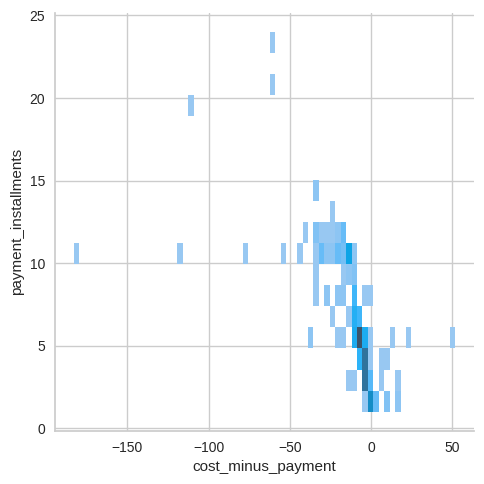

In [84]:
sns.displot(data=diff_stats,
            x='cost_minus_payment',
            y='payment_installments')
plt.show()


It seems we have a linear trend. The difference globally increase with the number of payment installments which could effectively correspond to fees/interests.

Nevertheless, Some payments are lower than the total price of the order (price + freight values). 

And when there is only one payment installment, there should not be fees.

In [85]:
diff_stats.query(ds.or_query_instruction(
    'order_status', ['shipped', 'canceled']))


cost_minus_payment  payment_installments  \
1cd8d1567debd198821fe9d46d99b5b1              -25.12                  13.0   
dc6b76e937308e88a3464d0f4352b959               -5.99                   5.0   
ee38b45af2d4e705a88a37af7f0cda97               -6.89                   5.0   
f090de1b2ed9f4e251662cb31e3c7127               -0.92                   2.0   

                                 order_status  total_order_cost  
1cd8d1567debd198821fe9d46d99b5b1     canceled            104.88  
dc6b76e937308e88a3464d0f4352b959      shipped             46.00  
ee38b45af2d4e705a88a37af7f0cda97     canceled             52.84  
f090de1b2ed9f4e251662cb31e3c7127      shipped             26.71

Nothing particular here.

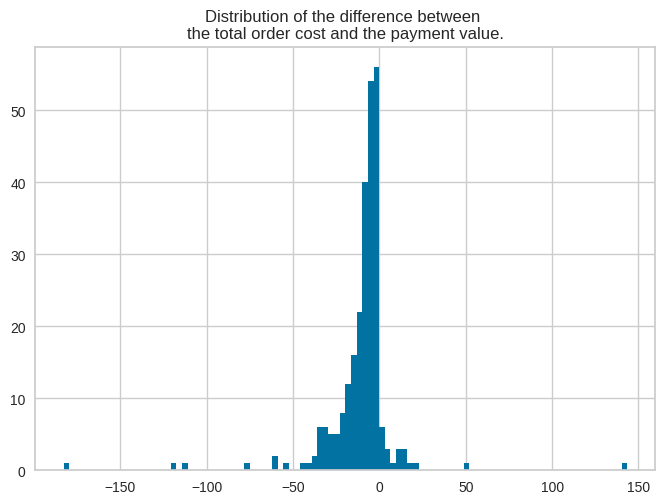

In [86]:
diff_stats.cost_minus_payment.hist(bins=100)
plt.title('Distribution of the difference between \n'
          'the total order cost and the payment value.')
plt.show()


When there is an inconsistency, It usually is the client that pays more than what is due. 
But some opposite cases sometimes occur!

In [87]:
diff_stats.query('payment_installments == 1')


cost_minus_payment  payment_installments  \
05d5a67b06f86425711075939a164657               -0.61                   1.0   
2240d9349c55949c40dbfcc98ece280c               -0.36                   1.0   
4387477eec4b3c89b39f3f454940d059                9.90                   1.0   
5af817dcc7682f13101dbdef134be4e0               -1.33                   1.0   
6508f1528c3648c8a9f751e811520269               -0.60                   1.0   
6cff0c3dacf64bb7cb2ad584b81b7d0d                2.60                   1.0   
6dcf0aeb8b1eb4021c26e1d0e9394979               14.95                   1.0   
6e57e23ecac1ae881286657694444267               16.50                   1.0   
6fa0c125ee7d870f6602c97e33d87bc5                1.60                   1.0   
8092da256aefda13b330290d2ca86521               10.39                   1.0   
882634702ad671a4a28319adef8f058b                1.00                   1.0   
8ccbe46ffeae4720eba99d2d2de07542               -1.55                   1.0   
aa6bd33ba1853d846d3085a88ae37083               10.00                   1.0   
c8bedae351d76a3163c9840172c1285f                2.99                   1.0   
e73fe43cdcd166f7f0c6e3c2bf11a917                2.50                   1.0   
ed4116f3f55e67e9a26b9f1891ba2497                3.90                   1.0   
f1c86b9191896bcf9077ec22b6248153               -1.80                   1.0   

                                 order_status  total_order_cost  
05d5a67b06f86425711075939a164657    delivered             17.77  
2240d9349c55949c40dbfcc98ece280c    delivered             94.59  
4387477eec4b3c89b39f3f454940d059    delivered            231.92  
5af817dcc7682f13101dbdef134be4e0    delivered             44.09  
6508f1528c3648c8a9f751e811520269    delivered             50.10  
6cff0c3dacf64bb7cb2ad584b81b7d0d    delivered             33.43  
6dcf0aeb8b1eb4021c26e1d0e9394979    delivered            333.92  
6e57e23ecac1ae881286657694444267    delivered            350.41  
6fa0c125ee7d870f6602c97e33d87bc5    delivered             47.31  
8092da256aefda13b330290d2ca86521    delivered            115.65  
882634702ad671a4a28319adef8f058b    delivered             17.38  
8ccbe46ffeae4720eba99d2d2de07542    delivered             28.75  
aa6bd33ba1853d846d3085a88ae37083    delivered             35.14  
c8bedae351d76a3163c9840172c1285f    delivered             37.37  
e73fe43cdcd166f7f0c6e3c2bf11a917    delivered             59.00  
ed4116f3f55e67e9a26b9f1891ba2497    delivered            161.47  
f1c86b9191896bcf9077ec22b6248153    delivered             55.80

Those are payments not corresponding to the order cost. When > 0, the client did not pay
the total cost. When negative, he paid too much.

In [88]:
# investigate large negative values.
df.query('cost_minus_payment < -100').query('order_status == "delivered"')


customer_id                customer_unique_id  \
11463  5263febf1413e9a60ceb7b842008b7ef  6f90ec5150be36c4475835b5941ab56f   
11464  5263febf1413e9a60ceb7b842008b7ef  6f90ec5150be36c4475835b5941ab56f   
11465  5263febf1413e9a60ceb7b842008b7ef  6f90ec5150be36c4475835b5941ab56f   
11466  5263febf1413e9a60ceb7b842008b7ef  6f90ec5150be36c4475835b5941ab56f   
11467  5263febf1413e9a60ceb7b842008b7ef  6f90ec5150be36c4475835b5941ab56f   
11468  5263febf1413e9a60ceb7b842008b7ef  6f90ec5150be36c4475835b5941ab56f   
65600  d8acb46c718975948423dbf1b603b959  3629a4b18f2eb69e03f153158e48d2cc   
81954  0c155574f4f4d27594dbdd37731a6ecb  b8b3c435a58aebd788a477bed8342910   

       customer_zip_code_prefix  customer_city customer_state  \
11463                     82980       curitiba             PR   
11464                     82980       curitiba             PR   
11465                     82980       curitiba             PR   
11466                     82980       curitiba             PR   
11467                     82980       curitiba             PR   
11468                     82980       curitiba             PR   
65600                     78580  alta floresta             MT   
81954                     95585  arroio do sal             RS   

                               order_id order_status order_purchase_timestamp  \
11463  6e5fe7366a2e1bfbf3257dba0af1267f    delivered      2016-10-09 22:36:25   
11464  6e5fe7366a2e1bfbf3257dba0af1267f    delivered      2016-10-09 22:36:25   
11465  6e5fe7366a2e1bfbf3257dba0af1267f    delivered      2016-10-09 22:36:25   
11466  6e5fe7366a2e1bfbf3257dba0af1267f    delivered      2016-10-09 22:36:25   
11467  6e5fe7366a2e1bfbf3257dba0af1267f    delivered      2016-10-09 22:36:25   
11468  6e5fe7366a2e1bfbf3257dba0af1267f    delivered      2016-10-09 22:36:25   
65600  ce6d150fb29ada17d2082f4847107665    delivered      2018-01-25 11:17:02   
81954  70b742795bc441e94a44a084b6d9ce7a    delivered      2017-08-24 10:29:36   

        order_approved_at order_delivered_carrier_date  \
11463 2016-10-10 12:02:19          2016-10-14 12:02:21   
11464 2016-10-10 12:02:19          2016-10-14 12:02:21   
11465 2016-10-10 12:02:19          2016-10-14 12:02:21   
11466 2016-10-10 12:02:19          2016-10-14 12:02:21   
11467 2016-10-10 12:02:19          2016-10-14 12:02:21   
11468 2016-10-10 12:02:19          2016-10-14 12:02:21   
65600 2018-01-27 12:35:38          2018-01-29 18:32:40   
81954 2017-08-24 10:35:22          2017-08-30 15:28:21   

      order_delivered_customer_date order_estimated_delivery_date  \
11463           2016-10-17 13:02:21                    2016-12-06   
11464           2016-10-17 13:02:21                    2016-12-06   
11465           2016-10-17 13:02:21                    2016-12-06   
11466           2016-10-17 13:02:21                    2016-12-06   
11467           2016-10-17 13:02:21                    2016-12-06   
11468           2016-10-17 13:02:21                    2016-12-06   
65600           2018-02-21 17:38:51                    2018-03-08   
81954           2017-09-12 20:27:39                    2017-09-20   

       order_item_id                        product_id  \
11463            1.0  7721582bb750762d81850267d19881c1   
11464            2.0  65bb78cf0bbc3ca6406f30e6793736f9   
11465            3.0  7721582bb750762d81850267d19881c1   
11466            4.0  65bb78cf0bbc3ca6406f30e6793736f9   
11467            5.0  7721582bb750762d81850267d19881c1   
11468            6.0  65bb78cf0bbc3ca6406f30e6793736f9   
65600            1.0  638bbb2a5e4f360b71f332ddfebfd672   
81954            1.0  1dd284c37ca97cbb86c029c65fb9a494   

                              seller_id  shipping_limit_date    price  \
11463  0c8380b62e38e8a1e6adbeba7eb9688c  2016-10-14 12:02:21    19.83   
11464  391fc6631aebcf3004804e51b40bcf1e  2016-10-14 12:02:20    39.90   
11465  0c8380b62e38e8a1e6adbeba7eb9688c  2016-10-14 12:02:21    19.83   
11466  391fc6631aebcf3004804e51b40bcf1e  2016-10-14 12:02:

Those cases where the client paid much more than the initial order cost seem plausible because it concerns expensive orders paid in several times.

### 2.5.3.  [&#9650;](#toc0_) <a id='toc2_5_3_'></a>Personal note

In [89]:
# generating total payment value from the order_payments dataframe
# would have probably been much easier and faster
ex4 = order_payments.groupby('order_id').filter(lambda x: len(x) == 29)
display(ex4.sort_values("payment_sequential"))
ex4_total_payment = ex4.payment_value.sum()
ex4_total_payment


order_id  payment_sequential payment_type  \
14321   fa65dad1b0e818e3ccc5cb0e39231352                   1      voucher   
23074   fa65dad1b0e818e3ccc5cb0e39231352                   2      voucher   
65641   fa65dad1b0e818e3ccc5cb0e39231352                   3      voucher   
9985    fa65dad1b0e818e3ccc5cb0e39231352                   4      voucher   
28330   fa65dad1b0e818e3ccc5cb0e39231352                   5      voucher   
29648   fa65dad1b0e818e3ccc5cb0e39231352                   6      voucher   
82593   fa65dad1b0e818e3ccc5cb0e39231352                   7      voucher   
68853   fa65dad1b0e818e3ccc5cb0e39231352                   8      voucher   
17274   fa65dad1b0e818e3ccc5cb0e39231352                   9      voucher   
19565   fa65dad1b0e818e3ccc5cb0e39231352                  10      voucher   
32519   fa65dad1b0e818e3ccc5cb0e39231352                  11      voucher   
73537   fa65dad1b0e818e3ccc5cb0e39231352                  12      voucher   
77885   fa65dad1b0e818e3ccc5cb0e39231352                  13      voucher   
36822   fa65dad1b0e818e3ccc5cb0e39231352                  14      voucher   
63369   fa65dad1b0e818e3ccc5cb0e39231352                  15      voucher   
78050   fa65dad1b0e818e3ccc5cb0e39231352                  16      voucher   
79670   fa65dad1b0e818e3ccc5cb0e39231352                  17      voucher   
80321   fa65dad1b0e818e3ccc5cb0e39231352                  18      voucher   
74721   fa65dad1b0e818e3ccc5cb0e39231352                  19      voucher   
93337   fa65dad1b0e818e3ccc5cb0e39231352                  20      voucher   
74239   fa65dad1b0e818e3ccc5cb0e39231352                  21      voucher   
100606  fa65dad1b0e818e3ccc5cb0e39231352                  22      voucher   
85166   fa65dad1b0e818e3ccc5cb0e39231352                  23      voucher   
99213   fa65dad1b0e818e3ccc5cb0e39231352                  24      voucher   
24879   fa65dad1b0e818e3ccc5cb0e39231352                  25      voucher   
79587   fa65dad1b0e818e3ccc5cb0e39231352                  26      voucher   
4885    fa65dad1b0e818e3ccc5cb0e39231352                  27      voucher   
39111   fa65dad1b0e818e3ccc5cb0e39231352                  28      voucher   
39108   fa65dad1b0e818e3ccc5cb0e39231352                  29      voucher   

        payment_installments  payment_value  
14321                      1           3.71  
23074                      1           8.51  
65641                      1           2.95  
9985                       1          29.16  
28330                      1           0.66  
29648                      1           5.02  
82593                      1           0.32  
68853                      1          26.02  
17274                      1           1.08  
19565                      1          12.86  
32519                      1           4.03  
73537                      1           3.60  
77885                      1           0.00  
36822                      1           0.00  
63369                      1          14.04  
78050                      1          12.86  
79670                      1           3.72  
80321                      1           0.73  
74721                      1           5.02  
93337                      1         150.00  
74239                      1           4.11  
100606                     1           4.03  
85166                      1          18.86  
99213                      1           0.42  
24879                      1           3.68  
79587                      1          28.27  
4885                       1          66.02  
39111                      1          29.05  
39108                      1          19.26

457.99

In [90]:
(df.query("order_id == 'fa65dad1b0e818e3ccc5cb0e39231352'")
['total_order_cost'].head(1))


30561    457.99
Name: total_order_cost, dtype: float64

## 2.6.  [&#9650;](#toc0_) <a id='toc2_6_'></a>Merged_df <-- order_reviews

In [91]:
df = pt.merge_and_display(df, order_reviews, on="order_id")


shape before merging : (118434, 25)
shape of the right df: (99224, 3)
shape after merging : (119143, 27)


customer_id                      1.000000
customer_unique_id               1.000000
customer_zip_code_prefix         1.000000
customer_city                    1.000000
customer_state                   1.000000
order_id                         1.000000
order_status                     1.000000
order_purchase_timestamp         1.000000
order_approved_at                0.998514
order_delivered_carrier_date     0.982492
order_delivered_customer_date    0.971287
order_estimated_delivery_date    1.000000
order_item_id                    0.993008
product_id                       0.993008
seller_id                        0.993008
shipping_limit_date              0.993008
price                            0.993008
freight_value                    0.993008
payment_sequential               0.999975
payment_type                     0.999975
payment_installments             0.999975
payment_value                    0.999975
total_order_cost                 1.000000
total_payment_value              1

As we see the length is increasing, that means there sometimes are multiple reviews for a same row?

In [92]:
# Getting similar rows without considering the review information
cols = df.columns.drop(['review_id', 'review_score'])
same_rows = df.loc[df.duplicated(cols, keep=False)]
same_rows.head(10)


customer_id                customer_unique_id  \
511  0e772d9e02b17408e716f35cd1dcc222  b09f1bff1aff13c997af071602bc048b   
512  0e772d9e02b17408e716f35cd1dcc222  b09f1bff1aff13c997af071602bc048b   
513  0e772d9e02b17408e716f35cd1dcc222  b09f1bff1aff13c997af071602bc048b   
514  0e772d9e02b17408e716f35cd1dcc222  b09f1bff1aff13c997af071602bc048b   
515  0e772d9e02b17408e716f35cd1dcc222  b09f1bff1aff13c997af071602bc048b   
516  0e772d9e02b17408e716f35cd1dcc222  b09f1bff1aff13c997af071602bc048b   
517  0e772d9e02b17408e716f35cd1dcc222  b09f1bff1aff13c997af071602bc048b   
518  0e772d9e02b17408e716f35cd1dcc222  b09f1bff1aff13c997af071602bc048b   
620  8d13b315c8e8e3d9011c9e9267cb8a70  63df651d5e8adb6a0e4baeb66a0eea37   
621  8d13b315c8e8e3d9011c9e9267cb8a70  63df651d5e8adb6a0e4baeb66a0eea37   

     customer_zip_code_prefix customer_city customer_state  \
511                      3755     sao paulo             SP   
512                      3755     sao paulo             SP   
513                      3755     sao paulo             SP   
514                      3755     sao paulo             SP   
515                      3755     sao paulo             SP   
516                      3755     sao paulo             SP   
517                      3755     sao paulo             SP   
518                      3755     sao paulo             SP   
620                     16202       birigui             SP   
621                     16202       birigui             SP   

                             order_id order_status order_purchase_timestamp  \
511  c27cd942c2a926d25153090afa106ceb    delivered      2017-06-15 14:26:01   
512  c27cd942c2a926d25153090afa106ceb    delivered      2017-06-15 14:26:01   
513  c27cd942c2a926d25153090afa106ceb    delivered      2017-06-15 14:26:01   
514  c27cd942c2a926d25153090afa106ceb    delivered      2017-06-15 14:26:01   
515  c27cd942c2a926d25153090afa106ceb    delivered      2017-06-15 14:26:01   
516  c27cd942c2a926d25153090afa106ceb    delivered      2017-06-15 14:26:01   
517  c27cd942c2a926d25153090afa106ceb    delivered      2017-06-15 14:26:01   
518  c27cd942c2a926d25153090afa106ceb    delivered      2017-06-15 14:26:01   
620  bbf6a647ecc68aa5e79d2cd75ef44c68    delivered      2017-09-01 10:33:16   
621  bbf6a647ecc68aa5e79d2cd75ef44c68    delivered      2017-09-01 10:33:16   

      order_approved_at order_delivered_carrier_date  \
511 2017-06-15 14:45:15          2017-06-20 14:22:03   
512 2017-06-15 14:45:15          2017-06-20 14:22:03   
513 2017-06-15 14:45:15          2017-06-20 14:22:03   
514 2017-06-15 14:45:15          2017-06-20 14:22:03   
515 2017-06-15 14:45:15          2017-06-20 14:22:03   
516 2017-06-15 14:45:15          2017-06-20 14:22:03   
517 2017-06-15 14:45:15          2017-06-20 14:22:03   
518 2017-06-15 14:45:15          2017-06-20 14:22:03   
620 2017-09-02 10:45:16          2017-09-05 12:33:20   
621 2017-09-02 10:45:16          2017-09-05 12:33:20   

    order_delivered_customer_date order_estimated_delivery_date  \
511           2017-06-26 11:23:32                    2017-07-10   
512           2017-06-26 11:23:32                    2017-07-10   
513           2017-06-26 11:23:32                    2017-07-10   
514           2017-06-26 11:23:32                    2017-07-10   
515           2017-06-26 11:23:32                    2017-07-10   
516           2017-06-26 11:23:32                    2017-07-10   
517           2017-06-26 11:23:32                    2017-07-10   
518           2017-06-26 11:23:32                    2017-07-10   
620           2017-09-13 18:53:49                    2017-09-22   
621           2017-09-13 18:53:49                    2017-09-22   

     order_item_id                        product_id  \
511            1.0  b2fb8ccacff645e701cd692064ad09c9   
512            1.0  b2fb8ccacff645e701cd692064ad09c9   
513            2.0  315c6373ff469f7b7f60bbb36c319f7b   
514            2.0  315c6373ff469f7b7f60bbb36c319f7b   
515         

In [93]:
initial_review_order = pd.read_csv(
    './csv_files/olist_order_reviews_dataset.csv')


In [94]:
initial_review_order.columns


Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [95]:
import random


In [96]:
# Display some cases where there are multiple reviews for an order.
for id in random.choices(same_rows.order_id.unique(), k=20):
    display(initial_review_order.query('order_id == @id'))


review_id                          order_id  \
26254  c343e22f0398de5be948cf578a37af6c  450c49623c365a4edcf0c5a2c93aa7c9   
92017  778826f9af6467ff6268bbcf436cd3c5  450c49623c365a4edcf0c5a2c93aa7c9   

       review_score review_comment_title  \
26254             5                  NaN   
92017             1                  NaN   

                                                                                                                                                            review_comment_message  \
26254  O Primeiro produto veio com defeito. Depois que reclamei enviaram outro rapidamente, em perfeito estado e ainda levei um brinde. Pode confiar, eles respeitam o consumidor!   
92017                                                                                                                                           O produto foi enviado com defeito.   

      review_creation_date review_answer_timestamp  
26254  2017-03-09 00:00:00     2017-03-26 14:18:46  
92017  2017-02-22 00:00:00     2017-02-22 14:05:09

review_id                          order_id  \
24242  dbdf1ea31790c8ecfcc6750525661a9b  fa06c9f04ef55a2a43f2246a0777b7c8   
95848  69228c9ea08f4e0d8b591cc2309f4a5d  fa06c9f04ef55a2a43f2246a0777b7c8   

       review_score review_comment_title  \
24242             1                  NaN   
95848             4                  NaN   

                                                                                                               review_comment_message  \
24242  O produto veio embalado apenas por um frágil envelope, o que ocasionou o fato da caixa do cartucho ficar totalmente destruída.   
95848                                                                                                              Atraso na entrega.   

      review_creation_date review_answer_timestamp  
24242  2018-03-20 00:00:00     2018-03-21 01:02:05  
95848  2018-03-14 00:00:00     2018-03-19 13:05:33

review_id                          order_id  \
8852   873a5bc219517a3b5cde7782127cd823  23a2d8b0357730d4f9c50aa48773e9e9   
40404  29d02d3bf25077ca7e448c746bc85ec4  23a2d8b0357730d4f9c50aa48773e9e9   

       review_score review_comment_title review_comment_message  \
8852              5                  NaN                    NaN   
40404             5                  NaN                    NaN   

      review_creation_date review_answer_timestamp  
8852   2018-04-06 00:00:00     2018-04-07 11:25:14  
40404  2018-03-22 00:00:00     2018-03-23 01:26:53

review_id                          order_id  \
764    c5976a5a98e854fb23d7e03c6754ae60  2002ea16e75277eaa0b5d78632048540   
67673  333d2974ee8afc60e0c501f21ed34b4c  2002ea16e75277eaa0b5d78632048540   

       review_score review_comment_title review_comment_message  \
764               5                  NaN                    NaN   
67673             4                  NaN                    NaN   

      review_creation_date review_answer_timestamp  
764    2017-08-08 00:00:00     2017-08-10 11:11:29  
67673  2017-08-01 00:00:00     2017-08-03 20:51:59

review_id                          order_id  \
33344  ef60daa08e71f279bffca277370f205f  44aa72f4eebc8c0ff7a3636f6369201b   
58846  9d837f1b99a130661e05961824860e69  44aa72f4eebc8c0ff7a3636f6369201b   

       review_score review_comment_title  \
33344             3                  NaN   
58846             3                  NaN   

                                                                                                                                  review_comment_message  \
33344                                                                                                                                                NaN   
58846  Um dos pincéis veio duplicado e outro faltando, e alguns pincéis estava com as pontas amassadas, de forma que não retornará ao formato original.    

      review_creation_date review_answer_timestamp  
33344  2017-06-15 00:00:00     2017-06-16 12:30:59  
58846  2017-06-15 00:00:00     2017-06-16 12:22:48

review_id                          order_id  \
18384  87765b23585f0c7389fd2c0b7cf512eb  ce0102221c8d12a97979c74d09cca282   
70613  06e327fb381850fdd69fba40ad61b2f2  ce0102221c8d12a97979c74d09cca282   

       review_score review_comment_title review_comment_message  \
18384             3                  NaN                    NaN   
70613             2                  NaN                    NaN   

      review_creation_date review_answer_timestamp  
18384  2017-06-03 00:00:00     2017-06-06 11:51:37  
70613  2017-06-02 00:00:00     2017-06-05 14:08:36

review_id                          order_id  \
18575  7d1a556b31dc7aac846bb8d3fae643c1  e706d614326b76f48f24d82f86c0b2ed   
67128  9ce6cc962bdad75923c6d9e26ba708c5  e706d614326b76f48f24d82f86c0b2ed   

       review_score review_comment_title  \
18575             5                  NaN   
67128             5                  NaN   

                                             review_comment_message  \
18575       Produto entregue antes do prazo e em perfeito estado .    
67128  Produto entregue antes do prazo e veio em perfeito estado .    

      review_creation_date review_answer_timestamp  
18575  2017-03-04 00:00:00     2017-03-05 03:49:52  
67128  2017-03-04 00:00:00     2017-03-05 03:47:25

review_id                          order_id  \
19902  34e1fc15273c269b6fd0227340a23bc4  871ea4c791e2d977d094700806eef385   
47526  b61a27573983d8c2d335fefbd283e533  871ea4c791e2d977d094700806eef385   

       review_score review_comment_title review_comment_message  \
19902             1                  NaN                    NaN   
47526             1                  NaN                    NaN   

      review_creation_date review_answer_timestamp  
19902  2018-03-18 00:00:00     2018-03-27 01:26:54  
47526  2018-03-22 00:00:00     2018-03-27 01:25:51

review_id                          order_id  \
47128  5e336718a575cd6067a6cc14f1f3fb3d  ce59496beb223906ab55f6bce7fa86f5   
70337  59294cb7699ef93d259c880d02b00ec1  ce59496beb223906ab55f6bce7fa86f5   

       review_score review_comment_title  \
47128             5                  NaN   
70337             5                  NaN   

                                                                                                                                                                                review_comment_message  \
47128  A culpa foi dos correios, é pena não termos outra opção no nosso país para envio de encomendas. Mas poderiam procurar tambem o setor de cargas das companhias aereas, as vezes sai mais barato.   
70337                                                                                                                                                                                              NaN   

      review_creation_date review_answer_timestamp  
47128  2017-06-22 00:00:00     2017-06-26 13:05:25  
70337  2017-06-17 00:00:00     2017-06-19 20:03:08

review_id                          order_id  \
51601  d8e1bb2dcde149ffc1c0fe9e85ace686  4f68ed0836136db8064bf34ebb1965e2   
56224  ebe731fd857c94fa522bf0e9f4562b71  4f68ed0836136db8064bf34ebb1965e2   

       review_score review_comment_title review_comment_message  \
51601             5                  NaN                  lindo   
56224             3                  NaN                      m   

      review_creation_date review_answer_timestamp  
51601  2017-08-12 00:00:00     2017-08-16 13:10:58  
56224  2017-08-18 00:00:00     2017-08-20 02:46:14

review_id                          order_id  \
65194  5bdf704ce1edc91bc6c73abede903d1c  073fa4be4665f397a289842b1053229c   
89755  55d37f60f12bd5af8b2185dda9ef6dea  073fa4be4665f397a289842b1053229c   

       review_score review_comment_title review_comment_message  \
65194             1                  NaN                    NaN   
89755             5                  NaN                    NaN   

      review_creation_date review_answer_timestamp  
65194  2018-01-24 00:00:00     2018-01-25 10:01:21  
89755  2018-01-24 00:00:00     2018-01-24 20:26:57

review_id                          order_id  \
62006  2aff17b27e1fa4125d6d9e9800b22d07  d0d30d1f6b48c8e1266d9b960dc191d5   
85053  a2b6b252e6ea564223a50a599bae23aa  d0d30d1f6b48c8e1266d9b960dc191d5   

       review_score review_comment_title   review_comment_message  \
62006             3                  NaN           Tudo em ordem.   
85053             3                  NaN  Esperando o resultado..   

      review_creation_date review_answer_timestamp  
62006  2017-08-02 00:00:00     2017-08-02 20:06:46  
85053  2017-08-05 00:00:00     2017-08-05 23:59:49

review_id                          order_id  \
68876  97df0c4378f17442381482348d1029af  c333fbd06019caef9160f4b7ab8547d1   
84060  5fd19c3d05229eb9a93bc839b2536488  c333fbd06019caef9160f4b7ab8547d1   

       review_score review_comment_title  \
68876             5                  NaN   
84060             5                  NaN   

                         review_comment_message review_creation_date  \
68876  ótimo produto e entregue dentro do prazo  2017-06-29 00:00:00   
84060     ótimo produto entregue antes do prazo  2017-06-29 00:00:00   

      review_answer_timestamp  
68876     2017-07-02 22:16:15  
84060     2017-07-02 22:14:46

review_id                          order_id  \
5073   3c2cb00748904de8d82a85bdca2c5ba0  95efc26128229ac33bfc67d4fce8fa28   
77914  f44e22203e35c5ebeef4c6f18004698f  95efc26128229ac33bfc67d4fce8fa28   

       review_score review_comment_title  \
5073              5                  NaN   
77914             5                  NaN   

                                                                                                                                     review_comment_message  \
5073   Chegou antes do prazo. Tudo certinho e muito bem embalado apesar de ser uma peça pequena tiveram todos cuidado pra chegar ao destinatário. PARABÉNS.   
77914                                                                                                          Chegou tudo certinho. Pode comprar sem medo.   

      review_creation_date review_answer_timestamp  
5073   2017-08-29 00:00:00     2017-08-30 10:07:44  
77914  2017-08-30 00:00:00     2017-08-30 22:03:41

review_id                          order_id  \
39813  50a98ec1a6675838f29dd72f2838a373  99ced390cb3920dd78d289dcddfc6ce4   
67949  eb2e7f397d9e41b7d911fd73e92f3d0c  99ced390cb3920dd78d289dcddfc6ce4   

       review_score review_comment_title  \
39813             1                  NaN   
67949             1                  NaN   

                                                             review_comment_message  \
39813  O prazo de entrega já acabou e até agora não recebi, quero cancelar a compra   
67949                                                                           NaN   

      review_creation_date review_answer_timestamp  
39813  2018-02-18 00:00:00     2018-02-20 05:17:17  
67949  2018-02-10 00:00:00     2018-02-12 09:59:50

review_id                          order_id  \
33871  6fbd8ef5367bd723d426167e479c7326  b76e1e63723d846f3382683973908122   
93530  12f2fd663de5670387805fd70ece2e21  b76e1e63723d846f3382683973908122   

       review_score review_comment_title review_comment_message  \
33871             5                  NaN                    NaN   
93530             5                  NaN                    NaN   

      review_creation_date review_answer_timestamp  
33871  2018-08-01 00:00:00     2018-08-08 22:20:22  
93530  2018-07-26 00:00:00     2018-07-29 17:02:57

review_id                          order_id  \
7174   ecbc75f32c2ede5000085adda4db0c6f  6401cfe160d72392195bd6e311a582cd   
90187  d6096704b4ee25d0336dc056f119f70c  6401cfe160d72392195bd6e311a582cd   

       review_score review_comment_title  \
7174              2                  NaN   
90187             2                  NaN   

                                                                                                                                                                               review_comment_message  \
7174   A informação de que o produto chegou não procede. A previsão de que seria entregue dia 16/03, porém o produto apesar de já ter a NF emitida não foi para a transportadora.\r\nAguardo retorno.   
90187                                                                                                Produto consta como entregue aos correios do RJ desde o dia 20/03 e ainda não saiu para entrega.   

      review_creation_date review_answer_timestamp  
7174   2018-03-18 00:00:00     2018-03-19 12:24:16  
90187  2018-03-20 00:00:00     2018-03-22 21:07:04

review_id                          order_id  \
27993  0e249472bec47b0c4b88a8e8bfa8d241  7b994fc7c7528d2098eebcb19d18ce7e   
89671  308fb813a1409451b334c691329a1b42  7b994fc7c7528d2098eebcb19d18ce7e   

       review_score review_comment_title  \
27993             1                  NaN   
89671             1                  NaN   

                                                                          review_comment_message  \
27993  Deveriam contratar transportadora e não correio até o momento não recebi minha encomenda    
89671                                                                                        NaN   

      review_creation_date review_answer_timestamp  
27993  2017-10-01 00:00:00     2017-10-01 04:07:46  
89671  2017-09-27 00:00:00     2017-09-27 20:11:54

review_id                          order_id  \
47288  ed42ec3f63f7ff98ae6fc1562d61d1fe  7e7aa7dd23657ca98b6b94fa4ad4c576   
56665  4cf58a7504fcc216d2f881db83d04c26  7e7aa7dd23657ca98b6b94fa4ad4c576   

       review_score review_comment_title review_comment_message  \
47288             3                  NaN                    NaN   
56665             5                  NaN                    NaN   

      review_creation_date review_answer_timestamp  
47288  2017-09-05 00:00:00     2017-09-06 02:00:35  
56665  2017-09-21 00:00:00     2017-09-22 12:33:37

review_id                          order_id  \
24943  aa12009c1431a5e767b682c2a8a4d6e4  6b9c8c185575db6251ea1e2c699cddd5   
62204  47279c241ba7e123bb5b5175534131e2  6b9c8c185575db6251ea1e2c699cddd5   

       review_score review_comment_title review_comment_message  \
24943             4                  NaN                    NaN   
62204             4                  NaN                    NaN   

      review_creation_date review_answer_timestamp  
24943  2018-02-20 00:00:00     2018-02-22 21:00:35  
62204  2018-02-20 00:00:00     2018-02-20 19:11:48

In [97]:
df.query('order_id =="c88b1d1b157a9999ce368f218a407141"')


customer_id                customer_unique_id  \
16015  ae0fb7b01c548c4fd30f19f55453ec4a  b64ebaf3d11b7209fe566364cc359a51   
16016  ae0fb7b01c548c4fd30f19f55453ec4a  b64ebaf3d11b7209fe566364cc359a51   
16017  ae0fb7b01c548c4fd30f19f55453ec4a  b64ebaf3d11b7209fe566364cc359a51   

       customer_zip_code_prefix          customer_city customer_state  \
16015                      9690  sao bernardo do campo             SP   
16016                      9690  sao bernardo do campo             SP   
16017                      9690  sao bernardo do campo             SP   

                               order_id order_status order_purchase_timestamp  \
16015  c88b1d1b157a9999ce368f218a407141    delivered      2017-07-17 22:44:23   
16016  c88b1d1b157a9999ce368f218a407141    delivered      2017-07-17 22:44:23   
16017  c88b1d1b157a9999ce368f218a407141    delivered      2017-07-17 22:44:23   

        order_approved_at order_delivered_carrier_date  \
16015 2017-07-18 22:50:12          2017-07-20 15:27:41   
16016 2017-07-18 22:50:12          2017-07-20 15:27:41   
16017 2017-07-18 22:50:12          2017-07-20 15:27:41   

      order_delivered_customer_date order_estimated_delivery_date  \
16015           2017-07-21 17:06:30                    2017-08-01   
16016           2017-07-21 17:06:30                    2017-08-01   
16017           2017-07-21 17:06:30                    2017-08-01   

       order_item_id                        product_id  \
16015            1.0  b1acb7e8152c90c9619897753a75c973   
16016            1.0  b1acb7e8152c90c9619897753a75c973   
16017            1.0  b1acb7e8152c90c9619897753a75c973   

                              seller_id  shipping_limit_date  price  \
16015  cc419e0650a3c5ba77189a1882b7556a  2017-07-26 22:50:12  34.99   
16016  cc419e0650a3c5ba77189a1882b7556a  2017-07-26 22:50:12  34.99   
16017  cc419e0650a3c5ba77189a1882b7556a  2017-07-26 22:50:12  34.99   

       freight_value  payment_sequential payment_type  payment_installments  \
16015           7.78                 1.0  credit_card                   4.0   
16016           7.78                 1.0  credit_card                   4.0   
16017           7.78                 1.0  credit_card                   4.0   

       payment_value  total_order_cost  total_payment_value  \
16015          42.77             42.77                42.77   
16016          42.77             42.77                42.77   
16017          42.77             42.77                42.77   

       cost_minus_payment                         review_id  review_score  
16015                 0.0  ffb8cff872a625632ac983eb1f88843c           3.0  
16016                 0.0  202b5f44d09cd3cfc0d6bd12f01b044c           5.0  
16017                 0.0  fb96ea2ef8cce1c888f4d45c8e22b793           5.0

In [98]:
df.query('order_id =="b8fdf0a70040d5461adca8f95ba4171a"')


customer_id                customer_unique_id  \
29504  a56a99918e8686b7d35af612dd30e86e  45df9d71b80f651fcfd26763eebd027a   
29505  a56a99918e8686b7d35af612dd30e86e  45df9d71b80f651fcfd26763eebd027a   

       customer_zip_code_prefix   customer_city customer_state  \
29504                     23942  angra dos reis             RJ   
29505                     23942  angra dos reis             RJ   

                               order_id order_status order_purchase_timestamp  \
29504  b8fdf0a70040d5461adca8f95ba4171a    delivered      2017-12-01 12:18:11   
29505  b8fdf0a70040d5461adca8f95ba4171a    delivered      2017-12-01 12:18:11   

        order_approved_at order_delivered_carrier_date  \
29504 2017-12-02 02:38:25          2017-12-04 17:52:59   
29505 2017-12-02 02:38:25          2017-12-04 17:52:59   

      order_delivered_customer_date order_estimated_delivery_date  \
29504           2018-01-05 17:06:15                    2018-01-04   
29505           2018-01-05 17:06:15                    2018-01-04   

       order_item_id                        product_id  \
29504            1.0  f2f411f86bd5bd427e28e2a30771761f   
29505            1.0  f2f411f86bd5bd427e28e2a30771761f   

                              seller_id  shipping_limit_date  price  \
29504  da8622b14eb17ae2831f4ac5b9dab84a  2017-12-12 02:38:25   89.9   
29505  da8622b14eb17ae2831f4ac5b9dab84a  2017-12-12 02:38:25   89.9   

       freight_value  payment_sequential payment_type  payment_installments  \
29504          17.88                 1.0       boleto                   1.0   
29505          17.88                 1.0       boleto                   1.0   

       payment_value  total_order_cost  total_payment_value  \
29504         107.78            107.78               107.78   
29505         107.78            107.78               107.78   

       cost_minus_payment                         review_id  review_score  
29504                 0.0  ba69d8c9ff524792f380378510bdae64           3.0  
29505                 0.0  854ce3274684322d2ad677b5246530c0           1.0

- review_creation_date : Shows the date in which the satisfaction survey was sent to the customer.
- review_answer_timestamp : Shows satisfaction survey answer timestamp.

***
My hypothesis :

- Olist sometimes send multiple satisfaction surveys (when the client does not answer). 
- One can answer multiple times to the same survey and they sometimes answer several surveys.

Nevertheless, it is strange to see different score and review comments on the same (order, item) done the same day. In that case I could average.

It is understandable that the review changes through time (the seller does a goodwill gesture or conversely the item seemed good when received, but was disappointing after few days of use.) Then, we could choose to average, or keep the last satisfaction.

I think that the mean is simpler to compute, and that it is enough.

I could generate a feature "was disappointed at any moment" before averaging, but I think if I keep track of the average, the min and the max, the information is pretty much there.



In [99]:
same_rows.order_id.nunique()


547

Those remarks only concern a small part of the orders : 547.

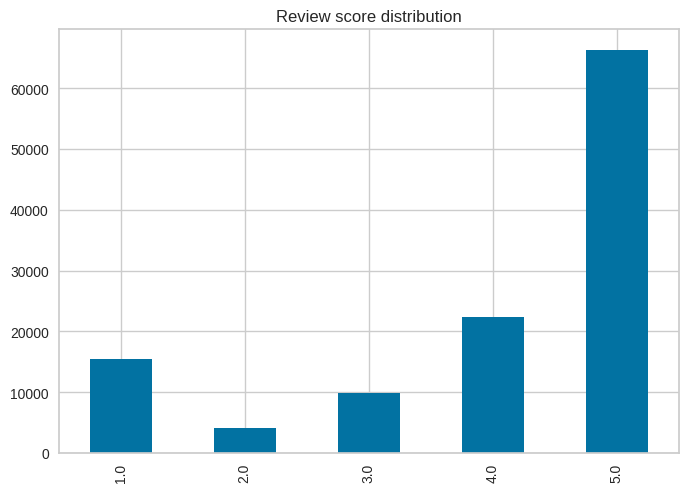

In [100]:
(df.review_score
 .value_counts()
 .sort_index()
 .plot(kind='bar', title="Review score distribution")
 )
plt.show()


## 2.7.  [&#9650;](#toc0_) <a id='toc2_7_'></a>Merged_df <-- products

In [101]:
df = pt.merge_and_display(df, products, on="product_id")


shape before merging : (119143, 27)
shape of the right df: (32951, 2)
shape after merging : (119143, 28)


customer_id                      1.000000
customer_unique_id               1.000000
customer_zip_code_prefix         1.000000
customer_city                    1.000000
customer_state                   1.000000
order_id                         1.000000
order_status                     1.000000
order_purchase_timestamp         1.000000
order_approved_at                0.998514
order_delivered_carrier_date     0.982492
order_delivered_customer_date    0.971287
order_estimated_delivery_date    1.000000
order_item_id                    0.993008
product_id                       0.993008
seller_id                        0.993008
shipping_limit_date              0.993008
price                            0.993008
freight_value                    0.993008
payment_sequential               0.999975
payment_type                     0.999975
payment_installments             0.999975
payment_value                    0.999975
total_order_cost                 1.000000
total_payment_value              1

one_to_one match here

In [102]:
df.product_category_name.value_counts()


cama_mesa_banho                                   11988
beleza_saude                                      10032
esporte_lazer                                      9004
moveis_decoracao                                   8832
informatica_acessorios                             8150
utilidades_domesticas                              7380
relogios_presentes                                 6213
telefonia                                          4726
ferramentas_jardim                                 4590
automotivo                                         4400
brinquedos                                         4281
cool_stuff                                         3999
perfumaria                                         3589
bebes                                              3204
eletronicos                                        2846
papelaria                                          2625
fashion_bolsas_e_acessorios                        2170
pet_shop                                        

In [103]:
# Add english translation
df = pt.merge_and_display(
    df, product_category_name_translation, on="product_category_name")


shape before merging : (119143, 28)
shape of the right df: (71, 2)
shape after merging : (119143, 29)


customer_id                      1.000000
customer_unique_id               1.000000
customer_zip_code_prefix         1.000000
customer_city                    1.000000
customer_state                   1.000000
order_id                         1.000000
order_status                     1.000000
order_purchase_timestamp         1.000000
order_approved_at                0.998514
order_delivered_carrier_date     0.982492
order_delivered_customer_date    0.971287
order_estimated_delivery_date    1.000000
order_item_id                    0.993008
product_id                       0.993008
seller_id                        0.993008
shipping_limit_date              0.993008
price                            0.993008
freight_value                    0.993008
payment_sequential               0.999975
payment_type                     0.999975
payment_installments             0.999975
payment_value                    0.999975
total_order_cost                 1.000000
total_payment_value              1

In [104]:
df.product_category_name_english.value_counts()

bed_bath_table                             11988
health_beauty                              10032
sports_leisure                              9004
furniture_decor                             8832
computers_accessories                       8150
housewares                                  7380
watches_gifts                               6213
telephony                                   4726
garden_tools                                4590
auto                                        4400
toys                                        4281
cool_stuff                                  3999
perfumery                                   3589
baby                                        3204
electronics                                 2846
stationery                                  2625
fashion_bags_accessories                    2170
pet_shop                                    2030
office_furniture                            1788
consoles_games                              1192
luggage_accessories 

## 2.8.  [&#9650;](#toc0_) <a id='toc2_8_'></a>Larger product categories

In [105]:
df.product_category_name_english.unique()

['office_furniture', 'housewares', 'home_confort', 'sports_leisure', 'computers_accessories', ..., 'fashion_sport', 'home_comfort_2', 'arts_and_craftmanship', 'fashion_childrens_clothes', 'security_and_services']
Length: 72
Categories (71, object): ['agro_industry_and_commerce', 'air_conditioning', 'art', 'arts_and_craftmanship', ..., 'tablets_printing_image', 'telephony', 'toys', 'watches_gifts']

customer_id                customer_unique_id  \
41667   9cc2c82001025f49191bc032306d1582  c8b8744cdff8bfb969670e865d94a61a   
250     ce330ffe33e3f344ad5a80b8410c1ced  4df9aee56fa602c72756abb22ee60b17   
91982   06922ee99355bf830408f263ba2c3e10  965b44e284338ef0be919cefaa022669   
44772   1a8b66704e28000bb4868451e12c6b43  f85b721fd7c1363858e29ad2054ac3f7   
20006   36f565da5dace4bd09fa635892eb5fe5  131571305eb6589b2433bbdf69821ddf   
58307   8e5d467a031a1ff1a25f61d18a3315ed  08ce898ac4fbdbfd9cdac1e18689dfc0   
118624  294741bfaf620181357e0e7306681698  5ffbc70da7ad1808b6899421caa84fbe   
44526   9599f5e43a9b54a82ab4392a0c8e94f5  7030164c13386d397107bfdf15f3814f   
46780   0d3740ed03979ba91a9cb4eb6300dd49  21b890a8701db02f2107d0da119edc67   
88483   22d32625b59ff10115c8863926933a99  1d0c477338ae1d1071fd09d848d984a7   

        customer_zip_code_prefix    customer_city customer_state  \
41667                      22461   rio de janeiro             RJ   
250                         6764  taboao da serra             SP   
91982                      22760   rio de janeiro             RJ   
44772                      78093           cuiaba             MT   
20006                      66070            belem             PA   
58307                      18701            avare             SP   
118624                     50670           recife             PE   
44526                      93270           esteio             RS   
46780                      13310              itu             SP   
88483                       2407        sao paulo             SP   

                                order_id order_status  \
41667   39f428ffba2a9207ffb6406237ffe25a    delivered   
250     053180cf4b0cf3f7a300e2e42ff01da9    delivered   
91982   fd97401041e22864ebc2b6b2388d5a8e    delivered   
44772   5acf62946adaf3b74ad395ec44b72688    delivered   
20006   03f51c9adce893f63936c5146701aa2f    delivered   
58307   8dae11cb6c1305e2756cef677ac2f4dc    delivered   
118624  677cebcf344bca22b07250e7548bd8bc    delivered   
44526   231f5faa326e8643dc979ef4dcc9cd31    delivered   
46780   4389819b71f1f23563fa9eadadc12a06    delivered   
88483   327ee18cf93b73d75911ca52f0c73ed4    delivered   

       order_purchase_timestamp   order_approved_at  \
41667       2018-02-22 12:32:29 2018-02-22 12:48:38   
250         2017-12-11 10:06:05 2017-12-11 10:18:28   
91982       2018-02-23 20:39:33 2018-02-23 20:50:33   
44772       2018-03-02 18:50:53 2018-03-03 18:48:33   
20006       2018-06-17 11:03:15 2018-06-18 17:20:26   
58307       2017-07-19 12:26:42 2017-07-19 12:43:46   
118624      2017-05-01 18:11:52 2017-05-01 18:26:01   
44526       2018-08-05 13:33:17 2018-08-05 13:45:14   
46780       2018-04-04 12:47:34 2018-04-04 13:10:03   
88483       2018-02-27 19:38:59 2018-02-27 20:09:31   

       order_delivered_carrier_date order_delivered_customer_date  \
41667           2018-02-27 13:19:50           2018-03-22 23:48:51   
250             2017-12-13 21:33:24           2017-12-27 14:53:40   
91982           2018-02-27 23:06:59           2018-03-17 13:21:00   
44772           2018-03-05 18:08:49           2018-04-19 13:32:29   
20006           2018-06-19 12:59:00           2018-06-28 20:17:06   
58307           2017-07-21 17:15:58           2017-08-01 20:12:09   
118624          2017-05-05 12:32:57           2017-05-23 15:22:26   
44526           2018-08-06 11:05:00           2018-08-15 14:18:29   
46780           2018-04-05 00:33:16           2018-04-11 00:32:30   
88483           2018-03-02 00:33:11           2018-03-05 15:58:40   

       order_estimated_delivery_date  order_item_id  \
41667                     2018-03-15            1.0   
250                       2018-01-04            1.0   
91982                     2018-03-15            1.0   
44772                     2018-03-29            1.0   
20006                     2018-07-24            2.0   
58307                     2017-08-10            1.0   
118624                    2017-06-12      

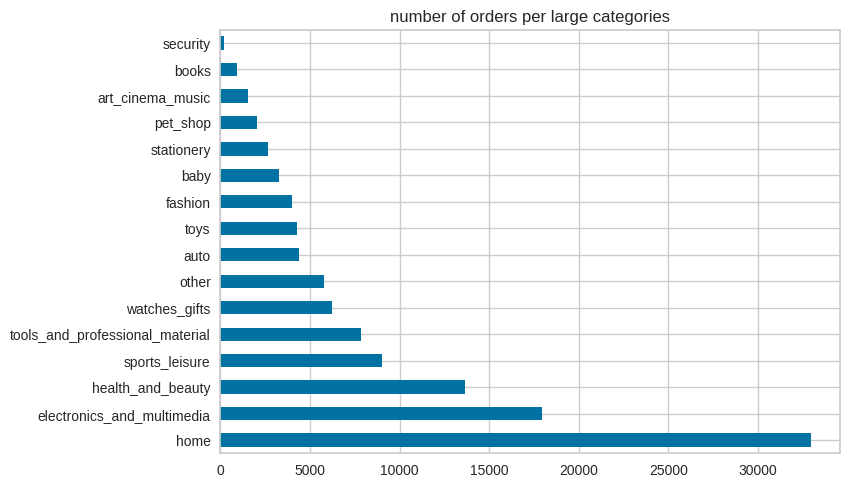

In [106]:
df['large_product_category'] = (df.product_category_name_english
                                .map(pt.map_to_larger_categories))
display(df.sample(10))
df.large_product_category.value_counts().plot(kind='barh')
plt.title('number of orders per large categories')
plt.show()

In [107]:
df.large_product_category.unique()

array(['home', 'sports_leisure', 'electronics_and_multimedia', nan,
       'toys', 'auto', 'tools_and_professional_material',
       'health_and_beauty', 'pet_shop', 'baby', 'watches_gifts',
       'art_cinema_music', 'stationery', 'fashion', 'other', 'books',
       'security'], dtype=object)

## 2.9.  [&#9650;](#toc0_) <a id='toc2_9_'></a>Review score vs status

In [108]:
df.columns


Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'total_order_cost', 'total_payment_value',
       'cost_minus_payment', 'review_id', 'review_score',
       'product_category_name', 'product_category_name_english',
       'large_product_category'],
      dtype='object')

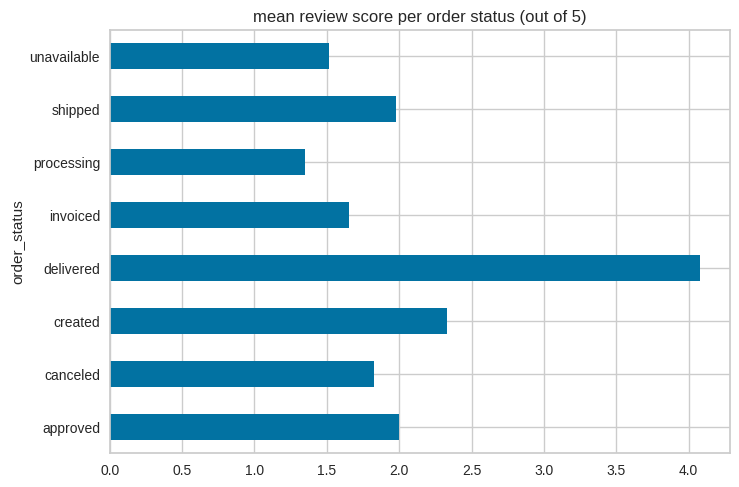

In [109]:
(df.
 groupby('order_status')['review_score']
 .mean()
 .plot(kind='barh', title="mean review score per order status (out of 5)")
 )
plt.show()


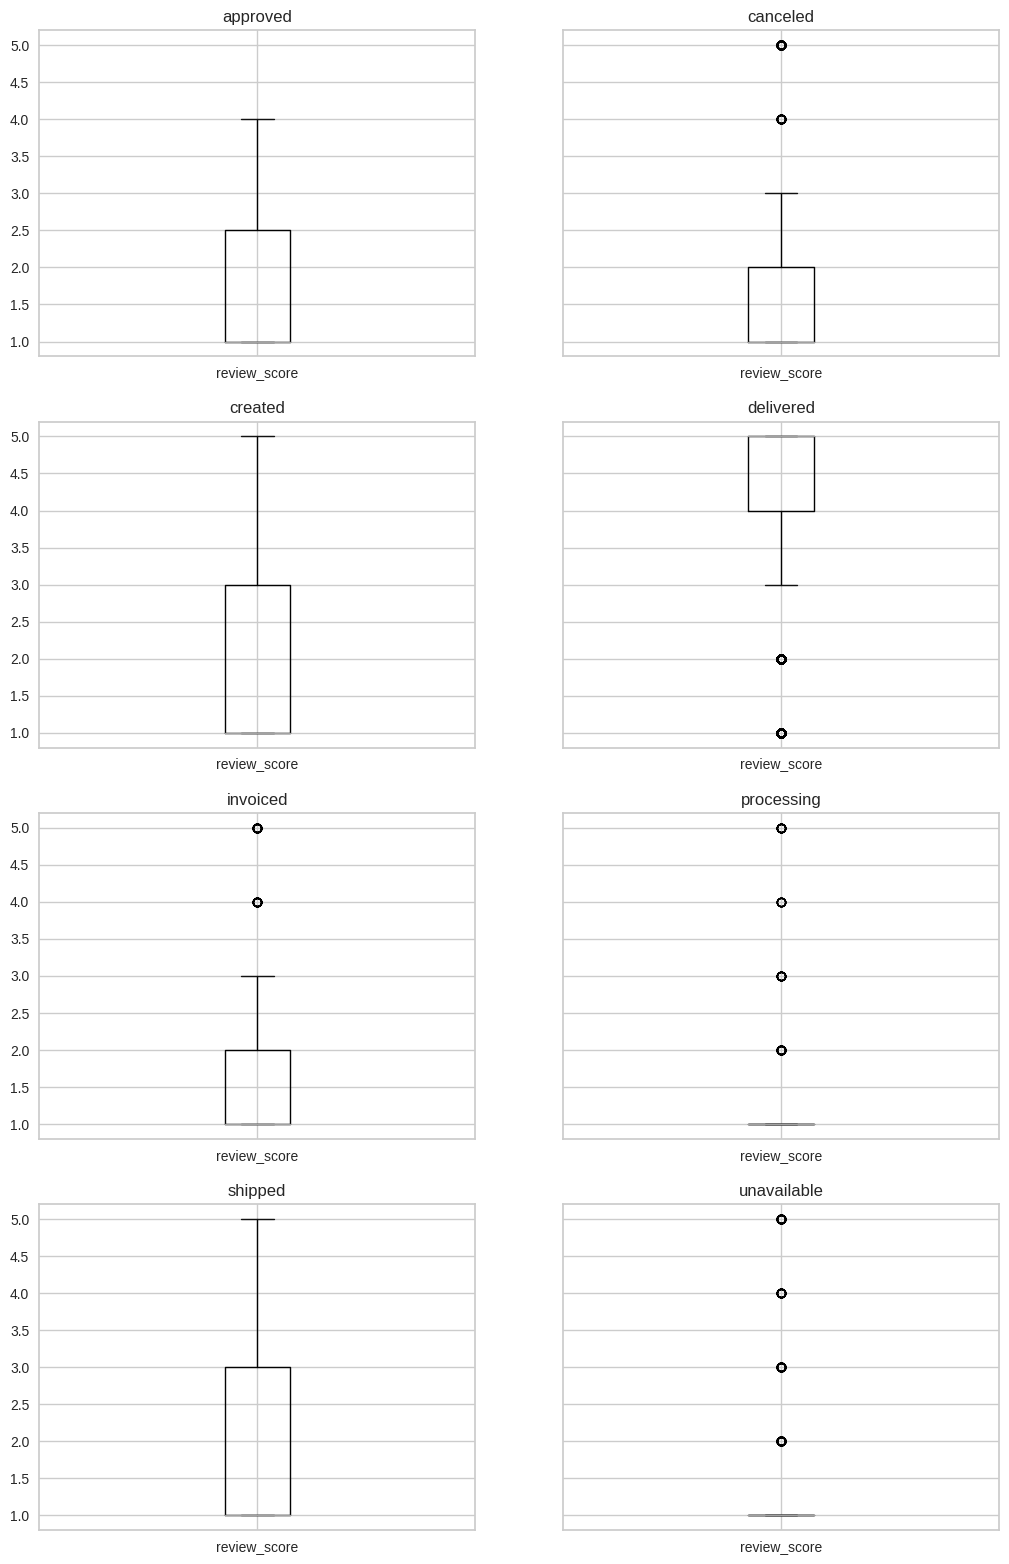

In [110]:
(df.
 groupby('order_status')
 .boxplot(column=['review_score'], figsize=(12, 20), layout=(4, 2))
 )
plt.show()


Unavailable and processing are what frustrate the most the clients. But globally, it is almost as frustrating as it gets with unavailable for every order status, except for delivered. thus, I could create a larger order_status with only two groups : delivered and not delivered.

In [111]:
df['binary_order_status'] = 'not_delivered'
df.loc[df.order_status == 'delivered', 'binary_order_status'] = 'delivered'

## 2.10.  [&#9650;](#toc0_) <a id='toc2_10_'></a>Addressing problems in the merged_df

### 2.10.1.  [&#9650;](#toc0_) <a id='toc2_10_1_'></a>Category problems

In [112]:
df.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 177
order_delivered_carrier_date     2086
order_delivered_customer_date    3421
order_estimated_delivery_date       0
order_item_id                     833
product_id                        833
seller_id                         833
shipping_limit_date               833
price                             833
freight_value                     833
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
total_order_cost                    0
total_payment_value                 0
cost_minus_payment                  0
review_id                         997
review_score

In [121]:
# Fill unknown categories
cat_cols = ['product_category_name',
            'product_category_name_english',
            'large_product_category']

df.loc[:, cat_cols] = (df.loc[:, cat_cols]
                       .apply(lambda x: x.astype('str'), axis=1)
                       .replace('nan', 'unknown'))

In [122]:
df.large_product_category.value_counts()

home                               32957
electronics_and_multimedia         17926
health_and_beauty                  13621
sports_leisure                      9004
tools_and_professional_material     7871
watches_gifts                       6213
other                               5772
auto                                4400
toys                                4281
fashion                             3989
baby                                3243
stationery                          2625
unknown                             2567
pet_shop                            2030
art_cinema_music                    1542
books                                899
security                             203
Name: large_product_category, dtype: int64

### 2.10.2.  [&#9650;](#toc0_) <a id='toc2_10_2_'></a>No item info problems

In [123]:
no_item_info = df.loc[df.order_item_id.isnull()]
no_item_info.head()

customer_id                customer_unique_id  \
52   f34a6e874087ec1f0e3dab9fdf659c5d  233896de79986082f1f479f1f85281cb   
341  5bfe800011656c0afb81db64519982db  0071f46a072a9ae25bbe4438b15efe9c   
438  b08064e24083fee8fbe8797902b07ecd  035f60af6e7d7f78470e9443be08d339   
448  536f46cc0f2f2b1e40d056f7998f0254  340152332a04149987a705602615f0d0   
661  8118922685d2e2c0205f060be4f2579c  d0e87d00021530383c16452a39a393ba   

     customer_zip_code_prefix customer_city customer_state  \
52                      38300     ituiutaba             MG   
341                     16011     aracatuba             SP   
438                     28495       aperibe             RJ   
448                     87030       maringa             PR   
661                     45810  porto seguro             BA   

                             order_id order_status order_purchase_timestamp  \
52   6e98de3a85c84ead6689189b825d35b5     canceled      2018-03-15 10:07:02   
341  df8c077268f7f3baaac0892eb3143642  unavailable      2017-02-01 00:04:17   
438  c609f82bcf7a90292a5940205ebd7e93  unavailable      2018-05-13 16:45:55   
448  cb4a79c1e6c9ae44302861e7602cc449  unavailable      2017-12-06 15:46:07   
661  af264f3527e94e431f0dcd56cd6b406d  unavailable      2017-07-12 14:49:11   

      order_approved_at order_delivered_carrier_date  \
52  2018-03-15 10:29:33                          NaT   
341 2017-02-01 00:30:55                          NaT   
438 2018-05-13 17:11:58                          NaT   
448 2017-12-06 15:57:29                          NaT   
661 2017-07-12 15:04:10                          NaT   

    order_delivered_customer_date order_estimated_delivery_date  \
52                            NaT                    2018-04-09   
341                           NaT                    2017-03-10   
438                           NaT                    2018-06-05   
448                           NaT                    2018-01-03   
661                           NaT                    2017-08-11   

     order_item_id product_id seller_id shipping_limit_date  price  \
52             NaN        NaN       NaN                 NaN    NaN   
341            NaN        NaN       NaN                 NaN    NaN   
438            NaN        NaN       NaN                 NaN    NaN   
448            NaN        NaN       NaN                 NaN    NaN   
661            NaN        NaN       NaN                 NaN    NaN   

     freight_value  payment_sequential payment_type  payment_installments  \
52             NaN                 1.0  credit_card                   1.0   
341            NaN                 1.0  credit_card                   4.0   
438            NaN                 1.0  credit_card                   2.0   
448            NaN                 1.0  credit_card                   1.0   
661            NaN                 1.0  credit_card                   1.0   

     payment_value  total_order_cost  total_payment_value  cost_minus_payment  \
52           73.16               0.0                73.16              -73.16   
341         174.54               0.0               174.54             -174.54   
438         117.78               0.0               117.78             -117.78   
448          66.02               0.0                66.02              -66.02   
661          46.69               0.0                46.69              -46.69   

                            review_id  review_score product_category_name  \
52   e76cda681b681b65fffa28dfc0030641           1.0               unknown   
341  3f793c533cf5b3e21425b1ab73568350           3.0               unknown   
438  2c849b1f2ee43364af4923d48b9f0943           1.0               unknown   
448  4d3c61768eb47216ecf732bbbd8bef3c           1.0               unknown   
661  609ce0b03d6d69c4b43a55e91bf422a8           5.0               unknown   

    product_category_name_english large_product_category binary_order_status  
52                        unknown                unknown       not_deliver

In [124]:
no_item_info.binary_order_status.value_counts()

not_delivered    833
Name: binary_order_status, dtype: int64

In [125]:
no_item_info.order_status.value_counts()

unavailable    645
canceled       180
created          5
invoiced         2
shipped          1
approved         0
delivered        0
processing       0
Name: order_status, dtype: int64

I can let those nulls as it will not bother me later (will not use those columns in the clustering models). It is good to remember they almost all happen because the order has been canceled or unavailable.

In [126]:
no_item_info.query(ds.or_query_instruction("order_status", ['created', 'invoiced', 'shipped']))

customer_id                customer_unique_id  \
15653   4ee64f4bfc542546f422da0aeb462853  10d5890ed5e7ec78a7db23b5ac579b17   
54298   7d61b9f4f216052ba664f22e9c504ef1  161e5b2b4513edb336986a8909218365   
61253   964a6df3d9bdf60fe3e7b8bb69ed893a  2e015e68fbfa36910263df5384e8e45c   
65235   d7bed5fac093a4136216072abaf599d5  f15a952dfc52308d0361288fbf42c7b3   
81441   b2d7ae0415dbbca535b5f7b38056dd1f  6a2da481aa7827b951175772a0fe8bb8   
92467   0d00d77134cae4c58695086ad8d85100  8886115442775dd8a20c2dcc921c7cc8   
95033   438449d4af8980d107bf04571413a8e7  55fbb57fd54c35a38c80c2a032a6ca6e   
104652  725e9c75605414b21fd8c8d5a1c2f1d6  355862aa14375fe3950ee04fef9c7a53   

        customer_zip_code_prefix    customer_city customer_state  \
15653                      93025     sao leopoldo             RS   
54298                      87720        paranavai             PR   
61253                      73401         brasilia             DF   
65235                      91250     porto alegre             RS   
81441                      16012        aracatuba             SP   
92467                      88070    florianopolis             SC   
95033                      15300  general salgado             SP   
104652                     22621   rio de janeiro             RJ   

                                order_id order_status  \
15653   35de4050331c6c644cddc86f4f2d0d64      created   
54298   90ab3e7d52544ec7bc3363c82689965f      created   
61253   dba5062fbda3af4fb6c33b1e040ca38f      created   
65235   a68ce1686d536ca72bd2dadc4b8671e5      shipped   
81441   2ce9683175cdab7d1c95bcbb3e36f478     invoiced   
92467   e04f1da1f48bf2bbffcf57b9824f76e1     invoiced   
95033   b5359909123fa03c50bdb0cfed07f098      created   
104652  7a4df5d8cff4090e541401a20a22bb80      created   

       order_purchase_timestamp   order_approved_at  \
15653       2017-12-05 01:07:58                 NaT   
54298       2017-11-06 13:12:34                 NaT   
61253       2018-02-09 17:21:04                 NaT   
65235       2016-10-05 01:47:40 2016-10-07 03:11:22   
81441       2016-10-05 21:03:33 2016-10-06 07:46:39   
92467       2016-10-05 13:22:20 2016-10-06 15:51:38   
95033       2017-12-05 01:07:52                 NaT   
104652      2017-11-25 11:10:33                 NaT   

       order_delivered_carrier_date order_delivered_customer_date  \
15653                           NaT                           NaT   
54298                           NaT                           NaT   
61253                           NaT                           NaT   
65235           2016-11-07 16:37:37                           NaT   
81441                           NaT                           NaT   
92467                           NaT                           NaT   
95033                           NaT                           NaT   
104652                          NaT                           NaT   

       order_estimated_delivery_date  order_item_id product_id seller_id  \
15653                     2018-01-08            NaN        NaN       NaN   
54298                     2017-12-01            NaN        NaN       NaN   
61253                     2018-03-07            NaN        NaN       NaN   
65235                     2016-12-01            NaN        NaN       NaN   
81441                     2016-11-25            NaN        NaN       NaN   
92467                     2016-11-29            NaN        NaN       NaN   
95033                     2018-01-11            NaN        NaN       NaN   
104652                    2017-12-12            NaN        NaN       NaN   

       shipping_limit_date  price  freight_value  payment_sequential  \
15653                  NaN    NaN            NaN                 1.0   
54298                  NaN    NaN            NaN                 1.0   
61253                  NaN    NaN            NaN                 1.0   
65235                  NaN    NaN            NaN                 1.0   
81441                  NaN    NaN   

### 2.10.3.  [&#9650;](#toc0_) <a id='toc2_10_3_'></a>No review problems

In [127]:
no_reviews = df.loc[df.review_score.isnull()]
no_reviews.head()

customer_id                customer_unique_id  \
18   9b8ce803689b3562defaad4613ef426f  7f3a72e8f988c6e735ba118d54f47458   
19   9b8ce803689b3562defaad4613ef426f  7f3a72e8f988c6e735ba118d54f47458   
264  265655cf1f2dfd4fc630004d1fe5f3cb  fc0a9229ea43fea6c9f9d79c06761a1e   
268  d6b41b191f1f643ff583898156e049cf  3a62a4803c77457a96c996a9db36a662   
594  befe184e4eb181470e6063a1a368a093  6ac6902b78ed854e42f75c8e25234e8c   

     customer_zip_code_prefix customer_city customer_state  \
18                       5416     sao paulo             SP   
19                       5416     sao paulo             SP   
264                     13185   hortolandia             SP   
268                     28375     varre-sai             RJ   
594                      4704     sao paulo             SP   

                             order_id order_status order_purchase_timestamp  \
18   17825f24877a9289214c301ae0c9424b    delivered      2017-05-11 13:48:47   
19   17825f24877a9289214c301ae0c9424b    delivered      2017-05-11 13:48:47   
264  44918cef2a112fc3f8e4a9b676e5ab23      shipped      2018-02-06 22:08:09   
268  1237d70df58d4f9a8bd929b9943f9b8a    delivered      2017-10-09 09:58:11   
594  e91a3bc14b8d125d82f0334371c39926    delivered      2018-08-27 17:01:43   

      order_approved_at order_delivered_carrier_date  \
18  2017-05-13 11:55:16          2017-05-15 15:30:02   
19  2017-05-13 11:55:16          2017-05-15 15:30:02   
264 2018-02-06 22:15:42          2018-02-07 22:45:44   
268 2017-10-10 04:06:11          2017-11-17 14:19:55   
594 2018-08-27 17:10:27          2018-08-28 14:56:00   

    order_delivered_customer_date order_estimated_delivery_date  \
18            2017-06-07 12:02:14                    2017-05-30   
19            2017-06-07 12:02:14                    2017-05-30   
264                           NaT                    2018-03-12   
268           2017-12-05 16:47:02                    2017-11-06   
594           2018-08-29 20:04:52                    2018-08-31   

     order_item_id                        product_id  \
18             1.0  99a4788cb24856965c36a24e339b6058   
19             1.0  99a4788cb24856965c36a24e339b6058   
264            1.0  d2f1978552a7604790fa5922f4345998   
268            1.0  3e6f2d0265ff6265eb639a8d3027f5a3   
594            1.0  2715967684d6991f7501693bfe08c08b   

                            seller_id  shipping_limit_date  price  \
18   4a3ca9315b744ce9f8e9374361493884  2017-05-19 11:55:16   89.9   
19   4a3ca9315b744ce9f8e9374361493884  2017-05-19 11:55:16   89.9   
264  ac3508719a1d8f5b7614b798f70af136  2018-02-12 22:15:42  109.9   
268  6219ba2359cfb97f2e38fd4c321eb309  2017-10-17 05:06:11   58.0   
594  0eaa7e33d73809f1f925f7d07c506cbd  2018-08-29 17:10:27   45.0   

     freight_value  payment_sequential payment_type  payment_installments  \
18           12.13                 2.0      voucher                   1.0   
19           12.13                 1.0  credit_card                   1.0   
264          15.53                 1.0  credit_card                   6.0   
268          17.66                 1.0       boleto                   1.0   
594           8.48                 1.0  credit_card                   1.0   

     payment_value  total_order_cost  total_payment_value  cost_minus_payment  \
18           34.05            102.03               102.03                 0.0   
19           67.98            102.03               102.03                 0.0   
264         125.43            125.43               125.43                 0.0   
268          75.66             75.66                75.66                 0.0   
594          53.48             53.48                53.48                 0.0   

    review_id  review_score  product_category_name  \
18        NaN           NaN        cama_mesa_banho   
19        NaN           NaN        cama_mesa_banho   
264       NaN           NaN              papelaria   
268       NaN           NaN  utilidades_domesticas   
594       NaN  

In [128]:
no_reviews.order_status.value_counts()

delivered      861
shipped         88
canceled        20
unavailable     14
invoiced         6
processing       6
created          2
approved         0
Name: order_status, dtype: int64

As seen in the previous section, review score has 2 main trends. 

Around 4 in average when delivered and 2 when not delivered. So I will input those values.

In [129]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'total_order_cost', 'total_payment_value',
       'cost_minus_payment', 'review_id', 'review_score',
       'product_category_name', 'product_category_name_english',
       'large_product_category', 'binary_order_status'],
      dtype='object')

In [130]:
mask = (df.binary_order_status == "delivered") & (df.review_score.isnull())
df.loc[mask, 'review_score'] = 4

mask = (df.binary_order_status == "not_delivered") & (df.review_score.isnull())
df.loc[mask, 'review_score'] = 2

### 2.10.4.  [&#9650;](#toc0_) <a id='toc2_10_4_'></a>payment type problems

In [131]:
pb = df.loc[df.payment_type.isnull()]
pb

customer_id                customer_unique_id  \
25365  86dc2ffce2dfff336de2f386a786e574  830d5b7aaa3b6f1e9ad63703bec97d23   
25366  86dc2ffce2dfff336de2f386a786e574  830d5b7aaa3b6f1e9ad63703bec97d23   
25367  86dc2ffce2dfff336de2f386a786e574  830d5b7aaa3b6f1e9ad63703bec97d23   

       customer_zip_code_prefix         customer_city customer_state  \
25365                     14600  sao joaquim da barra             SP   
25366                     14600  sao joaquim da barra             SP   
25367                     14600  sao joaquim da barra             SP   

                               order_id order_status order_purchase_timestamp  \
25365  bfbd0f9bdef84302105ad712db648a6c    delivered      2016-09-15 12:16:38   
25366  bfbd0f9bdef84302105ad712db648a6c    delivered      2016-09-15 12:16:38   
25367  bfbd0f9bdef84302105ad712db648a6c    delivered      2016-09-15 12:16:38   

        order_approved_at order_delivered_carrier_date  \
25365 2016-09-15 12:16:38          2016-11-07 17:11:53   
25366 2016-09-15 12:16:38          2016-11-07 17:11:53   
25367 2016-09-15 12:16:38          2016-11-07 17:11:53   

      order_delivered_customer_date order_estimated_delivery_date  \
25365           2016-11-09 07:47:38                    2016-10-04   
25366           2016-11-09 07:47:38                    2016-10-04   
25367           2016-11-09 07:47:38                    2016-10-04   

       order_item_id                        product_id  \
25365            1.0  5a6b04657a4c5ee34285d1e4619a96b4   
25366            2.0  5a6b04657a4c5ee34285d1e4619a96b4   
25367            3.0  5a6b04657a4c5ee34285d1e4619a96b4   

                              seller_id  shipping_limit_date  price  \
25365  ecccfa2bb93b34a3bf033cc5d1dcdc69  2016-09-19 23:11:33  44.99   
25366  ecccfa2bb93b34a3bf033cc5d1dcdc69  2016-09-19 23:11:33  44.99   
25367  ecccfa2bb93b34a3bf033cc5d1dcdc69  2016-09-19 23:11:33  44.99   

       freight_value  payment_sequential payment_type  payment_installments  \
25365           2.83                 NaN          NaN                   NaN   
25366           2.83                 NaN          NaN                   NaN   
25367           2.83                 NaN          NaN                   NaN   

       payment_value  total_order_cost  total_payment_value  \
25365            NaN            143.46                  0.0   
25366            NaN            143.46                  0.0   
25367            NaN            143.46                  0.0   

       cost_minus_payment                         review_id  review_score  \
25365              143.46  6916ca4502d6d3bfd39818759d55d536           1.0   
25366              143.46  6916ca4502d6d3bfd39818759d55d536           1.0   
25367              143.46  6916ca4502d6d3bfd39818759d55d536           1.0   

      product_category_name product_category_name_english  \
25365          beleza_saude                 health_beauty   
25366          beleza_saude                 health_beauty   
25367          beleza_saude                 health_beauty   

      large_product_category binary_order_status  
25365      health_and_beauty           delivered  
25366      health_and_beauty           delivered  
25367      health_and_beauty           delivered

In [132]:
(44.99 + 2.83) * 3 == 143.46

True

Then, there was no installments, and I will impute that client with modes of the data set.

In [133]:
cols = ['payment_sequential',
        'payment_type',
        'payment_installments',
        'payment_value']

df[cols].mode()

payment_sequential payment_type  payment_installments  payment_value
0                 1.0  credit_card                   1.0           50.0

In [134]:
pb.payment_sequential = 1.0
pb.payment_type = 'credit_card'
pb.payment_installments = 1.0
pb.payment_value = (44.99+ 2.83)
pb.total_payment_value = (44.99+ 2.83) * 3
pb.cost_minus_payment = 0
pb

/tmp/ipykernel_3688/1732069897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pb.payment_sequential = 1.0
/tmp/ipykernel_3688/1732069897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pb.payment_type = 'credit_card'
/tmp/ipykernel_3688/1732069897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

customer_id                customer_unique_id  \
25365  86dc2ffce2dfff336de2f386a786e574  830d5b7aaa3b6f1e9ad63703bec97d23   
25366  86dc2ffce2dfff336de2f386a786e574  830d5b7aaa3b6f1e9ad63703bec97d23   
25367  86dc2ffce2dfff336de2f386a786e574  830d5b7aaa3b6f1e9ad63703bec97d23   

       customer_zip_code_prefix         customer_city customer_state  \
25365                     14600  sao joaquim da barra             SP   
25366                     14600  sao joaquim da barra             SP   
25367                     14600  sao joaquim da barra             SP   

                               order_id order_status order_purchase_timestamp  \
25365  bfbd0f9bdef84302105ad712db648a6c    delivered      2016-09-15 12:16:38   
25366  bfbd0f9bdef84302105ad712db648a6c    delivered      2016-09-15 12:16:38   
25367  bfbd0f9bdef84302105ad712db648a6c    delivered      2016-09-15 12:16:38   

        order_approved_at order_delivered_carrier_date  \
25365 2016-09-15 12:16:38          2016-11-07 17:11:53   
25366 2016-09-15 12:16:38          2016-11-07 17:11:53   
25367 2016-09-15 12:16:38          2016-11-07 17:11:53   

      order_delivered_customer_date order_estimated_delivery_date  \
25365           2016-11-09 07:47:38                    2016-10-04   
25366           2016-11-09 07:47:38                    2016-10-04   
25367           2016-11-09 07:47:38                    2016-10-04   

       order_item_id                        product_id  \
25365            1.0  5a6b04657a4c5ee34285d1e4619a96b4   
25366            2.0  5a6b04657a4c5ee34285d1e4619a96b4   
25367            3.0  5a6b04657a4c5ee34285d1e4619a96b4   

                              seller_id  shipping_limit_date  price  \
25365  ecccfa2bb93b34a3bf033cc5d1dcdc69  2016-09-19 23:11:33  44.99   
25366  ecccfa2bb93b34a3bf033cc5d1dcdc69  2016-09-19 23:11:33  44.99   
25367  ecccfa2bb93b34a3bf033cc5d1dcdc69  2016-09-19 23:11:33  44.99   

       freight_value  payment_sequential payment_type  payment_installments  \
25365           2.83                 1.0  credit_card                   1.0   
25366           2.83                 1.0  credit_card                   1.0   
25367           2.83                 1.0  credit_card                   1.0   

       payment_value  total_order_cost  total_payment_value  \
25365          47.82            143.46               143.46   
25366          47.82            143.46               143.46   
25367          47.82            143.46               143.46   

       cost_minus_payment                         review_id  review_score  \
25365                   0  6916ca4502d6d3bfd39818759d55d536           1.0   
25366                   0  6916ca4502d6d3bfd39818759d55d536           1.0   
25367                   0  6916ca4502d6d3bfd39818759d55d536           1.0   

      product_category_name product_category_name_english  \
25365          beleza_saude                 health_beauty   
25366          beleza_saude                 health_beauty   
25367          beleza_saude                 health_beauty   

      large_product_category binary_order_status  
25365      health_and_beauty           delivered  
25366      health_and_beauty           delivered  
25367      health_and_beauty           delivered

In [135]:
df.loc[25365:25367, :] = pb

In [136]:
df.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 177
order_delivered_carrier_date     2086
order_delivered_customer_date    3421
order_estimated_delivery_date       0
order_item_id                     833
product_id                        833
seller_id                         833
shipping_limit_date               833
price                             833
freight_value                     833
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
total_order_cost                    0
total_payment_value                 0
cost_minus_payment                  0
review_id                         997
review_score

In [137]:
df.to_csv('merged_df.csv.gz', index=False)

In [66]:
df = pd.read_csv('merged_df.csv.gz')

# recast dates because nulls were introduced, thus changing the dtype
orders_date_columns = ['order_purchase_timestamp',
                       'order_approved_at',
                       'order_delivered_carrier_date',
                       'order_delivered_customer_date',
                       'order_estimated_delivery_date']

for col in orders_date_columns:
    df.loc[:, col] = pd.to_datetime(df[col])

df.info()


/tmp/ipykernel_7013/3756619453.py:11: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col] = pd.to_datetime(df[col])
/tmp/ipykernel_7013/3756619453.py:11: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col] = pd.to_datetime(df[col])
/tmp/ipykernel_7013/3756619453.py:11: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    119143 non-null  object        
 1   customer_unique_id             119143 non-null  object        
 2   customer_zip_code_prefix       119143 non-null  int64         
 3   customer_city                  119143 non-null  object        
 4   customer_state                 119143 non-null  object        
 5   order_id                       119143 non-null  object        
 6   order_status                   119143 non-null  object        
 7   order_purchase_timestamp       119143 non-null  datetime64[ns]
 8   order_approved_at              118966 non-null  datetime64[ns]
 9   order_delivered_carrier_date   117057 non-null  datetime64[ns]
 10  order_delivered_customer_date  115722 non-null  datetime64[ns]
 11  

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Features engineering

## 3.1.  [&#9650;](#toc0_) <a id='toc3_1_'></a>Design on 5 clients example

In [101]:
# Search some clients ids (complex enough for testing purpose)
n = 0
for name, group in df.groupby("customer_unique_id").__iter__():
    if (len(group) > 10) & (group.groupby('order_id').ngroups >= 2):
        print(name)
        n += 1
        if n == 3:
            break


07ff81a9676efa0286ddd3f09e7c0063
096e351116755fe4c3c1e48eaf301a41
0f5ac8d5c31de21d2f25e24be15bbffb


In [102]:
df.query("cost_minus_payment > 0.05").head()


customer_id                customer_unique_id  \
2092  fcb4cecebc159e210cd769d5b767d113  aef59fd9f7310b6ea1600876c510024f   
2420  3a412111e4f293539eae05b502fc63de  f7c20fc3dc5222bc4389740958175652   
6388  4f061e67c05a2736e7c07286ff3fa787  fded88a1576bd3a1383116738e43fb6c   
9744  02ae654741ad895368bd9ffc371893e5  507f6af076decee5860e7b57d23ca4aa   
9745  02ae654741ad895368bd9ffc371893e5  507f6af076decee5860e7b57d23ca4aa   

      customer_zip_code_prefix   customer_city customer_state  \
2092                     22230  rio de janeiro             RJ   
2420                      8220       sao paulo             SP   
6388                     71927        brasilia             DF   
9744                      4547       sao paulo             SP   
9745                      4547       sao paulo             SP   

                              order_id order_status order_purchase_timestamp  \
2092  6fa0c125ee7d870f6602c97e33d87bc5    delivered      2018-08-09 19:32:42   
2420  e73fe43cdcd166f7f0c6e3c2bf11a917    delivered      2018-08-09 18:06:43   
6388  aa6bd33ba1853d846d3085a88ae37083    delivered      2018-08-10 21:36:37   
9744  320dcf288de15e4ff06ebbfce4e42c78    delivered      2018-08-26 08:40:36   
9745  320dcf288de15e4ff06ebbfce4e42c78    delivered      2018-08-26 08:40:36   

       order_approved_at order_delivered_carrier_date  \
2092 2018-08-20 15:59:54          2018-08-14 15:43:00   
2420 2018-08-20 15:57:28          2018-08-14 14:48:00   
6388 2018-08-10 21:50:23          2018-08-13 15:18:00   
9744 2018-08-26 08:50:10          2018-08-27 14:53:00   
9745 2018-08-26 08:50:10          2018-08-27 14:53:00   

     order_delivered_customer_date order_estimated_delivery_date  \
2092           2018-08-17 20:51:25                    2018-08-23   
2420           2018-08-15 15:46:38                    2018-08-16   
6388           2018-08-17 17:04:32                    2018-08-23   
9744           2018-08-30 17:38:41                    2018-09-10   
9745           2018-08-30 17:38:41                    2018-09-10   

      order_item_id                        product_id  \
2092            1.0  70e0c10acc3dd72e17f2136ddb027317   
2420            1.0  544c14365db76307e0820a1468ed8114   
6388            1.0  4f45fa1109c51a1b799a8fe7a3f9a854   
9744            1.0  a1b35ee994b8c571119976c30aa07efe   
9745            2.0  c9676685ee3aec26dd274549d54b85f6   

                             seller_id  shipping_limit_date  price  \
2092  ce27a3cc3c8cc1ea79d11e561e9bebb6  2018-08-15 16:31:14  31.99   
2420  334cab711dee080b079fa5779b584783  2018-08-15 16:31:14  49.90   
6388  0ea22c1cfbdc755f86b9b54b39c16043  2018-08-14 21:50:23  19.90   
9744  709e16e2b25c7474d980076c6bfc4806  2018-08-29 08:50:10  29.90   
9745  709e16e2b25c7474d980076c6bfc4806  2018-08-29 08:50:10  31.90   

      freight_value  payment_sequential payment_type  payment_installments  \
2092          15.32                 1.0   debit_card                   1.0   
2420           9.10                 1.0   debit_card                   1.0   
6388          15.24                 1.0  credit_card                   1.0   
9744          12.88                 1.0  credit_card                   3.0   
9745          12.87                 1.0  credit_card                   3.0   

      payment_value  total_order_cost  total_payment_value  \
2092          45.71             47.31                45.71   
2420          56.50             59.00                56.50   
6388          25.14             35.14                25.14   
9744          81.37             87.55                81.37   
9745          81.37             87.55                81.37   

      cost_minus_payment                         review_id  review_score  \
2092                1.60  6dbe30770adf8a80fee0512a152c8c71           4.0   
2420                2.50  07356e089552984948d612ea0899245b           5.0   
6388               10.00  66af6c5a072d8c70f22b4ad05245bf28           5.0   
9744                6.18  88a2f90d03

In [103]:
# Create and displaying those clients (client1, ..., client4)
clients_id = ["0058f300f57d7b93c477a131a59b36c3",
              "00cc12a6d8b578b8ebd21ea4e2ae8b27",
              "0f5ac8d5c31de21d2f25e24be15bbffb",
              "6fbc7cdadbb522125f4b27ae9dee4060",
              "fded88a1576bd3a1383116738e43fb6c",]

for n, client_id in enumerate(clients_id):
    var_name = "client" + str(n+1)
    print(var_name)
    print(client_id)
    exec(var_name
         + " = df.query('customer_unique_id == @client_id')")
    display(eval(var_name))

# Join them in a dict
example_clients = {("client" + str(n)): eval("client" + str(n))
                   for n in range(1, len(clients_id)+1)}


client1
0058f300f57d7b93c477a131a59b36c3


customer_id                customer_unique_id  \
43561  8ac44e9c15d396b8c3c7cbab0fff4536  0058f300f57d7b93c477a131a59b36c3   
43562  8ac44e9c15d396b8c3c7cbab0fff4536  0058f300f57d7b93c477a131a59b36c3   
73597  f530197ea86ced9488a03d055e118ebf  0058f300f57d7b93c477a131a59b36c3   

       customer_zip_code_prefix customer_city customer_state  \
43561                     41370      salvador             BA   
43562                     41370      salvador             BA   
73597                     40731      salvador             BA   

                               order_id order_status order_purchase_timestamp  \
43561  81a93b2fa39e104b865b2bc471c16008    delivered      2018-03-22 18:09:41   
43562  81a93b2fa39e104b865b2bc471c16008    delivered      2018-03-22 18:09:41   
73597  2cfc79d9582e9135c0a9b61fa60e6b21     canceled      2018-02-19 17:11:34   

        order_approved_at order_delivered_carrier_date  \
43561 2018-03-22 18:27:58          2018-03-23 22:28:51   
43562 2018-03-22 18:27:58          2018-03-23 22:28:51   
73597 2018-02-19 17:20:52          2018-02-20 18:58:43   

      order_delivered_customer_date order_estimated_delivery_date  \
43561           2018-04-04 23:05:57                    2018-04-16   
43562           2018-04-04 23:05:57                    2018-04-16   
73597                           NaT                    2018-03-15   

       order_item_id                        product_id  \
43561            1.0  4630761de87581e8b659dc77bb7eb4ee   
43562            1.0  4630761de87581e8b659dc77bb7eb4ee   
73597            1.0  6bd248f93425ceeb625a8a97e2404112   

                              seller_id  shipping_limit_date  price  \
43561  dbc22125167c298ef99da25668e1011f  2018-03-28 18:27:58  72.58   
43562  dbc22125167c298ef99da25668e1011f  2018-03-28 18:27:58  72.58   
73597  dbc22125167c298ef99da25668e1011f  2018-02-23 17:20:52  59.90   

       freight_value  payment_sequential payment_type  payment_installments  \
43561          23.44                 1.0      voucher                   1.0   
43562          23.44                 2.0      voucher                   1.0   
73597          19.66                 1.0      voucher                   1.0   

       payment_value  total_order_cost  total_payment_value  \
43561          79.56             96.02                96.02   
43562          16.46             96.02                96.02   
73597          79.56             79.56                79.56   

       cost_minus_payment                         review_id  review_score  \
43561                 0.0  a68ed61c3df4e6277c6cecfc8d7fb46c           5.0   
43562                 0.0  a68ed61c3df4e6277c6cecfc8d7fb46c           5.0   
73597                 0.0  3f7f1106182dd7f37642b8a3385314c6           1.0   

      product_category_name product_category_name_english  \
43561      malas_acessorios           luggage_accessories   
43562      malas_acessorios           luggage_accessories   
73597             papelaria                    stationery   

      large_product_category  
43561                fashion  
43562                fashion  
73597             stationery

client2
00cc12a6d8b578b8ebd21ea4e2ae8b27


customer_id                customer_unique_id  \
797    102fc0966044243157bb81e4ee0a251e  00cc12a6d8b578b8ebd21ea4e2ae8b27   
798    102fc0966044243157bb81e4ee0a251e  00cc12a6d8b578b8ebd21ea4e2ae8b27   
10771  c0a44bf37d5601228051fc07852f951f  00cc12a6d8b578b8ebd21ea4e2ae8b27   
10772  c0a44bf37d5601228051fc07852f951f  00cc12a6d8b578b8ebd21ea4e2ae8b27   

       customer_zip_code_prefix customer_city customer_state  \
797                        3178     sao paulo             SP   
798                        3178     sao paulo             SP   
10771                      3178     sao paulo             SP   
10772                      3178     sao paulo             SP   

                               order_id order_status order_purchase_timestamp  \
797    d61b915b69851aec8a8865f36cfd793e    delivered      2017-03-21 19:25:23   
798    d61b915b69851aec8a8865f36cfd793e    delivered      2017-03-21 19:25:23   
10771  64307ceb91666760cf3ff463618302fd    delivered      2017-03-21 19:25:22   
10772  64307ceb91666760cf3ff463618302fd    delivered      2017-03-21 19:25:22   

        order_approved_at order_delivered_carrier_date  \
797   2017-03-21 19:25:23          2017-03-23 16:00:01   
798   2017-03-21 19:25:23          2017-03-23 16:00:01   
10771 2017-03-21 19:25:22          2017-03-22 11:23:35   
10772 2017-03-21 19:25:22          2017-03-22 11:23:35   

      order_delivered_customer_date order_estimated_delivery_date  \
797             2017-03-28 14:54:11                    2017-04-07   
798             2017-03-28 14:54:11                    2017-04-07   
10771           2017-03-27 11:30:19                    2017-04-11   
10772           2017-03-27 11:30:19                    2017-04-11   

       order_item_id                        product_id  \
797              1.0  48ee9be392f28ae3a64518a070f4d06a   
798              1.0  48ee9be392f28ae3a64518a070f4d06a   
10771            1.0  60d49071f68566b7254c39a7d4ea5c1c   
10772            1.0  60d49071f68566b7254c39a7d4ea5c1c   

                              seller_id  shipping_limit_date  price  \
797    4a3ca9315b744ce9f8e9374361493884  2017-03-27 19:25:23   69.9   
798    4a3ca9315b744ce9f8e9374361493884  2017-03-27 19:25:23   69.9   
10771  d66c305afaec317ebee552073a674429  2017-03-27 19:25:22   29.9   
10772  d66c305afaec317ebee552073a674429  2017-03-27 19:25:22   29.9   

       freight_value  payment_sequential payment_type  payment_installments  \
797            11.88                 1.0       boleto                   1.0   
798            11.88                 1.0       boleto                   1.0   
10771          14.52                 1.0       boleto                   1.0   
10772          14.52                 1.0       boleto                   1.0   

       payment_value  total_order_cost  total_payment_value  \
797            81.78             81.78                81.78   
798            81.78             81.78                81.78   
10771          44.42             44.42                44.42   
10772          44.42             44.42                44.42   

       cost_minus_payment                         review_id  review_score  \
797                   0.0  dcecf8e3ba584a9ebe49439490a914bb           5.0   
798                   0.0  59168ad031faf4d695bd0b532c8dc8c9           3.0   
10771                 0.0  dcecf8e3ba584a9ebe49439490a914bb           5.0   
10772                 0.0  59168ad031faf4d695bd0b532c8dc8c9           3.0   

      product_category_name product_category_name_english  \
797         cama_mesa_banho                bed_bath_table   
798         cama_mesa_banho                bed_bath_table   
10771      eletrodomesticos               home_appliances   
10772      eletrodomesticos               home_appliances   

      large_product_category  
797                     home  
798                     home  
10771                   home  
10772                   home

client3
0f5ac8d5c31de21d2f25e24be15bbffb


customer_id                customer_unique_id  \
38199  8bd7ecb3d48667fd8781870e2333dd3b  0f5ac8d5c31de21d2f25e24be15bbffb   
38200  8bd7ecb3d48667fd8781870e2333dd3b  0f5ac8d5c31de21d2f25e24be15bbffb   
38201  8bd7ecb3d48667fd8781870e2333dd3b  0f5ac8d5c31de21d2f25e24be15bbffb   
94002  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94003  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94004  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94005  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94006  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94007  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94008  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94009  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94010  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94011  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94012  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94013  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94014  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94015  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   
94016  10de381f8a8d23fff822753305f71cae  0f5ac8d5c31de21d2f25e24be15bbffb   

       customer_zip_code_prefix     customer_city customer_state  \
38199                     84600  uniao da vitoria             PR   
38200                     84600  uniao da vitoria             PR   
38201                     84600  uniao da vitoria             PR   
94002                     84600  uniao da vitoria             PR   
94003                     84600  uniao da vitoria             PR   
94004                     84600  uniao da vitoria             PR   
94005                     84600  uniao da vitoria             PR   
94006                     84600  uniao da vitoria             PR   
94007                     84600  uniao da vitoria             PR   
94008                     84600  uniao da vitoria             PR   
94009                     84600  uniao da vitoria             PR   
94010                     84600  uniao da vitoria             PR   
94011                     84600  uniao da vitoria             PR   
94012                     84600  uniao da vitoria             PR   
94013                     84600  uniao da vitoria             PR   
94014                     84600  uniao da vitoria             PR   
94015                     84600  uniao da vitoria             PR   
94016                     84600  uniao da vitoria             PR   

                               order_id order_status order_purchase_timestamp  \
38199  55f72a4c8e4ca95e4ffdd60cbbec8c68    delivered      2017-11-27 12:57:35   
38200  55f72a4c8e4ca95e4ffdd60cbbec8c68    delivered      2017-11-27 12:57:35   
38201  55f72a4c8e4ca95e4ffdd60cbbec8c68    delivered      2017-11-27 12:57:35   
94002  428a2f660dc84138d969ccd69a0ab6d5    delivered      2017-11-23 20:30:52   
94003  428a2f660dc84138d969ccd69a0ab6d5    delivered      2017-11-23 20:30:52   
94004  428a2f660dc84138d969ccd69a0ab6d5    delivered      2017-11-23 20:30:52   
94005  428a2f660dc84138d969ccd69a0ab6d5    delivered      2017-11-23 20:30:52   
94006  428a2f660dc84138d969ccd69a0ab6d5    delivered      2017-11-23 20:30:52   
94007  428a2f660dc84138d969ccd69a0ab6d5    delivered      2017-11-23 20:30:52   
94008  428a2f660dc84138d969ccd69a0ab6d5    delivered      2017-11-23 20:30:52   
94009  428a2f660dc84138d969ccd69a0ab6d5    delivered      2017-11-23 20:30:52   
94010  428a2f660dc84138d969ccd69a0ab6d5    delivered      2017-11-23 20:30:52   
94011  428a2f660dc84138d969ccd69a0ab6d5    delivered      2017-11-23 20:30:52   
94012  428a2f660dc84138d969ccd69a0ab6d5    delivered      2017-11-23 20:30:52   
94013  428a2f660dc84138d969ccd69a0ab6d5    delivered    

client4
6fbc7cdadbb522125f4b27ae9dee4060


customer_id                customer_unique_id  \
58729  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58730  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58731  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58732  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58733  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58734  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58735  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58736  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58737  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58738  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58739  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58740  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58741  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58742  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58743  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58744  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58745  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58746  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58747  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58748  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58749  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58750  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58751  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58752  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58753  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58754  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58755  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58756  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58757  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58758  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58759  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58760  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58761  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58762  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58763  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58764  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58765  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58766  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   

       customer_zip_code_prefix   customer_city customer_state  \
58729                     23070  rio de janeiro             RJ   
58730                     23070  rio de janeiro             RJ   
58731                     23070  rio de janeiro             RJ   
58732                     23070  rio de janeiro             RJ   
58733                     23070  rio de janeiro             RJ   
58734                     23070  rio de janeiro             RJ   
58735                     23070  rio de janeiro             RJ   
58736                     23070  rio de janeiro             RJ   
58737                     23070  rio de janeiro             RJ   
58738                     23070  rio de janeiro             RJ   
58739                     23070  rio de janeiro             RJ   
58740                     23070  rio de janeiro             RJ   
58741                     23070  rio de janeiro             RJ   
58742                     23070  rio de janeiro             RJ   
58743                     23070  r

client5
fded88a1576bd3a1383116738e43fb6c


customer_id                customer_unique_id  \
6388  4f061e67c05a2736e7c07286ff3fa787  fded88a1576bd3a1383116738e43fb6c   

      customer_zip_code_prefix customer_city customer_state  \
6388                     71927      brasilia             DF   

                              order_id order_status order_purchase_timestamp  \
6388  aa6bd33ba1853d846d3085a88ae37083    delivered      2018-08-10 21:36:37   

       order_approved_at order_delivered_carrier_date  \
6388 2018-08-10 21:50:23          2018-08-13 15:18:00   

     order_delivered_customer_date order_estimated_delivery_date  \
6388           2018-08-17 17:04:32                    2018-08-23   

      order_item_id                        product_id  \
6388            1.0  4f45fa1109c51a1b799a8fe7a3f9a854   

                             seller_id  shipping_limit_date  price  \
6388  0ea22c1cfbdc755f86b9b54b39c16043  2018-08-14 21:50:23   19.9   

      freight_value  payment_sequential payment_type  payment_installments  \
6388          15.24                 1.0  credit_card                   1.0   

      payment_value  total_order_cost  total_payment_value  \
6388          25.14             35.14                25.14   

      cost_minus_payment                         review_id  review_score  \
6388                10.0  66af6c5a072d8c70f22b4ad05245bf28           5.0   

            product_category_name product_category_name_english  \
6388  fashion_bolsas_e_acessorios      fashion_bags_accessories   

     large_product_category  
6388                fashion

In [254]:
### CODE WHICH COULD EVENTUALLY BE USE TO SPEED UP PANDA'S GROUPBY
class Groupby:
    def __init__(self, keys):
        _, self.keys_as_int = np.unique(keys, return_inverse=True)
        self.n_keys = max(self.keys_as_int) + 1
        self.set_indices()

    def set_indices(self):
        self.indices = [[] for i in range(self.n_keys)]
        for i, k in enumerate(self.keys_as_int):
            self.indices[k].append(i)
        self.indices = [np.array(elt) for elt in self.indices]

    def apply(self, function, vector, broadcast):
        if broadcast:
            result = np.zeros(len(vector))
            for idx in self.indices:
                result[idx] = function(vector[idx])
        else:
            result = np.zeros(self.n_keys)
            for k, idx in enumerate(self.indices):
                result[self.keys_as_int[k]] = function(vector[idx])

        return result


In [255]:
# Features I want to generate :
fts = ['monetary_value_sum',
       'monetary_value_mean_per_order',
       'number_of_purchases_per_year',
       'total_number_of_purchases'
       'number_of_purchases_last_trimester',
       'number_of_purchases_last_month',
       'elapsed_time_since_last_purchase',
       'max_number_of_items_ordered',
       'min_number_of_items_ordered',
       'mean_number_of_items_per_order',
       'non_approved_at_least_once',
       'review_score_mean',
       'review_score_min',
       'review_score_max',
       'paid_less_than_due',
       'has_had_a_non_delivered_order',
       'contracted_payment_installments',
       # TODO : with a groupby on items. will be computationaly heavy except if I pre_processed that like I did for total order cost for example.
       'dominant_product_category_investment',
       # I can avoid group by with a size test. Not sure it will be faster though
       'second_dominant_product_category',
       'third_dominant_product_category',]


In [256]:
# Needed columns in the merged df for that
cols = ["order_status",
        "order_purchase_timestamp",
        "total_order_cost",
        "cost_minus_payment",
        "review_score",
        "order_item_id",
        'payment_installments',
        "product_category_name_english",
        ]


In [257]:
for client_name, client_info in example_clients.items():
    print(client_name)
    display(pt.client_orders_summary(client_info))


client1


order_status order_purchase_timestamp  \
order_id                                                                 
2cfc79d9582e9135c0a9b61fa60e6b21     canceled      2018-02-19 17:11:34   
81a93b2fa39e104b865b2bc471c16008    delivered      2018-03-22 18:09:41   

                                  total_order_cost  cost_minus_payment  \
order_id                                                                 
2cfc79d9582e9135c0a9b61fa60e6b21             79.56                 0.0   
81a93b2fa39e104b865b2bc471c16008             96.02                 0.0   

                                  number_of_items  review_score_min  \
order_id                                                              
2cfc79d9582e9135c0a9b61fa60e6b21              1.0               1.0   
81a93b2fa39e104b865b2bc471c16008              1.0               5.0   

                                  review_score_mean  review_score_max  \
order_id                                                                
2cfc79d9582e9135c0a9b61fa60e6b21                1.0               1.0   
81a93b2fa39e104b865b2bc471c16008                5.0               5.0   

                                  payment_installments  
order_id                                                
2cfc79d9582e9135c0a9b61fa60e6b21                   1.0  
81a93b2fa39e104b865b2bc471c16008                   1.0

client2


order_status order_purchase_timestamp  \
order_id                                                                 
64307ceb91666760cf3ff463618302fd    delivered      2017-03-21 19:25:22   
d61b915b69851aec8a8865f36cfd793e    delivered      2017-03-21 19:25:23   

                                  total_order_cost  cost_minus_payment  \
order_id                                                                 
64307ceb91666760cf3ff463618302fd             44.42                 0.0   
d61b915b69851aec8a8865f36cfd793e             81.78                 0.0   

                                  number_of_items  review_score_min  \
order_id                                                              
64307ceb91666760cf3ff463618302fd              1.0               3.0   
d61b915b69851aec8a8865f36cfd793e              1.0               3.0   

                                  review_score_mean  review_score_max  \
order_id                                                                
64307ceb91666760cf3ff463618302fd                4.0               5.0   
d61b915b69851aec8a8865f36cfd793e                4.0               5.0   

                                  payment_installments  
order_id                                                
64307ceb91666760cf3ff463618302fd                   1.0  
d61b915b69851aec8a8865f36cfd793e                   1.0

client3


order_status order_purchase_timestamp  \
order_id                                                                 
428a2f660dc84138d969ccd69a0ab6d5    delivered      2017-11-23 20:30:52   
55f72a4c8e4ca95e4ffdd60cbbec8c68    delivered      2017-11-27 12:57:35   

                                  total_order_cost  cost_minus_payment  \
order_id                                                                 
428a2f660dc84138d969ccd69a0ab6d5           1225.65                 0.0   
55f72a4c8e4ca95e4ffdd60cbbec8c68            319.17                 0.0   

                                  number_of_items  review_score_min  \
order_id                                                              
428a2f660dc84138d969ccd69a0ab6d5             15.0               5.0   
55f72a4c8e4ca95e4ffdd60cbbec8c68              3.0               5.0   

                                  review_score_mean  review_score_max  \
order_id                                                                
428a2f660dc84138d969ccd69a0ab6d5                5.0               5.0   
55f72a4c8e4ca95e4ffdd60cbbec8c68                5.0               5.0   

                                  payment_installments  
order_id                                                
428a2f660dc84138d969ccd69a0ab6d5                  10.0  
55f72a4c8e4ca95e4ffdd60cbbec8c68                   1.0

client4


order_status order_purchase_timestamp  \
order_id                                                                 
fedcd9f7ccdc8cba3a18defedd1a5547    delivered      2017-09-23 14:56:45   

                                  total_order_cost  cost_minus_payment  \
order_id                                                                 
fedcd9f7ccdc8cba3a18defedd1a5547            205.74                 0.0   

                                  number_of_items  review_score_min  \
order_id                                                              
fedcd9f7ccdc8cba3a18defedd1a5547              2.0               5.0   

                                  review_score_mean  review_score_max  \
order_id                                                                
fedcd9f7ccdc8cba3a18defedd1a5547                5.0               5.0   

                                  payment_installments  
order_id                                                
fedcd9f7ccdc8cba3a18defedd1a5547                   1.0

client5


order_status order_purchase_timestamp  \
order_id                                                                 
aa6bd33ba1853d846d3085a88ae37083    delivered      2018-08-10 21:36:37   

                                  total_order_cost  cost_minus_payment  \
order_id                                                                 
aa6bd33ba1853d846d3085a88ae37083             35.14                10.0   

                                  number_of_items  review_score_min  \
order_id                                                              
aa6bd33ba1853d846d3085a88ae37083              1.0               5.0   

                                  review_score_mean  review_score_max  \
order_id                                                                
aa6bd33ba1853d846d3085a88ae37083                5.0               5.0   

                                  payment_installments  
order_id                                                
aa6bd33ba1853d846d3085a88ae37083                   1.0

On those example clients, the summary works fine.

Now I want to generate the features from this summary.

In [258]:
# Features I want to generate :
fts = ['monetary_value_sum',
       'monetary_value_mean_per_order',
       'total_number_of_purchases',
       'number_of_purchases_last_365_days',
       'number_of_purchases_last_90_days',
       'number_of_purchases_last_30_days',
       'elapsed_days_since_last_purchase',
       'number_of_items_ordered_max',
       'number_of_items_ordered_min',
       'number_of_items_mean_per_order',
       'review_score_max',
       'review_score_min',
       'review_score_mean',
       'paid_less_than_due',
       'has_had_a_non_delivered_order',
       'contracted_payment_installments',]

# TODO : with a groupby on items. Will be computationaly heavy except
# if I pre_processed that like I did for total order cost for example?
# I can avoid group by with a size test.
# Not sure it will be faster though
#
# #    'dominant_product_category',
#      'second_dominant_product_category',
#      'third_dominant_product_category',]


In [259]:
now = pd.Timestamp.today()  # To use when need to update
# For consistency, I will do as if we were the last day of the dataset
now = df.order_purchase_timestamp.max()


df_example_clients_fts = pd.DataFrame({}, columns=fts)

for client_name, client_info in example_clients.items():

    orders_summary = pt.client_orders_summary(client_info)

    df_example_clients_fts.loc[client_name] = (
        [
            orders_summary.total_order_cost.sum(),
            orders_summary.total_order_cost.mean(),
            len(orders_summary),
            # Compute and unpack the values relatives to now :
            *pt.relatives_to_now(orders_summary, now),
            orders_summary.number_of_items.max(),
            orders_summary.number_of_items.min(),
            orders_summary.number_of_items.mean(),
            # Some orders have multiple reviews. For those, I've already
            # compute the mean, min, max score. Thus :
            orders_summary.review_score_max.max(),
            orders_summary.review_score_min.min(),
            orders_summary.review_score_mean.mean(),
            # True if the person paid more than 5 centavos
            # less than expected.
            (orders_summary.cost_minus_payment > 0.05).any(),
            (orders_summary.order_status != "delivered").any(),
            (orders_summary.payment_installments > 1).any(),
        ]
    )

df_example_clients_fts

monetary_value_sum  monetary_value_mean_per_order  \
client1              175.58                          87.79   
client2              126.20                          63.10   
client3             1544.82                         772.41   
client4              205.74                         205.74   
client5               35.14                          35.14   

         total_number_of_purchases  number_of_purchases_last_365_days  \
client1                          2                                  2   
client2                          2                                  0   
client3                          2                                  2   
client4                          1                                  0   
client5                          1                                  1   

         number_of_purchases_last_90_days  number_of_purchases_last_30_days  \
client1                                 0                                 0   
client2                                 0                                 0   
client3                                 0                                 0   
client4                                 0                                 0   
client5                                 1                                 0   

         elapsed_days_since_last_purchase  number_of_items_ordered_max  \
client1                               208                          1.0   
client2                               574                          1.0   
client3                               324                         15.0   
client4                               389                          2.0   
client5                                67                          1.0   

         number_of_items_ordered_min  number_of_items_mean_per_order  \
client1                          1.0                             1.0   
client2                          1.0                             1.0   
client3                          3.0                             9.0   
client4                          2.0                             2.0   
client5                          1.0                             1.0   

         review_score_max  review_score_min  review_score_mean  \
client1               5.0               1.0                3.0   
client2               5.0               3.0                4.0   
client3               5.0               5.0                5.0   
client4               5.0               5.0                5.0   
client5               5.0               5.0                5.0   

         paid_less_than_due  has_had_a_non_delivered_order  \
client1               False                           True   
client2               False                          False   
client3               False                          False   
client4               False                          False   
client5                True                          False   

         contracted_payment_installments  
client1                            False  
client2                            False  
client3                             True  
client4                            False  
client5                            False

In [286]:
now = pd.Timestamp.today()  # To use when need to update
# For consistency, I will do as if we were the last day of the dataset
now = df.order_purchase_timestamp.max()


clients = pd.DataFrame({}, columns=fts)
clients_info = df.groupby('customer_unique_id')

for client_id, client_info in clients_info.__iter__():
    orders_summary = pt.client_orders_summary(client_info)
    clients.loc[client_id] = (
        [
            orders_summary.total_order_cost.sum(),
            orders_summary.total_order_cost.mean(),
            len(orders_summary),
            # Compute and unpack the values relatives to now :
            # CAN BE SOURCE OF BUGS IF THE FUNCTION CHANGES.
            *pt.relatives_to_now(orders_summary, now),
            orders_summary.number_of_items.max(),
            orders_summary.number_of_items.min(),
            orders_summary.number_of_items.mean(),
            # Some orders have multiple reviews. For those, I've already
            # compute the mean, min, max score. Thus :
            orders_summary.review_score_max.max(),
            orders_summary.review_score_min.min(),
            orders_summary.review_score_mean.mean(),
            # True if the person paid more than 5 centavos
            # less than expected.
            (orders_summary.cost_minus_payment > 0.05).any(),
            (orders_summary.order_status != "delivered").any(),
            (orders_summary.payment_installments > 1).any(),
        ]
    )

Took 61 min to compute. May be I should investigate the Groupby alternative found on the internet if I have some time to spare on performance improvement.

In [287]:
clients = clients.reset_index(names='customer_unique_id')

In [288]:
clients.to_csv('clients.csv.gz', index=False)

In [4]:
clients = pd.read_csv('clients.csv.gz', index_col='customer_unique_id')

In [21]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   monetary_value_sum                 96096 non-null  float64
 1   monetary_value_mean_per_order      96096 non-null  float64
 2   total_number_of_purchases          96096 non-null  int64  
 3   number_of_purchases_last_365_days  96096 non-null  int64  
 4   number_of_purchases_last_90_days   96096 non-null  int64  
 5   number_of_purchases_last_30_days   96096 non-null  int64  
 6   elapsed_days_since_last_purchase   96096 non-null  int64  
 7   number_of_items_ordered_max        95420 non-null  float64
 8   number_of_items_ordered_min        95420 non-null  float64
 9   number_of_items_mean_per_order     95420 non-null  float64
 10  review_score_max                   95380 non-null  float64
 11  r

# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>Client features analysis

## 4.1.  [&#9650;](#toc0_) <a id='toc4_1_'></a>Distibutions and boxplots

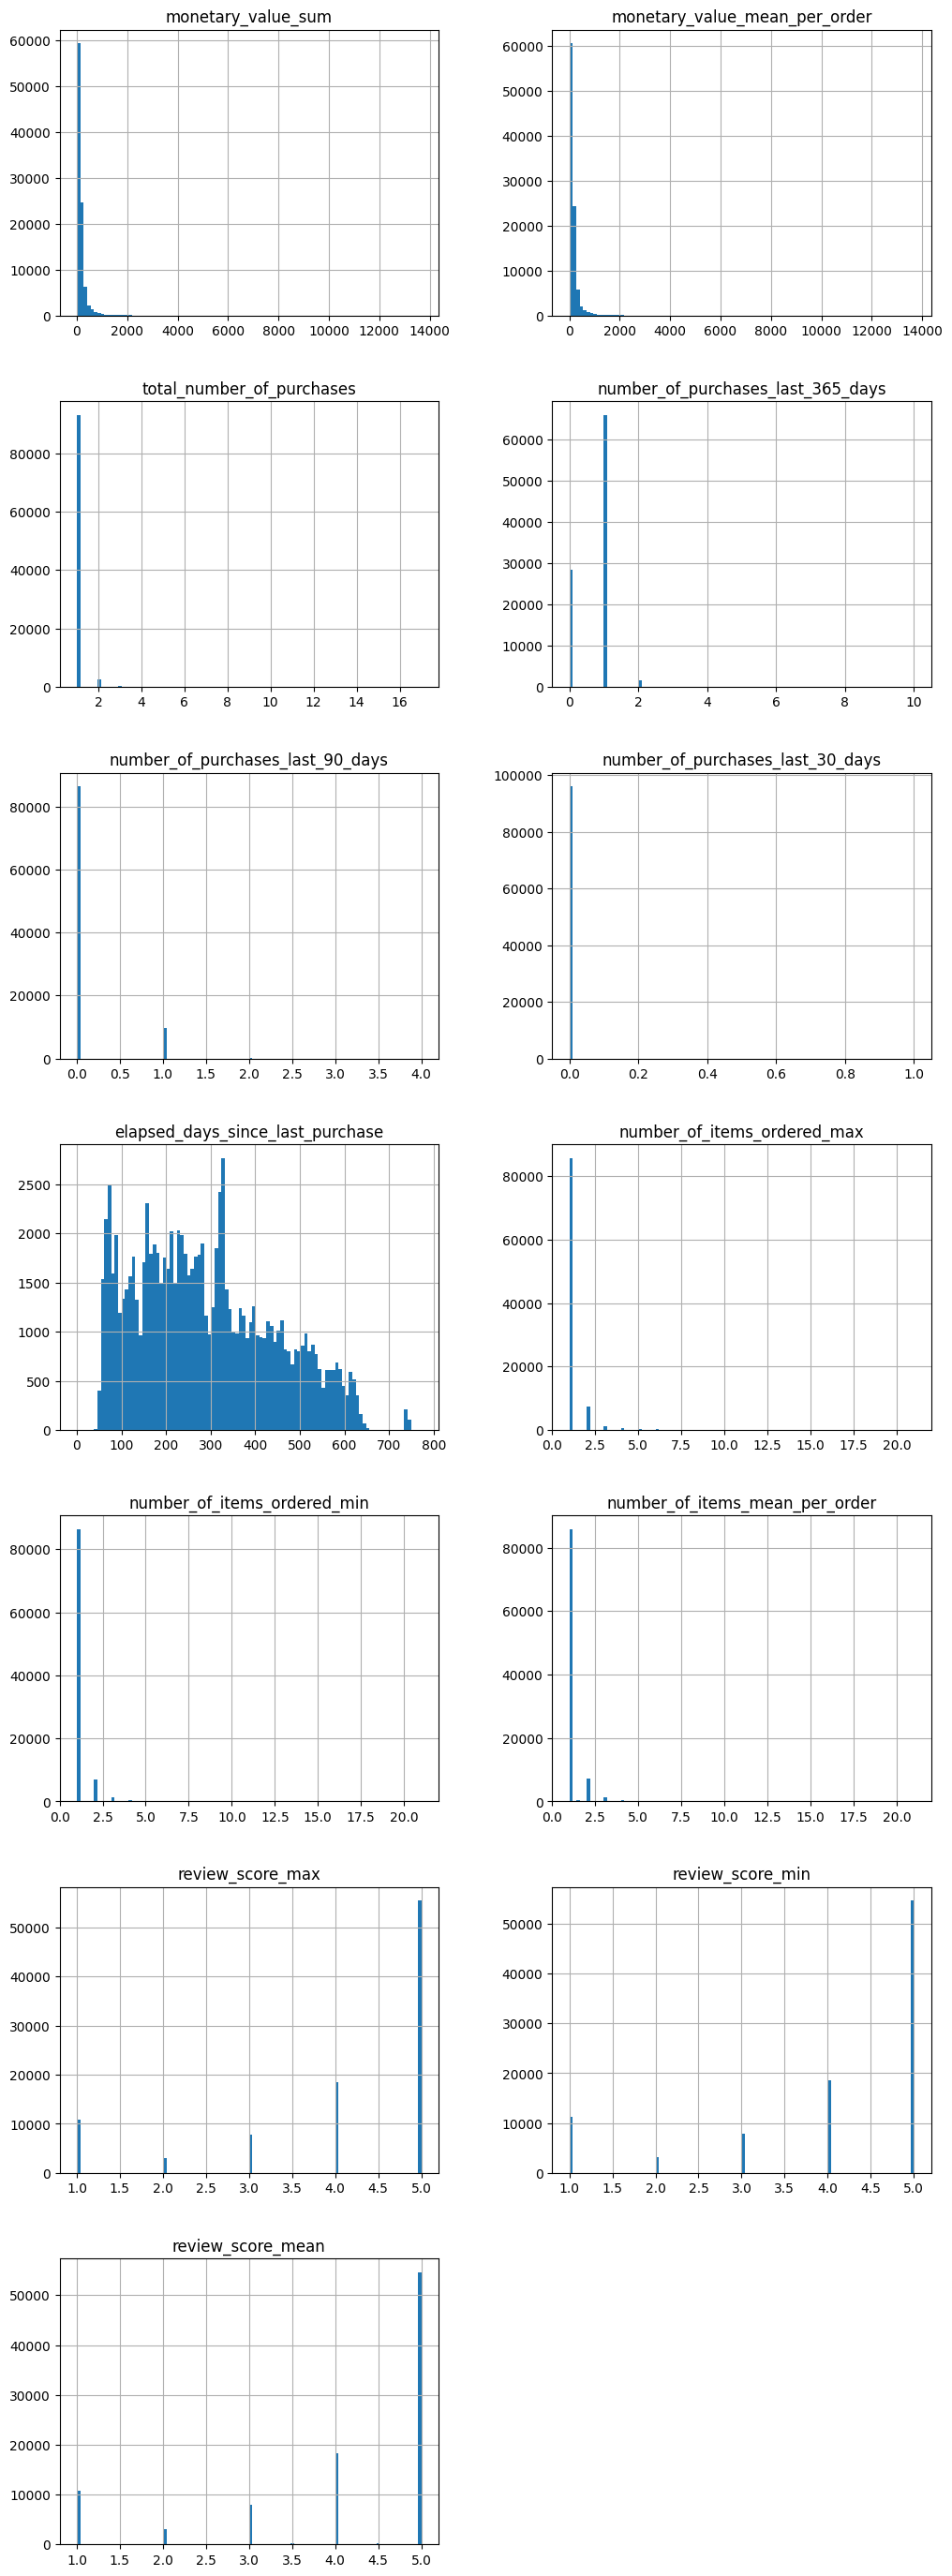

In [9]:
clients.hist(bins=100, figsize=(12, 40), layout=(8, 2))
plt.show()

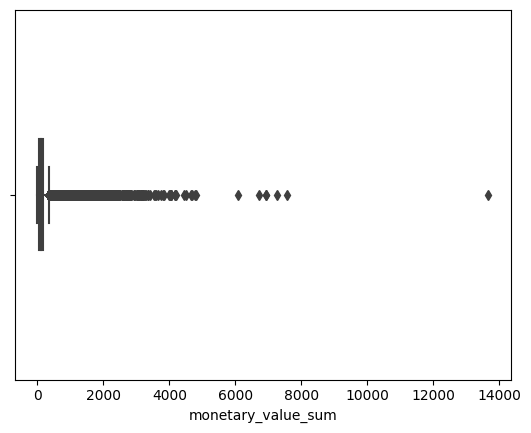

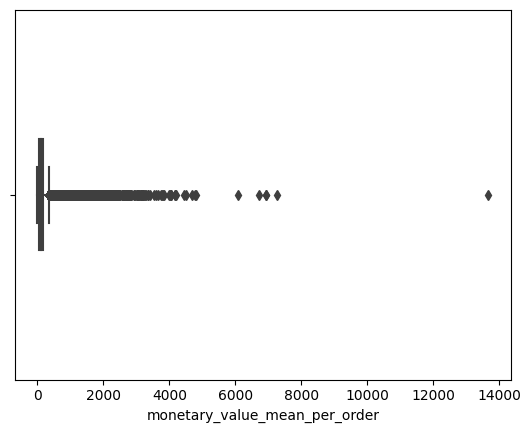

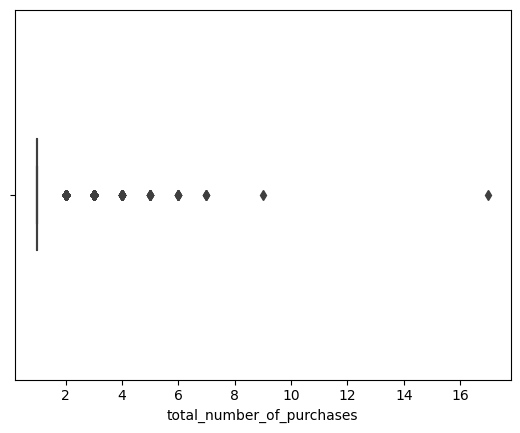

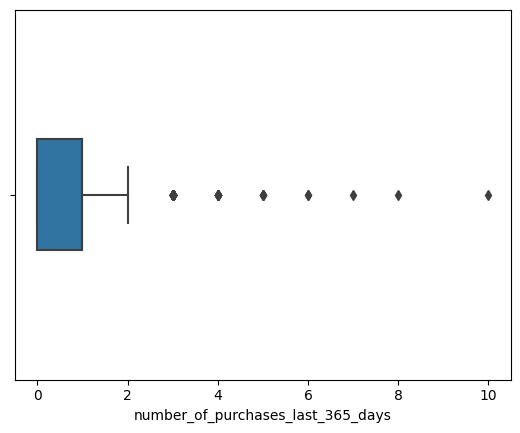

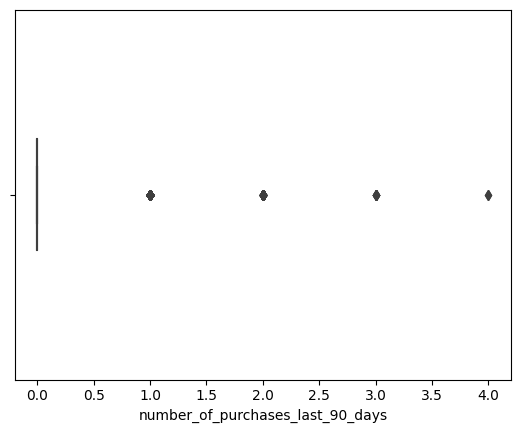

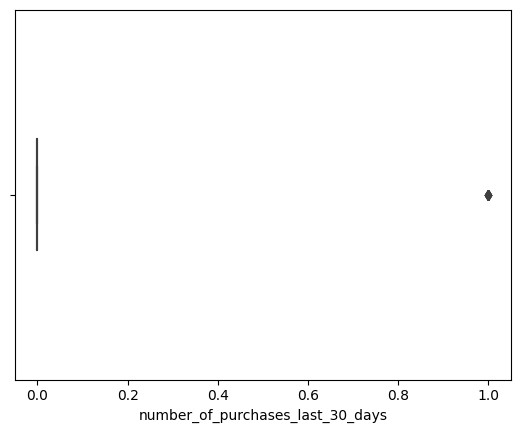

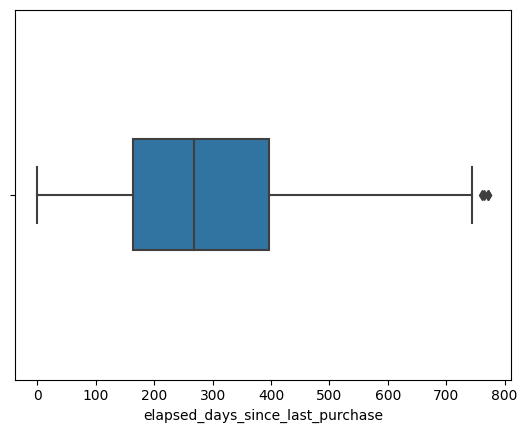

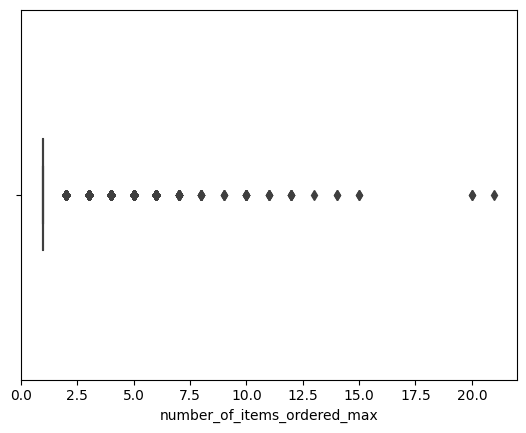

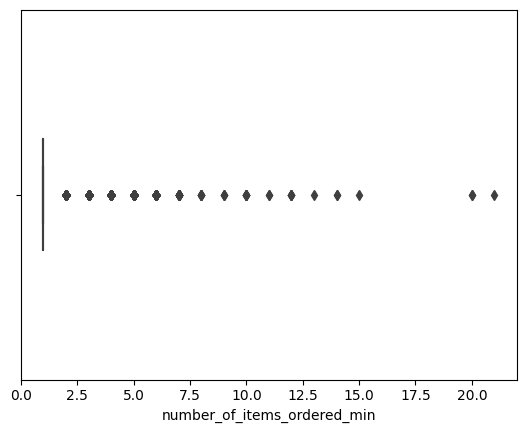

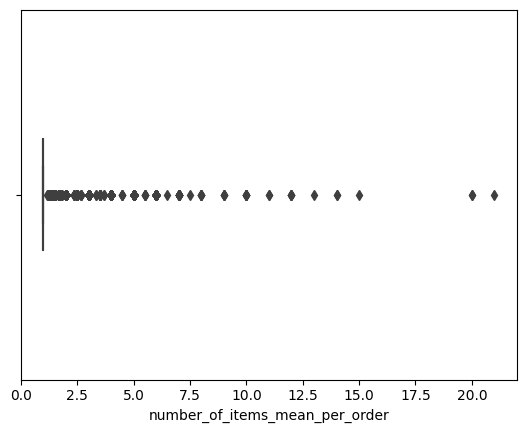

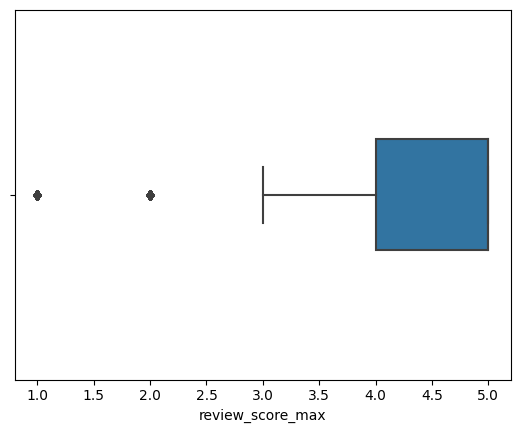

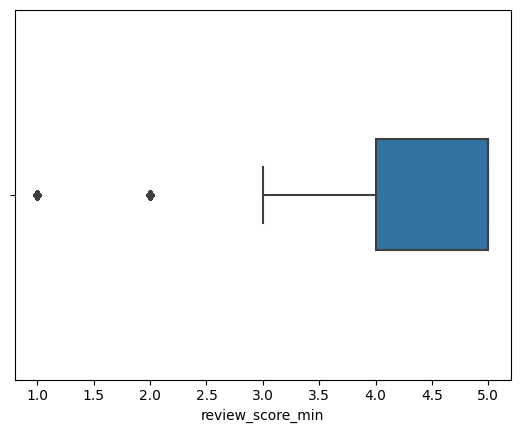

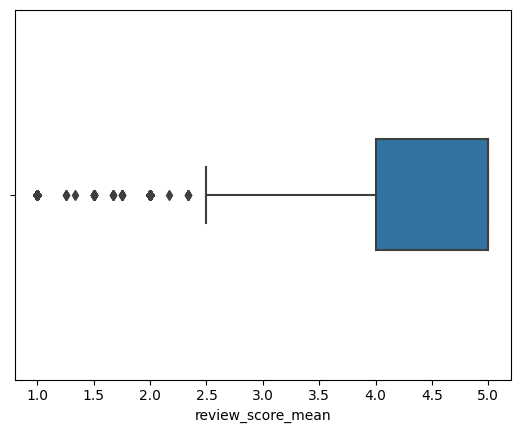

In [38]:
for col in clients.columns[:-3]:
    sns.boxplot(x=clients[col], width=0.3)
    plt.show()

## 4.2.  [&#9650;](#toc0_) <a id='toc4_2_'></a>Correlation matrix

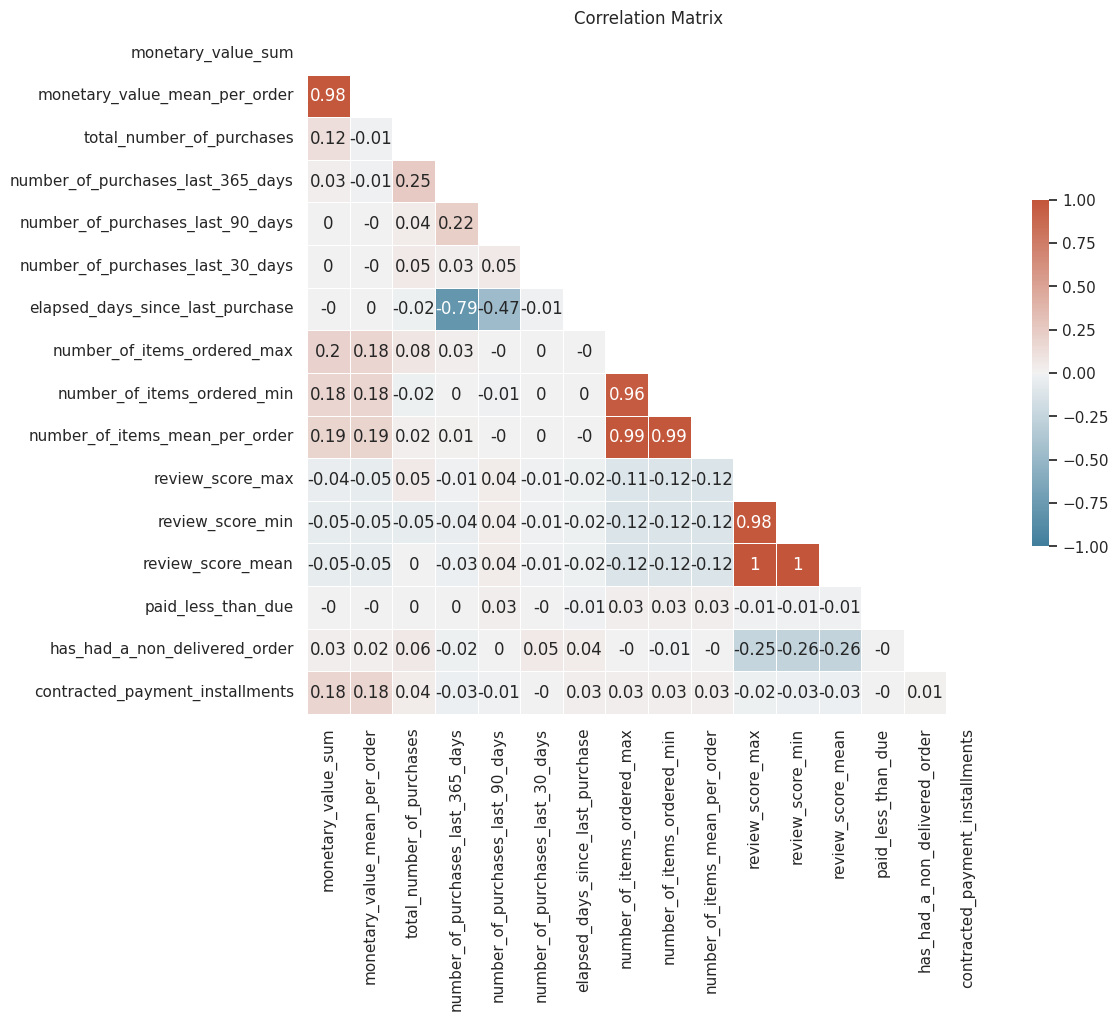

In [39]:
corr_input = (clients
              .dropna(axis=0)
              .astype('float32'))

ds.display_correlation_matrix(corr_input)


## 4.3.  [&#9650;](#toc0_) <a id='toc4_3_'></a>PCA's

### 4.3.1.  [&#9650;](#toc0_) <a id='toc4_3_1_'></a>On almost all engineered features

In [20]:
clients.columns

Index(['monetary_value_sum', 'monetary_value_mean_per_order',
       'total_number_of_purchases', 'number_of_purchases_last_365_days',
       'number_of_purchases_last_90_days', 'number_of_purchases_last_30_days',
       'elapsed_days_since_last_purchase', 'number_of_items_ordered_max',
       'number_of_items_ordered_min', 'number_of_items_mean_per_order',
       'review_score_max', 'review_score_min', 'review_score_mean',
       'paid_less_than_due', 'has_had_a_non_delivered_order',
       'contracted_payment_installments', 'rfm_code', 'segment'],
      dtype='object')

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing pca, total=   0.1s


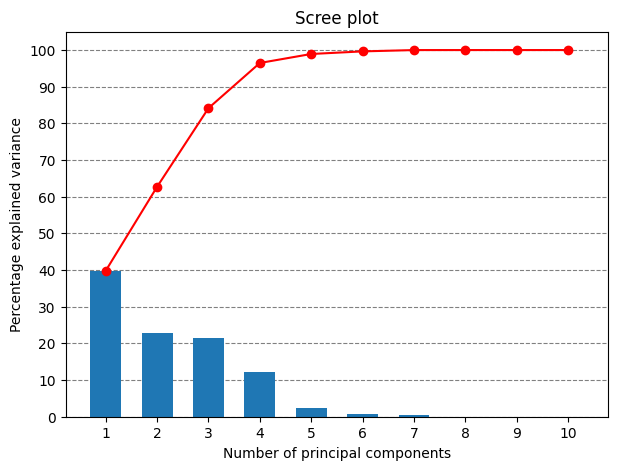

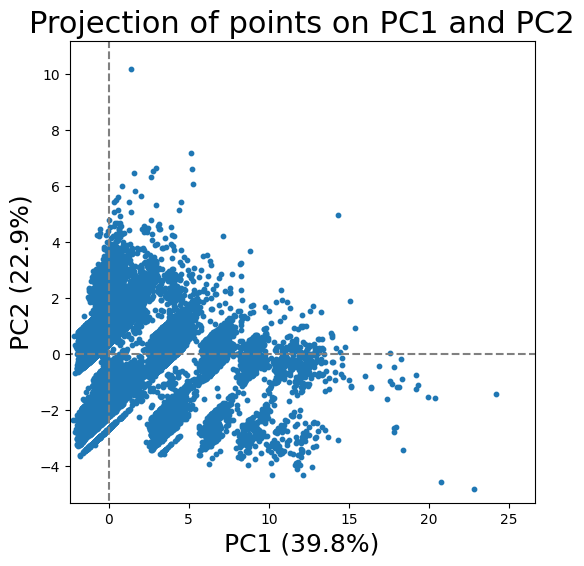

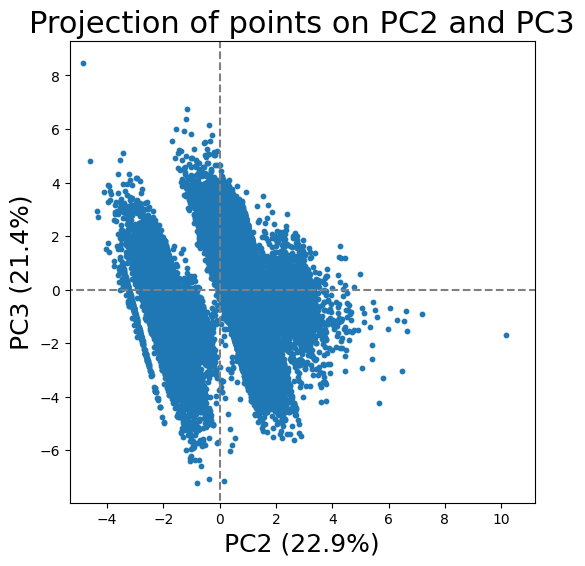

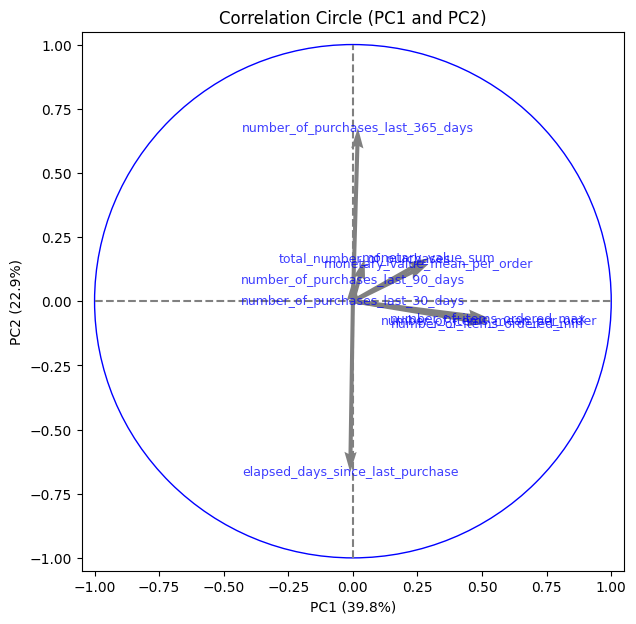

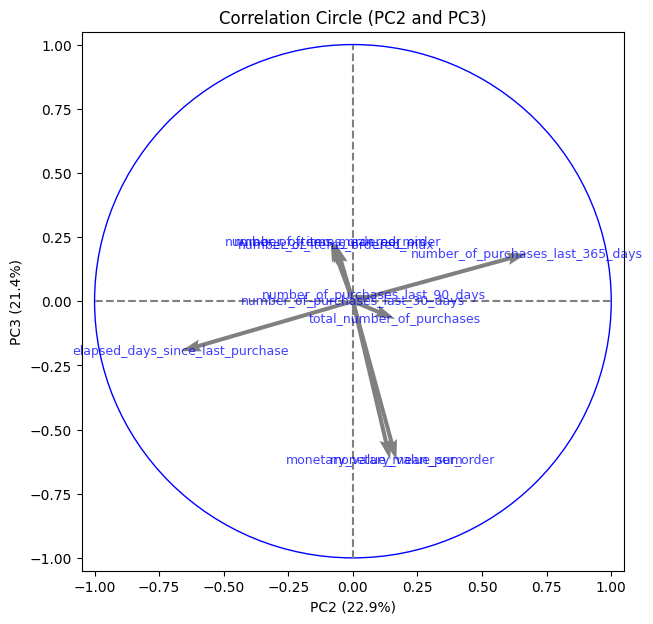

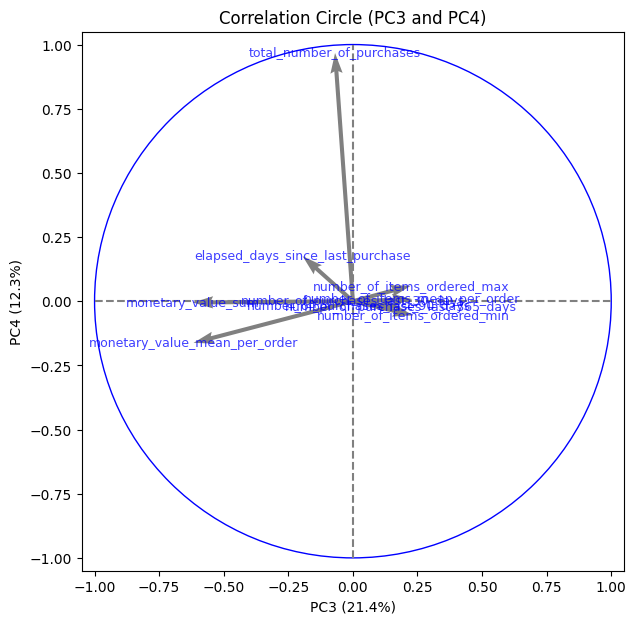

In [21]:
skewed_fts = ['monetary_value_sum',
              'monetary_value_mean_per_order',
              'total_number_of_purchases',
              'number_of_purchases_last_365_days',
              'number_of_items_ordered_max',
              'number_of_items_ordered_min',
              'number_of_items_mean_per_order',]

fts_to_scale = ['elapsed_days_since_last_purchase']

fts_pass = [
            'number_of_purchases_last_90_days',
            'number_of_purchases_last_30_days',
        #     'review_score_max',
        #     'review_score_min',
        #     'review_score_mean',
           ]

all_fts = [*skewed_fts, *fts_to_scale, *fts_pass]

input_pca = clients.dropna(axis=0)

log_transformer = FunctionTransformer(func=np.log1p)
pre_processor = make_column_transformer(
        (make_pipeline(log_transformer, StandardScaler()), skewed_fts),
        (StandardScaler(), fts_to_scale),
        ('passthrough', fts_pass),
)
pipe = make_pipeline(pre_processor, PCA(n_components=None), verbose=True)


clients_pca = pipe.fit_transform(input_pca)
pca = pipe[-1]
clients_pca_df = pd.DataFrame(clients_pca,
                              index=input_pca.index,
                              columns=[f"PC{n}" 
                                       for n in range(1,
                                                      clients_pca.shape[1]+1)])
clients_pca_df.head()


ds.display_scree_plot(pca)
ds.display_factorial_plane_projection(clients_pca, pca, (0, 1))
ds.display_factorial_plane_projection(clients_pca, pca, (1, 2))
ds.display_correlation_circle(pca, (0, 1), all_fts)
ds.display_correlation_circle(pca, (1, 2), all_fts)
ds.display_correlation_circle(pca, (2, 3), all_fts)

### 4.3.2.  [&#9650;](#toc0_) <a id='toc4_3_2_'></a>On recency, frequency, and moneraty value

In [75]:
clients.total_number_of_purchases.value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: total_number_of_purchases, dtype: int64

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing pca, total=   0.1s


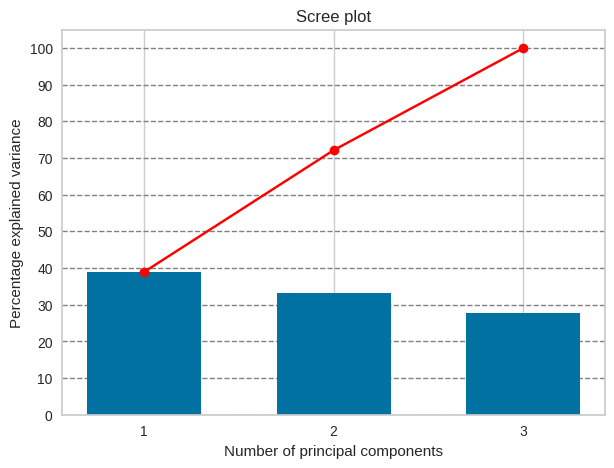

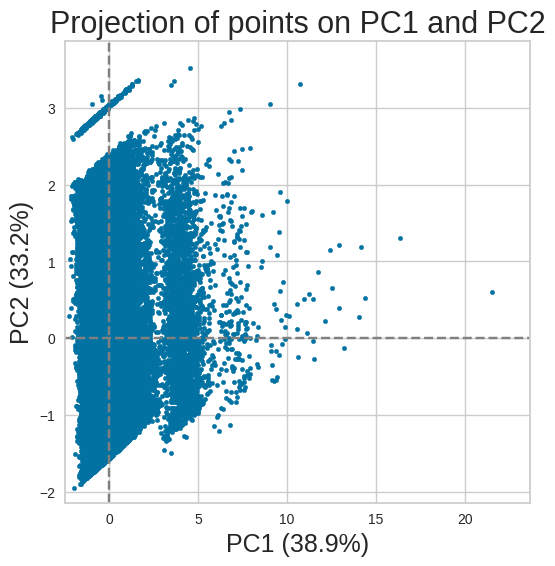

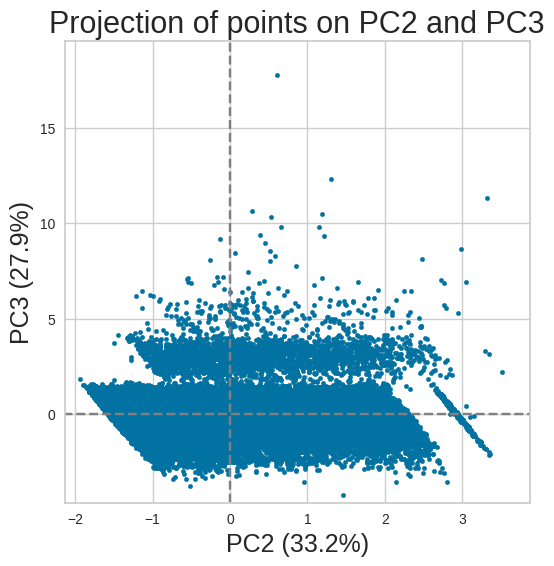

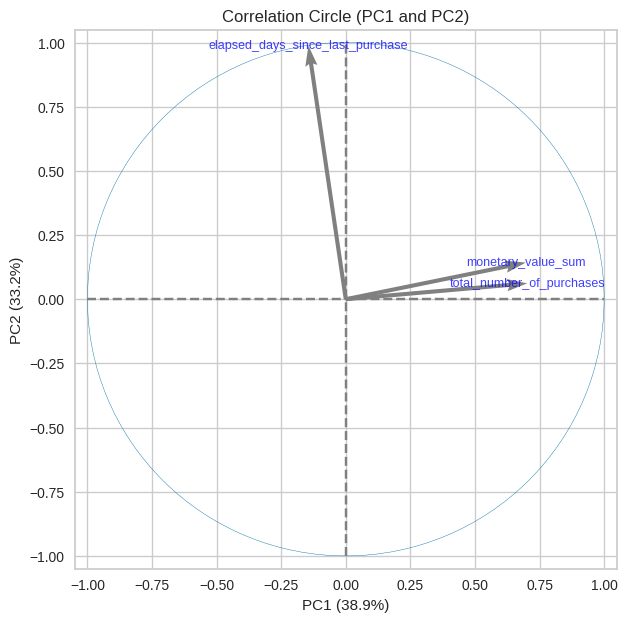

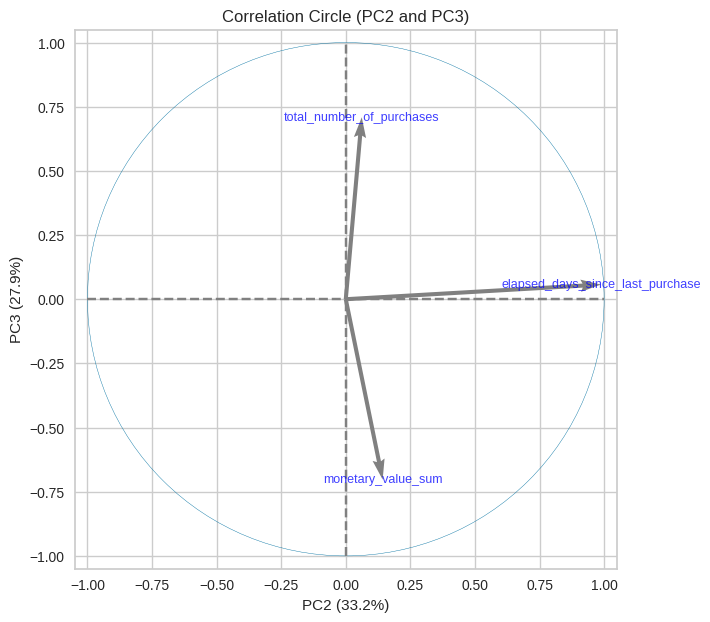

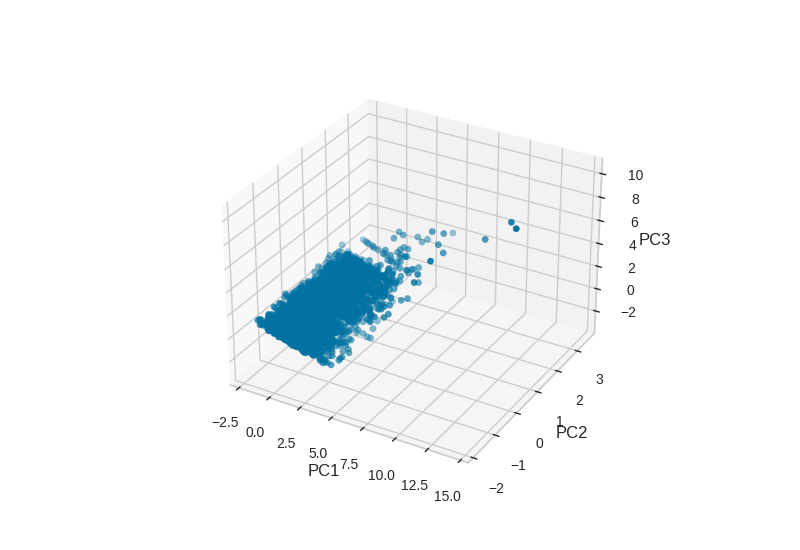

In [74]:
%matplotlib inline
skewed_fts = ['monetary_value_sum',
              'total_number_of_purchases',]
fts_to_scale = ['elapsed_days_since_last_purchase']
fts_pass = []
all_fts = [*skewed_fts, *fts_to_scale, *fts_pass]

input_pca = clients.dropna(axis=0)

log_transformer = FunctionTransformer(func=np.log1p)
pre_processor = make_column_transformer(
        (make_pipeline(log_transformer, StandardScaler()), skewed_fts),
        (StandardScaler(), fts_to_scale),
        ('passthrough', fts_pass),
)
pipe = make_pipeline(pre_processor, PCA(n_components=None), verbose=True)


clients_pca = pipe.fit_transform(input_pca)
pca = pipe[-1]
clients_pca_df = pd.DataFrame(clients_pca,
                              index=input_pca.index,
                              columns=[f"PC{n}" 
                                       for n 
                                       in range(1,clients_pca.shape[1]+1)])
clients_pca_df.head()


ds.display_scree_plot(pca)
ds.display_factorial_plane_projection(clients_pca, pca, (0, 1))
ds.display_factorial_plane_projection(clients_pca, pca, (1, 2))
ds.display_correlation_circle(pca, (0, 1), all_fts)
ds.display_correlation_circle(pca, (1, 2), all_fts)
ds.display_correlation_circle(pca, (2, 3), all_fts)

a_sample = clients_pca_df.sample(5000)
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a_sample.iloc[:, 0],
           a_sample.iloc[:, 1],
           a_sample.iloc[:, 2])
ax.set_xlabel("PC1",
              fontsize=12)
ax.set_ylabel("PC2",
              fontsize=12)
ax.set_zlabel("PC3",
              fontsize=12)
plt.show()


[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing pca, total=   0.0s


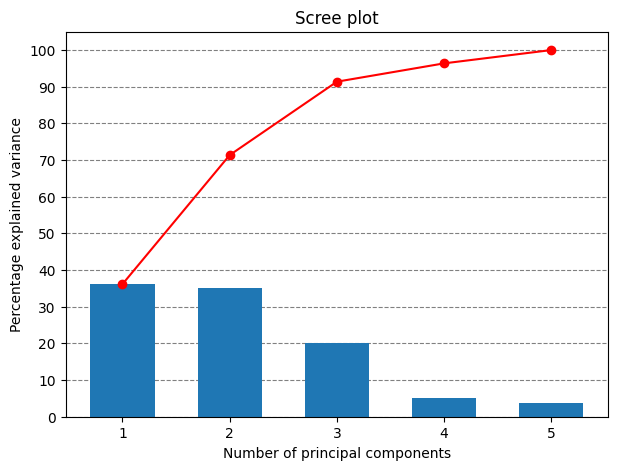

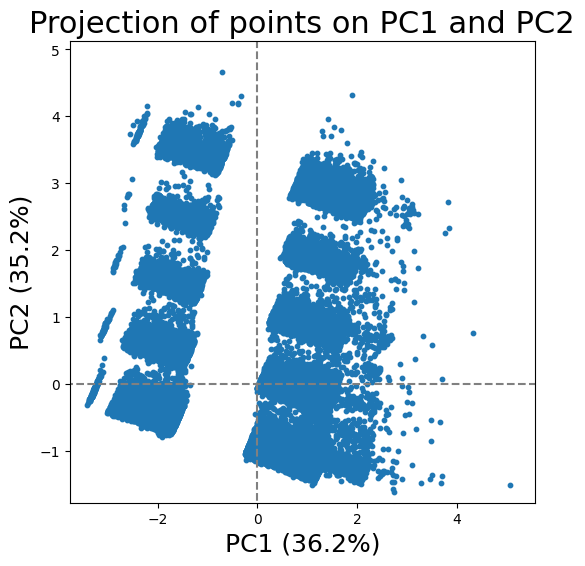

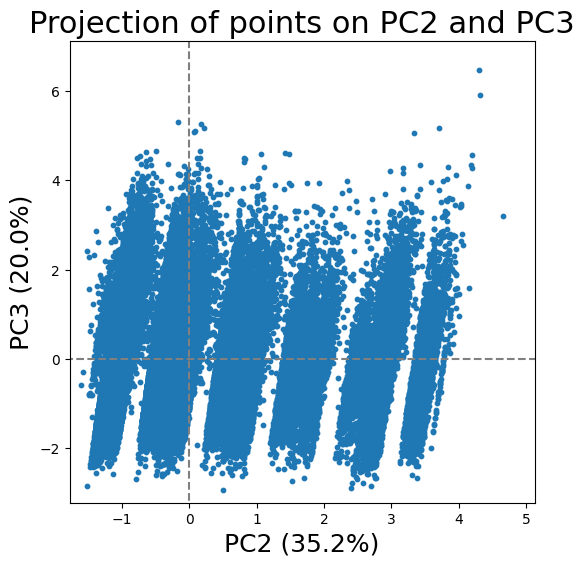

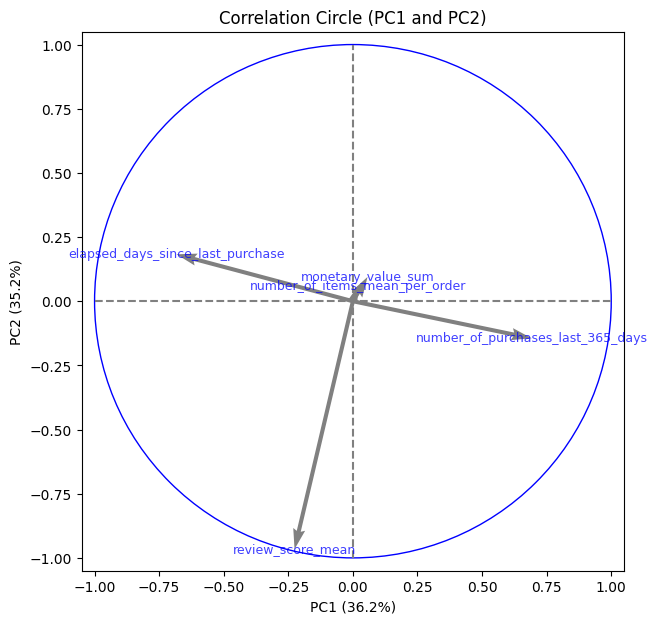

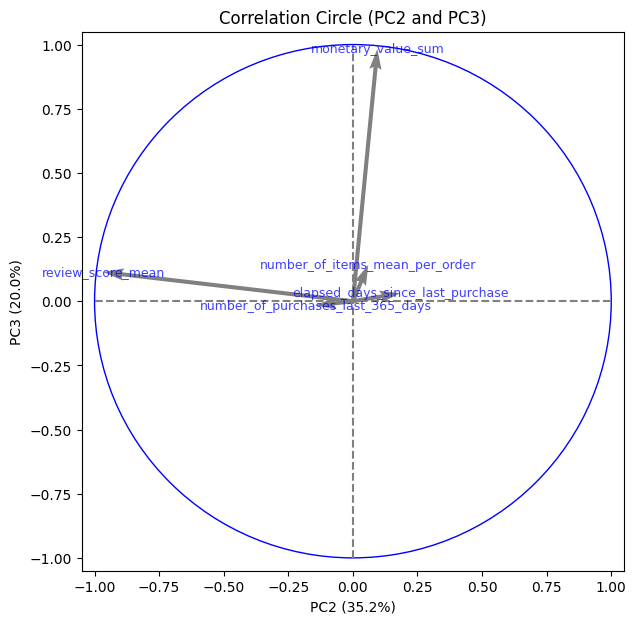

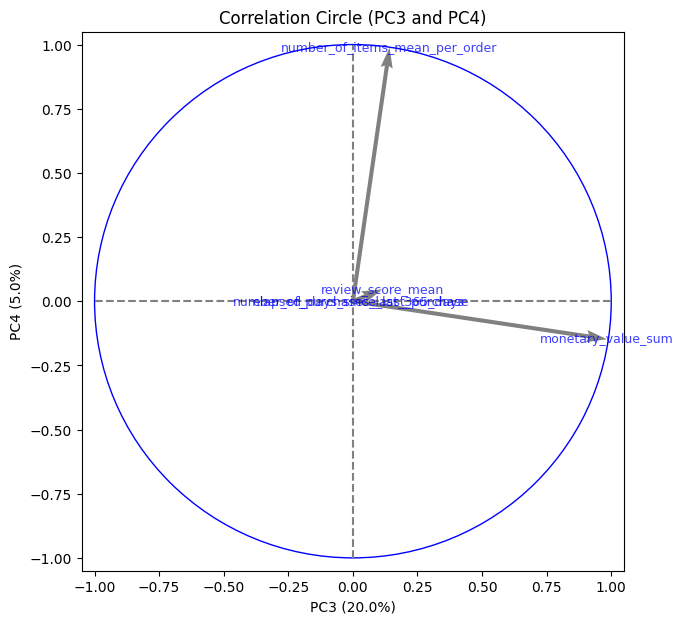

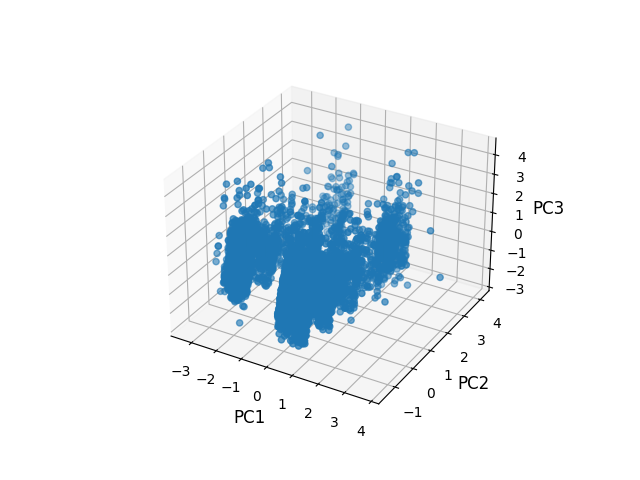

In [24]:
%matplotlib inline
skewed_fts = ['monetary_value_sum',
              'number_of_purchases_last_365_days',]

fts_to_scale = ['elapsed_days_since_last_purchase']
fts_pass = ['review_score_mean',
            'number_of_items_mean_per_order',]
all_fts = [*skewed_fts, *fts_to_scale, *fts_pass]

input_pca = clients.dropna(axis=0)

log_transformer = FunctionTransformer(func=np.log1p)
pre_processor = make_column_transformer(
        (make_pipeline(log_transformer, StandardScaler()), skewed_fts),
        (StandardScaler(), fts_to_scale),
        ('passthrough', fts_pass),
)
pipe = make_pipeline(pre_processor, PCA(n_components=None), verbose=True)


clients_pca = pipe.fit_transform(input_pca)
pca = pipe[-1]
clients_pca_df = pd.DataFrame(clients_pca,
                              index=input_pca.index,
                              columns=[f"PC{n}" 
                                       for n 
                                       in range(1,clients_pca.shape[1]+1)])
clients_pca_df.head()


ds.display_scree_plot(pca)
ds.display_factorial_plane_projection(clients_pca, pca, (0, 1))
ds.display_factorial_plane_projection(clients_pca, pca, (1, 2))
ds.display_correlation_circle(pca, (0, 1), all_fts)
ds.display_correlation_circle(pca, (1, 2), all_fts)
ds.display_correlation_circle(pca, (2, 3), all_fts)

a_sample = clients_pca_df.sample(5000)
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a_sample.iloc[:, 0],
           a_sample.iloc[:, 1],
           a_sample.iloc[:, 2])
ax.set_xlabel("PC1",
              fontsize=12)
ax.set_ylabel("PC2",
              fontsize=12)
ax.set_zlabel("PC3",
              fontsize=12)
plt.show()


## 4.4.  [&#9650;](#toc0_) <a id='toc4_4_'></a> Visualization in the RFM space

In [3]:
clients.describe()

monetary_value_sum  monetary_value_mean_per_order  \
count        96096.000000                   96096.000000   
mean           164.872141                     159.810187   
std            227.938658                     220.564409   
min              0.000000                       0.000000   
25%             62.390000                      61.690000   
50%            107.270000                     105.180000   
75%            182.237500                     176.230000   
max          13664.080000                   13664.080000   

       total_number_of_purchases  number_of_purchases_last_365_days  \
count               96096.000000                       96096.000000   
mean                    1.034809                           0.723683   
std                     0.214384                           0.492474   
min                     1.000000                           0.000000   
25%                     1.000000                           0.000000   
50%                     1.000000                           1.000000   
75%                     1.000000                           1.000000   
max                    17.000000                          10.000000   

       number_of_purchases_last_90_days  number_of_purchases_last_30_days  \
count                      96096.000000                      96096.000000   
mean                           0.101867                          0.000094   
std                            0.307220                          0.009677   
min                            0.000000                          0.000000   
25%                            0.000000                          0.000000   
50%                            0.000000                          0.000000   
75%                            0.000000                          0.000000   
max                            4.000000                          1.000000   

       elapsed_days_since_last_purchase  number_of_items_ordered_max  \
count                      96096.000000                 95420.000000   
mean                         287.735691                     1.144131   
std                          153.414676                     0.542735   
min                            0.000000                     1.000000   
25%                          163.000000                     1.000000   
50%                          268.000000                     1.000000   
75%                          397.000000                     1.000000   
max                          772.000000                    21.000000   

       number_of_items_ordered_min  number_of_items_mean_per_order  \
count                 95420.000000                     95420.00000   
mean                      1.134458                         1.13910   
std                       0.521767                         0.52688   
min                       1.000000                         1.00000   
25%                       1.000000                         1.00000   
50%                       1.000000                         1.00000   
75%                       1.000000                         1.00000   
max                      21.000000                        21.00000   

       review_score_max  review_score_min  review_score_mean  
count      95380.000000      95380.000000       95380.000000  
mean           4.097211          4.072405           4.084963  
std            1.340486          1.355007           1.341661  
min            1.000000          1.000000           1.000000  
25%            4.000000          4.000000           4.000000  
50%            5.000000          5.000000           5.000000  
75%            5.000000          5.000000           5.000000  
max            5.000000          5.000000           5.000000

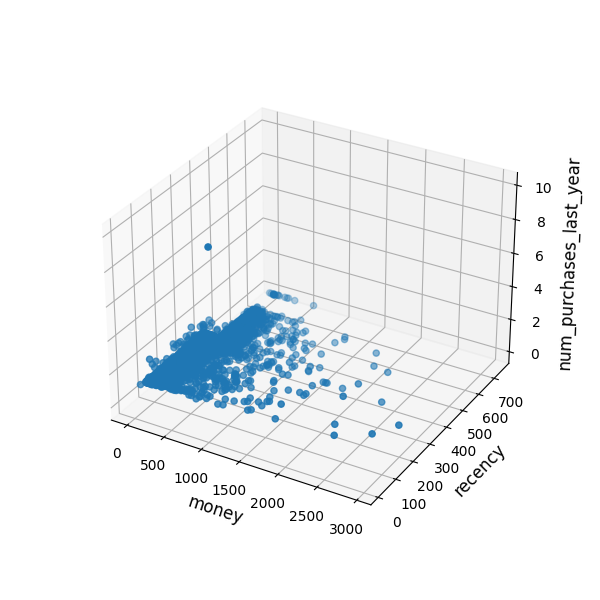

In [4]:
fts = ['monetary_value_sum',
       'elapsed_days_since_last_purchase',
       'number_of_purchases_last_365_days',
       ]

clients_red = clients[fts]
# clients_red_scaled = scaler.fit_transform(clients_red.dropna(axis=0))
clients_red_sampled = clients_red.sample(5000)

%matplotlib widget
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(clients_red_sampled.iloc[:, 0],
           clients_red_sampled.iloc[:, 1],
           clients_red_sampled.iloc[:, 2])
ax.set_xlabel("money",
              fontsize=12)
ax.set_ylabel("recency",
              fontsize=12)
ax.set_zlabel("num_purchases_last_year",
              fontsize=12)
plt.show()


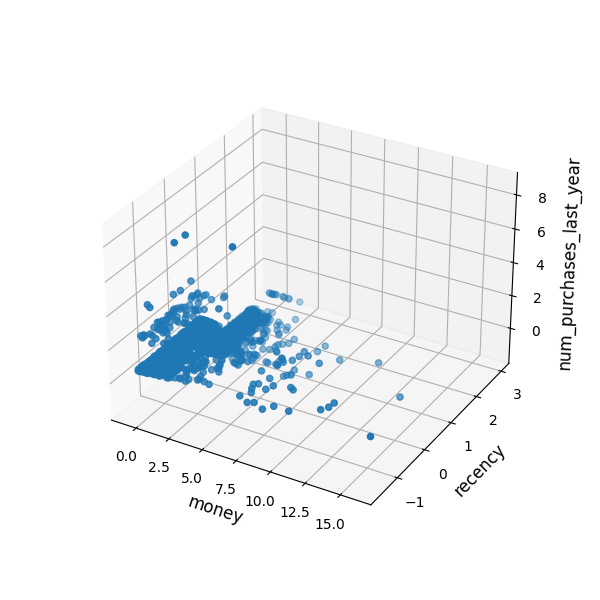

In [5]:
fts = ['monetary_value_sum',
       'elapsed_days_since_last_purchase',
       'number_of_purchases_last_365_days',
       ]

clients_red = clients[fts]
# clients_red_scaled = scaler.fit_transform(clients_red.dropna(axis=0))
clients_red_sampled = clients_red.sample(5000)
clients_red_sampled_scaled = StandardScaler().fit_transform(clients_red_sampled)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(clients_red_sampled_scaled[:, 0],
           clients_red_sampled_scaled[:, 1],
           clients_red_sampled_scaled[:, 2])
ax.set_xlabel("money",
              fontsize=12)
ax.set_ylabel("recency",
              fontsize=12)
ax.set_zlabel("num_purchases_last_year",
              fontsize=12)
plt.show()


# 5.  [&#9650;](#toc0_) <a id='toc5_'></a>Applying the RFM segmentation

What are Recency, Frequency and Monetary? [source](https://www.optimove.com/resources/learning-center/rfm-segmentation)

Underlying the RFM segmentation technique is the idea that marketers can gain an extensive understanding of their customers by analyzing three quantifiable factors. These are:

- **Recency**: How much time has elapsed since a customer’s last activity or transaction with the brand? Activity is usually a purchase, although variations are sometimes used, e.g., the last visit to a website or use of a mobile app. In most cases, the more recently a customer has interacted or transacted with a brand, the more likely that customer will be responsive to communications from the brand.
- **Frequency**: How often has a customer transacted or interacted with the brand during a particular period of time? Clearly, customers with frequent activities are more engaged, and probably more loyal, than customers who rarely do so. *And one-time-only customers are in a class of their own.*
- **Monetary**: Also referred to as “monetary value,” this factor reflects how much a customer has spent with the brand during a particular period of time. Big spenders should usually be treated differently than customers who spend little. *Looking at monetary divided by frequency indicates the average purchase amount – an important secondary factor to consider when segmenting customers.*

***
Main pros and cons :
- Easy to perform (even on a small dataset)
- Based on history, lack to perceive changes.
- Intrinsically actionnable.

***
At that point, I have already compute these features.

I can know create tier-groups for each feature, and concatenate them in a 3 digit code for example 214 (2 for recency, 1 for frequency, and 4 for monetary)

This would tell that the client has had a huge activity during the period of interest but has not spent much money (He made only very small orders with cheap items).
Plus, we could say that we might be starting to lose him because he bought a lot, but we had no sign of activity very recently.
***

In order to decide how many tier-groups I want to include for each feature,
I think it is important to observe distributions again.

## 5.1.  [&#9650;](#toc0_) <a id='toc5_1_'></a>Criterions used to create tier-groups

In [35]:
rfm = clients[['elapsed_days_since_last_purchase',
               'total_number_of_purchases',
               'monetary_value_sum']].copy()

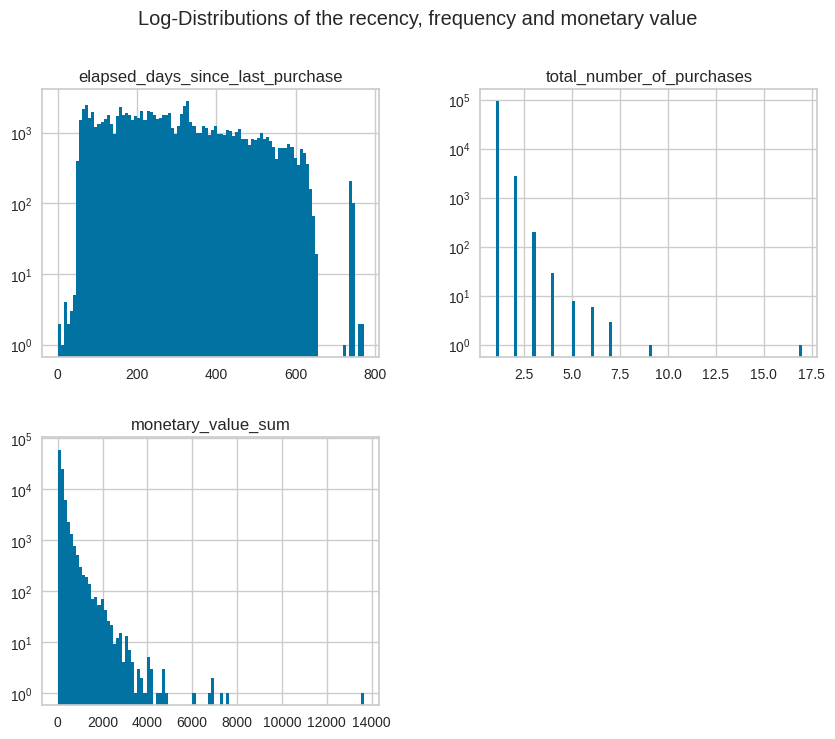

In [36]:
%matplotlib inline
rfm.hist(bins=100, log=True, figsize=(10,8), )
plt.suptitle('Log-Distributions of the recency, frequency and monetary value')
plt.show()

By the way, we can see that some data might be missing because of the gap in the elapsed time since last purchase. Or the platform was not available at that time...

***
Thus, I want to make the following groups:

**Recency** :
- less than 90 days -> 1
- less than 180 days and not in previous -> 2
- less than 365 days and not in previous -> 3
- rest --> 4

**Frequency** : 
- more than 5 -> 1
- 2,3 or 4 orders -> 2
- 1 order -> 3

**Monetary**:
- more than ~500$ (2500 reales) -> 1
- between ~100$ and ~500$ (500 reales to 2499.99 reales) -> 2
- between 100 and 500 reales -> 3
- less than 100 reales -> 4
***
Thus, the higher the number for a feature, the worse it is for the platform.

In [37]:
rfm.loc[:, 'recency_group'] = pd.cut(rfm.elapsed_days_since_last_purchase,
                              [0, 90, 180, 365, np.inf],
                              labels=['1', '2', '3', '4'])

rfm.loc[:, 'frequency_group'] = pd.cut(rfm.total_number_of_purchases,
                                [0, 1, 4, np.inf],
                                labels=['3', '2', '1'])

rfm.loc[:, 'monetary_group'] = pd.cut(rfm.monetary_value_sum,
                               [0, 99.99, 499.99, 2499.99, np.inf],
                               labels=['4', '3', '2', '1'])

# cast to string in order to generate the rfm code with a simple string
# concatenation because pd.cut returns categorical features.
rfm.iloc[:, -3:] = rfm.iloc[:, -3:].apply(lambda x: x.astype('object'))
display(rfm.dtypes)
rfm.sample(10)

/tmp/ipykernel_4438/2159775391.py:15: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rfm.iloc[:, -3:] = rfm.iloc[:, -3:].apply(lambda x: x.astype('object'))


elapsed_days_since_last_purchase      int64
total_number_of_purchases             int64
monetary_value_sum                  float64
recency_group                        object
frequency_group                      object
monetary_group                       object
dtype: object

elapsed_days_since_last_purchase  \
customer_unique_id                                                   
bc7bdb9c1a238074b218f190a3e1e5bb                               228   
58f80711fb4a9b61ddcf707a38fd13e4                               262   
588a5a88a0b494e1067d9015f899ea46                               203   
aedfc8d041dcb092b3eb0d1d2fa3cd64                               393   
9d841a91b5b7d1451157dbc8cd94ae8e                               200   
3ae3020ba7a772196e5f1368d175a65d                               227   
63c832601a87d0c284d5bf313dfa3f24                               361   
d9a1aaab532b2af5b09fc0a8d9e4accf                               219   
c9d749b8bec5051db8a1d50a7a9f261e                               116   
a39447eee91a5da5d34e5d0b971ca1eb                                90   

                                  total_number_of_purchases  \
customer_unique_id                                            
bc7bdb9c1a238074b218f190a3e1e5bb                          1   
58f80711fb4a9b61ddcf707a38fd13e4                          1   
588a5a88a0b494e1067d9015f899ea46                          1   
aedfc8d041dcb092b3eb0d1d2fa3cd64                          1   
9d841a91b5b7d1451157dbc8cd94ae8e                          1   
3ae3020ba7a772196e5f1368d175a65d                          1   
63c832601a87d0c284d5bf313dfa3f24                          1   
d9a1aaab532b2af5b09fc0a8d9e4accf                          1   
c9d749b8bec5051db8a1d50a7a9f261e                          1   
a39447eee91a5da5d34e5d0b971ca1eb                          1   

                                  monetary_value_sum recency_group  \
customer_unique_id                                                   
bc7bdb9c1a238074b218f190a3e1e5bb               54.17             3   
58f80711fb4a9b61ddcf707a38fd13e4               85.14             3   
588a5a88a0b494e1067d9015f899ea46              140.56             3   
aedfc8d041dcb092b3eb0d1d2fa3cd64              369.89             4   
9d841a91b5b7d1451157dbc8cd94ae8e              145.07             3   
3ae3020ba7a772196e5f1368d175a65d              146.04             3   
63c832601a87d0c284d5bf313dfa3f24               46.00             3   
d9a1aaab532b2af5b09fc0a8d9e4accf               65.03             3   
c9d749b8bec5051db8a1d50a7a9f261e              137.63             2   
a39447eee91a5da5d34e5d0b971ca1eb              540.79             1   

                                 frequency_group monetary_group  
customer_unique_id                                               
bc7bdb9c1a238074b218f190a3e1e5bb               3              4  
58f80711fb4a9b61ddcf707a38fd13e4               3              4  
588a5a88a0b494e1067d9015f899ea46               3              3  
aedfc8d041dcb092b3eb0d1d2fa3cd64               3              3  
9d841a91b5b7d1451157dbc8cd94ae8e               3              3  
3ae3020ba7a772196e5f1368d175a65d               3              3  
63c832601a87d0c284d5bf313dfa3f24               3              4  
d9a1aaab532b2af5b09fc0a8d9e4accf               3              4  
c9d749b8bec5051db8a1d50a7a9f261e               3              3  
a39447eee91a5da5d34e5d0b971ca1eb               3              2

## 5.2.  [&#9650;](#toc0_) <a id='toc5_2_'></a>RFM 3 digits code

In [38]:
rfm.loc[:, 'rfm_code'] = rfm.recency_group + rfm.frequency_group + rfm.monetary_group
rfm.sample(10)

elapsed_days_since_last_purchase  \
customer_unique_id                                                   
16001cbe5e5de74015e3dd4fc03c6f67                               423   
c334e12e465f4ede93b497d45f6c8861                               460   
3a38c5469df621ba4fa026396ff4ce3d                               219   
0b168f28a96d34e5b2d17f436b4a05a9                               121   
a8c78f8c4faf800e1d0c164deda39157                                83   
55ad76dbbe5e81366ed0313659bc2f44                               330   
5a57aea4317e1e0d674fa48d5f5ee524                               237   
1a09c9c9a99266a1bd2185c19e0fa9a4                               241   
96d98eef584116e44af1b51776881241                               368   
f63995310ef953fe62d42ed1a1a7f973                               418   

                                  total_number_of_purchases  \
customer_unique_id                                            
16001cbe5e5de74015e3dd4fc03c6f67                          1   
c334e12e465f4ede93b497d45f6c8861                          1   
3a38c5469df621ba4fa026396ff4ce3d                          1   
0b168f28a96d34e5b2d17f436b4a05a9                          1   
a8c78f8c4faf800e1d0c164deda39157                          1   
55ad76dbbe5e81366ed0313659bc2f44                          1   
5a57aea4317e1e0d674fa48d5f5ee524                          1   
1a09c9c9a99266a1bd2185c19e0fa9a4                          1   
96d98eef584116e44af1b51776881241                          1   
f63995310ef953fe62d42ed1a1a7f973                          1   

                                  monetary_value_sum recency_group  \
customer_unique_id                                                   
16001cbe5e5de74015e3dd4fc03c6f67               31.26             4   
c334e12e465f4ede93b497d45f6c8861               97.80             4   
3a38c5469df621ba4fa026396ff4ce3d               67.83             3   
0b168f28a96d34e5b2d17f436b4a05a9               88.32             2   
a8c78f8c4faf800e1d0c164deda39157              132.90             1   
55ad76dbbe5e81366ed0313659bc2f44               69.72             3   
5a57aea4317e1e0d674fa48d5f5ee524               67.60             3   
1a09c9c9a99266a1bd2185c19e0fa9a4              116.85             3   
96d98eef584116e44af1b51776881241               88.84             4   
f63995310ef953fe62d42ed1a1a7f973              139.28             4   

                                 frequency_group monetary_group rfm_code  
customer_unique_id                                                        
16001cbe5e5de74015e3dd4fc03c6f67               3              4      434  
c334e12e465f4ede93b497d45f6c8861               3              4      434  
3a38c5469df621ba4fa026396ff4ce3d               3              4      334  
0b168f28a96d34e5b2d17f436b4a05a9               3              4      234  
a8c78f8c4faf800e1d0c164deda39157               3              3      133  
55ad76dbbe5e81366ed0313659bc2f44               3              4      334  
5a57aea4317e1e0d674fa48d5f5ee524               3              4      334  
1a09c9c9a99266a1bd2185c19e0fa9a4               3              3      333  
96d98eef584116e44af1b51776881241               3              4      434  
f63995310ef953fe62d42ed1a1a7f973               3              3      433

In [39]:
segment_stats = pd.concat(
    [(rfm.rfm_code.value_counts() * 100 /rfm.shape[0]).round(2).rename('pct'),
     rfm.rfm_code.value_counts().rename('effective')],
    axis=1)

segment_stats.index.name = 'rfm_code'
display(segment_stats)

pct  effective
rfm_code                  
333       19.32      18568
334       18.79      18055
434       13.71      13170
433       13.42      12893
233        9.14       8784
234        8.38       8050
134        4.71       4527
133        4.53       4349
332        1.66       1592
432        1.23       1182
323        1.02        978
232        0.83        801
423        0.58        561
223        0.48        466
132        0.39        379
123        0.28        268
322        0.16        149
324        0.13        125
424        0.10         97
222        0.09         91
422        0.09         90
224        0.06         61
124        0.04         39
122        0.04         37
431        0.03         31
231        0.02         23
331        0.02         19
131        0.01          8
312        0.01          7
212        0.01          5
421        0.00          4
112        0.00          3
121        0.00          2
313        0.00          2
413        0.00          1
213        0.00          1
221        0.00          1

In [40]:
segment_stats.shape

(37, 2)

Among the $4\times3\times4 = 48$ groups expected, only 39 hold at least a client. 

Moreover, we see that groups are significantly not of the same size.

Some group might be grouped such as : (413 and 313) -> 'ancient good activity client with medium money spare' for example. I will adress that later if needed.

## 5.3.  [&#9650;](#toc0_) <a id='toc5_3_'></a>Joining into 9 client profiles.

In [41]:
segment_map= {
    # One time buyers
    r'334|434|433|333': 'old_one_time_buyer_small_value',
    r'233|234': 'not_so_old_one_time_buyer_small_value', 
    r'134|133': 'Recent_one_time_buyer_small_value',
    r'332|432|331|431': 'old_one_time_buyer_high_value',
    r'132|131|232|231': 'Recent_one_time_buyer_high_value',
    # With multiple order
    r'[3-4][1-2][1-2]': 'old_multiple_buyer_for_high_value',
    r'[1-2][1-2][3-4]': 'recent_multiple_buyer_for_small_value',
    r'[1-2][1-2][1-2]': 'recent_multiple_buyer_for_high_value',
    r'[3-4][1-2][3-4]': 'old_multiple_buyer_for_small_value',
}

rfm.loc[:, 'segment'] = rfm['rfm_code'].replace(segment_map, regex=True)
rfm.sample(10)

elapsed_days_since_last_purchase  \
customer_unique_id                                                   
60ec8175b75dc28e76068d138a70f36e                               228   
628c60c3fafec90dacf2ea3618519d3a                               162   
69a7f37355617e699081e1a1db826691                               240   
74aca8cba124970ec7b909d592bef175                               344   
a93807b5aeb1d0c0d622c28a09aab231                               315   
209dd3c03758ed63f5f270d19c1ac1f5                               243   
c679ed73540ae7db607e5a6107082dc2                               302   
79f370f8c26134e52fee1e0adb0caa13                               323   
734cc3d2bbd3cafb6f0e9f9cec220c8e                               178   
f799f3fb6001f51f8230e022db5de1b2                               536   

                                  total_number_of_purchases  \
customer_unique_id                                            
60ec8175b75dc28e76068d138a70f36e                          1   
628c60c3fafec90dacf2ea3618519d3a                          1   
69a7f37355617e699081e1a1db826691                          1   
74aca8cba124970ec7b909d592bef175                          1   
a93807b5aeb1d0c0d622c28a09aab231                          1   
209dd3c03758ed63f5f270d19c1ac1f5                          1   
c679ed73540ae7db607e5a6107082dc2                          1   
79f370f8c26134e52fee1e0adb0caa13                          1   
734cc3d2bbd3cafb6f0e9f9cec220c8e                          1   
f799f3fb6001f51f8230e022db5de1b2                          1   

                                  monetary_value_sum recency_group  \
customer_unique_id                                                   
60ec8175b75dc28e76068d138a70f36e               50.63             3   
628c60c3fafec90dacf2ea3618519d3a              126.66             2   
69a7f37355617e699081e1a1db826691              143.65             3   
74aca8cba124970ec7b909d592bef175               93.98             3   
a93807b5aeb1d0c0d622c28a09aab231               52.54             3   
209dd3c03758ed63f5f270d19c1ac1f5              134.34             3   
c679ed73540ae7db607e5a6107082dc2               75.65             3   
79f370f8c26134e52fee1e0adb0caa13              154.04             3   
734cc3d2bbd3cafb6f0e9f9cec220c8e              180.78             2   
f799f3fb6001f51f8230e022db5de1b2               20.62             4   

                                 frequency_group monetary_group rfm_code  \
customer_unique_id                                                         
60ec8175b75dc28e76068d138a70f36e               3              4      334   
628c60c3fafec90dacf2ea3618519d3a               3              3      233   
69a7f37355617e699081e1a1db826691               3              3      333   
74aca8cba124970ec7b909d592bef175               3              4      334   
a93807b5aeb1d0c0d622c28a09aab231               3              4      334   
209dd3c03758ed63f5f270d19c1ac1f5               3              3      333   
c679ed73540ae7db607e5a6107082dc2               3              4      334   
79f370f8c26134e52fee1e0adb0caa13               3              3      333   
734cc3d2bbd3cafb6f0e9f9cec220c8e               3              3      233   
f799f3fb6001f51f8230e022db5de1b2               3              4      434   

                                                                segment  
customer_unique_id                                                       
60ec8175b75dc28e76068d138a70f36e         old_one_time_buyer_small_value  
628c60c3fafec90dacf2ea3618519d3a  not_so_old_one_time_buyer_small_value  
69a7f37355617e699081e1a1db826691         old_one_time_buyer_small_value  
74aca8cba124970ec7b909d592bef175         old_one_time_buyer_small_value  
a93807b5aeb1d0c0d622c28a09aab231         old_one_time_buyer_small_value  
209dd3c03758ed63f5f270d19c1ac1f5         old_one_time_buyer_small_value  
c679ed73540ae7db607e5a6107082dc2         old_one_time_buyer_small_value  
79f370f8c26134e5

In [44]:
clients['is_multiple_time_buyer'] = (rfm.frequency_group.astype('int') <= 2)

In [47]:
clients = clients.merge(rfm.loc[:, ['rfm_code', 'segment']].reset_index(),
                        on='customer_unique_id')

clients.head()

customer_unique_id  monetary_value_sum  \
0  0000366f3b9a7992bf8c76cfdf3221e2              141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f               27.19   
2  0000f46a3911fa3c0805444483337064               86.22   
3  0000f6ccb0745a6a4b88665a16c9f078               43.62   
4  0004aac84e0df4da2b147fca70cf8255              196.89   

   monetary_value_mean_per_order  total_number_of_purchases  \
0                         141.90                          1   
1                          27.19                          1   
2                          86.22                          1   
3                          43.62                          1   
4                         196.89                          1   

   number_of_purchases_last_365_days  number_of_purchases_last_90_days  \
0                                  1                                 0   
1                                  1                                 0   
2                                  0                                 0   
3                                  0                                 0   
4                                  1                                 0   

   number_of_purchases_last_30_days  elapsed_days_since_last_purchase  \
0                                 0                               160   
1                                 0                               163   
2                                 0                               585   
3                                 0                               369   
4                                 0                               336   

   number_of_items_ordered_max  number_of_items_ordered_min  \
0                          1.0                          1.0   
1                          1.0                          1.0   
2                          1.0                          1.0   
3                          1.0                          1.0   
4                          1.0                          1.0   

   number_of_items_mean_per_order  review_score_max  review_score_min  \
0                             1.0               5.0               5.0   
1                             1.0               4.0               4.0   
2                             1.0               3.0               3.0   
3                             1.0               4.0               4.0   
4                             1.0               5.0               5.0   

   review_score_mean  paid_less_than_due  has_had_a_non_delivered_order  \
0                5.0               False                          False   
1                4.0               False                          False   
2                3.0               False                          False   
3                4.0               False                          False   
4                5.0               False                          False   

   contracted_payment_installments  is_multiple_time_buyer rfm_code  \
0                             True                   False      233   
1                            False                   False      234   
2                             True                   False      434   
3                             True                   False      434   
4                             True                   False      333   

                                 segment  
0  not_so_old_one_time_buyer_small_value  
1  not_so_old_one_time_buyer_small_value  
2         old_one_time_buyer_small_value  
3         old_one_time_buyer_small_value  
4         old_one_time_buyer_small_value

In [48]:
clients.to_csv('clients_rfm.csv.gz', index=False)

In [2]:
clients = pd.read_csv('clients_rfm.csv.gz', index_col='customer_unique_id')

In [3]:
clients.rfm_code = clients.rfm_code.fillna(0).astype('int').astype('object')
display(clients.info())
clients.head()

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   monetary_value_sum                 96096 non-null  float64
 1   monetary_value_mean_per_order      96096 non-null  float64
 2   total_number_of_purchases          96096 non-null  int64  
 3   number_of_purchases_last_365_days  96096 non-null  int64  
 4   number_of_purchases_last_90_days   96096 non-null  int64  
 5   number_of_purchases_last_30_days   96096 non-null  int64  
 6   elapsed_days_since_last_purchase   96096 non-null  int64  
 7   number_of_items_ordered_max        95420 non-null  float64
 8   number_of_items_ordered_min        95420 non-null  float64
 9   number_of_items_mean_per_order     95420 non-null  float64
 10  review_score_max                   95380 non-null  float64
 11  r

None

monetary_value_sum  \
customer_unique_id                                     
0000366f3b9a7992bf8c76cfdf3221e2              141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f               27.19   
0000f46a3911fa3c0805444483337064               86.22   
0000f6ccb0745a6a4b88665a16c9f078               43.62   
0004aac84e0df4da2b147fca70cf8255              196.89   

                                  monetary_value_mean_per_order  \
customer_unique_id                                                
0000366f3b9a7992bf8c76cfdf3221e2                         141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f                          27.19   
0000f46a3911fa3c0805444483337064                          86.22   
0000f6ccb0745a6a4b88665a16c9f078                          43.62   
0004aac84e0df4da2b147fca70cf8255                         196.89   

                                  total_number_of_purchases  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2                          1   
0000b849f77a49e4a4ce2b2a4ca5be3f                          1   
0000f46a3911fa3c0805444483337064                          1   
0000f6ccb0745a6a4b88665a16c9f078                          1   
0004aac84e0df4da2b147fca70cf8255                          1   

                                  number_of_purchases_last_365_days  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2                                  1   
0000b849f77a49e4a4ce2b2a4ca5be3f                                  1   
0000f46a3911fa3c0805444483337064                                  0   
0000f6ccb0745a6a4b88665a16c9f078                                  0   
0004aac84e0df4da2b147fca70cf8255                                  1   

                                  number_of_purchases_last_90_days  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2                                 0   
0000b849f77a49e4a4ce2b2a4ca5be3f                                 0   
0000f46a3911fa3c0805444483337064                                 0   
0000f6ccb0745a6a4b88665a16c9f078                                 0   
0004aac84e0df4da2b147fca70cf8255                                 0   

                                  number_of_purchases_last_30_days  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2                                 0   
0000b849f77a49e4a4ce2b2a4ca5be3f                                 0   
0000f46a3911fa3c0805444483337064                                 0   
0000f6ccb0745a6a4b88665a16c9f078                                 0   
0004aac84e0df4da2b147fca70cf8255                                 0   

                                  elapsed_days_since_last_purchase  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2                               160   
0000b849f77a49e4a4ce2b2a4ca5be3f                               163   
0000f46a3911fa3c0805444483337064                               585   
0000f6ccb0745a6a4b88665a16c9f078                               369   
0004aac84e0df4da2b147fca70cf8255                               336   

                                  number_of_items_ordered_max  \
customer_unique_id                                              
0000366f3b9a7992bf8c76cfdf3221e2                          1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                          1.0   
0000f46a3911fa3c0805444483337064                          1.0   
0000f6ccb0745a6a4b88665a16c9f078                          1.0   
0004aac84e0df4da2b147fca70cf8255                          1.0   

                                  number_of_items_ordered_min  \
customer_unique_id                                              
0000366f3b9a7992bf8c76cfdf3221e2                          1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                          1.0   
0000f46a3911fa3c0805444483337064          

In [5]:
segment_stats2 = pd.concat(
    [((clients.segment.value_counts() * 100 /clients.shape[0])
      .round(2)
      .rename('pct')),
     clients.segment.value_counts().rename('effective')],
    axis=1)

segment_stats2.index.name = 'segment'
display(segment_stats2)


pct  effective
segment                                                
old_one_time_buyer_small_value         65.23      62686
not_so_old_one_time_buyer_small_value  17.52      16834
Recent_one_time_buyer_small_value       9.24       8876
old_one_time_buyer_high_value           2.94       2824
old_multiple_buyer_for_small_value      1.84       1764
Recent_one_time_buyer_high_value        1.26       1211
recent_multiple_buyer_for_small_value   0.87        835
old_multiple_buyer_for_high_value       0.26        250
recent_multiple_buyer_for_high_value    0.14        139

In [10]:
segment_stats2.effective.values

array([62686, 16834,  8876,  2824,  1764,  1211,   835,   250,   139])

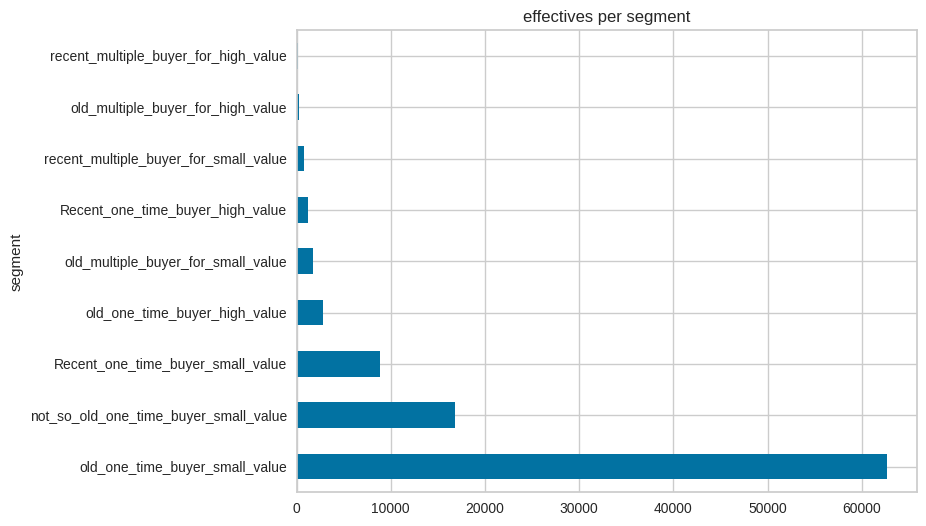

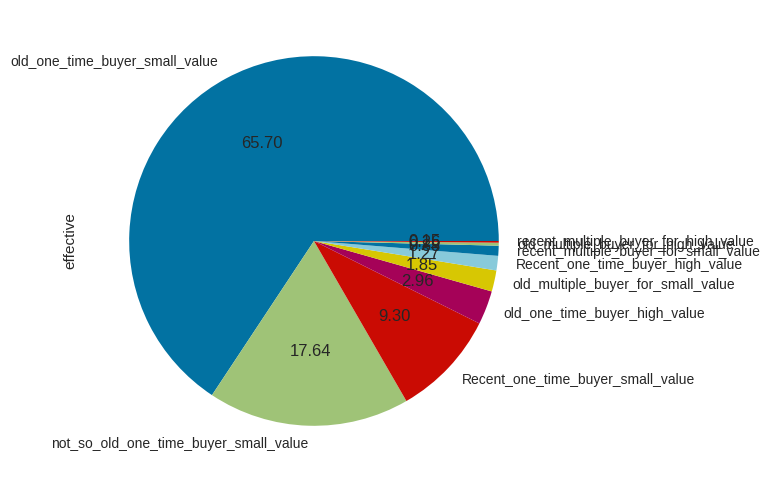

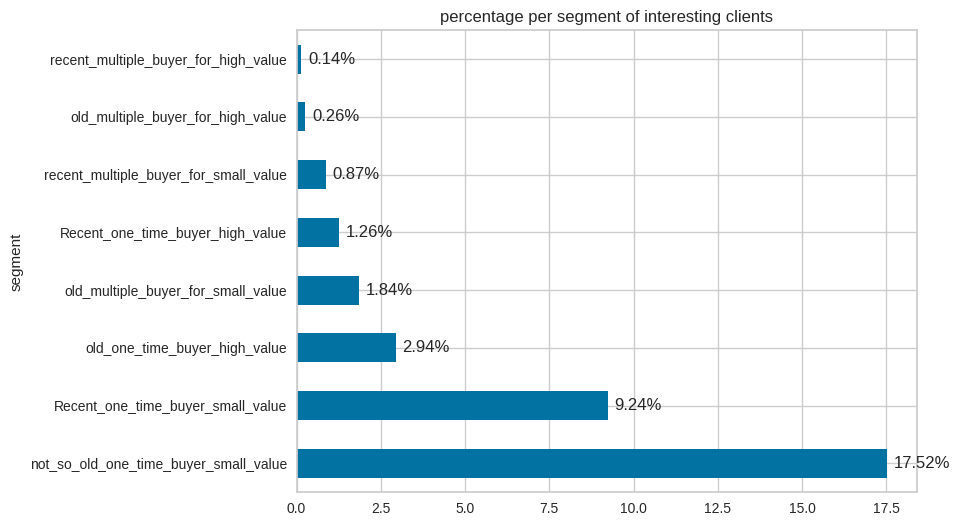

In [14]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 6))
segment_stats2.effective.plot(kind='barh', ax=ax,
                              title='effectives per segment')
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
segment_stats2.effective.plot.pie(autopct='%.2f')
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
segment_stats2.iloc[1:, :].pct.plot(kind='barh', ax=ax,
                                    title='percentage per segment of '
                                    + 'interesting clients')
for i, pct in enumerate(segment_stats2.iloc[1:, :].pct.values):
    ax.text(pct + 0.2, i, f'{pct}%', ha='left', va='center')

plt.show()



## 5.4.  [&#9650;](#toc0_) <a id='toc5_4_'></a>Visualizing clusters

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing pca, total=   0.0s


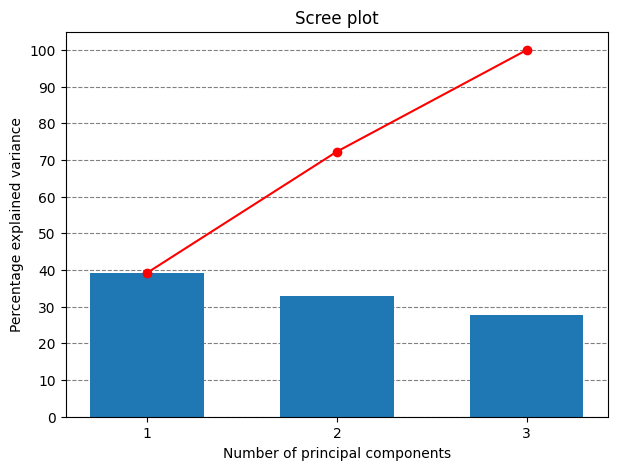

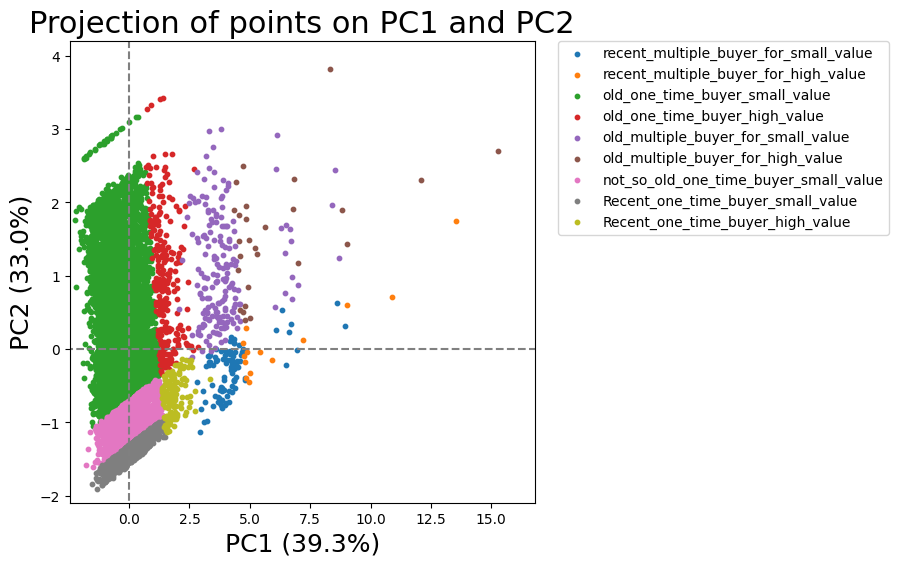

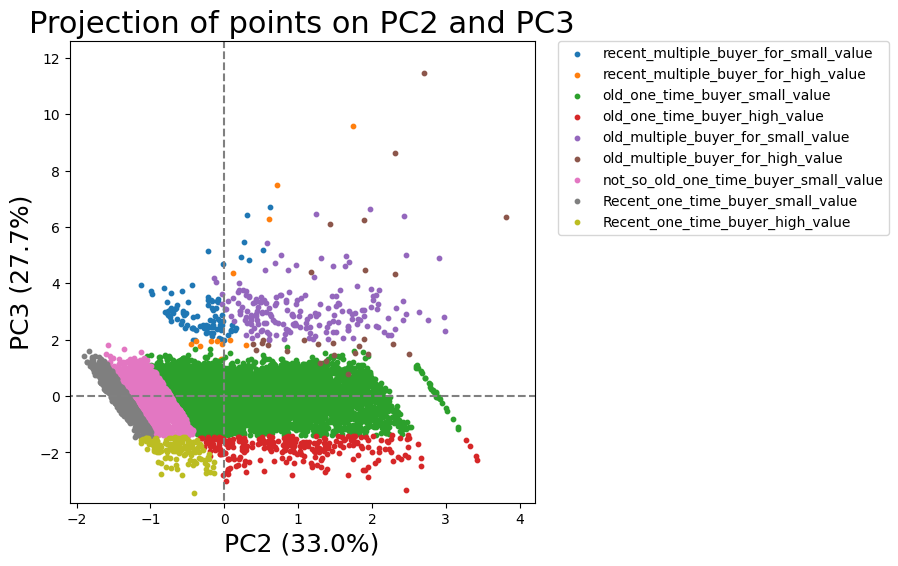

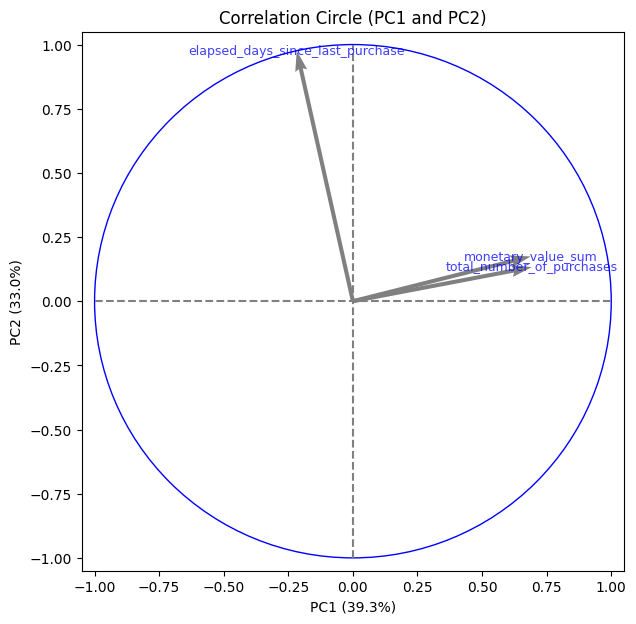

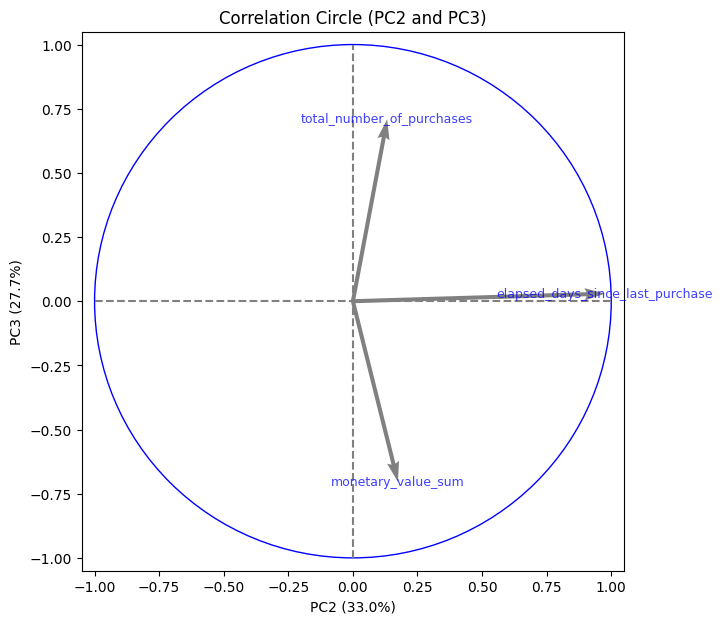

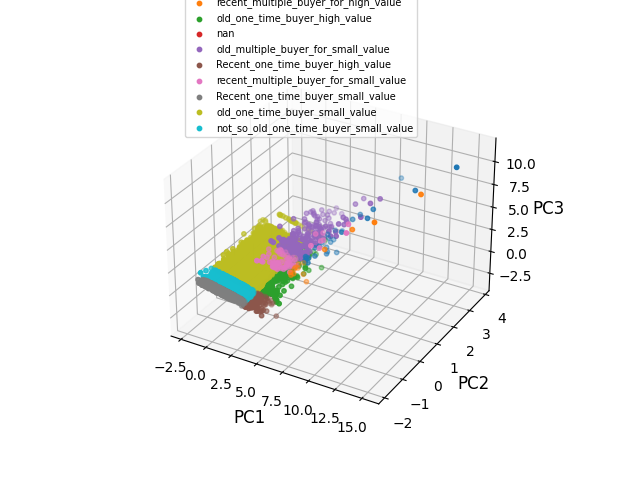

In [72]:
%matplotlib inline
skewed_fts = ['monetary_value_sum', 'total_number_of_purchases']
fts_to_scale = ['elapsed_days_since_last_purchase']
fts_pass = []
all_fts = [*skewed_fts, *fts_to_scale, *fts_pass]

input_pca = clients.dropna(axis=0).sample(10000)

log_transformer = FunctionTransformer(func=np.log1p)
pre_processor = make_column_transformer(
        (make_pipeline(log_transformer, StandardScaler()), skewed_fts),
        (StandardScaler(), fts_to_scale),
        ('passthrough', fts_pass),
)

pipe = make_pipeline(pre_processor, PCA(n_components=None), verbose=True)

clients_pca = pipe.fit_transform(input_pca)

pca = pipe[-1]
clients_pca_df = pd.DataFrame(clients_pca,
                              index=input_pca.index,
                              columns=[f"PC{n}" 
                                       for n in 
                                       range(1, clients_pca.shape[1]+1)])

ds.display_scree_plot(pca)
ds.display_factorial_plane_projection(clients_pca, pca, (0, 1),
                                      illustrative_var=input_pca.segment)
ds.display_factorial_plane_projection(clients_pca, pca, (1, 2),
                                      illustrative_var=input_pca.segment)
ds.display_correlation_circle(pca, (0, 1), all_fts)
ds.display_correlation_circle(pca, (1, 2), all_fts)

%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
palette = sns.color_palette("tab10")
for n, seg in enumerate(clients.segment.unique()[::-1]):
        ldf = clients_pca_df.loc[input_pca.query('segment == @seg').index, :]
                                 
        ax.scatter(xs=ldf.loc[:, 'PC1'],
                   ys=ldf.loc[:, 'PC2'],
                   zs=ldf.loc[:, 'PC3'],
                   s=10,
                   color=palette[n],
                   label=seg)
                
ax.set_xlabel("PC1",
              fontsize=12)
ax.set_ylabel("PC2",
              fontsize=12)
ax.set_zlabel("PC3",
              fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(0.1, 1), fontsize=7)
plt.show()


# 6.  [&#9650;](#toc0_) <a id='toc6_'></a>More feature engineering on relevant clients

The so-called relevant clients are :
- multiple-time buyers ;
- and recent one-time buyers

***
For the first ones, I want to answer the following questions :
- when is the client the most prone to buy? (so we can incite orders with short time offer on those periods.)
- Is the client spending more and more, is it stable, or decreasing (regarding the first and second halves of the client being on the plateform)?
- Is the client ordering more or not (frequency)?
- Did they stopped ordering because they were disappointed with a particular order?

For both categories, we want to understand:
- What are the principal categories the clients spends on? (to make recommendations.)


## 6.1.  [&#9650;](#toc0_) <a id='toc6_1_'></a>Selecting some clients from distinct segments.

In [67]:
!ls -alF *.csv*

-rw-rw-r-- 1 louberehc louberehc  2837268 avril  6 14:39 clients.csv.gz
-rw-rw-r-- 1 louberehc louberehc  2984794 avril 21 10:48 clients_rfm.csv.gz
-rw-rw-r-- 1 louberehc louberehc  2987876 avril 20 15:35 clients_with_kmeans_and_hc_labels.csv.gz
-rw-rw-r-- 1 louberehc louberehc 19035621 avril 25 13:06 merged_df.csv.gz


In [21]:
# Loading back the merged_df and the clients df for features engineering
df = pd.read_csv('merged_df.csv.gz')

# recast dates because nulls were introduced, thus changing the dtype
orders_date_columns = ['order_purchase_timestamp',
                       'order_approved_at',
                       'order_delivered_carrier_date',
                       'order_delivered_customer_date',
                       'order_estimated_delivery_date']

for col in orders_date_columns:
    df.loc[:, col] = pd.to_datetime(df[col])

df.info()

clients = pd.read_csv('clients_rfm.csv.gz')

display(df.head())
display(clients.head())


/tmp/ipykernel_6662/2932191174.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col] = pd.to_datetime(df[col])
/tmp/ipykernel_6662/2932191174.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col] = pd.to_datetime(df[col])
/tmp/ipykernel_6662/2932191174.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    119143 non-null  object        
 1   customer_unique_id             119143 non-null  object        
 2   customer_zip_code_prefix       119143 non-null  int64         
 3   customer_city                  119143 non-null  object        
 4   customer_state                 119143 non-null  object        
 5   order_id                       119143 non-null  object        
 6   order_status                   119143 non-null  object        
 7   order_purchase_timestamp       119143 non-null  datetime64[ns]
 8   order_approved_at              118966 non-null  datetime64[ns]
 9   order_delivered_carrier_date   117057 non-null  datetime64[ns]
 10  order_delivered_customer_date  115722 non-null  datetime64[ns]
 11  

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

    order_approved_at order_delivered_carrier_date  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57   
1 2018-01-12 20:58:32          2018-01-15 17:14:59   
2 2018-05-20 16:19:10          2018-06-11 14:31:00   
3 2018-03-13 17:29:19          2018-03-27 23:22:42   
4 2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date  order_item_id  \
0           2017-05-25 10:35:35                    2017-06-05            1.0   
1           2018-01-29 12:41:19                    2018-02-06            1.0   
2           2018-06-14 17:58:51                    2018-06-13            1.0   
3           2018-03-28 16:04:25                    2018-04-10            1.0   
4           2018-08-09 20:55:48                    2018-08-15            1.0   

                         product_id                         seller_id  \
0  a9516a079e37a9c9c36b9b78b10169e8  7c67e1448b00f6e969d365cea6b010ab   
1  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
2  bd07b66896d6f1494f5b86251848ced7  7c67e1448b00f6e969d365cea6b010ab   
3  a5647c44af977b148e0a3a4751a09e2e  7c67e1448b00f6e969d365cea6b010ab   
4  9391a573abe00141c56e38d84d7d5b3b  4a3ca9315b744ce9f8e9374361493884   

   shipping_limit_date   price  freight_value  payment_sequential  \
0  2017-05-22 15:22:12  124.99          21.88                 1.0   
1  2018-01-18 20:58:32  289.00          46.48                 1.0   
2  2018-06-05 16:19:10  139.94          17.79                 1.0   
3  2018-03-27 16:31:16  149.94          23.36                 1.0   
4  2018-07-31 10:10:09  230.00          22.25                 1.0   

  payment_type  payment_installments  payment_value  total_order_cost  \
0  credit_card                   2.0         146.87            146.87   
1  credit_card                   8.0         335.48            335.48   
2  credit_card                   7.0         157.73            157.73   
3  credit_card                   1.0         173.30            173.30   
4  credit_card                   8.0         252.25            252.25   

   total_payment_value  cost_minus_payment                         review_id  \
0               146.87                 0.0  88b8b52d46df026a9d1ad2136a59b30b   
1               335.48                 0.0  02fc48a9efa3e3d0f1a8ea26507eeec3   
2               157.73                 0.0  5ad6695d76ee186dc473c42706984d87   
3               173.30                 0.0  059a801bb31f6aab2266e672cab87bc5   
4               252.25                 0.0  8490879d58d6c5d7773f2739a03f089a   

   review_score  product_category_name product_category_name_english  \
0           4.0      moveis_escritorio              off

customer_unique_id  monetary_value_sum  \
0  0000366f3b9a7992bf8c76cfdf3221e2              141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f               27.19   
2  0000f46a3911fa3c0805444483337064               86.22   
3  0000f6ccb0745a6a4b88665a16c9f078               43.62   
4  0004aac84e0df4da2b147fca70cf8255              196.89   

   monetary_value_mean_per_order  total_number_of_purchases  \
0                         141.90                          1   
1                          27.19                          1   
2                          86.22                          1   
3                          43.62                          1   
4                         196.89                          1   

   number_of_purchases_last_365_days  number_of_purchases_last_90_days  \
0                                  1                                 0   
1                                  1                                 0   
2                                  0                                 0   
3                                  0                                 0   
4                                  1                                 0   

   number_of_purchases_last_30_days  elapsed_days_since_last_purchase  \
0                                 0                               160   
1                                 0                               163   
2                                 0                               585   
3                                 0                               369   
4                                 0                               336   

   number_of_items_ordered_max  number_of_items_ordered_min  \
0                          1.0                          1.0   
1                          1.0                          1.0   
2                          1.0                          1.0   
3                          1.0                          1.0   
4                          1.0                          1.0   

   number_of_items_mean_per_order  review_score_max  review_score_min  \
0                             1.0               5.0               5.0   
1                             1.0               4.0               4.0   
2                             1.0               3.0               3.0   
3                             1.0               4.0               4.0   
4                             1.0               5.0               5.0   

   review_score_mean  paid_less_than_due  has_had_a_non_delivered_order  \
0                5.0               False                          False   
1                4.0               False                          False   
2                3.0               False                          False   
3                4.0               False                          False   
4                5.0               False                          False   

   contracted_payment_installments  is_multiple_time_buyer  rfm_code  \
0                             True                   False     233.0   
1                            False                   False     234.0   
2                             True                   False     434.0   
3                             True                   False     434.0   
4                             True                   False     333.0   

                                 segment  
0  not_so_old_one_time_buyer_small_value  
1  not_so_old_one_time_buyer_small_value  
2         old_one_time_buyer_small_value  
3         old_one_time_buyer_small_value  
4         old_one_time_buyer_small_value

In [22]:
# Clients selection
clients_selection = pd.concat(
[clients.query('segment =="old_multiple_buyer_for_small_value"').sample(1),
clients.query('segment =="old_multiple_buyer_for_high_value"').sample(1),
clients.query('segment =="recent_multiple_buyer_for_small_value"').sample(1),
clients.query('segment =="recent_multiple_buyer_for_high_value"').sample(1),
clients.query('monetary_value_sum > 3000 and total_number_of_purchases > 1')
.sample(1),
clients.query('number_of_purchases_last_30_days > 0').sample(2),
clients.query('total_number_of_purchases > 5').sample(2),
clients.query('customer_unique_id == "6fbc7cdadbb522125f4b27ae9dee4060"'),],
axis=0)
clients_selection

customer_unique_id  monetary_value_sum  \
67540  b3a6549b3cd47a7117094faafce8b10d              179.10   
85044  e2492e4188991b6276a4a62a287a5451              636.80   
86397  e5f19a93cf85b13edc0376d90e4a0ba5               57.45   
3417   08f334e84bc7ab7b588cb7fc77dd7f4a              785.20   
33867  59d66d72939bc9497e19d89c61a96d5f             3559.99   
58710  9c3af16efacb7aa06aa3bc674556c5d6              221.54   
65954  af5454198a97379394cacf676e1e96cb              197.55   
76082  ca77025e7201e3b30c44b472ff346268             1122.72   
37585  63cfc61cee11cbe306bff5857d00bfe4              826.32   
42022  6fbc7cdadbb522125f4b27ae9dee4060              205.74   

       monetary_value_mean_per_order  total_number_of_purchases  \
67540                      59.700000                          3   
85044                     212.266667                          3   
86397                      28.725000                          2   
3417                      392.600000                          2   
33867                    1779.995000                          2   
58710                     110.770000                          2   
65954                      65.850000                          3   
76082                     160.388571                          7   
37585                     137.720000                          6   
42022                     205.740000                          1   

       number_of_purchases_last_365_days  number_of_purchases_last_90_days  \
67540                                  3                                 0   
85044                                  3                                 0   
86397                                  2                                 1   
3417                                   2                                 1   
33867                                  0                                 0   
58710                                  2                                 2   
65954                                  3                                 3   
76082                                  6                                 0   
37585                                  3                                 0   
42022                                  0                                 0   

       number_of_purchases_last_30_days  elapsed_days_since_last_purchase  \
67540                                 0                               198   
85044                                 0                               190   
86397                                 0                                81   
3417                                  0                                63   
33867                                 0                               432   
58710                                 1                                22   
65954                                 1                                13   
76082                                 0                               138   
37585                                 0                               142   
42022                                 0                               389   

       number_of_items_ordered_max  number_of_items_ordered_min  \
67540                          1.0                          1.0   
85044                          2.0                          1.0   
86397                          1.0                          1.0   
3417                           1.0                          1.0   
33867                          1.0                          1.0   
58710                          2.0                          2.0   
65954                          1.0                          1.0   
76082                          4.0                          1.0   
37585                          3.0                          1.0   
42022                          2.0                          2.0   

       number_of_items_mean_per_order  review_score_max  review_score_min  \
67540                        1.000000               5.0            

In [23]:
# Create and displaying those clients (client1, ..., clientn)
clients_id = clients_selection.customer_unique_id.values

for n, client_id in enumerate(clients_id):
    var_name = "client" + str(n+1)
    print(var_name)
    print(client_id)
    exec(var_name
         + " = df.query('customer_unique_id == @client_id')")
    display(eval(var_name))

# Join them in a dict
example_clients = {("client" + str(n)): eval("client" + str(n))
                   for n in range(1, len(clients_id)+1)}

example_clients_df = pd.concat([eval("client" + str(n))
                                for n in range(1, len(clients_id)+1)],
                               axis=0)
example_clients_df.head(10)

client1
b3a6549b3cd47a7117094faafce8b10d


customer_id                customer_unique_id  \
93813   fa9bad1e16c46aacf561f2240fd0109c  b3a6549b3cd47a7117094faafce8b10d   
111718  0a88dbb52560ef62331305c8c92488b8  b3a6549b3cd47a7117094faafce8b10d   
111840  1e7b6cc033a72b59bd69c4a3f3a382c3  b3a6549b3cd47a7117094faafce8b10d   

        customer_zip_code_prefix customer_city customer_state  \
93813                      11444       guaruja             SP   
111718                      6036        osasco             SP   
111840                      6036        osasco             SP   

                                order_id order_status  \
93813   62c0a0e72baba526d6f9c2855f8b6b97    delivered   
111718  bcfacaaecd67dc247a67377e23b348ae    delivered   
111840  86661cdf65d5e08c3dc14b073c101d68    delivered   

       order_purchase_timestamp   order_approved_at  \
93813       2018-04-01 23:02:25 2018-04-03 05:10:34   
111718      2018-02-04 12:49:51 2018-02-06 05:31:48   
111840      2018-02-24 10:35:46 2018-02-27 03:31:09   

       order_delivered_carrier_date order_delivered_customer_date  \
93813           2018-04-03 20:32:50           2018-04-04 22:08:53   
111718          2018-02-07 19:04:04           2018-02-14 22:33:38   
111840          2018-02-27 19:58:39           2018-03-01 22:09:19   

       order_estimated_delivery_date  order_item_id  \
93813                     2018-04-12            1.0   
111718                    2018-03-05            1.0   
111840                    2018-03-12            1.0   

                              product_id                         seller_id  \
93813   c211c9404dc28e0540fd11e5a9e17bf5  2e13c71026e1a39ba5cc1b86dcb679aa   
111718  4c8b28305f570899b6ded964ddd234a9  ccf8813e5a7d6c84d865cd38bfc2b130   
111840  460a66fcc404a3d7306d5f50fcb2d18a  ffc470761de7d0232558ba5e786e57b7   

        shipping_limit_date  price  freight_value  payment_sequential  \
93813   2018-04-09 05:10:34   28.0           7.39                 1.0   
111718  2018-02-12 04:34:14   98.0          13.03                 1.0   
111840  2018-03-05 03:15:45   24.9           7.78                 1.0   

       payment_type  payment_installments  payment_value  total_order_cost  \
93813        boleto                   1.0          35.39             35.39   
111718       boleto                   1.0         111.03            111.03   
111840       boleto                   1.0          32.68             32.68   

        total_payment_value  cost_minus_payment  \
93813                 35.39                 0.0   
111718               111.03                 0.0   
111840                32.68                 0.0   

                               review_id  review_score  product_category_name  \
93813   9114c9aa04fa9703450e47a03251f510           5.0          esporte_lazer   
111718  8264d36d7d2acdd5be3cce51ebab7ea2           5.0       moveis_decoracao   
111840  b090e39770b2181aefde4ffc5b3a556b           5.0  utilidades_domesticas   

       product_category_name_english large_product_category  \
93813                 sports_leisure         sports_leisure   
111718               furniture_decor                   home   
111840                    housewares                   home   

       binary_order_status  
93813            delivered  
111718           delivered  
111840           delivered

client2
e2492e4188991b6276a4a62a287a5451


customer_id                customer_unique_id  \
45014   5b36926fe1592a897dfb56c425ad5b48  e2492e4188991b6276a4a62a287a5451   
48365   594ac4b8f0fcbfbcf382ab0da137d00d  e2492e4188991b6276a4a62a287a5451   
48366   594ac4b8f0fcbfbcf382ab0da137d00d  e2492e4188991b6276a4a62a287a5451   
106613  a48b14b74f4daa3f589086dd35afe553  e2492e4188991b6276a4a62a287a5451   
106614  a48b14b74f4daa3f589086dd35afe553  e2492e4188991b6276a4a62a287a5451   

        customer_zip_code_prefix    customer_city customer_state  \
45014                       8880  mogi das cruzes             SP   
48365                       8880  mogi das cruzes             SP   
48366                       8880  mogi das cruzes             SP   
106613                      8880  mogi das cruzes             SP   
106614                      8880  mogi das cruzes             SP   

                                order_id order_status  \
45014   a96157730ca02d9de4c4e4ac2fc49f2c    delivered   
48365   d43547ebdfd7f5f70df830db89710200    delivered   
48366   d43547ebdfd7f5f70df830db89710200    delivered   
106613  11ff2af78a9ec50c26f9cbbc62a10d38    delivered   
106614  11ff2af78a9ec50c26f9cbbc62a10d38    delivered   

       order_purchase_timestamp   order_approved_at  \
45014       2018-02-06 08:38:54 2018-02-08 07:35:35   
48365       2018-04-10 08:52:51 2018-04-12 05:50:54   
48366       2018-04-10 08:52:51 2018-04-12 05:50:54   
106613      2018-02-01 08:52:15 2018-02-03 02:53:47   
106614      2018-02-01 08:52:15 2018-02-03 02:53:47   

       order_delivered_carrier_date order_delivered_customer_date  \
45014           2018-02-08 23:46:30           2018-02-21 14:05:57   
48365           2018-04-13 19:20:38           2018-04-24 15:12:32   
48366           2018-04-13 19:20:38           2018-04-24 15:12:32   
106613          2018-02-06 00:45:55           2018-02-16 15:35:44   
106614          2018-02-06 00:45:55           2018-02-16 15:35:44   

       order_estimated_delivery_date  order_item_id  \
45014                     2018-03-09            1.0   
48365                     2018-05-03            1.0   
48366                     2018-05-03            2.0   
106613                    2018-02-23            1.0   
106614                    2018-02-23            2.0   

                              product_id                         seller_id  \
45014   a38b238734207eeb0388676235cf56ec  86ccac0b835037332a596a33b6949ee1   
48365   a62e25e09e05e6faf31d90c6ec1aa3d1  634964b17796e64304cadf1ad3050fb7   
48366   a62e25e09e05e6faf31d90c6ec1aa3d1  634964b17796e64304cadf1ad3050fb7   
106613  a62e25e09e05e6faf31d90c6ec1aa3d1  634964b17796e64304cadf1ad3050fb7   
106614  a62e25e09e05e6faf31d90c6ec1aa3d1  634964b17796e64304cadf1ad3050fb7   

        shipping_limit_date  price  freight_value  payment_sequential  \
45014   2018-02-14 07:35:35  125.0          21.36                 1.0   
48365   2018-04-18 05:50:54  105.0          16.70                 1.0   
48366   2018-04-18 05:50:54  105.0          16.70                 1.0   
106613  2018-02-08 02:53:47  108.0          15.52                 1.0   
106614  2018-02-08 02:53:47  108.0          15.52                 1.0   

       payment_type  payment_installments  payment_value  total_order_cost  \
45014        boleto                   1.0         146.36            146.36   
48365        boleto                   1.0         243.40            243.40   
48366        boleto                   1.0         243.40            243.40   
106613       boleto                   1.0         247.04            247.04   
106614       boleto                   1.0         247.04            247.04   

        total_payment_value  cost_minus_payment  \
45014                146.36                 0.0   
48365                243.40                 0.0   
48366                243.40                 0.0   
106613               247.04                 0.0   
106614               247.04                 0.0   

                               review_id  revie

client3
e5f19a93cf85b13edc0376d90e4a0ba5


customer_id                customer_unique_id  \
103769  d4d3ce7e6e51f287f5c2d896b0b07bae  e5f19a93cf85b13edc0376d90e4a0ba5   
109619  5bc33d498a4eb8a94cd2e1ccdf44f45c  e5f19a93cf85b13edc0376d90e4a0ba5   

        customer_zip_code_prefix customer_city customer_state  \
103769                     13311           itu             SP   
109619                     13311           itu             SP   

                                order_id order_status  \
103769  a852cc31ae30e70e308d7e21bcc47990    delivered   
109619  96252dd234004b6e9d4dc740779742a8    delivered   

       order_purchase_timestamp   order_approved_at  \
103769      2018-07-28 00:54:33 2018-07-28 01:10:07   
109619      2018-04-07 00:16:14 2018-04-10 04:10:40   

       order_delivered_carrier_date order_delivered_customer_date  \
103769          2018-07-30 17:09:00           2018-07-31 14:08:56   
109619          2018-04-10 21:58:32           2018-04-11 22:32:01   

       order_estimated_delivery_date  order_item_id  \
103769                    2018-08-07            1.0   
109619                    2018-04-25            1.0   

                              product_id                         seller_id  \
103769  9376771cb92c045ec36c97fb810f1f90  f9ec7093df3a7b346b7bcf7864069ca3   
109619  dd60cac04e6bcbc919cb1c7dcc473211  febab0275244b9a49a623f0bd613ca2f   

        shipping_limit_date  price  freight_value  payment_sequential  \
103769  2018-08-01 01:10:07   10.9           7.39                 1.0   
109619  2018-04-16 04:10:40   29.9           9.26                 1.0   

       payment_type  payment_installments  payment_value  total_order_cost  \
103769  credit_card                   1.0          18.29             18.29   
109619       boleto                   1.0          39.16             39.16   

        total_payment_value  cost_minus_payment  \
103769                18.29                 0.0   
109619                39.16                 0.0   

                               review_id  review_score  product_category_name  \
103769  2f43ae8448bbbad2adf12515864d3b5b           5.0  utilidades_domesticas   
109619  f559c4bb5749e68ada3c5c210c1fa729           5.0  utilidades_domesticas   

       product_category_name_english large_product_category  \
103769                    housewares                   home   
109619                    housewares                   home   

       binary_order_status  
103769           delivered  
109619           delivered

client4
08f334e84bc7ab7b588cb7fc77dd7f4a


customer_id                customer_unique_id  \
35813   953f71324f3a770118c88a42363655b2  08f334e84bc7ab7b588cb7fc77dd7f4a   
113241  3ace417f46e2feb1f83c8e8ee4186547  08f334e84bc7ab7b588cb7fc77dd7f4a   

        customer_zip_code_prefix customer_city customer_state  \
35813                       5048     sao paulo             SP   
113241                      5048     sao paulo             SP   

                                order_id order_status  \
35813   f81e71dd7c044a9ee7c1d6e37d68d64f     canceled   
113241  67be6410d453784501c125d4f0ecb741    delivered   

       order_purchase_timestamp   order_approved_at  \
35813       2018-08-15 08:34:42                 NaT   
113241      2018-07-14 18:19:56 2018-07-14 18:30:19   

       order_delivered_carrier_date order_delivered_customer_date  \
35813                           NaT                           NaT   
113241          2018-07-16 16:20:00           2018-07-20 20:21:55   

       order_estimated_delivery_date  order_item_id  \
35813                     2018-09-12            NaN   
113241                    2018-08-10            1.0   

                              product_id                         seller_id  \
35813                                NaN                               NaN   
113241  61107c91091400f4c4523ed7b461a20e  b32be1695eb7ec5f10f72d9610a12527   

        shipping_limit_date  price  freight_value  payment_sequential  \
35813                   NaN    NaN            NaN                 1.0   
113241  2018-07-20 18:30:19  699.0           86.2                 1.0   

       payment_type  payment_installments  payment_value  total_order_cost  \
35813       voucher                   1.0          785.2               0.0   
113241  credit_card                   4.0          785.2             785.2   

        total_payment_value  cost_minus_payment  \
35813                 785.2              -785.2   
113241                785.2                 0.0   

                               review_id  review_score  product_category_name  \
35813   58f1655df206a9a40482b929b81ee671           1.0                unknown   
113241  58f1655df206a9a40482b929b81ee671           1.0  utilidades_domesticas   

       product_category_name_english large_product_category  \
35813                        unknown                unknown   
113241                    housewares                   home   

       binary_order_status  
35813        not_delivered  
113241           delivered

client5
59d66d72939bc9497e19d89c61a96d5f


customer_id                customer_unique_id  \
109835  207735d42a0b6ca67f5049af8c1640cd  59d66d72939bc9497e19d89c61a96d5f   
111792  0c5292f5e3690805390efddf53935915  59d66d72939bc9497e19d89c61a96d5f   

        customer_zip_code_prefix customer_city customer_state  \
109835                      2435     sao paulo             SP   
111792                      2435     sao paulo             SP   

                                order_id order_status  \
109835  a76390702d2f24f9e0d5ad3c5e9ec562    delivered   
111792  fb441bffe443e71cb16477c4743591e8    delivered   

       order_purchase_timestamp   order_approved_at  \
109835      2017-08-10 22:09:50 2017-08-10 22:25:18   
111792      2017-03-02 12:13:18 2017-03-02 13:05:58   

       order_delivered_carrier_date order_delivered_customer_date  \
109835          2017-08-22 20:30:06           2017-08-24 13:57:31   
111792          2017-03-15 15:59:24           2017-03-21 18:35:51   

       order_estimated_delivery_date  order_item_id  \
109835                    2017-08-23            1.0   
111792                    2017-03-30            1.0   

                              product_id                         seller_id  \
109835  34742604f6cd1e891726b849b6890f81  76d5af76d0271110f9af36c92573f765   
111792  5263b67de8e3edbade45ea923f6c4e79  70eea00b476a314817cefde4aad4f89a   

        shipping_limit_date   price  freight_value  payment_sequential  \
109835  2017-08-16 22:25:18   859.0          74.92                 1.0   
111792  2017-03-22 13:05:58  2600.0          26.07                 1.0   

       payment_type  payment_installments  payment_value  total_order_cost  \
109835  credit_card                  10.0         933.92            933.92   
111792  credit_card                  10.0        2626.07           2626.07   

        total_payment_value  cost_minus_payment  \
109835               933.92                 0.0   
111792              2626.07                 0.0   

                               review_id  review_score product_category_name  \
109835  51cc55133c975a17ec616128574d2337           5.0         esporte_lazer   
111792  322fc966b6490e0531c222edd558d79f           5.0         esporte_lazer   

       product_category_name_english large_product_category  \
109835                sports_leisure         sports_leisure   
111792                sports_leisure         sports_leisure   

       binary_order_status  
109835           delivered  
111792           delivered

client6
9c3af16efacb7aa06aa3bc674556c5d6


customer_id                customer_unique_id  \
39803  7a8a02e54cf3472df427e927f8b9c046  9c3af16efacb7aa06aa3bc674556c5d6   
49948  681986e7db7f47399570f6ed6a34f53c  9c3af16efacb7aa06aa3bc674556c5d6   
49949  681986e7db7f47399570f6ed6a34f53c  9c3af16efacb7aa06aa3bc674556c5d6   

       customer_zip_code_prefix   customer_city customer_state  \
39803                     30170  belo horizonte             MG   
49948                     30170  belo horizonte             MG   
49949                     30170  belo horizonte             MG   

                               order_id order_status order_purchase_timestamp  \
39803  5aac76cf7b07dd06fa4d50bf461d2f40     canceled      2018-09-25 11:59:18   
49948  b2b8934746a9afa7b38c8c1f88268ecb    delivered      2018-08-02 12:06:07   
49949  b2b8934746a9afa7b38c8c1f88268ecb    delivered      2018-08-02 12:06:07   

        order_approved_at order_delivered_carrier_date  \
39803                 NaT                          NaT   
49948 2018-08-02 13:04:06          2018-08-08 14:20:00   
49949 2018-08-02 13:04:06          2018-08-08 14:20:00   

      order_delivered_customer_date order_estimated_delivery_date  \
39803                           NaT                    2018-10-11   
49948           2018-08-13 21:38:56                    2018-08-20   
49949           2018-08-13 21:38:56                    2018-08-20   

       order_item_id                        product_id  \
39803            NaN                               NaN   
49948            1.0  e84fb20fe338824c220166d3cd562cbd   
49949            2.0  e84fb20fe338824c220166d3cd562cbd   

                              seller_id  shipping_limit_date  price  \
39803                               NaN                  NaN    NaN   
49948  c70c1b0d8ca86052f45a432a38b73958  2018-08-08 13:04:06   95.0   
49949  c70c1b0d8ca86052f45a432a38b73958  2018-08-08 13:04:06   95.0   

       freight_value  payment_sequential payment_type  payment_installments  \
39803            NaN                 1.0      voucher                   1.0   
49948          15.77                 1.0  credit_card                   3.0   
49949          15.77                 1.0  credit_card                   3.0   

       payment_value  total_order_cost  total_payment_value  \
39803         221.54              0.00               221.54   
49948         221.54            221.54               221.54   
49949         221.54            221.54               221.54   

       cost_minus_payment                         review_id  review_score  \
39803             -221.54  e6acae33a98861be63cf635525330891           1.0   
49948                0.00  e6acae33a98861be63cf635525330891           1.0   
49949                0.00  e6acae33a98861be63cf635525330891           1.0   

      product_category_name product_category_name_english  \
39803               unknown                       unknown   
49948          beleza_saude                 health_beauty   
49949          beleza_saude                 health_beauty   

      large_product_category binary_order_status  
39803                unknown       not_delivered  
49948      health_and_beauty           delivered  
49949      health_and_beauty           delivered

client7
af5454198a97379394cacf676e1e96cb


customer_id                customer_unique_id  \
35131  900ba4df9838bd25ef994e0483fefb49  af5454198a97379394cacf676e1e96cb   
63511  0ab5ac09913dfd3f247c7929a3799799  af5454198a97379394cacf676e1e96cb   
81825  4c2ec60c29d10c34bd49cb88aa85cfc4  af5454198a97379394cacf676e1e96cb   

       customer_zip_code_prefix customer_city customer_state  \
35131                     11900      registro             SP   
63511                     11900      registro             SP   
81825                     11900      registro             SP   

                               order_id order_status order_purchase_timestamp  \
35131  73a8ed1078e1d475d2b1fb7216a52e1a    delivered      2018-08-10 10:39:43   
63511  cfdfd7862e532c4ec1ed1c6a1b56d320     canceled      2018-09-03 18:45:34   
81825  a2ac6dad85cf8af5b0afb510a240fe8c     canceled      2018-10-03 18:55:29   

        order_approved_at order_delivered_carrier_date  \
35131 2018-08-14 04:50:12          2018-08-14 09:07:00   
63511                 NaT                          NaT   
81825                 NaT                          NaT   

      order_delivered_customer_date order_estimated_delivery_date  \
35131           2018-08-17 21:21:58                    2018-08-22   
63511                           NaT                    2018-09-14   
81825                           NaT                    2018-10-16   

       order_item_id                        product_id  \
35131            1.0  7a10f0794d6c8bf257417ac22866e78d   
63511            NaN                               NaN   
81825            NaN                               NaN   

                              seller_id  shipping_limit_date  price  \
35131  a7dc4098e4da6e41b426269d12ae7e91  2018-08-20 04:50:12  178.0   
63511                               NaN                  NaN    NaN   
81825                               NaN                  NaN    NaN   

       freight_value  payment_sequential payment_type  payment_installments  \
35131          19.55                 1.0       boleto                   1.0   
63511            NaN                 1.0      voucher                   1.0   
81825            NaN                 1.0      voucher                   1.0   

       payment_value  total_order_cost  total_payment_value  \
35131         197.55            197.55               197.55   
63511         197.55              0.00               197.55   
81825         197.55              0.00               197.55   

       cost_minus_payment                         review_id  review_score  \
35131                0.00  4548534449b1f572e357211b90724f1b           1.0   
63511             -197.55  4548534449b1f572e357211b90724f1b           1.0   
81825             -197.55  4548534449b1f572e357211b90724f1b           1.0   

      product_category_name product_category_name_english  \
35131            automotivo                          auto   
63511               unknown                       unknown   
81825               unknown                       unknown   

      large_product_category binary_order_status  
35131                   auto           delivered  
63511                unknown       not_delivered  
81825                unknown       not_delivered

client8
ca77025e7201e3b30c44b472ff346268


customer_id                customer_unique_id  \
31632  dc7dc47999d1b3c4c2f6a085a1a76eef  ca77025e7201e3b30c44b472ff346268   
31633  dc7dc47999d1b3c4c2f6a085a1a76eef  ca77025e7201e3b30c44b472ff346268   
31634  dc7dc47999d1b3c4c2f6a085a1a76eef  ca77025e7201e3b30c44b472ff346268   
32165  6ccedfba5919d72fcc8c51bfa982de62  ca77025e7201e3b30c44b472ff346268   
42531  c59e684f832f832056ceee2c310cfc7f  ca77025e7201e3b30c44b472ff346268   
53551  852e5ea6e9d74416ddf88bdbdb3189b9  ca77025e7201e3b30c44b472ff346268   
53552  852e5ea6e9d74416ddf88bdbdb3189b9  ca77025e7201e3b30c44b472ff346268   
53553  852e5ea6e9d74416ddf88bdbdb3189b9  ca77025e7201e3b30c44b472ff346268   
53554  852e5ea6e9d74416ddf88bdbdb3189b9  ca77025e7201e3b30c44b472ff346268   
67764  71f39c371308d132d7633895477dd307  ca77025e7201e3b30c44b472ff346268   
74583  b145bff18e79ac4dfb3fb91e61906f38  ca77025e7201e3b30c44b472ff346268   
81580  fc709ab645b71acd6046aeb03b590aa5  ca77025e7201e3b30c44b472ff346268   

       customer_zip_code_prefix customer_city customer_state  \
31632                     51021        recife             PE   
31633                     51021        recife             PE   
31634                     51021        recife             PE   
32165                     51021        recife             PE   
42531                     51021        recife             PE   
53551                     51021        recife             PE   
53552                     51021        recife             PE   
53553                     51021        recife             PE   
53554                     51021        recife             PE   
67764                     51021        recife             PE   
74583                     51021        recife             PE   
81580                     51021        recife             PE   

                               order_id order_status order_purchase_timestamp  \
31632  9e22fb4a47d29059ef9689ca8b26d8b3    delivered      2018-02-17 01:22:20   
31633  9e22fb4a47d29059ef9689ca8b26d8b3    delivered      2018-02-17 01:22:20   
31634  9e22fb4a47d29059ef9689ca8b26d8b3    delivered      2018-02-17 01:22:20   
32165  8dacd1da7c4dc40d5c59e7ddd93b3ac8    delivered      2018-06-01 11:38:29   
42531  f3584b023b097595c8e2b0b6fd51a839    delivered      2018-01-25 21:10:57   
53551  cc9782f02aae34f01d12f3dbee4d5d93    delivered      2018-05-03 06:11:22   
53552  cc9782f02aae34f01d12f3dbee4d5d93    delivered      2018-05-03 06:11:22   
53553  cc9782f02aae34f01d12f3dbee4d5d93    delivered      2018-05-03 06:11:22   
53554  cc9782f02aae34f01d12f3dbee4d5d93    delivered      2018-05-03 06:11:22   
67764  d07179898f582cd4b62f9f5328698baf    delivered      2018-04-26 11:44:48   
74583  c70e1bd940c5723bf066a1dbcc1455e8    delivered      2018-02-09 15:43:37   
81580  ee84d18908ccf2b4c57008c552b98d1c    delivered      2017-10-09 12:34:39   

        order_approved_at order_delivered_carrier_date  \
31632 2018-02-17 02:07:45          2018-02-19 15:48:39   
31633 2018-02-17 02:07:45          2018-02-19 15:48:39   
31634 2018-02-17 02:07:45          2018-02-19 15:48:39   
32165 2018-06-02 03:31:41          2018-06-04 14:37:00   
42531 2018-01-25 21:18:23          2018-01-26 23:38:48   
53551 2018-05-03 06:32:14          2018-05-04 12:50:00   
53552 2018-05-03 06:32:14          2018-05-04 12:50:00   
53553 2018-05-03 06:32:14          2018-05-04 12:50:00   
53554 2018-05-03 06:32:14          2018-05-04 12:50:00   
67764 2018-04-26 11:55:27          2018-05-02 14:21:00   
74583 2018-02-10 10:18:45          2018-02-14 21:57:04   
81580 2017-10-10 03:26:26          2017-10-16 19:04:42   

      order_delivered_customer_date order_estimated_delivery_date  \
31632           2018-03-12 22:05:09                    2018-03-19   
31633           2018-03-12 22:05:09                    2018-03-19   
31634           2018-03-12 22:05:09                    2018-03-19   
32165           2018-06-12 22:34:44                    2018-07-18   
42531           2018-02-06 22:26:16    

client9
63cfc61cee11cbe306bff5857d00bfe4


customer_id                customer_unique_id  \
12739   cd8703bc42155c8d57115a689efb6ec6  63cfc61cee11cbe306bff5857d00bfe4   
12740   cd8703bc42155c8d57115a689efb6ec6  63cfc61cee11cbe306bff5857d00bfe4   
76179   c02ecc12c729541a4fcce88b8f42391d  63cfc61cee11cbe306bff5857d00bfe4   
76180   c02ecc12c729541a4fcce88b8f42391d  63cfc61cee11cbe306bff5857d00bfe4   
76181   c02ecc12c729541a4fcce88b8f42391d  63cfc61cee11cbe306bff5857d00bfe4   
78072   7d1219e8f53f6b445b3d230c0794e337  63cfc61cee11cbe306bff5857d00bfe4   
87727   906614004e38a1e922ff033563bfdcf2  63cfc61cee11cbe306bff5857d00bfe4   
88266   a2922aea328704a90286d7b51b05b633  63cfc61cee11cbe306bff5857d00bfe4   
101691  7135726787ec7c5289c24668a8ac75d7  63cfc61cee11cbe306bff5857d00bfe4   
101692  7135726787ec7c5289c24668a8ac75d7  63cfc61cee11cbe306bff5857d00bfe4   
101693  7135726787ec7c5289c24668a8ac75d7  63cfc61cee11cbe306bff5857d00bfe4   

        customer_zip_code_prefix   customer_city customer_state  \
12739                      23535  rio de janeiro             RJ   
12740                      23535  rio de janeiro             RJ   
76179                      23535  rio de janeiro             RJ   
76180                      23535  rio de janeiro             RJ   
76181                      23535  rio de janeiro             RJ   
78072                      23535  rio de janeiro             RJ   
87727                      23535  rio de janeiro             RJ   
88266                      23535  rio de janeiro             RJ   
101691                     23535  rio de janeiro             RJ   
101692                     23535  rio de janeiro             RJ   
101693                     23535  rio de janeiro             RJ   

                                order_id order_status  \
12739   d37c9e8893d10d17fbf866c85f0dde90    delivered   
12740   d37c9e8893d10d17fbf866c85f0dde90    delivered   
76179   43cc1b49644de5e13af22777e83a7808    delivered   
76180   43cc1b49644de5e13af22777e83a7808    delivered   
76181   43cc1b49644de5e13af22777e83a7808    delivered   
78072   287e90d08a100fd2ecbfd8a82dddad5b    delivered   
87727   c29713133e5e33937af1a6e1e1370552    delivered   
88266   fd1c3bee1ee3b10e9f65bd92b3ebba38    delivered   
101691  b4617485242633fa27f00e4f1a051e0a    delivered   
101692  b4617485242633fa27f00e4f1a051e0a    delivered   
101693  b4617485242633fa27f00e4f1a051e0a    delivered   

       order_purchase_timestamp   order_approved_at  \
12739       2017-05-21 16:19:58 2017-05-21 16:30:14   
12740       2017-05-21 16:19:58 2017-05-21 16:30:14   
76179       2018-02-03 13:49:34 2018-02-03 14:10:09   
76180       2018-02-03 13:49:34 2018-02-03 14:10:09   
76181       2018-02-03 13:49:34 2018-02-03 14:10:09   
78072       2017-05-11 14:39:53 2017-05-11 14:50:17   
87727       2018-05-28 17:20:02 2018-05-28 17:35:09   
88266       2017-06-22 13:35:21 2017-06-22 13:45:12   
101691      2017-10-17 17:19:13 2017-10-17 17:37:02   
101692      2017-10-17 17:19:13 2017-10-17 17:37:02   
101693      2017-10-17 17:19:13 2017-10-17 17:37:02   

       order_delivered_carrier_date order_delivered_customer_date  \
12739           2017-05-22 11:19:04           2017-05-26 20:49:53   
12740           2017-05-22 11:19:04           2017-05-26 20:49:53   
76179           2018-02-06 16:51:53           2018-02-14 19:38:42   
76180           2018-02-06 16:51:53           2018-02-14 19:38:42   
76181           2018-02-06 16:51:53           2018-02-14 19:38:42   
78072           2017-05-12 11:14:30           2017-05-22 16:13:36   
87727           2018-05-29 14:22:00           2018-06-07 18:38:24   
88266           2017-06-26 14:41:40           2017-07-07 21:22:03   
101691          2017-10-18 15:23:06           2017-10-26 17:57:50   
101692          2017-10-18 15:23:06           2017-10-26 17:57:50   
101693          2017-10-18 15:23:06           2017-10-26 17:57:50   

       order_estimated_delivery_date  order_item_id  \
12739                     2017-06-13            1.0   
12

client10
6fbc7cdadbb522125f4b27ae9dee4060


customer_id                customer_unique_id  \
58729  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58730  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58731  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58732  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58733  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58734  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58735  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58736  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58737  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58738  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58739  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58740  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58741  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58742  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58743  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58744  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58745  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58746  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58747  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58748  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58749  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58750  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58751  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58752  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58753  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58754  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58755  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58756  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58757  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58758  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58759  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58760  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58761  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58762  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58763  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58764  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58765  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   
58766  13aa59158da63ba0e93ec6ac2c07aacb  6fbc7cdadbb522125f4b27ae9dee4060   

       customer_zip_code_prefix   customer_city customer_state  \
58729                     23070  rio de janeiro             RJ   
58730                     23070  rio de janeiro             RJ   
58731                     23070  rio de janeiro             RJ   
58732                     23070  rio de janeiro             RJ   
58733                     23070  rio de janeiro             RJ   
58734                     23070  rio de janeiro             RJ   
58735                     23070  rio de janeiro             RJ   
58736                     23070  rio de janeiro             RJ   
58737                     23070  rio de janeiro             RJ   
58738                     23070  rio de janeiro             RJ   
58739                     23070  rio de janeiro             RJ   
58740                     23070  rio de janeiro             RJ   
58741                     23070  rio de janeiro             RJ   
58742                     23070  rio de janeiro             RJ   
58743                     23070  r

customer_id                customer_unique_id  \
93813   fa9bad1e16c46aacf561f2240fd0109c  b3a6549b3cd47a7117094faafce8b10d   
111718  0a88dbb52560ef62331305c8c92488b8  b3a6549b3cd47a7117094faafce8b10d   
111840  1e7b6cc033a72b59bd69c4a3f3a382c3  b3a6549b3cd47a7117094faafce8b10d   
45014   5b36926fe1592a897dfb56c425ad5b48  e2492e4188991b6276a4a62a287a5451   
48365   594ac4b8f0fcbfbcf382ab0da137d00d  e2492e4188991b6276a4a62a287a5451   
48366   594ac4b8f0fcbfbcf382ab0da137d00d  e2492e4188991b6276a4a62a287a5451   
106613  a48b14b74f4daa3f589086dd35afe553  e2492e4188991b6276a4a62a287a5451   
106614  a48b14b74f4daa3f589086dd35afe553  e2492e4188991b6276a4a62a287a5451   
103769  d4d3ce7e6e51f287f5c2d896b0b07bae  e5f19a93cf85b13edc0376d90e4a0ba5   
109619  5bc33d498a4eb8a94cd2e1ccdf44f45c  e5f19a93cf85b13edc0376d90e4a0ba5   

        customer_zip_code_prefix    customer_city customer_state  \
93813                      11444          guaruja             SP   
111718                      6036           osasco             SP   
111840                      6036           osasco             SP   
45014                       8880  mogi das cruzes             SP   
48365                       8880  mogi das cruzes             SP   
48366                       8880  mogi das cruzes             SP   
106613                      8880  mogi das cruzes             SP   
106614                      8880  mogi das cruzes             SP   
103769                     13311              itu             SP   
109619                     13311              itu             SP   

                                order_id order_status  \
93813   62c0a0e72baba526d6f9c2855f8b6b97    delivered   
111718  bcfacaaecd67dc247a67377e23b348ae    delivered   
111840  86661cdf65d5e08c3dc14b073c101d68    delivered   
45014   a96157730ca02d9de4c4e4ac2fc49f2c    delivered   
48365   d43547ebdfd7f5f70df830db89710200    delivered   
48366   d43547ebdfd7f5f70df830db89710200    delivered   
106613  11ff2af78a9ec50c26f9cbbc62a10d38    delivered   
106614  11ff2af78a9ec50c26f9cbbc62a10d38    delivered   
103769  a852cc31ae30e70e308d7e21bcc47990    delivered   
109619  96252dd234004b6e9d4dc740779742a8    delivered   

       order_purchase_timestamp   order_approved_at  \
93813       2018-04-01 23:02:25 2018-04-03 05:10:34   
111718      2018-02-04 12:49:51 2018-02-06 05:31:48   
111840      2018-02-24 10:35:46 2018-02-27 03:31:09   
45014       2018-02-06 08:38:54 2018-02-08 07:35:35   
48365       2018-04-10 08:52:51 2018-04-12 05:50:54   
48366       2018-04-10 08:52:51 2018-04-12 05:50:54   
106613      2018-02-01 08:52:15 2018-02-03 02:53:47   
106614      2018-02-01 08:52:15 2018-02-03 02:53:47   
103769      2018-07-28 00:54:33 2018-07-28 01:10:07   
109619      2018-04-07 00:16:14 2018-04-10 04:10:40   

       order_delivered_carrier_date order_delivered_customer_date  \
93813           2018-04-03 20:32:50           2018-04-04 22:08:53   
111718          2018-02-07 19:04:04           2018-02-14 22:33:38   
111840          2018-02-27 19:58:39           2018-03-01 22:09:19   
45014           2018-02-08 23:46:30           2018-02-21 14:05:57   
48365           2018-04-13 19:20:38           2018-04-24 15:12:32   
48366           2018-04-13 19:20:38           2018-04-24 15:12:32   
106613          2018-02-06 00:45:55           2018-02-16 15:35:44   
106614          2018-02-06 00:45:55           2018-02-16 15:35:44   
103769          2018-07-30 17:09:00           2018-07-31 14:08:56   
109619          2018-04-10 21:58:32           2018-04-11 22:32:01   

       order_estimated_delivery_date  order_item_id  \
93813                     2018-04-12            1.0   
111718                    2018-03-05            1.0   
111840                    2018-03-12            1.0   
45014                     2018-03-09            1.0   
48365                     2018-05-03            1.0   
48366                     2018-05-03            2.0   
106613                    2018-02-23      

In [24]:
example_clients_df.shape

(81, 31)

In [142]:
# Test to compute :
#  - the value paid with each payment type ;
#  - and the value for each category ;
# in the case of multiple sequential payments 
# with different payment type (client10)
# 
orders_info = client10.groupby('order_id', sort=False)

for order_id, order_info in orders_info.__iter__():
    print(f'order : {order_id}')
    # Create a df with rows = distinct payments of the sequence
    # with 2 columns (payment type and payment value)
    payment_values_per_type_not_grouped = (
        order_info
        .groupby('payment_sequential')[['payment_type', 'payment_value']]
        .agg('first')
    )
    
    
    # Create a df with rows = distinct payment types.
    # has 1 column : the sum of the payments made per each type.
    payment_values_per_type = (
        payment_values_per_type_not_grouped
        .groupby('payment_type')
        .sum()
        .T
        .add_prefix('payment_value_')
    )
    
    display(payment_values_per_type)               

order : fedcd9f7ccdc8cba3a18defedd1a5547


payment_type   payment_value_credit_card  payment_value_voucher
payment_value                       1.67                 204.07

In [143]:
orders_info = client10.groupby('order_id', sort=False)

for order_id, order_info in orders_info.__iter__():
    pay_type = (pt.values_per_payment_type_in_an_order(order_info))
    cat_val = (pt.values_per_category_and_freight_in_an_order(order_info))
    display(pay_type)
    display(cat_val)

payment_type   payment_value_credit_card  payment_value_voucher
payment_value                       1.67                 204.07

large_product_category  value_home
price                       159.98
freight_value                45.76

In [144]:
a = pt.standardized_value_per_category_and_freight_in_an_order(cat_val)
a

value_home                               159.98
value_sports_leisure                       0.00
value_electronics_and_multimedia           0.00
value_unknown                              0.00
value_toys                                 0.00
value_auto                                 0.00
value_tools_and_professional_material      0.00
value_health_and_beauty                    0.00
value_pet_shop                             0.00
value_baby                                 0.00
value_watches_gifts                        0.00
value_art_cinema_music                     0.00
value_stationery                           0.00
value_fashion                              0.00
value_other                                0.00
value_books                                0.00
value_security                             0.00
freight                                    0.00
freight_value                             45.76
dtype: float64

In [145]:
b = pt.standardized_value_per_payment_type_in_an_order(pay_type)
b

payment_value_credit_card      1.67
payment_value_debit_card       0.00
payment_value_voucher        204.07
payment_value_boleto           0.00
payment_value_not_defined      0.00
dtype: float64

In [147]:
display(pt.make_unique_order_summary(client10))

order_status                                       delivered
binary_order_status                                delivered
purchase_time                            2017-09-23 14:56:45
delivery_time                            2017-10-18 22:35:50
n_items                                                  2.0
order_cost                                            205.74
order_cost_minus_payment                                 0.0
review_score                                             5.0
payment_installments                                     1.0
days_between_purchase_and_delivery                        25
hour_of_purchase                                          14
weekday_of_purchase                                        5
value_home                                            159.98
value_sports_leisure                                     0.0
value_electronics_and_multimedia                         0.0
value_unknown                                            0.0
value_toys              

## 6.2.  [&#9650;](#toc0_) <a id='toc6_2_'></a>test on example df to build some functions

In [169]:
df.query('order_id == "2f43f05d6e829ed487f16b1f1cf304cb"')

customer_id                customer_unique_id  \
82783  260251d5f0d660e9d90c21779039152c  0a61b571f594b6919601bcf3380da7f7   

       customer_zip_code_prefix   customer_city customer_state  \
82783                     31555  belo horizonte             MG   

                               order_id order_status order_purchase_timestamp  \
82783  2f43f05d6e829ed487f16b1f1cf304cb    delivered      2017-08-11 17:35:49   

        order_approved_at order_delivered_carrier_date  \
82783 2017-08-11 17:45:17          2017-08-14 15:37:41   

      order_delivered_customer_date order_estimated_delivery_date  \
82783           2017-08-21 22:11:51                    2017-09-04   

       order_item_id                        product_id  \
82783            1.0  9e3cd8c8eaad7f37cfcb439d309ec905   

                              seller_id  shipping_limit_date   price  \
82783  1c5e4e49b9079480255b49d50aac1aa9  2017-08-17 17:45:17  216.79   

       freight_value  payment_sequential payment_type  payment_installments  \
82783          50.05                 1.0  credit_card                   6.0   

       payment_value  total_order_cost  total_payment_value  \
82783         266.84            266.84               266.84   

       cost_minus_payment                         review_id  review_score  \
82783                 0.0  e0a7f4be6133b5e6e7830bb55a5b9c77           4.0   

      product_category_name product_category_name_english  \
82783              pet_shop                      pet_shop   

      large_product_category binary_order_status  
82783               pet_shop           delivered

In [168]:
example_clients_df.groupby('customer_unique_id').apply(
    pt.make_client_orders_summary
).reset_index(level=1).rename(columns={'level_1': 'order_id'})

order_id  \
customer_unique_id                                                   
0a61b571f594b6919601bcf3380da7f7  2f43f05d6e829ed487f16b1f1cf304cb   
0a61b571f594b6919601bcf3380da7f7  59b8a01e16359f7855eb1fc04091ca08   
0a61b571f594b6919601bcf3380da7f7  a0a7acfccad3bda2ede93beeaeaac876   
1b6c7548a2a1f9037c1fd3ddfed95f33  43f08913407cac4e74a898d968e58c1a   
1b6c7548a2a1f9037c1fd3ddfed95f33  54f334d6a9d60b69dae5409327f73645   
1b6c7548a2a1f9037c1fd3ddfed95f33  75b71f40b3c71469d12c7e4dc2ce0794   
1b6c7548a2a1f9037c1fd3ddfed95f33  a8347ba04591f966205182a1c99c310e   
1b6c7548a2a1f9037c1fd3ddfed95f33  ab6d1b0b8360c208b62852f53726f0e6   
1b6c7548a2a1f9037c1fd3ddfed95f33  abbd44be67f3cad08ffac14daf36af60   
1b6c7548a2a1f9037c1fd3ddfed95f33  bba17d97a5a45416d0782d5d07fe740d   
66ae4493fc7c710a8db6d9620901f40d  6d7b9cba0e798f9b68b2c0745b38859a   
66ae4493fc7c710a8db6d9620901f40d  f797c7f21e67c1f4ccca1caf68287ba5   
6fbc7cdadbb522125f4b27ae9dee4060  fedcd9f7ccdc8cba3a18defedd1a5547   
9c3af16efacb7aa06aa3bc674556c5d6  5aac76cf7b07dd06fa4d50bf461d2f40   
9c3af16efacb7aa06aa3bc674556c5d6  b2b8934746a9afa7b38c8c1f88268ecb   
af5454198a97379394cacf676e1e96cb  73a8ed1078e1d475d2b1fb7216a52e1a   
af5454198a97379394cacf676e1e96cb  a2ac6dad85cf8af5b0afb510a240fe8c   
af5454198a97379394cacf676e1e96cb  cfdfd7862e532c4ec1ed1c6a1b56d320   
afd7854781ccdc3222b69421f9c7c6ee  550e1d4daa21983f7bac6b2f83c40365   
afd7854781ccdc3222b69421f9c7c6ee  d04aa7a56c20579debaf2cd69ce4dd73   
d0f6a442ee95ea8674c2d8ba325f41c0  24dd6883219c3c70aa4d84d059d279a0   
d0f6a442ee95ea8674c2d8ba325f41c0  2f669a3575b067a0f0b88d47f53709c2   
da122df9eeddfedc1dc1f5349a1a690c  8ea7aebc18842332aad5f41ca74b334c   
da122df9eeddfedc1dc1f5349a1a690c  a96610ab360d42a2e5335a3998b4718a   
f0e310a6839dce9de1638e0fe5ab282a  2c03309b2a52be289e66346a5da41209   
f0e310a6839dce9de1638e0fe5ab282a  4982e9a98a9e8a3c5bba953450fbf51c   
f0e310a6839dce9de1638e0fe5ab282a  55e2d723733c45033e71cb4d44690234   
f0e310a6839dce9de1638e0fe5ab282a  84f2f3376f85a2095f8b1e318e285d45   
f0e310a6839dce9de1638e0fe5ab282a  d0a9dafd211ac9467af0318383ef4da1   
f0e310a6839dce9de1638e0fe5ab282a  f2270ae03c6578b9cb6e4bba286bc962   

                                 order_status binary_order_status  \
customer_unique_id                                                  
0a61b571f594b6919601bcf3380da7f7    delivered           delivered   
0a61b571f594b6919601bcf3380da7f7    delivered           delivered   
0a61b571f594b6919601bcf3380da7f7    delivered           delivered   
1b6c7548a2a1f9037c1fd3ddfed95f33    delivered           delivered   
1b6c7548a2a1f9037c1fd3ddfed95f33    delivered           delivered   
1b6c7548a2a1f9037c1fd3ddfed95f33    delivered           delivered   
1b6c7548a2a1f9037c1fd3ddfed95f33    delivered           delivered   
1b6c7548a2a1f9037c1fd3ddfed95f33    delivered           delivered   
1b6c7548a2a1f9037c1fd3ddfed95f33    delivered           delivered   
1b6c7548a2a1f9037c1fd3ddfed95f33    delivered           delivered   
66ae4493fc7c710a8db6d9620901f40d    delivered           delivered   
66ae4493fc7c710a8db6d9620901f40d    delivered           delivered   
6fbc7cdadbb522125f4b27ae9dee4060    delivered           delivered   
9c3af16efacb7aa06aa3bc674556c5d6     canceled       not_delivered   
9c3af16efacb7aa06aa3bc674556c5d6    delivered           delivered   
af5454198a97379394cacf676e1e96cb    delivered           delivered   
af5454198a97379394cacf676e1e96cb     canceled       not_delivered   
af5454198a97379394cacf676e1e96cb     canceled       not_delivered   
afd7854781ccdc3222b69421f9c7c6ee    delivered           delivered   
afd7854781ccdc3222b69421f9c7c6ee    delivered           delivered   
d0f6a442ee95ea8674c2d8ba325f41c0    delivered           delivered   
d0f6a442ee95ea8674c2d8ba325f41c0    delivered           delivered   
da122df9eeddfedc1dc1f5349a1a690c    delivered           delivered   
da122df9eeddfedc1dc1f5349a1a690c    delivered           delivered   
f0e310a6839dce9de1638e0

## 6.3.  [&#9650;](#toc0_) <a id='toc6_3_'></a>Testing on more

In [77]:
a = df.sample(500).groupby('customer_unique_id').apply(
    pt.make_client_orders_summary
).reset_index(level=1).rename(columns={'level_1': 'order_id'})

In [171]:
a.head(10)

order_id  \
customer_unique_id                                                   
003800162424b7b5b3d75c9cf22a66e7  e2fca022373f1b683cf49d41e76ec1e8   
00ec23a308504080697e5204d3dbcb2c  ed530e8c3450732950ed6d49e2cf20eb   
01b6eceb8d393992f590cdb60a41e388  43a0b611abb9eb69cf8acffad7392e7f   
027a37fed88effa55ddc5e961a48575c  0381dc399ab9a6c55f83eca96907a034   
0283d9c78c980d3ea0fce611bbc8ad5b  70eaa52116958c2e734172d6ed51015e   
02a2144d4ae1760a74cedd6b5bfea147  0870e65cf1b3551a87735b85ee9dd147   
02bb821f9cd6c3079ecb9fed96232e18  d7a1546121d90a9aaae7a851291d2ac6   
02d4b41ec93694d2e59f380190827a3e  9f858808ec5a86b30a41acb6dd729b45   
030b3bb8818a752ca223944036bad5d7  cf788ee4258fde5130bb5651bda63918   
032221fa9b8b46b7126d09ea2c5f6d89  c07532b3d125445e52b55819958090b3   

                                 order_status binary_order_status  \
customer_unique_id                                                  
003800162424b7b5b3d75c9cf22a66e7    delivered           delivered   
00ec23a308504080697e5204d3dbcb2c    delivered           delivered   
01b6eceb8d393992f590cdb60a41e388    delivered           delivered   
027a37fed88effa55ddc5e961a48575c    delivered           delivered   
0283d9c78c980d3ea0fce611bbc8ad5b    delivered           delivered   
02a2144d4ae1760a74cedd6b5bfea147    delivered           delivered   
02bb821f9cd6c3079ecb9fed96232e18    delivered           delivered   
02d4b41ec93694d2e59f380190827a3e    delivered           delivered   
030b3bb8818a752ca223944036bad5d7    delivered           delivered   
032221fa9b8b46b7126d09ea2c5f6d89    delivered           delivered   

                                       purchase_time       delivery_time  \
customer_unique_id                                                         
003800162424b7b5b3d75c9cf22a66e7 2018-04-01 21:29:34 2018-04-05 23:18:46   
00ec23a308504080697e5204d3dbcb2c 2017-11-26 22:09:58 2017-12-13 15:36:51   
01b6eceb8d393992f590cdb60a41e388 2017-10-07 10:45:02 2017-10-19 21:28:24   
027a37fed88effa55ddc5e961a48575c 2018-02-26 18:53:26 2018-03-15 23:48:50   
0283d9c78c980d3ea0fce611bbc8ad5b 2018-03-15 14:17:38 2018-03-27 18:26:42   
02a2144d4ae1760a74cedd6b5bfea147 2018-05-23 23:17:40 2018-05-25 18:41:46   
02bb821f9cd6c3079ecb9fed96232e18 2017-11-15 13:36:21 2017-11-24 22:28:29   
02d4b41ec93694d2e59f380190827a3e 2017-07-16 19:15:06 2017-07-21 17:47:50   
030b3bb8818a752ca223944036bad5d7 2018-03-02 16:18:31 2018-03-26 22:25:02   
032221fa9b8b46b7126d09ea2c5f6d89 2018-07-19 10:17:35 2018-07-27 17:48:43   

                                 n_items order_cost order_cost_minus_payment  \
customer_unique_id                                                             
003800162424b7b5b3d75c9cf22a66e7     1.0     107.81                      0.0   
00ec23a308504080697e5204d3dbcb2c     2.0     124.88                      0.0   
01b6eceb8d393992f590cdb60a41e388     1.0       55.0                      0.0   
027a37fed88effa55ddc5e961a48575c     1.0      91.86                      0.0   
0283d9c78c980d3ea0fce611bbc8ad5b     2.0      267.5                      0.0   
02a2144d4ae1760a74cedd6b5bfea147     1.0      71.78                      0.0   
02bb821f9cd6c3079ecb9fed96232e18     1.0      96.81                      0.0   
02d4b41ec93694d2e59f380190827a3e     1.0       46.0                      0.0   
030b3bb8818a752ca223944036bad5d7     1.0     223.93                      0.0   
032221fa9b8b46b7126d09ea2c5f6d89     1.0      116.8                      0.0   

                                 review_score payment_installments  \
customer_unique_id                                                   
003800162424b7b5b3d75c9cf22a66e7          5.0                  2.0   
00ec23a308504080697e5204d3dbcb2c          5.0                  2.0   
01b6eceb8d393992f590cdb60a41e388          5.0                  1.0   
027a37fed88effa55ddc5e961a48575c          4.0                  1.0   
0283d9c78c980d3ea0fce611bbc8ad5b          5.0                  2.0   
02a2144d4ae1760a74cedd6b

## 6.4.  [&#9650;](#toc0_) <a id='toc6_4_'></a>Orders summary on the full dataset

In [172]:
orders_summary = df.groupby('customer_unique_id').apply(
    pt.make_client_orders_summary
).reset_index(level=1).rename(columns={'level_1': 'order_id'})

Self note: this is complicated. I could have compute make_unique_order_summary on the fill dataset, And then I would have grouped by customer_unique_id. But if I want to do so, I should add customer unique id to the order summary.

In [174]:
# orders_summary.to_csv('orders_summary.csv.gz')

In [175]:
orders_summary.head()

order_id  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2  e22acc9c116caa3f2b7121bbb380d08e   
0000b849f77a49e4a4ce2b2a4ca5be3f  3594e05a005ac4d06a72673270ef9ec9   
0000f46a3911fa3c0805444483337064  b33ec3b699337181488304f362a6b734   
0000f6ccb0745a6a4b88665a16c9f078  41272756ecddd9a9ed0180413cc22fb6   
0004aac84e0df4da2b147fca70cf8255  d957021f1127559cd947b62533f484f7   

                                 order_status binary_order_status  \
customer_unique_id                                                  
0000366f3b9a7992bf8c76cfdf3221e2    delivered           delivered   
0000b849f77a49e4a4ce2b2a4ca5be3f    delivered           delivered   
0000f46a3911fa3c0805444483337064    delivered           delivered   
0000f6ccb0745a6a4b88665a16c9f078    delivered           delivered   
0004aac84e0df4da2b147fca70cf8255    delivered           delivered   

                                       purchase_time       delivery_time  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27 2018-05-16 20:48:37   
0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27 2018-05-10 18:02:42   
0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03 2017-04-05 14:38:47   
0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41 2017-11-01 21:23:05   
0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42 2017-11-27 23:08:56   

                                 n_items order_cost order_cost_minus_payment  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2     1.0      141.9                      0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f     1.0      27.19                      0.0   
0000f46a3911fa3c0805444483337064     1.0      86.22                      0.0   
0000f6ccb0745a6a4b88665a16c9f078     1.0      43.62                      0.0   
0004aac84e0df4da2b147fca70cf8255     1.0     196.89                      0.0   

                                 review_score payment_installments  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2          5.0                  8.0   
0000b849f77a49e4a4ce2b2a4ca5be3f          4.0                  1.0   
0000f46a3911fa3c0805444483337064          3.0                  8.0   
0000f6ccb0745a6a4b88665a16c9f078          4.0                  4.0   
0004aac84e0df4da2b147fca70cf8255          5.0                  6.0   

                                 days_between_purchase_and_delivery  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2                                  6   
0000b849f77a49e4a4ce2b2a4ca5be3f                                  3   
0000f46a3911fa3c0805444483337064                                 25   
0000f6ccb0745a6a4b88665a16c9f078                                 20   
0004aac84e0df4da2b147fca70cf8255                                 13   

                                 hour_of_purchase weekday_of_purchase  \
customer_unique_id                                                      
0000366f3b9a7992bf8c76cfdf3221e2               10                   3   
0000b849f77a49e4a4ce2b2a4ca5be3f               11                   0   
0000f46a3911fa3c0805444483337064               21                   4   
0000f6ccb0745a6a4b88665a16c9f078               20                   3   
0004aac84e0df4da2b147fca70cf8255               19                   1   

                                 value_home value_sports_leisure  \
customer_unique_id                                                 
0000366f3b9a7992bf8c76cfdf3221e2      129.9                  0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f        0.0                  0.0   
0000f46a3911fa3c0805444483337064        0.0                  0.0   
0000f6ccb0745a6a4b88665a16c9f078        0.0                  0.0   
0004aac84e0df4da2b147fca70cf8255        0.0                  0.0   

           

In [13]:
orders_df = pd.read_csv('orders_summary.csv.gz', index_col=['customer_unique_id'])

In [14]:
cols = ['purchase_time', 'delivery_time']
orders_df[cols] = orders_df[cols].apply(lambda x: pd.to_datetime(x))

orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99441 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   order_id                               99441 non-null  object        
 1   order_status                           99441 non-null  object        
 2   binary_order_status                    99441 non-null  object        
 3   purchase_time                          99441 non-null  datetime64[ns]
 4   delivery_time                          96476 non-null  datetime64[ns]
 5   n_items                                98666 non-null  float64       
 6   order_cost                             99441 non-null  float64       
 7   order_cost_minus_payment               99441 non-null  float64       
 8   review_score                           99441 non-null  float64       
 9   payment_

## 6.5.  [&#9650;](#toc0_) <a id='toc6_5_'></a>Testing functions on example to build the client summary

In [15]:
client_orders_info = orders_df.query('customer_unique_id == "6469f99c1f9dfae7733b25662e7f1782"')
client_orders_info

order_id  \
customer_unique_id                                                   
6469f99c1f9dfae7733b25662e7f1782  1700e1cfac9c6837da3ccdb6c36c77de   
6469f99c1f9dfae7733b25662e7f1782  4266cc59dbee85121deb59ebfcf36eae   
6469f99c1f9dfae7733b25662e7f1782  48a51dd8d092c2c777f8dc6446f5684b   
6469f99c1f9dfae7733b25662e7f1782  72a704e8fb6c499fad9b26bd8873bd39   
6469f99c1f9dfae7733b25662e7f1782  bcf2e0138ecf66a8688ab369b802d57a   
6469f99c1f9dfae7733b25662e7f1782  c12f5561ebbafe496b47371c0271e839   
6469f99c1f9dfae7733b25662e7f1782  ccb1046449f1a494de800567e7cb5979   

                                 order_status binary_order_status  \
customer_unique_id                                                  
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   

                                       purchase_time       delivery_time  \
customer_unique_id                                                         
6469f99c1f9dfae7733b25662e7f1782 2017-12-25 21:22:03 2017-12-28 21:14:15   
6469f99c1f9dfae7733b25662e7f1782 2017-10-05 13:16:25 2017-10-13 16:59:00   
6469f99c1f9dfae7733b25662e7f1782 2018-01-16 12:05:27 2018-01-22 16:38:32   
6469f99c1f9dfae7733b25662e7f1782 2017-12-25 20:54:42 2017-12-28 21:07:57   
6469f99c1f9dfae7733b25662e7f1782 2017-09-19 01:02:44 2017-09-20 17:21:48   
6469f99c1f9dfae7733b25662e7f1782 2017-11-15 17:58:15 2017-11-21 17:45:00   
6469f99c1f9dfae7733b25662e7f1782 2018-06-28 00:43:34 2018-06-29 20:52:48   

                                  n_items  order_cost  \
customer_unique_id                                      
6469f99c1f9dfae7733b25662e7f1782      2.0       67.98   
6469f99c1f9dfae7733b25662e7f1782      1.0      133.08   
6469f99c1f9dfae7733b25662e7f1782      2.0      146.28   
6469f99c1f9dfae7733b25662e7f1782      1.0       33.99   
6469f99c1f9dfae7733b25662e7f1782      1.0       91.77   
6469f99c1f9dfae7733b25662e7f1782      1.0      253.08   
6469f99c1f9dfae7733b25662e7f1782      1.0       32.65   

                                  order_cost_minus_payment  review_score  \
customer_unique_id                                                         
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   

                                  payment_installments  \
customer_unique_id                                       
6469f99c1f9dfae7733b25662e7f1782                   2.0   
6469f99c1f9dfae7733b25662e7f1782                   3.0   
6469f99c1f9dfae7733b25662e7f1782                   4.0   
6469f99c1f9dfae7733b25662e7f1782                   1.0   
6469f99c1f9dfae7733b25662e7f1782                   3.0   
6469f99c1f9dfae7733b25662e7f1782                   6.0   
6469f99c1f9dfae7733b25662e7f1782                   1.0   

                                  days_between_purchase_and_delivery  \
customer_unique_id                                                     
6469f99c1f9dfae7733b25662e7f1782                                 2.0   
6469f99c1f9dfae7733b25662e7f1782                                 8.0   
6469f99c1f9dfae7733b25662e7f1782                                 6.0   
6469f99c1f9dfae7733b25662e7f1782      

In [16]:
now = orders_df.purchase_time.max()
client_orders_info = pt.orders_summary_post_processing(client_orders_info, now)
client_orders_info

/home/louberehc/OCR/projets/5_clients_segmentation/project_tools.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'now'] = now
/home/louberehc/OCR/projets/5_clients_segmentation/project_tools.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'elapsed_days'] = (df.now - df.purchase_time).dt.days
/home/louberehc/OCR/projets/5_clients_segmentation/project_tools.py:409: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

order_id  \
customer_unique_id                                                   
6469f99c1f9dfae7733b25662e7f1782  1700e1cfac9c6837da3ccdb6c36c77de   
6469f99c1f9dfae7733b25662e7f1782  4266cc59dbee85121deb59ebfcf36eae   
6469f99c1f9dfae7733b25662e7f1782  48a51dd8d092c2c777f8dc6446f5684b   
6469f99c1f9dfae7733b25662e7f1782  72a704e8fb6c499fad9b26bd8873bd39   
6469f99c1f9dfae7733b25662e7f1782  bcf2e0138ecf66a8688ab369b802d57a   
6469f99c1f9dfae7733b25662e7f1782  c12f5561ebbafe496b47371c0271e839   
6469f99c1f9dfae7733b25662e7f1782  ccb1046449f1a494de800567e7cb5979   

                                 order_status binary_order_status  \
customer_unique_id                                                  
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   
6469f99c1f9dfae7733b25662e7f1782    delivered           delivered   

                                       purchase_time       delivery_time  \
customer_unique_id                                                         
6469f99c1f9dfae7733b25662e7f1782 2017-12-25 21:22:03 2017-12-28 21:14:15   
6469f99c1f9dfae7733b25662e7f1782 2017-10-05 13:16:25 2017-10-13 16:59:00   
6469f99c1f9dfae7733b25662e7f1782 2018-01-16 12:05:27 2018-01-22 16:38:32   
6469f99c1f9dfae7733b25662e7f1782 2017-12-25 20:54:42 2017-12-28 21:07:57   
6469f99c1f9dfae7733b25662e7f1782 2017-09-19 01:02:44 2017-09-20 17:21:48   
6469f99c1f9dfae7733b25662e7f1782 2017-11-15 17:58:15 2017-11-21 17:45:00   
6469f99c1f9dfae7733b25662e7f1782 2018-06-28 00:43:34 2018-06-29 20:52:48   

                                  n_items  order_cost  \
customer_unique_id                                      
6469f99c1f9dfae7733b25662e7f1782      2.0       67.98   
6469f99c1f9dfae7733b25662e7f1782      1.0      133.08   
6469f99c1f9dfae7733b25662e7f1782      2.0      146.28   
6469f99c1f9dfae7733b25662e7f1782      1.0       33.99   
6469f99c1f9dfae7733b25662e7f1782      1.0       91.77   
6469f99c1f9dfae7733b25662e7f1782      1.0      253.08   
6469f99c1f9dfae7733b25662e7f1782      1.0       32.65   

                                  order_cost_minus_payment  review_score  \
customer_unique_id                                                         
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   
6469f99c1f9dfae7733b25662e7f1782                       0.0           5.0   

                                  payment_installments  \
customer_unique_id                                       
6469f99c1f9dfae7733b25662e7f1782                   2.0   
6469f99c1f9dfae7733b25662e7f1782                   3.0   
6469f99c1f9dfae7733b25662e7f1782                   4.0   
6469f99c1f9dfae7733b25662e7f1782                   1.0   
6469f99c1f9dfae7733b25662e7f1782                   3.0   
6469f99c1f9dfae7733b25662e7f1782                   6.0   
6469f99c1f9dfae7733b25662e7f1782                   1.0   

                                  days_between_purchase_and_delivery  \
customer_unique_id                                                     
6469f99c1f9dfae7733b25662e7f1782                                 2.0   
6469f99c1f9dfae7733b25662e7f1782                                 8.0   
6469f99c1f9dfae7733b25662e7f1782                                 6.0   
6469f99c1f9dfae7733b25662e7f1782      

In [52]:
pt.values_relatives_to_now_for_a_client(client_orders_info, now)

days_last_purchase                 111.00
days_first_purchase                393.00
days_middle                        196.50
number_of_purchases_first_half       6.00
number_of_purchases_second_half      1.00
value_spent_first_half             726.18
value_spent_second_half             32.65
dtype: float64

In [20]:
client_orders_info.week_moment_purchase.mode().loc[0]

'Friday-Sunday'

In [59]:
value_cols = [col for col in client_orders_info.columns if col.startswith('value_')]
client_orders_info.loc[:, value_cols].sum()

value_home                               664.2
value_sports_leisure                       0.0
value_electronics_and_multimedia           0.0
value_unknown                              0.0
value_toys                                 0.0
value_auto                                 0.0
value_tools_and_professional_material      0.0
value_health_and_beauty                    0.0
value_pet_shop                             0.0
value_baby                                 0.0
value_watches_gifts                        0.0
value_art_cinema_music                     0.0
value_stationery                           0.0
value_fashion                              0.0
value_other                                0.0
value_books                                0.0
value_security                             0.0
dtype: float64

In [66]:
pt.client_summary(client_orders_info, now)

monetary_value_sum                           758.83
monetary_value_mean_per_order            108.404286
total_number_of_purchases                         7
days_lastmax_number_of_items_ordered            2.0
min_number_of_items_ordered                     1.0
mean_number_of_items_per_order             1.285714
review_score_mean                               5.0
review_score_min                                5.0
review_score_max                                5.0
paid_less_than_due                            False
has_had_a_non_delivered_order                 False
has_contracted_payment_installments            True
days_delivery_min                                 1
days_delivery_max                                 8
days_delivery_mean                         3.714286
preferred_week_moment_to_purchase               NaN
preferred_hour_moment_to_purchase               NaN
value_home                                    664.2
value_sports_leisure                            0.0
value_electr

## 6.6.  [&#9650;](#toc0_) <a id='toc6_6_'></a>Full routine on the sample df a

In [79]:
a.shape

(500, 37)

In [85]:
sampled_orders_df = a
orders_df_processed = pt.orders_summary_post_processing(sampled_orders_df, now)

sampled_clients = orders_df_processed.groupby('customer_unique_id').apply(
    pt.client_summary, now
)

/home/louberehc/OCR/projets/5_clients_segmentation/project_tools.py:380: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'now'] = now


In [86]:
sampled_clients.head()

monetary_value_sum  \
customer_unique_id                                     
001ae5a1788703d64536c30362503e49              135.08   
003e2af81ea3c72fbdd093f07724a4de               63.74   
023c86aec9feb3a43c76311813f04a3e               43.14   
0278b3b0c4368280c3a17faa0be4311f              125.53   
0315b4e89a92f6bea47352a62593167e               50.65   

                                  monetary_value_mean_per_order  \
customer_unique_id                                                
001ae5a1788703d64536c30362503e49                         135.08   
003e2af81ea3c72fbdd093f07724a4de                          63.74   
023c86aec9feb3a43c76311813f04a3e                          43.14   
0278b3b0c4368280c3a17faa0be4311f                         125.53   
0315b4e89a92f6bea47352a62593167e                          50.65   

                                  total_number_of_purchases  \
customer_unique_id                                            
001ae5a1788703d64536c30362503e49                          1   
003e2af81ea3c72fbdd093f07724a4de                          1   
023c86aec9feb3a43c76311813f04a3e                          1   
0278b3b0c4368280c3a17faa0be4311f                          1   
0315b4e89a92f6bea47352a62593167e                          1   

                                  max_number_of_items_ordered  \
customer_unique_id                                              
001ae5a1788703d64536c30362503e49                          1.0   
003e2af81ea3c72fbdd093f07724a4de                          1.0   
023c86aec9feb3a43c76311813f04a3e                          1.0   
0278b3b0c4368280c3a17faa0be4311f                          1.0   
0315b4e89a92f6bea47352a62593167e                          1.0   

                                  min_number_of_items_ordered  \
customer_unique_id                                              
001ae5a1788703d64536c30362503e49                          1.0   
003e2af81ea3c72fbdd093f07724a4de                          1.0   
023c86aec9feb3a43c76311813f04a3e                          1.0   
0278b3b0c4368280c3a17faa0be4311f                          1.0   
0315b4e89a92f6bea47352a62593167e                          1.0   

                                  mean_number_of_items_per_order  \
customer_unique_id                                                 
001ae5a1788703d64536c30362503e49                             1.0   
003e2af81ea3c72fbdd093f07724a4de                             1.0   
023c86aec9feb3a43c76311813f04a3e                             1.0   
0278b3b0c4368280c3a17faa0be4311f                             1.0   
0315b4e89a92f6bea47352a62593167e                             1.0   

                                  review_score_mean  review_score_min  \
customer_unique_id                                                      
001ae5a1788703d64536c30362503e49                5.0               5.0   
003e2af81ea3c72fbdd093f07724a4de                4.0               4.0   
023c86aec9feb3a43c76311813f04a3e                1.0               1.0   
0278b3b0c4368280c3a17faa0be4311f                5.0               5.0   
0315b4e89a92f6bea47352a62593167e                1.0               1.0   

                                  review_score_max  paid_less_than_due  \
customer_unique_id                                                       
001ae5a1788703d64536c30362503e49               5.0               False   
003e2af81ea3c72fbdd093f07724a4de               4.0               False   
023c86aec9feb3a43c76311813f04a3e               1.0               False   
0278b3b0c4368280c3a17faa0be4311f               5.0               False   
0315b4e89a92f6bea47352a62593167e               1.0               False   

                                  has_had_a_non_delivered_order  \
customer_unique_id                                                
001ae5a1788703d64536c30362503e49                          False   
003e2af81ea3c72fbdd093f07724a4de                          False   
023c86aec9feb3a43c76311813f04a3e         

In [87]:
orders_df.shape

(99441, 42)

## 6.7.  [&#9650;](#toc0_) <a id='toc6_7_'></a>Compute clients features on the full dataset

In [88]:
# reload orders_df
orders_df = pd.read_csv('orders_summary.csv.gz', index_col=['customer_unique_id'])
cols = ['purchase_time', 'delivery_time']
orders_df[cols] = orders_df[cols].apply(lambda x: pd.to_datetime(x))

# post_process orders_df relatively to now (the end of the dataset)
orders_df_processed = pt.orders_summary_post_processing(orders_df, now)

# Make clients summary
clients = orders_df_processed.groupby('customer_unique_id').apply(
    pt.client_summary, now
)

clients.to_csv('clients_second_fts_engineering.csv.gz')

In [89]:
clients.head()

monetary_value_sum  \
customer_unique_id                                     
0000366f3b9a7992bf8c76cfdf3221e2              141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f               27.19   
0000f46a3911fa3c0805444483337064               86.22   
0000f6ccb0745a6a4b88665a16c9f078               43.62   
0004aac84e0df4da2b147fca70cf8255              196.89   

                                  monetary_value_mean_per_order  \
customer_unique_id                                                
0000366f3b9a7992bf8c76cfdf3221e2                         141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f                          27.19   
0000f46a3911fa3c0805444483337064                          86.22   
0000f6ccb0745a6a4b88665a16c9f078                          43.62   
0004aac84e0df4da2b147fca70cf8255                         196.89   

                                  total_number_of_purchases  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2                          1   
0000b849f77a49e4a4ce2b2a4ca5be3f                          1   
0000f46a3911fa3c0805444483337064                          1   
0000f6ccb0745a6a4b88665a16c9f078                          1   
0004aac84e0df4da2b147fca70cf8255                          1   

                                  max_number_of_items_ordered  \
customer_unique_id                                              
0000366f3b9a7992bf8c76cfdf3221e2                          1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                          1.0   
0000f46a3911fa3c0805444483337064                          1.0   
0000f6ccb0745a6a4b88665a16c9f078                          1.0   
0004aac84e0df4da2b147fca70cf8255                          1.0   

                                  min_number_of_items_ordered  \
customer_unique_id                                              
0000366f3b9a7992bf8c76cfdf3221e2                          1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                          1.0   
0000f46a3911fa3c0805444483337064                          1.0   
0000f6ccb0745a6a4b88665a16c9f078                          1.0   
0004aac84e0df4da2b147fca70cf8255                          1.0   

                                  mean_number_of_items_per_order  \
customer_unique_id                                                 
0000366f3b9a7992bf8c76cfdf3221e2                             1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                             1.0   
0000f46a3911fa3c0805444483337064                             1.0   
0000f6ccb0745a6a4b88665a16c9f078                             1.0   
0004aac84e0df4da2b147fca70cf8255                             1.0   

                                  review_score_mean  review_score_min  \
customer_unique_id                                                      
0000366f3b9a7992bf8c76cfdf3221e2                5.0               5.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                4.0               4.0   
0000f46a3911fa3c0805444483337064                3.0               3.0   
0000f6ccb0745a6a4b88665a16c9f078                4.0               4.0   
0004aac84e0df4da2b147fca70cf8255                5.0               5.0   

                                  review_score_max  paid_less_than_due  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2               5.0               False   
0000b849f77a49e4a4ce2b2a4ca5be3f               4.0               False   
0000f46a3911fa3c0805444483337064               3.0               False   
0000f6ccb0745a6a4b88665a16c9f078               4.0               False   
0004aac84e0df4da2b147fca70cf8255               5.0               False   

                                  has_had_a_non_delivered_order  \
customer_unique_id                                                
0000366f3b9a7992bf8c76cfdf3221e2                          False   
0000b849f77a49e4a4ce2b2a4ca5be3f                          False   
0000f46a3911fa3c0805444483337064         

## 6.8.  [&#9650;](#toc0_) <a id='toc6_8_'></a> Clients post-processing / defining dynamic ratios and payment ratios

In [3]:
clients = pd.read_csv('clients_second_fts_engineering.csv.gz',
                      index_col='customer_unique_id')

In [6]:
top_buyers = clients.query('total_number_of_purchases > 5')
top_buyers

monetary_value_sum  \
customer_unique_id                                     
12f5d6e1cbf93dafd9dcc19095df0b3d              110.72   
1b6c7548a2a1f9037c1fd3ddfed95f33              959.01   
3e43e6105506432c953e165fb2acf44c             1172.67   
47c1a3033b8b77b3ab6e109eb4d5fdf3              944.21   
63cfc61cee11cbe306bff5857d00bfe4              826.32   
6469f99c1f9dfae7733b25662e7f1782              758.83   
8d50f5eadf50201ccdcedfb9e2ac8455              902.04   
ca77025e7201e3b30c44b472ff346268             1122.72   
dc813062e0fc23409cd255f7f53c7074             1033.62   
de34b16117594161a6a89c50b289d35a              530.38   
f0e310a6839dce9de1638e0fe5ab282a              540.69   

                                  monetary_value_mean_per_order  \
customer_unique_id                                                
12f5d6e1cbf93dafd9dcc19095df0b3d                      18.453333   
1b6c7548a2a1f9037c1fd3ddfed95f33                     137.001429   
3e43e6105506432c953e165fb2acf44c                     130.296667   
47c1a3033b8b77b3ab6e109eb4d5fdf3                     157.368333   
63cfc61cee11cbe306bff5857d00bfe4                     137.720000   
6469f99c1f9dfae7733b25662e7f1782                     108.404286   
8d50f5eadf50201ccdcedfb9e2ac8455                      53.061176   
ca77025e7201e3b30c44b472ff346268                     160.388571   
dc813062e0fc23409cd255f7f53c7074                     172.270000   
de34b16117594161a6a89c50b289d35a                      88.396667   
f0e310a6839dce9de1638e0fe5ab282a                      90.115000   

                                  total_number_of_purchases  \
customer_unique_id                                            
12f5d6e1cbf93dafd9dcc19095df0b3d                          6   
1b6c7548a2a1f9037c1fd3ddfed95f33                          7   
3e43e6105506432c953e165fb2acf44c                          9   
47c1a3033b8b77b3ab6e109eb4d5fdf3                          6   
63cfc61cee11cbe306bff5857d00bfe4                          6   
6469f99c1f9dfae7733b25662e7f1782                          7   
8d50f5eadf50201ccdcedfb9e2ac8455                         17   
ca77025e7201e3b30c44b472ff346268                          7   
dc813062e0fc23409cd255f7f53c7074                          6   
de34b16117594161a6a89c50b289d35a                          6   
f0e310a6839dce9de1638e0fe5ab282a                          6   

                                  max_number_of_items_ordered  \
customer_unique_id                                              
12f5d6e1cbf93dafd9dcc19095df0b3d                          1.0   
1b6c7548a2a1f9037c1fd3ddfed95f33                          2.0   
3e43e6105506432c953e165fb2acf44c                          4.0   
47c1a3033b8b77b3ab6e109eb4d5fdf3                          2.0   
63cfc61cee11cbe306bff5857d00bfe4                          3.0   
6469f99c1f9dfae7733b25662e7f1782                          2.0   
8d50f5eadf50201ccdcedfb9e2ac8455                          1.0   
ca77025e7201e3b30c44b472ff346268                          4.0   
dc813062e0fc23409cd255f7f53c7074                          4.0   
de34b16117594161a6a89c50b289d35a                          1.0   
f0e310a6839dce9de1638e0fe5ab282a                          1.0   

                                  min_number_of_items_ordered  \
customer_unique_id                                              
12f5d6e1cbf93dafd9dcc19095df0b3d                          1.0   
1b6c7548a2a1f9037c1fd3ddfed95f33                          1.0   
3e43e6105506432c953e165fb2acf44c                          1.0   
47c1a3033b8b77b3ab6e109eb4d5fdf3                          1.0   
63cfc61cee11cbe306bff5857d00bfe4                          1.0   
6469f99c1f9dfae7733b25662e7f1782                          1.0   
8d50f5eadf50201ccdcedfb9e2ac8455                          1.0   
ca77025e7201e3b30c44b472ff346268                          1.0   
dc813062e0fc23409cd255f7f53c7074                          1.0   
de34b16117594161a6a89c50b289d35a                    

In [7]:
top_buyers.columns

Index(['monetary_value_sum', 'monetary_value_mean_per_order',
       'total_number_of_purchases', 'max_number_of_items_ordered',
       'min_number_of_items_ordered', 'mean_number_of_items_per_order',
       'review_score_mean', 'review_score_min', 'review_score_max',
       'paid_less_than_due', 'has_had_a_non_delivered_order',
       'has_contracted_payment_installments', 'days_delivery_min',
       'days_delivery_max', 'days_delivery_mean',
       'preferred_week_moment_to_purchase',
       'preferred_hour_moment_to_purchase', 'value_home',
       'value_sports_leisure', 'value_electronics_and_multimedia',
       'value_unknown', 'value_toys', 'value_auto',
       'value_tools_and_professional_material', 'value_health_and_beauty',
       'value_pet_shop', 'value_baby', 'value_watches_gifts',
       'value_art_cinema_music', 'value_stationery', 'value_fashion',
       'value_other', 'value_books', 'value_security', 'freight_value',
       'payment_value_credit_card', 'payment_value_d

In [8]:
top_buyers.value_spent_second_half / top_buyers.value_spent_first_half

customer_unique_id
12f5d6e1cbf93dafd9dcc19095df0b3d    0.000000
1b6c7548a2a1f9037c1fd3ddfed95f33    0.000000
3e43e6105506432c953e165fb2acf44c    0.000000
47c1a3033b8b77b3ab6e109eb4d5fdf3    0.000000
63cfc61cee11cbe306bff5857d00bfe4    0.330671
6469f99c1f9dfae7733b25662e7f1782    0.044961
8d50f5eadf50201ccdcedfb9e2ac8455    0.887310
ca77025e7201e3b30c44b472ff346268    0.515469
dc813062e0fc23409cd255f7f53c7074    0.133927
de34b16117594161a6a89c50b289d35a    0.000000
f0e310a6839dce9de1638e0fe5ab282a    0.214843
dtype: float64

0 means the customer has not been active during its second half (halves are based on the first purchase).

If, ratio = 1, he has been as active as on the first half.

Then < 1 or > 1 tells if is less or more active than in the first half.

May be it does not make sense to compute that for new customers.

For them, this is going to default to 1.

In [11]:
pt.clients_summary_post_processing(top_buyers)

/home/louberehc/OCR/projets/5_clients_segmentation/project_tools.py:502: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clients.loc[:, 'n_purchases_ratio_p2_p1'] = 1
/home/louberehc/OCR/projets/5_clients_segmentation/project_tools.py:503: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  


monetary_value_sum  \
customer_unique_id                                     
12f5d6e1cbf93dafd9dcc19095df0b3d              110.72   
1b6c7548a2a1f9037c1fd3ddfed95f33              959.01   
3e43e6105506432c953e165fb2acf44c             1172.67   
47c1a3033b8b77b3ab6e109eb4d5fdf3              944.21   
63cfc61cee11cbe306bff5857d00bfe4              826.32   
6469f99c1f9dfae7733b25662e7f1782              758.83   
8d50f5eadf50201ccdcedfb9e2ac8455              902.04   
ca77025e7201e3b30c44b472ff346268             1122.72   
dc813062e0fc23409cd255f7f53c7074             1033.62   
de34b16117594161a6a89c50b289d35a              530.38   
f0e310a6839dce9de1638e0fe5ab282a              540.69   

                                  monetary_value_mean_per_order  \
customer_unique_id                                                
12f5d6e1cbf93dafd9dcc19095df0b3d                      18.453333   
1b6c7548a2a1f9037c1fd3ddfed95f33                     137.001429   
3e43e6105506432c953e165fb2acf44c                     130.296667   
47c1a3033b8b77b3ab6e109eb4d5fdf3                     157.368333   
63cfc61cee11cbe306bff5857d00bfe4                     137.720000   
6469f99c1f9dfae7733b25662e7f1782                     108.404286   
8d50f5eadf50201ccdcedfb9e2ac8455                      53.061176   
ca77025e7201e3b30c44b472ff346268                     160.388571   
dc813062e0fc23409cd255f7f53c7074                     172.270000   
de34b16117594161a6a89c50b289d35a                      88.396667   
f0e310a6839dce9de1638e0fe5ab282a                      90.115000   

                                  total_number_of_purchases  \
customer_unique_id                                            
12f5d6e1cbf93dafd9dcc19095df0b3d                          6   
1b6c7548a2a1f9037c1fd3ddfed95f33                          7   
3e43e6105506432c953e165fb2acf44c                          9   
47c1a3033b8b77b3ab6e109eb4d5fdf3                          6   
63cfc61cee11cbe306bff5857d00bfe4                          6   
6469f99c1f9dfae7733b25662e7f1782                          7   
8d50f5eadf50201ccdcedfb9e2ac8455                         17   
ca77025e7201e3b30c44b472ff346268                          7   
dc813062e0fc23409cd255f7f53c7074                          6   
de34b16117594161a6a89c50b289d35a                          6   
f0e310a6839dce9de1638e0fe5ab282a                          6   

                                  max_number_of_items_ordered  \
customer_unique_id                                              
12f5d6e1cbf93dafd9dcc19095df0b3d                          1.0   
1b6c7548a2a1f9037c1fd3ddfed95f33                          2.0   
3e43e6105506432c953e165fb2acf44c                          4.0   
47c1a3033b8b77b3ab6e109eb4d5fdf3                          2.0   
63cfc61cee11cbe306bff5857d00bfe4                          3.0   
6469f99c1f9dfae7733b25662e7f1782                          2.0   
8d50f5eadf50201ccdcedfb9e2ac8455                          1.0   
ca77025e7201e3b30c44b472ff346268                          4.0   
dc813062e0fc23409cd255f7f53c7074                          4.0   
de34b16117594161a6a89c50b289d35a                          1.0   
f0e310a6839dce9de1638e0fe5ab282a                          1.0   

                                  min_number_of_items_ordered  \
customer_unique_id                                              
12f5d6e1cbf93dafd9dcc19095df0b3d                          1.0   
1b6c7548a2a1f9037c1fd3ddfed95f33                          1.0   
3e43e6105506432c953e165fb2acf44c                          1.0   
47c1a3033b8b77b3ab6e109eb4d5fdf3                          1.0   
63cfc61cee11cbe306bff5857d00bfe4                          1.0   
6469f99c1f9dfae7733b25662e7f1782                          1.0   
8d50f5eadf50201ccdcedfb9e2ac8455                          1.0   
ca77025e7201e3b30c44b472ff346268                          1.0   
dc813062e0fc23409cd255f7f53c7074                          1.0   
de34b16117594161a6a89c50b289d35a                    

# 7.  [&#9650;](#toc0_) <a id='toc7_'></a>Refactoring functions for features engineering  (second cleaner version).

Changing the flow a little bit here. From the merged dataframe, I'll do the following steps :

1. make_orders_summary (order by order, without grouping)
2. add some features to each orders relatively to a date (will be useful for maintenance simulations)
3. make_clients_summary

remark : preferred moment and preferred day purchase have been included directly in the client summary stage since I need access to the client's orders to compute that. 

## 7.1.  [&#9650;](#toc0_) <a id='toc7_1_'></a>Checking new version of functions to make orders summary

In [52]:
# picking a random order and summarizing it
an_order = df.query('order_id =="fedcd9f7ccdc8cba3a18defedd1a5547"')
pt2.make_unique_order_summary(an_order)

customer_unique_id                       6fbc7cdadbb522125f4b27ae9dee4060
order_status                                                    delivered
binary_order_status                                             delivered
purchase_time                                         2017-09-23 14:56:45
delivery_time                                         2017-10-18 22:35:50
n_items                                                               2.0
order_cost                                                         205.74
order_cost_minus_payment                                              0.0
review_score                                                          5.0
payment_installments                                                  1.0
days_between_purchase_and_delivery                                     25
hour_of_purchase                                                       14
weekday_of_purchase                                                     5
value_home                            

In [114]:
print(example_clients_df.shape)
example_clients_df.head()

(81, 31)


customer_id                customer_unique_id  \
93813   fa9bad1e16c46aacf561f2240fd0109c  b3a6549b3cd47a7117094faafce8b10d   
111718  0a88dbb52560ef62331305c8c92488b8  b3a6549b3cd47a7117094faafce8b10d   
111840  1e7b6cc033a72b59bd69c4a3f3a382c3  b3a6549b3cd47a7117094faafce8b10d   
45014   5b36926fe1592a897dfb56c425ad5b48  e2492e4188991b6276a4a62a287a5451   
48365   594ac4b8f0fcbfbcf382ab0da137d00d  e2492e4188991b6276a4a62a287a5451   

        customer_zip_code_prefix    customer_city customer_state  \
93813                      11444          guaruja             SP   
111718                      6036           osasco             SP   
111840                      6036           osasco             SP   
45014                       8880  mogi das cruzes             SP   
48365                       8880  mogi das cruzes             SP   

                                order_id order_status  \
93813   62c0a0e72baba526d6f9c2855f8b6b97    delivered   
111718  bcfacaaecd67dc247a67377e23b348ae    delivered   
111840  86661cdf65d5e08c3dc14b073c101d68    delivered   
45014   a96157730ca02d9de4c4e4ac2fc49f2c    delivered   
48365   d43547ebdfd7f5f70df830db89710200    delivered   

       order_purchase_timestamp   order_approved_at  \
93813       2018-04-01 23:02:25 2018-04-03 05:10:34   
111718      2018-02-04 12:49:51 2018-02-06 05:31:48   
111840      2018-02-24 10:35:46 2018-02-27 03:31:09   
45014       2018-02-06 08:38:54 2018-02-08 07:35:35   
48365       2018-04-10 08:52:51 2018-04-12 05:50:54   

       order_delivered_carrier_date order_delivered_customer_date  \
93813           2018-04-03 20:32:50           2018-04-04 22:08:53   
111718          2018-02-07 19:04:04           2018-02-14 22:33:38   
111840          2018-02-27 19:58:39           2018-03-01 22:09:19   
45014           2018-02-08 23:46:30           2018-02-21 14:05:57   
48365           2018-04-13 19:20:38           2018-04-24 15:12:32   

       order_estimated_delivery_date  order_item_id  \
93813                     2018-04-12            1.0   
111718                    2018-03-05            1.0   
111840                    2018-03-12            1.0   
45014                     2018-03-09            1.0   
48365                     2018-05-03            1.0   

                              product_id                         seller_id  \
93813   c211c9404dc28e0540fd11e5a9e17bf5  2e13c71026e1a39ba5cc1b86dcb679aa   
111718  4c8b28305f570899b6ded964ddd234a9  ccf8813e5a7d6c84d865cd38bfc2b130   
111840  460a66fcc404a3d7306d5f50fcb2d18a  ffc470761de7d0232558ba5e786e57b7   
45014   a38b238734207eeb0388676235cf56ec  86ccac0b835037332a596a33b6949ee1   
48365   a62e25e09e05e6faf31d90c6ec1aa3d1  634964b17796e64304cadf1ad3050fb7   

        shipping_limit_date  price  freight_value  payment_sequential  \
93813   2018-04-09 05:10:34   28.0           7.39                 1.0   
111718  2018-02-12 04:34:14   98.0          13.03                 1.0   
111840  2018-03-05 03:15:45   24.9           7.78                 1.0   
45014   2018-02-14 07:35:35  125.0          21.36                 1.0   
48365   2018-04-18 05:50:54  105.0          16.70                 1.0   

       payment_type  payment_installments  payment_value  total_order_cost  \
93813        boleto                   1.0          35.39             35.39   
111718       boleto                   1.0         111.03            111.03   
111840       boleto                   1.0          32.68             32.68   
45014        boleto                   1.0         146.36            146.36   
48365        boleto                   1.0         243.40            243.40   

        total_payment_value  cost_minus_payment  \
93813                 35.39                 0.0   
111718               111.03                 0.0   
111840                32.68                 0.0   
45014                146.36                 0.0   
48365                243.40                 0.0   

                               review_id  revie

In [115]:
orders_df = pt2.make_orders_summary(example_clients_df)
orders_df

order_id                customer_unique_id  \
0   11ff2af78a9ec50c26f9cbbc62a10d38  e2492e4188991b6276a4a62a287a5451   
1   287e90d08a100fd2ecbfd8a82dddad5b  63cfc61cee11cbe306bff5857d00bfe4   
2   43cc1b49644de5e13af22777e83a7808  63cfc61cee11cbe306bff5857d00bfe4   
3   5aac76cf7b07dd06fa4d50bf461d2f40  9c3af16efacb7aa06aa3bc674556c5d6   
4   62c0a0e72baba526d6f9c2855f8b6b97  b3a6549b3cd47a7117094faafce8b10d   
5   67be6410d453784501c125d4f0ecb741  08f334e84bc7ab7b588cb7fc77dd7f4a   
6   73a8ed1078e1d475d2b1fb7216a52e1a  af5454198a97379394cacf676e1e96cb   
7   86661cdf65d5e08c3dc14b073c101d68  b3a6549b3cd47a7117094faafce8b10d   
8   8dacd1da7c4dc40d5c59e7ddd93b3ac8  ca77025e7201e3b30c44b472ff346268   
9   96252dd234004b6e9d4dc740779742a8  e5f19a93cf85b13edc0376d90e4a0ba5   
10  9e22fb4a47d29059ef9689ca8b26d8b3  ca77025e7201e3b30c44b472ff346268   
11  a2ac6dad85cf8af5b0afb510a240fe8c  af5454198a97379394cacf676e1e96cb   
12  a76390702d2f24f9e0d5ad3c5e9ec562  59d66d72939bc9497e19d89c61a96d5f   
13  a852cc31ae30e70e308d7e21bcc47990  e5f19a93cf85b13edc0376d90e4a0ba5   
14  a96157730ca02d9de4c4e4ac2fc49f2c  e2492e4188991b6276a4a62a287a5451   
15  b2b8934746a9afa7b38c8c1f88268ecb  9c3af16efacb7aa06aa3bc674556c5d6   
16  b4617485242633fa27f00e4f1a051e0a  63cfc61cee11cbe306bff5857d00bfe4   
17  bcfacaaecd67dc247a67377e23b348ae  b3a6549b3cd47a7117094faafce8b10d   
18  c29713133e5e33937af1a6e1e1370552  63cfc61cee11cbe306bff5857d00bfe4   
19  c70e1bd940c5723bf066a1dbcc1455e8  ca77025e7201e3b30c44b472ff346268   
20  cc9782f02aae34f01d12f3dbee4d5d93  ca77025e7201e3b30c44b472ff346268   
21  cfdfd7862e532c4ec1ed1c6a1b56d320  af5454198a97379394cacf676e1e96cb   
22  d07179898f582cd4b62f9f5328698baf  ca77025e7201e3b30c44b472ff346268   
23  d37c9e8893d10d17fbf866c85f0dde90  63cfc61cee11cbe306bff5857d00bfe4   
24  d43547ebdfd7f5f70df830db89710200  e2492e4188991b6276a4a62a287a5451   
25  ee84d18908ccf2b4c57008c552b98d1c  ca77025e7201e3b30c44b472ff346268   
26  f3584b023b097595c8e2b0b6fd51a839  ca77025e7201e3b30c44b472ff346268   
27  f81e71dd7c044a9ee7c1d6e37d68d64f  08f334e84bc7ab7b588cb7fc77dd7f4a   
28  fb441bffe443e71cb16477c4743591e8  59d66d72939bc9497e19d89c61a96d5f   
29  fd1c3bee1ee3b10e9f65bd92b3ebba38  63cfc61cee11cbe306bff5857d00bfe4   
30  fedcd9f7ccdc8cba3a18defedd1a5547  6fbc7cdadbb522125f4b27ae9dee4060   

   order_status binary_order_status       purchase_time       delivery_time  \
0     delivered           delivered 2018-02-01 08:52:15 2018-02-16 15:35:44   
1     delivered           delivered 2017-05-11 14:39:53 2017-05-22 16:13:36   
2     delivered           delivered 2018-02-03 13:49:34 2018-02-14 19:38:42   
3      canceled       not_delivered 2018-09-25 11:59:18                 NaT   
4     delivered           delivered 2018-04-01 23:02:25 2018-04-04 22:08:53   
5     delivered           delivered 2018-07-14 18:19:56 2018-07-20 20:21:55   
6     delivered           delivered 2018-08-10 10:39:43 2018-08-17 21:21:58   
7     delivered           delivered 2018-02-24 10:35:46 2018-03-01 22:09:19   
8     delivered           delivered 2018-06-01 11:38:29 2018-06-12 22:34:44   
9     delivered           delivered 2018-04-07 00:16:14 2018-04-11 22:32:01   
10    delivered           delivered 2018-02-17 01:22:20 2018-03-12 22:05:09   
11     canceled       not_delivered 2018-10-03 18:55:29                 NaT   
12    delivered           delivered 2017-08-10 22:09:50 2017-08-24 13:57:31   
13    delivered           delivered 2018-07-28 00:54:33 2018-07-31 14:08:56   
14    delivered           delivered 2018-02-06 08:38:54 2018-02-21 14:05:57   
15    delivered           delivered 2018-08-02 12:06:07 2018-08-13 21:38:56   
16    delivered           delivered 2017-10-17 17:19:13 2017-10-26 17:57:50   
17    delivered           delivered 2018-02-04 12:49:51 2018-02-14 22:33:38   
18    delivered           delivered 2018-05-28 17:20:02 2018-06-07 18:38:24   
19    delivered           delivered 2018-02-09 15:43:37 2018-02-27 16:50:09   


In [116]:
date = df.order_purchase_timestamp.max()
orders_summary_plus = pt2.orders_summary_additions_relative_to_a_date(
    orders_df, date
)
orders_summary_plus

order_id                customer_unique_id  \
0   11ff2af78a9ec50c26f9cbbc62a10d38  e2492e4188991b6276a4a62a287a5451   
1   287e90d08a100fd2ecbfd8a82dddad5b  63cfc61cee11cbe306bff5857d00bfe4   
2   43cc1b49644de5e13af22777e83a7808  63cfc61cee11cbe306bff5857d00bfe4   
3   5aac76cf7b07dd06fa4d50bf461d2f40  9c3af16efacb7aa06aa3bc674556c5d6   
4   62c0a0e72baba526d6f9c2855f8b6b97  b3a6549b3cd47a7117094faafce8b10d   
5   67be6410d453784501c125d4f0ecb741  08f334e84bc7ab7b588cb7fc77dd7f4a   
6   73a8ed1078e1d475d2b1fb7216a52e1a  af5454198a97379394cacf676e1e96cb   
7   86661cdf65d5e08c3dc14b073c101d68  b3a6549b3cd47a7117094faafce8b10d   
8   8dacd1da7c4dc40d5c59e7ddd93b3ac8  ca77025e7201e3b30c44b472ff346268   
9   96252dd234004b6e9d4dc740779742a8  e5f19a93cf85b13edc0376d90e4a0ba5   
10  9e22fb4a47d29059ef9689ca8b26d8b3  ca77025e7201e3b30c44b472ff346268   
11  a2ac6dad85cf8af5b0afb510a240fe8c  af5454198a97379394cacf676e1e96cb   
12  a76390702d2f24f9e0d5ad3c5e9ec562  59d66d72939bc9497e19d89c61a96d5f   
13  a852cc31ae30e70e308d7e21bcc47990  e5f19a93cf85b13edc0376d90e4a0ba5   
14  a96157730ca02d9de4c4e4ac2fc49f2c  e2492e4188991b6276a4a62a287a5451   
15  b2b8934746a9afa7b38c8c1f88268ecb  9c3af16efacb7aa06aa3bc674556c5d6   
16  b4617485242633fa27f00e4f1a051e0a  63cfc61cee11cbe306bff5857d00bfe4   
17  bcfacaaecd67dc247a67377e23b348ae  b3a6549b3cd47a7117094faafce8b10d   
18  c29713133e5e33937af1a6e1e1370552  63cfc61cee11cbe306bff5857d00bfe4   
19  c70e1bd940c5723bf066a1dbcc1455e8  ca77025e7201e3b30c44b472ff346268   
20  cc9782f02aae34f01d12f3dbee4d5d93  ca77025e7201e3b30c44b472ff346268   
21  cfdfd7862e532c4ec1ed1c6a1b56d320  af5454198a97379394cacf676e1e96cb   
22  d07179898f582cd4b62f9f5328698baf  ca77025e7201e3b30c44b472ff346268   
23  d37c9e8893d10d17fbf866c85f0dde90  63cfc61cee11cbe306bff5857d00bfe4   
24  d43547ebdfd7f5f70df830db89710200  e2492e4188991b6276a4a62a287a5451   
25  ee84d18908ccf2b4c57008c552b98d1c  ca77025e7201e3b30c44b472ff346268   
26  f3584b023b097595c8e2b0b6fd51a839  ca77025e7201e3b30c44b472ff346268   
27  f81e71dd7c044a9ee7c1d6e37d68d64f  08f334e84bc7ab7b588cb7fc77dd7f4a   
28  fb441bffe443e71cb16477c4743591e8  59d66d72939bc9497e19d89c61a96d5f   
29  fd1c3bee1ee3b10e9f65bd92b3ebba38  63cfc61cee11cbe306bff5857d00bfe4   
30  fedcd9f7ccdc8cba3a18defedd1a5547  6fbc7cdadbb522125f4b27ae9dee4060   

   order_status binary_order_status       purchase_time       delivery_time  \
0     delivered           delivered 2018-02-01 08:52:15 2018-02-16 15:35:44   
1     delivered           delivered 2017-05-11 14:39:53 2017-05-22 16:13:36   
2     delivered           delivered 2018-02-03 13:49:34 2018-02-14 19:38:42   
3      canceled       not_delivered 2018-09-25 11:59:18                 NaT   
4     delivered           delivered 2018-04-01 23:02:25 2018-04-04 22:08:53   
5     delivered           delivered 2018-07-14 18:19:56 2018-07-20 20:21:55   
6     delivered           delivered 2018-08-10 10:39:43 2018-08-17 21:21:58   
7     delivered           delivered 2018-02-24 10:35:46 2018-03-01 22:09:19   
8     delivered           delivered 2018-06-01 11:38:29 2018-06-12 22:34:44   
9     delivered           delivered 2018-04-07 00:16:14 2018-04-11 22:32:01   
10    delivered           delivered 2018-02-17 01:22:20 2018-03-12 22:05:09   
11     canceled       not_delivered 2018-10-03 18:55:29                 NaT   
12    delivered           delivered 2017-08-10 22:09:50 2017-08-24 13:57:31   
13    delivered           delivered 2018-07-28 00:54:33 2018-07-31 14:08:56   
14    delivered           delivered 2018-02-06 08:38:54 2018-02-21 14:05:57   
15    delivered           delivered 2018-08-02 12:06:07 2018-08-13 21:38:56   
16    delivered           delivered 2017-10-17 17:19:13 2017-10-26 17:57:50   
17    delivered           delivered 2018-02-04 12:49:51 2018-02-14 22:33:38   
18    delivered           delivered 2018-05-28 17:20:02 2018-06-07 18:38:24   
19    delivered           delivered 2018-02-09 15:43:37 2018-02-27 16:50:09   


## Some test to overcome detected problems and checking/building clients summary

In [59]:
client2_orders_info = (
    orders_summary_plus
    .query('customer_unique_id == "63cfc61cee11cbe306bff5857d00bfe4"')
)
client2_orders_info

order_id                customer_unique_id  \
1   287e90d08a100fd2ecbfd8a82dddad5b  63cfc61cee11cbe306bff5857d00bfe4   
2   43cc1b49644de5e13af22777e83a7808  63cfc61cee11cbe306bff5857d00bfe4   
16  b4617485242633fa27f00e4f1a051e0a  63cfc61cee11cbe306bff5857d00bfe4   
18  c29713133e5e33937af1a6e1e1370552  63cfc61cee11cbe306bff5857d00bfe4   
23  d37c9e8893d10d17fbf866c85f0dde90  63cfc61cee11cbe306bff5857d00bfe4   
29  fd1c3bee1ee3b10e9f65bd92b3ebba38  63cfc61cee11cbe306bff5857d00bfe4   

   order_status binary_order_status       purchase_time       delivery_time  \
1     delivered           delivered 2017-05-11 14:39:53 2017-05-22 16:13:36   
2     delivered           delivered 2018-02-03 13:49:34 2018-02-14 19:38:42   
16    delivered           delivered 2017-10-17 17:19:13 2017-10-26 17:57:50   
18    delivered           delivered 2018-05-28 17:20:02 2018-06-07 18:38:24   
23    delivered           delivered 2017-05-21 16:19:58 2017-05-26 20:49:53   
29    delivered           delivered 2017-06-22 13:35:21 2017-07-07 21:22:03   

   n_items order_cost order_cost_minus_payment review_score  \
1      1.0     149.16                      0.0          4.0   
2      3.0      102.3                      0.0          5.0   
16     3.0       84.3                      0.0          3.0   
18     1.0     103.04                      0.0          5.0   
23     2.0     238.36                      0.0          5.0   
29     1.0     149.16                      0.0          5.0   

   payment_installments days_between_purchase_and_delivery hour_of_purchase  \
1                   6.0                                 11               14   
2                  10.0                                 11               13   
16                  8.0                                  9               17   
18                  8.0                                 10               17   
23                 10.0                                  5               16   
29                  5.0                                 15               13   

   weekday_of_purchase value_home value_sports_leisure  \
1                    3     103.97                  0.0   
2                    5        0.0                  0.0   
16                   1      38.97                  0.0   
18                   0       79.9                  0.0   
23                   6        0.0                  0.0   
29                   3     103.97                  0.0   

   value_electronics_and_multimedia value_unknown value_toys value_auto  \
1                               0.0           0.0        0.0        0.0   
2                               0.0           0.0        0.0        0.0   
16                              0.0           0.0        0.0        0.0   
18                              0.0           0.0        0.0        0.0   
23                              0.0         196.0        0.0        0.0   
29                              0.0           0.0        0.0        0.0   

   value_tools_and_professional_material value_health_and_beauty  \
1                                    0.0                     0.0   
2                                   57.0                     0.0   
16                                   0.0                     0.0   
18                                   0.0                     0.0   
23                                   0.0                     0.0   
29                                   0.0                     0.0   

   value_pet_shop value_baby value_watches_gifts value_art_cinema_music  \
1             0.0        0.0                 0.0                    0.0   
2             0.0        0.0                 0.0                    0.0   
16            0.0        0.0                 0.0                    0.0   
18            0.0        0.0                 0.0                    0.0   
23            0.0        0.0                 0.0                    0.0   
29            0.0        0.0                 0.0                    0.0   

   value_stationery val

In [65]:
client2_orders_info.week_moment_purchase

1     Friday-Sunday
2     Friday-Sunday
16    Friday-Sunday
18    Friday-Sunday
23    Friday-Sunday
29    Friday-Sunday
Name: week_moment_purchase, dtype: object

In [71]:
pt2.find_preferred_week_moment(client2_orders_info.week_moment_purchase)

'Friday-Sunday'

In [72]:
client = pt2.client_summary(client2_orders_info)
display(client)

monetary_value_sum                              826.32
monetary_value_mean_per_order                   137.72
total_number_of_purchases                            6
max_number_of_items_ordered                        3.0
min_number_of_items_ordered                        1.0
mean_number_of_items_per_order                1.833333
review_score_mean                                  4.5
review_score_min                                   3.0
review_score_max                                   5.0
paid_less_than_due                               False
has_had_a_non_delivered_order                    False
has_contracted_payment_installments               True
days_delivery_min                                  5.0
days_delivery_max                                 15.0
days_delivery_mean                           10.166667
preferred_week_moment_to_purchase        Friday-Sunday
preferred_day_moment_to_purchase                 night
value_home                                      326.81
value_spor

In [76]:
clients_sum = pt2.make_clients_summary(orders_summary_plus)
clients_sum

monetary_value_sum  \
customer_unique_id                                     
08f334e84bc7ab7b588cb7fc77dd7f4a              785.20   
59d66d72939bc9497e19d89c61a96d5f             3559.99   
63cfc61cee11cbe306bff5857d00bfe4              826.32   
6fbc7cdadbb522125f4b27ae9dee4060              205.74   
9c3af16efacb7aa06aa3bc674556c5d6              221.54   
af5454198a97379394cacf676e1e96cb              197.55   
b3a6549b3cd47a7117094faafce8b10d              179.10   
ca77025e7201e3b30c44b472ff346268             1122.72   
e2492e4188991b6276a4a62a287a5451              636.80   
e5f19a93cf85b13edc0376d90e4a0ba5               57.45   

                                  monetary_value_mean_per_order  \
customer_unique_id                                                
08f334e84bc7ab7b588cb7fc77dd7f4a                     392.600000   
59d66d72939bc9497e19d89c61a96d5f                    1779.995000   
63cfc61cee11cbe306bff5857d00bfe4                     137.720000   
6fbc7cdadbb522125f4b27ae9dee4060                     205.740000   
9c3af16efacb7aa06aa3bc674556c5d6                     110.770000   
af5454198a97379394cacf676e1e96cb                      65.850000   
b3a6549b3cd47a7117094faafce8b10d                      59.700000   
ca77025e7201e3b30c44b472ff346268                     160.388571   
e2492e4188991b6276a4a62a287a5451                     212.266667   
e5f19a93cf85b13edc0376d90e4a0ba5                      28.725000   

                                  total_number_of_purchases  \
customer_unique_id                                            
08f334e84bc7ab7b588cb7fc77dd7f4a                          2   
59d66d72939bc9497e19d89c61a96d5f                          2   
63cfc61cee11cbe306bff5857d00bfe4                          6   
6fbc7cdadbb522125f4b27ae9dee4060                          1   
9c3af16efacb7aa06aa3bc674556c5d6                          2   
af5454198a97379394cacf676e1e96cb                          3   
b3a6549b3cd47a7117094faafce8b10d                          3   
ca77025e7201e3b30c44b472ff346268                          7   
e2492e4188991b6276a4a62a287a5451                          3   
e5f19a93cf85b13edc0376d90e4a0ba5                          2   

                                  max_number_of_items_ordered  \
customer_unique_id                                              
08f334e84bc7ab7b588cb7fc77dd7f4a                          1.0   
59d66d72939bc9497e19d89c61a96d5f                          1.0   
63cfc61cee11cbe306bff5857d00bfe4                          3.0   
6fbc7cdadbb522125f4b27ae9dee4060                          2.0   
9c3af16efacb7aa06aa3bc674556c5d6                          2.0   
af5454198a97379394cacf676e1e96cb                          1.0   
b3a6549b3cd47a7117094faafce8b10d                          1.0   
ca77025e7201e3b30c44b472ff346268                          4.0   
e2492e4188991b6276a4a62a287a5451                          2.0   
e5f19a93cf85b13edc0376d90e4a0ba5                          1.0   

                                  min_number_of_items_ordered  \
customer_unique_id                                              
08f334e84bc7ab7b588cb7fc77dd7f4a                          1.0   
59d66d72939bc9497e19d89c61a96d5f                          1.0   
63cfc61cee11cbe306bff5857d00bfe4                          1.0   
6fbc7cdadbb522125f4b27ae9dee4060                          2.0   
9c3af16efacb7aa06aa3bc674556c5d6                          2.0   
af5454198a97379394cacf676e1e96cb                          1.0   
b3a6549b3cd47a7117094faafce8b10d                          1.0   
ca77025e7201e3b30c44b472ff346268                          1.0   
e2492e4188991b6276a4a62a287a5451                          1.0   
e5f19a93cf85b13edc0376d90e4a0ba5                          1.0   

                                  mean_number_of_items_per_order  \
customer_unique_id                                                 
08f334e84bc7ab7b588cb7fc77dd7f4a                        1.000000   
59d66d72939bc9497e19d89c61a96d5f 

In [91]:
pt2.add_clients_payment_type_and_payment_per_category_ratios(clients_sum)

ratio_value_home  \
customer_unique_id                                   
08f334e84bc7ab7b588cb7fc77dd7f4a          0.890219   
59d66d72939bc9497e19d89c61a96d5f          0.000000   
63cfc61cee11cbe306bff5857d00bfe4          0.395501   
6fbc7cdadbb522125f4b27ae9dee4060          0.777583   
9c3af16efacb7aa06aa3bc674556c5d6          0.000000   
af5454198a97379394cacf676e1e96cb          0.000000   
b3a6549b3cd47a7117094faafce8b10d          0.686209   
ca77025e7201e3b30c44b472ff346268          0.438889   
e2492e4188991b6276a4a62a287a5451          0.000000   
e5f19a93cf85b13edc0376d90e4a0ba5          0.710183   

                                  ratio_value_sports_leisure  \
customer_unique_id                                             
08f334e84bc7ab7b588cb7fc77dd7f4a                    0.000000   
59d66d72939bc9497e19d89c61a96d5f                    0.971632   
63cfc61cee11cbe306bff5857d00bfe4                    0.000000   
6fbc7cdadbb522125f4b27ae9dee4060                    0.000000   
9c3af16efacb7aa06aa3bc674556c5d6                    0.000000   
af5454198a97379394cacf676e1e96cb                    0.000000   
b3a6549b3cd47a7117094faafce8b10d                    0.156337   
ca77025e7201e3b30c44b472ff346268                    0.000000   
e2492e4188991b6276a4a62a287a5451                    0.000000   
e5f19a93cf85b13edc0376d90e4a0ba5                    0.000000   

                                  ratio_value_electronics_and_multimedia  \
customer_unique_id                                                         
08f334e84bc7ab7b588cb7fc77dd7f4a                                     0.0   
59d66d72939bc9497e19d89c61a96d5f                                     0.0   
63cfc61cee11cbe306bff5857d00bfe4                                     0.0   
6fbc7cdadbb522125f4b27ae9dee4060                                     0.0   
9c3af16efacb7aa06aa3bc674556c5d6                                     0.0   
af5454198a97379394cacf676e1e96cb                                     0.0   
b3a6549b3cd47a7117094faafce8b10d                                     0.0   
ca77025e7201e3b30c44b472ff346268                                     0.0   
e2492e4188991b6276a4a62a287a5451                                     0.0   
e5f19a93cf85b13edc0376d90e4a0ba5                                     0.0   

                                  ratio_value_unknown  ratio_value_toys  \
customer_unique_id                                                        
08f334e84bc7ab7b588cb7fc77dd7f4a             0.000000               0.0   
59d66d72939bc9497e19d89c61a96d5f             0.000000               0.0   
63cfc61cee11cbe306bff5857d00bfe4             0.237196               0.0   
6fbc7cdadbb522125f4b27ae9dee4060             0.000000               0.0   
9c3af16efacb7aa06aa3bc674556c5d6             0.000000               0.0   
af5454198a97379394cacf676e1e96cb             0.000000               0.0   
b3a6549b3cd47a7117094faafce8b10d             0.000000               0.0   
ca77025e7201e3b30c44b472ff346268             0.000000               0.0   
e2492e4188991b6276a4a62a287a5451             0.000000               0.0   
e5f19a93cf85b13edc0376d90e4a0ba5             0.000000               0.0   

                                  ratio_value_auto  \
customer_unique_id                                   
08f334e84bc7ab7b588cb7fc77dd7f4a          0.000000   
59d66d72939bc9497e19d89c61a96d5f          0.000000   
63cfc61cee11cbe306bff5857d00bfe4          0.000000   
6fbc7cdadbb522125f4b27ae9dee4060          0.000000   
9c3af16efacb7aa06aa3bc674556c5d6          0.000000   
af5454198a97379394cacf676e1e96cb          0.901038   
b3a6549b3cd47a7117094faafce8b10d          0.000000   
ca77025e7201e3b30c44b472ff346268          0.000000   
e2492e4188991b6276a4a62a287a5451          0.000000   
e5f19a93cf85b13edc0376d90e4a0ba5          0.000000   

                                  ratio_value_tools_and_professional_material  \
customer_unique_id                                                      

In [98]:
clients_sum = pt2.make_clients_summary(orders_summary_plus)
clients_sum

monetary_value_sum  \
customer_unique_id                                     
08f334e84bc7ab7b588cb7fc77dd7f4a              785.20   
59d66d72939bc9497e19d89c61a96d5f             3559.99   
63cfc61cee11cbe306bff5857d00bfe4              826.32   
6fbc7cdadbb522125f4b27ae9dee4060              205.74   
9c3af16efacb7aa06aa3bc674556c5d6              221.54   
af5454198a97379394cacf676e1e96cb              197.55   
b3a6549b3cd47a7117094faafce8b10d              179.10   
ca77025e7201e3b30c44b472ff346268             1122.72   
e2492e4188991b6276a4a62a287a5451              636.80   
e5f19a93cf85b13edc0376d90e4a0ba5               57.45   

                                  monetary_value_mean_per_order  \
customer_unique_id                                                
08f334e84bc7ab7b588cb7fc77dd7f4a                     392.600000   
59d66d72939bc9497e19d89c61a96d5f                    1779.995000   
63cfc61cee11cbe306bff5857d00bfe4                     137.720000   
6fbc7cdadbb522125f4b27ae9dee4060                     205.740000   
9c3af16efacb7aa06aa3bc674556c5d6                     110.770000   
af5454198a97379394cacf676e1e96cb                      65.850000   
b3a6549b3cd47a7117094faafce8b10d                      59.700000   
ca77025e7201e3b30c44b472ff346268                     160.388571   
e2492e4188991b6276a4a62a287a5451                     212.266667   
e5f19a93cf85b13edc0376d90e4a0ba5                      28.725000   

                                  total_number_of_purchases  \
customer_unique_id                                            
08f334e84bc7ab7b588cb7fc77dd7f4a                          2   
59d66d72939bc9497e19d89c61a96d5f                          2   
63cfc61cee11cbe306bff5857d00bfe4                          6   
6fbc7cdadbb522125f4b27ae9dee4060                          1   
9c3af16efacb7aa06aa3bc674556c5d6                          2   
af5454198a97379394cacf676e1e96cb                          3   
b3a6549b3cd47a7117094faafce8b10d                          3   
ca77025e7201e3b30c44b472ff346268                          7   
e2492e4188991b6276a4a62a287a5451                          3   
e5f19a93cf85b13edc0376d90e4a0ba5                          2   

                                  max_number_of_items_ordered  \
customer_unique_id                                              
08f334e84bc7ab7b588cb7fc77dd7f4a                          1.0   
59d66d72939bc9497e19d89c61a96d5f                          1.0   
63cfc61cee11cbe306bff5857d00bfe4                          3.0   
6fbc7cdadbb522125f4b27ae9dee4060                          2.0   
9c3af16efacb7aa06aa3bc674556c5d6                          2.0   
af5454198a97379394cacf676e1e96cb                          1.0   
b3a6549b3cd47a7117094faafce8b10d                          1.0   
ca77025e7201e3b30c44b472ff346268                          4.0   
e2492e4188991b6276a4a62a287a5451                          2.0   
e5f19a93cf85b13edc0376d90e4a0ba5                          1.0   

                                  min_number_of_items_ordered  \
customer_unique_id                                              
08f334e84bc7ab7b588cb7fc77dd7f4a                          1.0   
59d66d72939bc9497e19d89c61a96d5f                          1.0   
63cfc61cee11cbe306bff5857d00bfe4                          1.0   
6fbc7cdadbb522125f4b27ae9dee4060                          2.0   
9c3af16efacb7aa06aa3bc674556c5d6                          2.0   
af5454198a97379394cacf676e1e96cb                          1.0   
b3a6549b3cd47a7117094faafce8b10d                          1.0   
ca77025e7201e3b30c44b472ff346268                          1.0   
e2492e4188991b6276a4a62a287a5451                          1.0   
e5f19a93cf85b13edc0376d90e4a0ba5                          1.0   

                                  mean_number_of_items_per_order  \
customer_unique_id                                                 
08f334e84bc7ab7b588cb7fc77dd7f4a                        1.000000   
59d66d72939bc9497e19d89c61a96d5f 

In [94]:
pt2.make_orders_summary(df.query('customer_unique_id == "af5454198a97379394cacf676e1e96cb"'))

order_id                customer_unique_id  \
0  73a8ed1078e1d475d2b1fb7216a52e1a  af5454198a97379394cacf676e1e96cb   
1  a2ac6dad85cf8af5b0afb510a240fe8c  af5454198a97379394cacf676e1e96cb   
2  cfdfd7862e532c4ec1ed1c6a1b56d320  af5454198a97379394cacf676e1e96cb   

  order_status binary_order_status       purchase_time       delivery_time  \
0    delivered           delivered 2018-08-10 10:39:43 2018-08-17 21:21:58   
1     canceled       not_delivered 2018-10-03 18:55:29                 NaT   
2     canceled       not_delivered 2018-09-03 18:45:34                 NaT   

  n_items order_cost order_cost_minus_payment review_score  \
0     1.0     197.55                      0.0          1.0   
1     NaN        0.0                  -197.55          1.0   
2     NaN        0.0                  -197.55          1.0   

  payment_installments days_between_purchase_and_delivery hour_of_purchase  \
0                  1.0                                  7               10   
1                  1.0                                NaN             18.0   
2                  1.0                                NaN             18.0   

  weekday_of_purchase value_home value_sports_leisure  \
0                   4        0.0                  0.0   
1                 2.0        0.0                  0.0   
2                 0.0        0.0                  0.0   

  value_electronics_and_multimedia value_unknown value_toys value_auto  \
0                              0.0           0.0        0.0      178.0   
1                              0.0           0.0        0.0        0.0   
2                              0.0           0.0        0.0        0.0   

  value_tools_and_professional_material value_health_and_beauty  \
0                                   0.0                     0.0   
1                                   0.0                     0.0   
2                                   0.0                     0.0   

  value_pet_shop value_baby value_watches_gifts value_art_cinema_music  \
0            0.0        0.0                 0.0                    0.0   
1            0.0        0.0                 0.0                    0.0   
2            0.0        0.0                 0.0                    0.0   

  value_stationery value_fashion value_other value_books value_security  \
0              0.0           0.0         0.0         0.0            0.0   
1              0.0           0.0         0.0         0.0            0.0   
2              0.0           0.0         0.0         0.0            0.0   

  freight freight_value payment_value_credit_card payment_value_debit_card  \
0     0.0         19.55                       0.0                      0.0   
1     0.0           0.0                       0.0                      0.0   
2     0.0           0.0                       0.0                      0.0   

  payment_value_voucher payment_value_boleto payment_value_not_defined  
0                   0.0               197.55                       0.0  
1                197.55                  0.0                       0.0  
2                197.55                  0.0                       0.0

I can see a 'problem' at the sixth line (with a ratio_payment_value_voucher = 2).
Indeed, that comes from the fact order was canceled, so the order cost is considered to be 0 and the payment value has not been put to 0.

This is thus incorrect, but gives the information that the client tried to pay with vouchers and is interested in that type of payment. And I wanted to capture that trend in my ratios in order to then promote vouchers to clients. So I will let this as such for now.

## Developing a function to make client summaries from different stages of the dataset life

In [95]:
date

Timestamp('2018-10-17 17:30:18')

In [119]:
# reloading raw orders_df
orders_df = pd.read_csv('orders_summary.csv.gz')
orders_df.columns

Index(['customer_unique_id', 'order_id', 'order_status', 'binary_order_status',
       'purchase_time', 'delivery_time', 'n_items', 'order_cost',
       'order_cost_minus_payment', 'review_score', 'payment_installments',
       'days_between_purchase_and_delivery', 'hour_of_purchase',
       'weekday_of_purchase', 'value_home', 'value_sports_leisure',
       'value_electronics_and_multimedia', 'value_unknown', 'value_toys',
       'value_auto', 'value_tools_and_professional_material',
       'value_health_and_beauty', 'value_pet_shop', 'value_baby',
       'value_watches_gifts', 'value_art_cinema_music', 'value_stationery',
       'value_fashion', 'value_other', 'value_books', 'value_security',
       'freight', 'freight_value', 'payment_value_credit_card',
       'payment_value_debit_card', 'payment_value_voucher',
       'payment_value_boleto', 'payment_value_not_defined'],
      dtype='object')

In [120]:
for col in ['purchase_time', 'delivery_time']:
    orders_df.loc[:, col] = pd.to_datetime(orders_df[col])
    
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 38 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   customer_unique_id                     99441 non-null  object        
 1   order_id                               99441 non-null  object        
 2   order_status                           99441 non-null  object        
 3   binary_order_status                    99441 non-null  object        
 4   purchase_time                          99441 non-null  datetime64[ns]
 5   delivery_time                          96476 non-null  datetime64[ns]
 6   n_items                                98666 non-null  float64       
 7   order_cost                             99441 non-null  float64       
 8   order_cost_minus_payment               99441 non-null  float64       
 9   review_score                           99441 non-null  float6

/tmp/ipykernel_6662/3962367354.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  orders_df.loc[:, col] = pd.to_datetime(orders_df[col])
/tmp/ipykernel_6662/3962367354.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  orders_df.loc[:, col] = pd.to_datetime(orders_df[col])


In [123]:
date = pd.Timestamp('2017-01-01 17:30:18')
clients_jan = pt2.make_clients_summary_relative_to_a_date(orders_df, date)
display(clients_jan.head(10))
clients_jan.columns

Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (329, 40)


monetary_value_sum  \
customer_unique_id                                     
0032c76b20340da25249092a268ce66c              144.94   
009b0127b727ab0ba422f6d9604487c7                0.00   
00f0b70fdcb8a6e1671b52a2472bd41f                0.00   
01f156677184504063bd19739f924af1              784.80   
0313291a6f4f16df04dcf819d88c38ef              112.78   
046ed33aa8bef51855af6010a11a835c                0.00   
0636d30c77f0f9cfad81f1c9b58c791f              971.96   
0659f2d6cabae94afd4d009c6d0e07dc              459.14   
06bdfbbe1857c3c925ec81abfb1c9666              196.27   
07d5b1f9bdd053347f0213187b343ac9              299.84   

                                  monetary_value_mean_per_order  \
customer_unique_id                                                
0032c76b20340da25249092a268ce66c                         144.94   
009b0127b727ab0ba422f6d9604487c7                           0.00   
00f0b70fdcb8a6e1671b52a2472bd41f                           0.00   
01f156677184504063bd19739f924af1                         784.80   
0313291a6f4f16df04dcf819d88c38ef                         112.78   
046ed33aa8bef51855af6010a11a835c                           0.00   
0636d30c77f0f9cfad81f1c9b58c791f                         971.96   
0659f2d6cabae94afd4d009c6d0e07dc                         459.14   
06bdfbbe1857c3c925ec81abfb1c9666                         196.27   
07d5b1f9bdd053347f0213187b343ac9                         299.84   

                                  total_number_of_purchases  \
customer_unique_id                                            
0032c76b20340da25249092a268ce66c                          1   
009b0127b727ab0ba422f6d9604487c7                          1   
00f0b70fdcb8a6e1671b52a2472bd41f                          1   
01f156677184504063bd19739f924af1                          1   
0313291a6f4f16df04dcf819d88c38ef                          1   
046ed33aa8bef51855af6010a11a835c                          1   
0636d30c77f0f9cfad81f1c9b58c791f                          1   
0659f2d6cabae94afd4d009c6d0e07dc                          1   
06bdfbbe1857c3c925ec81abfb1c9666                          1   
07d5b1f9bdd053347f0213187b343ac9                          1   

                                  max_number_of_items_ordered  \
customer_unique_id                                              
0032c76b20340da25249092a268ce66c                          1.0   
009b0127b727ab0ba422f6d9604487c7                          NaN   
00f0b70fdcb8a6e1671b52a2472bd41f                          NaN   
01f156677184504063bd19739f924af1                          1.0   
0313291a6f4f16df04dcf819d88c38ef                          1.0   
046ed33aa8bef51855af6010a11a835c                          NaN   
0636d30c77f0f9cfad81f1c9b58c791f                          1.0   
0659f2d6cabae94afd4d009c6d0e07dc                          2.0   
06bdfbbe1857c3c925ec81abfb1c9666                          1.0   
07d5b1f9bdd053347f0213187b343ac9                          1.0   

                                  min_number_of_items_ordered  \
customer_unique_id                                              
0032c76b20340da25249092a268ce66c                          1.0   
009b0127b727ab0ba422f6d9604487c7                          NaN   
00f0b70fdcb8a6e1671b52a2472bd41f                          NaN   
01f156677184504063bd19739f924af1                          1.0   
0313291a6f4f16df04dcf819d88c38ef                          1.0   
046ed33aa8bef51855af6010a11a835c                          NaN   
0636d30c77f0f9cfad81f1c9b58c791f                          1.0   
0659f2d6cabae94afd4d009c6d0e07dc                          2.0   
06bdfbbe1857c3c925ec81abfb1c9666                          1.0   
07d5b1f9bdd053347f0213187b343ac9                          1.0   

                                  mean_number_of_items_per_order  \
customer_unique_id                                                 
0032c76b20340da25249092a268ce66c                             1.0   
009b0127b727ab0ba422f6d9604487c7 

Index(['monetary_value_sum', 'monetary_value_mean_per_order',
       'total_number_of_purchases', 'max_number_of_items_ordered',
       'min_number_of_items_ordered', 'mean_number_of_items_per_order',
       'review_score_mean', 'review_score_min', 'review_score_max',
       'paid_less_than_due', 'has_had_a_non_delivered_order',
       'has_contracted_payment_installments', 'days_delivery_min',
       'days_delivery_max', 'days_delivery_mean',
       'preferred_week_moment_to_purchase', 'preferred_day_moment_to_purchase',
       'value_home', 'value_sports_leisure',
       'value_electronics_and_multimedia', 'value_unknown', 'value_toys',
       'value_auto', 'value_tools_and_professional_material',
       'value_health_and_beauty', 'value_pet_shop', 'value_baby',
       'value_watches_gifts', 'value_art_cinema_music', 'value_stationery',
       'value_fashion', 'value_other', 'value_books', 'value_security',
       'freight_value', 'payment_value_credit_card',
       'payment_value_de

In [138]:
date = pd.Timestamp('2017-02-01 17:30:18')
clients_feb = pt2.make_clients_summary_relative_to_a_date(orders_df, date)

Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (1106, 40)


In [139]:
clients_feb.sample(15)

monetary_value_sum  \
customer_unique_id                                     
a34dc635486de07782636bdef2afd77a              296.78   
83e75db9c4f88190e300f1a6cca95540               87.37   
c39b2706a13ca378504fe314e7f2f645               54.42   
6a2da481aa7827b951175772a0fe8bb8                0.00   
c45bca52946a193b21364ad877e60342               67.96   
6390d97ae2f3c536d8a95344fd308a71               76.66   
b8177fa410bf355abdd2dc422aeb7269               43.00   
32845d7f61934b59a9c3cce3fad4ba9d               36.04   
edd1864079b2d69900cbf5c2bcb931c7               18.62   
d7a4ea17f19293f471d6dac189d74e66               95.00   
5f61b10d70849d46be5643b7453e1708              625.20   
fc545111108ebc9bf49eb27c828d25fd               19.62   
af46f006f8c0e0d06975480af3805422              161.24   
2e92a624a8a3f8ab5eb51d42fca60e5b               50.86   
40a0d0ab497152d487c6f59a27830c98               25.51   

                                  monetary_value_mean_per_order  \
customer_unique_id                                                
a34dc635486de07782636bdef2afd77a                         296.78   
83e75db9c4f88190e300f1a6cca95540                          87.37   
c39b2706a13ca378504fe314e7f2f645                          54.42   
6a2da481aa7827b951175772a0fe8bb8                           0.00   
c45bca52946a193b21364ad877e60342                          67.96   
6390d97ae2f3c536d8a95344fd308a71                          76.66   
b8177fa410bf355abdd2dc422aeb7269                          43.00   
32845d7f61934b59a9c3cce3fad4ba9d                          36.04   
edd1864079b2d69900cbf5c2bcb931c7                          18.62   
d7a4ea17f19293f471d6dac189d74e66                          95.00   
5f61b10d70849d46be5643b7453e1708                         625.20   
fc545111108ebc9bf49eb27c828d25fd                          19.62   
af46f006f8c0e0d06975480af3805422                         161.24   
2e92a624a8a3f8ab5eb51d42fca60e5b                          50.86   
40a0d0ab497152d487c6f59a27830c98                          25.51   

                                  total_number_of_purchases  \
customer_unique_id                                            
a34dc635486de07782636bdef2afd77a                          1   
83e75db9c4f88190e300f1a6cca95540                          1   
c39b2706a13ca378504fe314e7f2f645                          1   
6a2da481aa7827b951175772a0fe8bb8                          1   
c45bca52946a193b21364ad877e60342                          1   
6390d97ae2f3c536d8a95344fd308a71                          1   
b8177fa410bf355abdd2dc422aeb7269                          1   
32845d7f61934b59a9c3cce3fad4ba9d                          1   
edd1864079b2d69900cbf5c2bcb931c7                          1   
d7a4ea17f19293f471d6dac189d74e66                          1   
5f61b10d70849d46be5643b7453e1708                          1   
fc545111108ebc9bf49eb27c828d25fd                          1   
af46f006f8c0e0d06975480af3805422                          1   
2e92a624a8a3f8ab5eb51d42fca60e5b                          1   
40a0d0ab497152d487c6f59a27830c98                          1   

                                  max_number_of_items_ordered  \
customer_unique_id                                              
a34dc635486de07782636bdef2afd77a                          1.0   
83e75db9c4f88190e300f1a6cca95540                          1.0   
c39b2706a13ca378504fe314e7f2f645                          1.0   
6a2da481aa7827b951175772a0fe8bb8                          NaN   
c45bca52946a193b21364ad877e60342                          1.0   
6390d97ae2f3c536d8a95344fd308a71                          1.0   
b8177fa410bf355abdd2dc422aeb7269                          1.0   
32845d7f61934b59a9c3cce3fad4ba9d                          1.0   
edd1864079b2d69900cbf5c2bcb931c7                          1.0   
d7a4ea17f19293f471d6dac189d74e66                          1.0   
5f61b10d70849d46be5643b7453e1708                          6.0   
fc545111108ebc9bf49eb27c

In [140]:
clients_feb.preferred_day_moment_to_purchase.value_counts()

afternoon    9
midday       8
evening      7
night        1
Name: preferred_day_moment_to_purchase, dtype: int64

In [141]:
clients_feb.preferred_week_moment_to_purchase.value_counts()

Monday-Thursday    17
Friday-Sunday      10
Name: preferred_week_moment_to_purchase, dtype: int64

## Recomputing info on clients with all features

In [142]:
orders_df.shape

(99441, 38)

In [144]:
now = df.order_purchase_timestamp.max()
now

Timestamp('2018-10-17 17:30:18')

In [147]:
clients = pt2.make_clients_summary_relative_to_a_date(orders_df, now)

Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (99439, 40)


In [148]:
clients.to_csv('clients_2.csv.gz')

In [154]:
clients.query('total_number_of_purchases > 1').sample(20)

monetary_value_sum  \
customer_unique_id                                     
f31ac54af6af7097bddd1053011e7a3a              339.61   
378c06babf08c70f32e748ac24ea33e0               88.90   
70755e5b9df5988f592f3dec6279f1be              144.46   
345817899c325d8b41c9e88011a8ab43              125.66   
05ef855308303397f1427f29470bb6ab               87.50   
f97ab9c166ca8d6f5313653ee439a6a8               66.28   
fb567adf300e73b60281b72af7702687              168.22   
9e527c9bc89a4228e5d8e136712ec63e              312.18   
960118b2d734220509690e16787f955e               62.02   
873e4275daabf5ab6eff5331277244a4              500.30   
d64023c35e5c1452ce568e993ac12c86              280.64   
92046e40af14f7f88398c748bb559cfe              159.50   
71e1f051740a6d2fcdc204e989035526              202.10   
e246473a236ca29747182e7986dbdb7a             1186.58   
d277ef4a75c805239e54be86625e0722              190.88   
d526c2df957cc6b177070216427c299d               85.71   
5e24610c5a55f0b6ffdaf9e846d02362              244.22   
da8198ea45b815ac5588df1dc7f66661              174.44   
d970a2354b55cfb67fa5840b9b4936ed              260.68   
e14705d2e06ab8ee7c665f21c72f874f              307.43   

                                  monetary_value_mean_per_order  \
customer_unique_id                                                
f31ac54af6af7097bddd1053011e7a3a                     169.805000   
378c06babf08c70f32e748ac24ea33e0                      44.450000   
70755e5b9df5988f592f3dec6279f1be                      72.230000   
345817899c325d8b41c9e88011a8ab43                      62.830000   
05ef855308303397f1427f29470bb6ab                      43.750000   
f97ab9c166ca8d6f5313653ee439a6a8                      33.140000   
fb567adf300e73b60281b72af7702687                      84.110000   
9e527c9bc89a4228e5d8e136712ec63e                     156.090000   
960118b2d734220509690e16787f955e                      31.010000   
873e4275daabf5ab6eff5331277244a4                     250.150000   
d64023c35e5c1452ce568e993ac12c86                      93.546667   
92046e40af14f7f88398c748bb559cfe                      79.750000   
71e1f051740a6d2fcdc204e989035526                     101.050000   
e246473a236ca29747182e7986dbdb7a                     593.290000   
d277ef4a75c805239e54be86625e0722                      95.440000   
d526c2df957cc6b177070216427c299d                      42.855000   
5e24610c5a55f0b6ffdaf9e846d02362                     122.110000   
da8198ea45b815ac5588df1dc7f66661                      87.220000   
d970a2354b55cfb67fa5840b9b4936ed                     130.340000   
e14705d2e06ab8ee7c665f21c72f874f                     153.715000   

                                  total_number_of_purchases  \
customer_unique_id                                            
f31ac54af6af7097bddd1053011e7a3a                          2   
378c06babf08c70f32e748ac24ea33e0                          2   
70755e5b9df5988f592f3dec6279f1be                          2   
345817899c325d8b41c9e88011a8ab43                          2   
05ef855308303397f1427f29470bb6ab                          2   
f97ab9c166ca8d6f5313653ee439a6a8                          2   
fb567adf300e73b60281b72af7702687                          2   
9e527c9bc89a4228e5d8e136712ec63e                          2   
960118b2d734220509690e16787f955e                          2   
873e4275daabf5ab6eff5331277244a4                          2   
d64023c35e5c1452ce568e993ac12c86                          3   
92046e40af14f7f88398c748bb559cfe                          2   
71e1f051740a6d2fcdc204e989035526                          2   
e246473a236ca29747182e7986dbdb7a                          2   
d277ef4a75c805239e54be86625e0722                          2   
d526c2df957cc6b177070216427c299d                          2   
5e24610c5a55f0b6ffdaf9e846d02362                          2   
da8198ea45b815ac5588df1dc7f66661                          2   
d970a2354b55cfb67fa5840b9b4936ed                          2   
e14

# Clients EDA

In [155]:
clients.describe()

monetary_value_sum  monetary_value_mean_per_order  \
count        96095.000000                   96095.000000   
mean           164.873856                     159.813005   
std            227.939224                     220.564989   
min              0.000000                       0.000000   
25%             62.390000                      61.690000   
50%            107.270000                     105.180000   
75%            182.245000                     176.230000   
max          13664.080000                   13664.080000   

       total_number_of_purchases  max_number_of_items_ordered  \
count               96095.000000                 95420.000000   
mean                    1.034799                     1.144131   
std                     0.214362                     0.542735   
min                     1.000000                     1.000000   
25%                     1.000000                     1.000000   
50%                     1.000000                     1.000000   
75%                     1.000000                     1.000000   
max                    17.000000                    21.000000   

       min_number_of_items_ordered  mean_number_of_items_per_order  \
count                 95420.000000                     95420.00000   
mean                      1.134458                         1.13910   
std                       0.521767                         0.52688   
min                       1.000000                         1.00000   
25%                       1.000000                         1.00000   
50%                       1.000000                         1.00000   
75%                       1.000000                         1.00000   
max                      21.000000                        21.00000   

       review_score_mean  review_score_min  review_score_max  \
count       96095.000000      96095.000000      96095.000000   
mean            4.081938          4.070236          4.093199   
std             1.338296          1.350605          1.337339   
min             1.000000          1.000000          1.000000   
25%             4.000000          4.000000          4.000000   
50%             5.000000          5.000000          5.000000   
75%             5.000000          5.000000          5.000000   
max             5.000000          5.000000          5.000000   

       days_delivery_min  days_delivery_max  days_delivery_mean    value_home  \
count       93356.000000       93356.000000        93356.000000  96095.000000   
mean           12.010048          12.198552           12.103324     33.035097   
std             9.543812           9.630828            9.551802    111.059489   
min             0.000000           0.000000            0.000000      0.000000   
25%             6.000000           6.000000            6.000000      0.000000   
50%            10.000000          10.000000           10.000000      0.000000   
75%            15.000000          15.000000           15.000000     16.900000   
max           209.000000         209.000000          209.000000  13440.000000   

       value_sports_leisure  value_electronics_and_multimedia  value_unknown  \
count          96095.000000                      96095.000000   96095.000000   
mean              10.282002                         20.547104       1.925696   
std               62.069077                        115.987168      30.693820   
min                0.000000                          0.000000       0.000000   
25%                0.000000                          0.000000       0.000000   
50%                0.000000                          0.000000       0.000000   
75%                0.000000                          0.000000       0.000000   
max             4059.000000                       7388.000000    3980.000000   

         value_toys    value_auto  value_tools_and_professional_material  \
count  96095.000000  96095.000000                           96095.000000   
mean       5.036127      6.168064                              10.442

In [157]:
clients.columns

Index(['monetary_value_sum', 'monetary_value_mean_per_order',
       'total_number_of_purchases', 'max_number_of_items_ordered',
       'min_number_of_items_ordered', 'mean_number_of_items_per_order',
       'review_score_mean', 'review_score_min', 'review_score_max',
       'paid_less_than_due', 'has_had_a_non_delivered_order',
       'has_contracted_payment_installments', 'days_delivery_min',
       'days_delivery_max', 'days_delivery_mean',
       'preferred_week_moment_to_purchase', 'preferred_day_moment_to_purchase',
       'value_home', 'value_sports_leisure',
       'value_electronics_and_multimedia', 'value_unknown', 'value_toys',
       'value_auto', 'value_tools_and_professional_material',
       'value_health_and_beauty', 'value_pet_shop', 'value_baby',
       'value_watches_gifts', 'value_art_cinema_music', 'value_stationery',
       'value_fashion', 'value_other', 'value_books', 'value_security',
       'freight_value', 'payment_value_credit_card',
       'payment_value_de

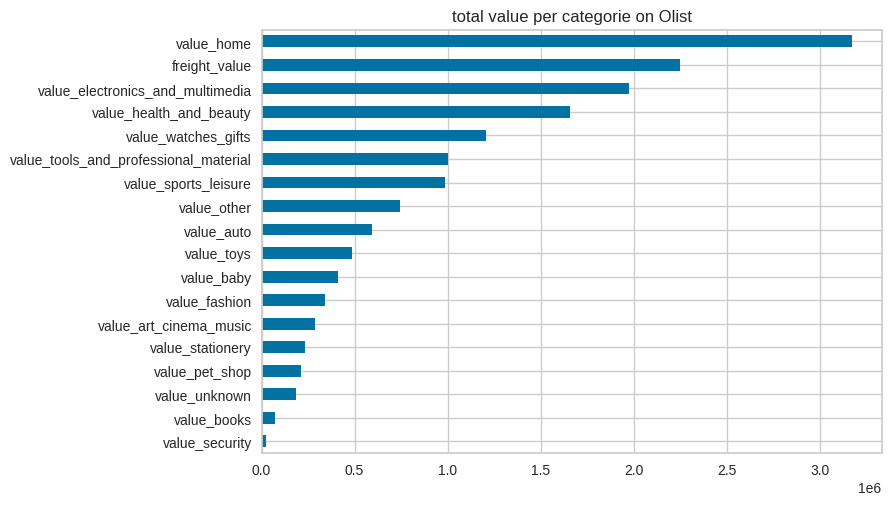

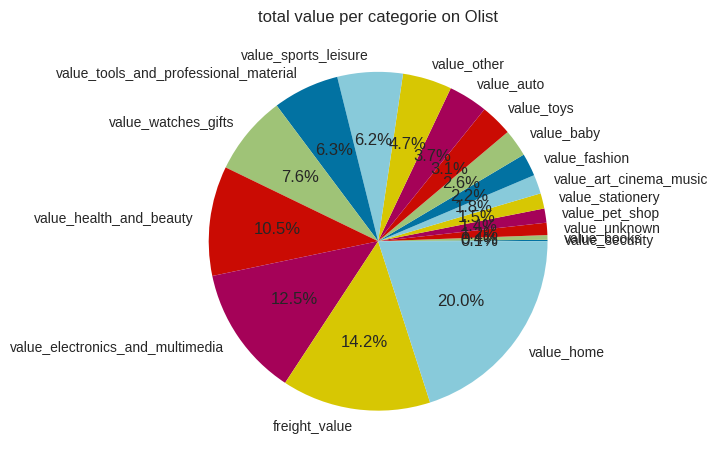

In [189]:
val_per_cat_df = clients.loc[:, ['value_home', 'value_sports_leisure',
       'value_electronics_and_multimedia', 'value_unknown', 'value_toys',
       'value_auto', 'value_tools_and_professional_material',
       'value_health_and_beauty', 'value_pet_shop', 'value_baby',
       'value_watches_gifts', 'value_art_cinema_music', 'value_stationery',
       'value_fashion', 'value_other', 'value_books', 'value_security',
       'freight_value']]

(val_per_cat_df.sum().sort_values()
 .plot(kind='barh', title='total value per categorie on Olist'))
plt.show()

(val_per_cat_df.sum().sort_values()
 .plot(kind='pie', autopct='%.1f%%', 
       title='total value per categorie on Olist'))
plt.show()

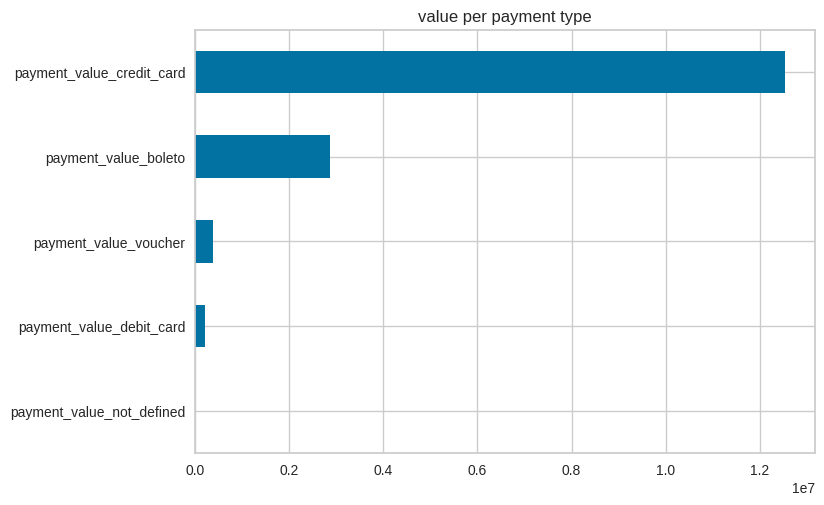

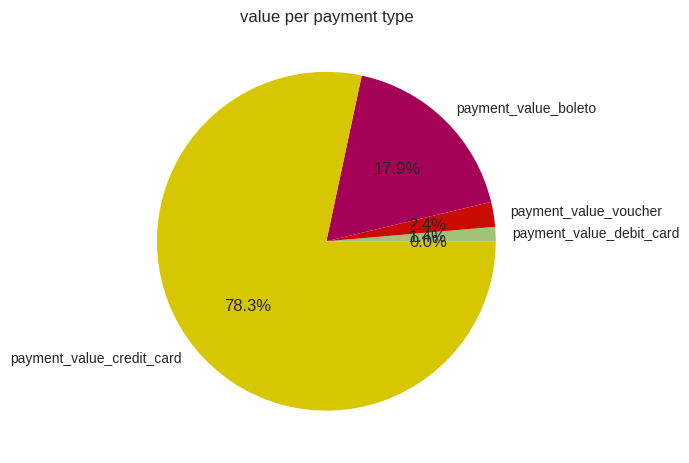

In [188]:
val_per_payment_type_df = clients.loc[:, ['payment_value_credit_card',
              'payment_value_debit_card', 'payment_value_voucher',
              'payment_value_boleto', 'payment_value_not_defined',]]

(val_per_payment_type_df
 .sum()
 .sort_values()
 .plot(kind='barh', title='value per payment type'))
plt.show()

(val_per_payment_type_df
 .sum()
 .sort_values()
 .plot(kind='pie', autopct='%.1f%%', title='value per payment type'))
plt.show()

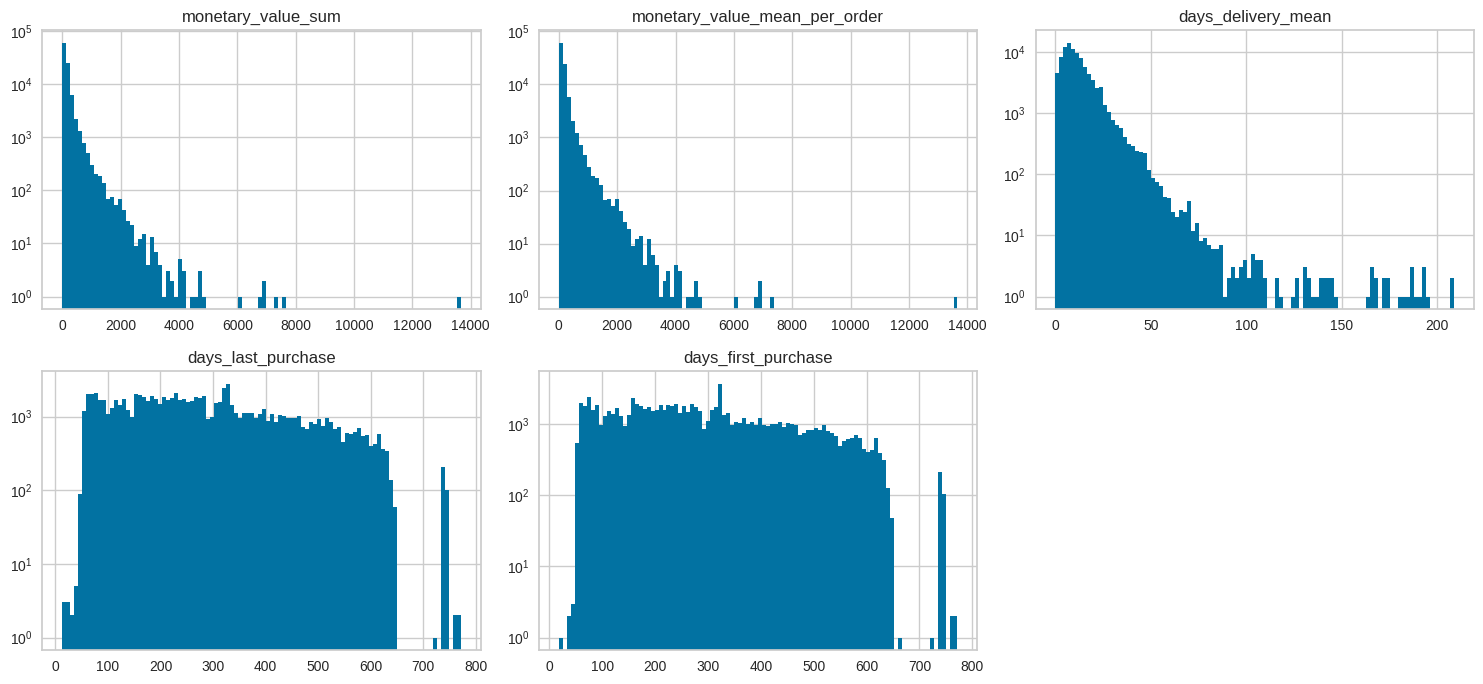

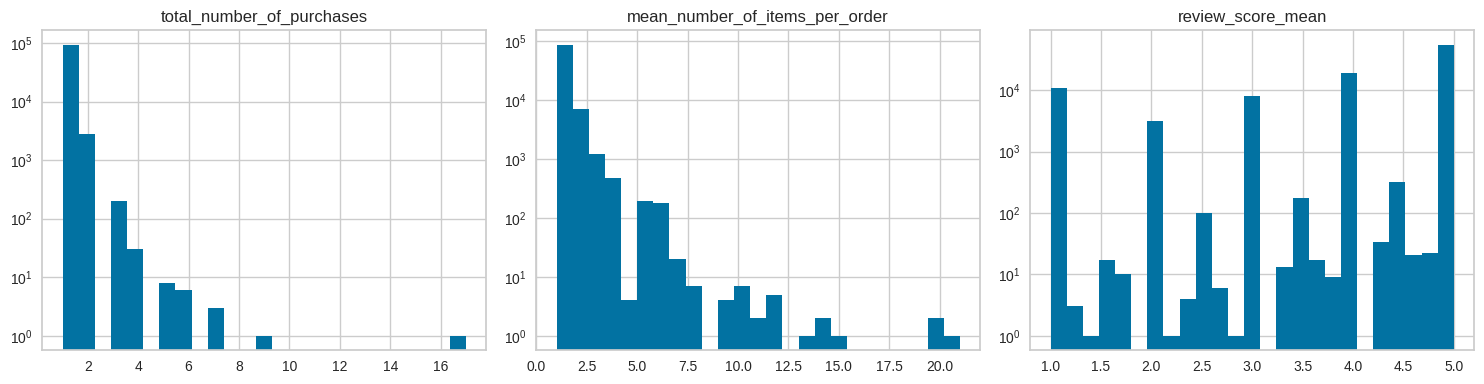

In [182]:
cols_cont = ['monetary_value_sum', 'monetary_value_mean_per_order',
             'days_delivery_mean', 'days_last_purchase',
             'days_first_purchase',]

cols_discrete = ['total_number_of_purchases',
                 'mean_number_of_items_per_order',
                 'review_score_mean',]

clients.loc[:, cols_cont].hist(bins=100, layout=(2,3), figsize=(15,7), log=True)
plt.tight_layout()
plt.show()

clients.loc[:, cols_discrete].hist(bins=25, layout=(1,3), figsize=(15,4), log=True)
plt.tight_layout()
plt.show()

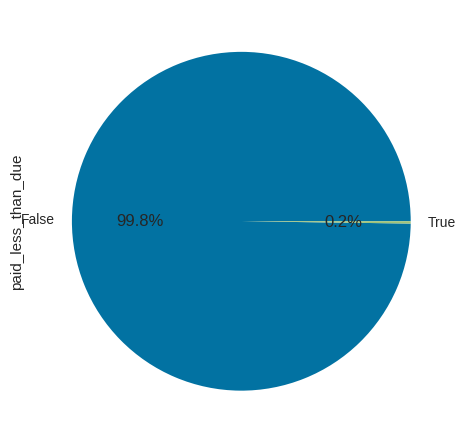

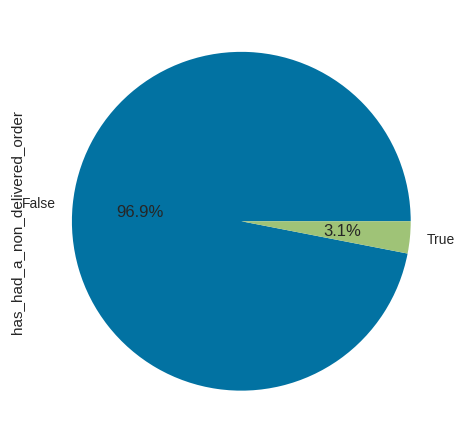

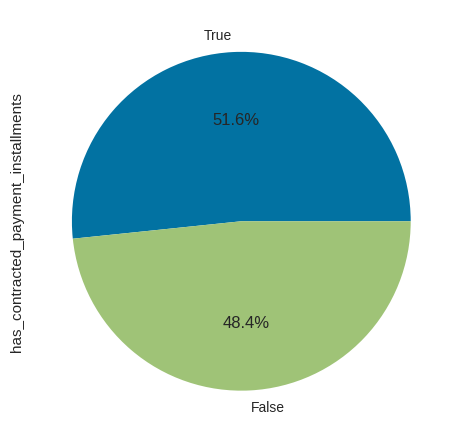

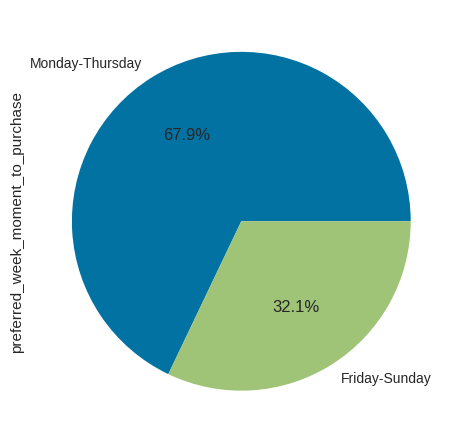

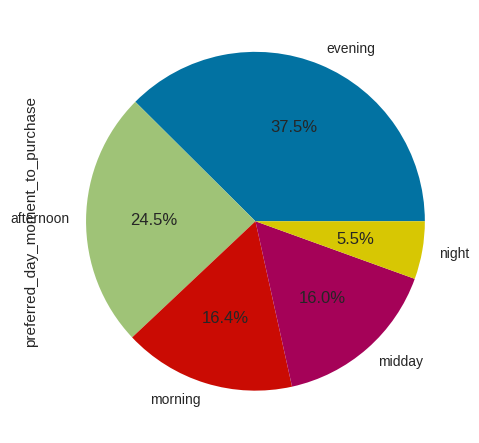

In [186]:
cols_categorical = ['paid_less_than_due', 'has_had_a_non_delivered_order',
                    'has_contracted_payment_installments', 
                    'preferred_week_moment_to_purchase',
                    'preferred_day_moment_to_purchase',]

for col in cols_categorical:
  clients.loc[:, col].value_counts().plot(kind='pie', autopct='%.1f%%')
  plt.show()

In [190]:
clients.loc[:, ['value_ratio_p2_p1', 'n_purchases_ratio_p2_p1',]].describe()

value_ratio_p2_p1  n_purchases_ratio_p2_p1
count            95470.0             96095.000000
mean                 inf                 0.103698
std                  NaN                 0.305855
min                  0.0                 0.000000
25%                  0.0                 0.000000
50%                  0.0                 0.000000
75%                  0.0                 0.000000
max                  inf                 4.000000

<AxesSubplot: >

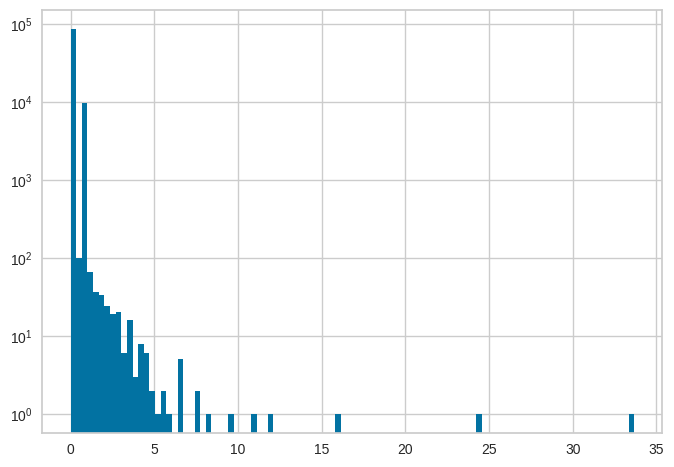

In [194]:
(clients
 .loc[clients.value_ratio_p2_p1 != np.inf, 'value_ratio_p2_p1']
 .hist(bins=100, log=True))

<AxesSubplot: title={'center': 'distribution of the ratios between value spent on the second\nperiod relatively to the value spent during the first period.'}, ylabel='Frequency'>

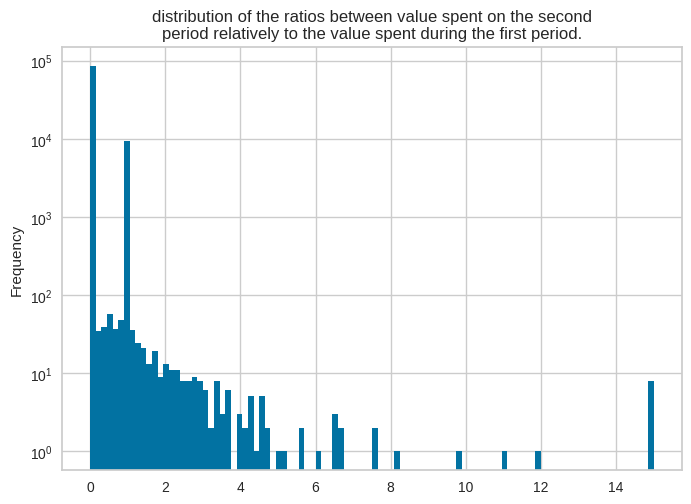

In [199]:
# Cap value at 15
clients.loc[clients.value_ratio_p2_p1 > 15, 'value_ratio_p2_p1'] = 15

(clients
 .value_ratio_p2_p1
 .plot(kind='hist', bins=100, log=True, 
       title='distribution of the ratios between value spent on the second\n'
             'period relatively to the value spent during the first period.'))

<AxesSubplot: title={'center': 'distribution of the ratios between the \nnumber of orders in the secondperiod relatively to  first period.'}, ylabel='Frequency'>

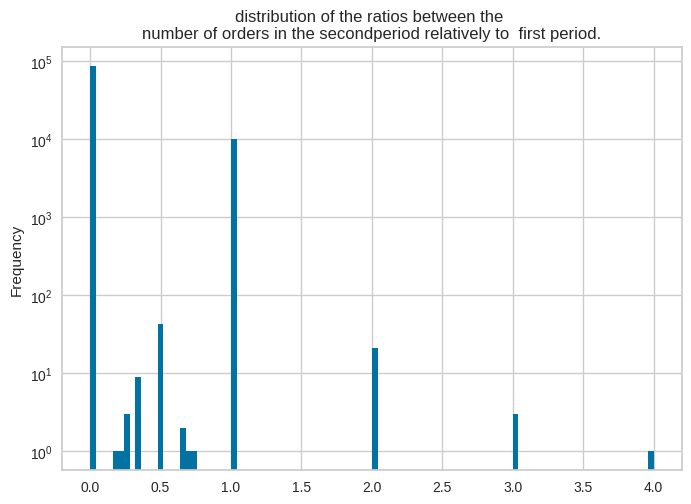

In [200]:
(clients
 .n_purchases_ratio_p2_p1
 .plot(kind='hist', bins=100, log=True, 
       title='distribution of the ratios between the \nnumber of orders in the second'
             'period relatively to  first period.'))

In [201]:
clients.columns

Index(['monetary_value_sum', 'monetary_value_mean_per_order',
       'total_number_of_purchases', 'max_number_of_items_ordered',
       'min_number_of_items_ordered', 'mean_number_of_items_per_order',
       'review_score_mean', 'review_score_min', 'review_score_max',
       'paid_less_than_due', 'has_had_a_non_delivered_order',
       'has_contracted_payment_installments', 'days_delivery_min',
       'days_delivery_max', 'days_delivery_mean',
       'preferred_week_moment_to_purchase', 'preferred_day_moment_to_purchase',
       'value_home', 'value_sports_leisure',
       'value_electronics_and_multimedia', 'value_unknown', 'value_toys',
       'value_auto', 'value_tools_and_professional_material',
       'value_health_and_beauty', 'value_pet_shop', 'value_baby',
       'value_watches_gifts', 'value_art_cinema_music', 'value_stationery',
       'value_fashion', 'value_other', 'value_books', 'value_security',
       'freight_value', 'payment_value_credit_card',
       'payment_value_de

In [209]:
# discovering inf values
ratios_cols = ['ratio_value_sports_leisure', 'ratio_value_electronics_and_multimedia',
       'ratio_value_unknown', 'ratio_value_toys', 'ratio_value_auto',
       'ratio_value_tools_and_professional_material',
       'ratio_value_health_and_beauty', 'ratio_value_pet_shop',
       'ratio_value_baby', 'ratio_value_watches_gifts',
       'ratio_value_art_cinema_music', 'ratio_value_stationery',
       'ratio_value_fashion', 'ratio_value_other', 'ratio_value_books',
       'ratio_value_security', 'ratio_freight_value',
       'ratio_payment_value_credit_card', 'ratio_payment_value_debit_card',
       'ratio_payment_value_voucher', 'ratio_payment_value_boleto',
       'ratio_payment_value_not_defined']

ratios = clients.loc[:, ratios_cols]
ratios.describe()

ratio_value_sports_leisure  ratio_value_electronics_and_multimedia  \
count                95420.000000                            95420.000000   
mean                     0.061883                                0.116349   
std                      0.215252                                0.276201   
min                      0.000000                                0.000000   
25%                      0.000000                                0.000000   
50%                      0.000000                                0.000000   
75%                      0.000000                                0.000000   
max                      0.990096                                0.993473   

       ratio_value_unknown  ratio_value_toys  ratio_value_auto  \
count         95420.000000      95420.000000      95420.000000   
mean              0.011656          0.032055          0.031273   
std               0.096255          0.158862          0.155584   
min               0.000000          0.000000          0.000000   
25%               0.000000          0.000000          0.000000   
50%               0.000000          0.000000          0.000000   
75%               0.000000          0.000000          0.000000   
max               1.000000          0.981273          1.000000   

       ratio_value_tools_and_professional_material  \
count                                 95420.000000   
mean                                      0.048617   
std                                       0.190740   
min                                       0.000000   
25%                                       0.000000   
50%                                       0.000000   
75%                                       0.000000   
max                                       1.000000   

       ratio_value_health_and_beauty  ratio_value_pet_shop  ratio_value_baby  \
count                   95420.000000          95420.000000      95420.000000   
mean                        0.098565              0.013796          0.023374   
std                         0.267524              0.104479          0.135081   
min                         0.000000              0.000000          0.000000   
25%                         0.000000              0.000000          0.000000   
50%                         0.000000              0.000000          0.000000   
75%                         0.000000              0.000000          0.000000   
max                         1.000000              0.981793          0.986232   

       ratio_value_watches_gifts  ratio_value_art_cinema_music  \
count               95420.000000                  95420.000000   
mean                    0.049998                      0.011205   
std                     0.203489                      0.095213   
min                     0.000000                      0.000000   
25%                     0.000000                      0.000000   
50%                     0.000000                      0.000000   
75%                     0.000000                      0.000000   
max                     1.000000                      0.992964   

       ratio_value_stationery  ratio_value_fashion  ratio_value_other  \
count            95420.000000         95420.000000       95420.000000   
mean                 0.018593             0.026787           0.042017   
std                  0.120683             0.143106           0.181059   
min                  0.000000             0.000000           0.000000   
25%                  0.000000             0.000000           0.000000   
50%                  0.000000             0.000000           0.000000   
75%                  0.000000             0.000000           0.000000   
max                  0.979429             0.986875           0.987957   

       ratio_value_books  ratio_value_security  ratio_freight_value  \
count       95420.000000          95420.000000         95420.000000   
mean            0.006466              0.001090             0.207959   
std             0.070850              0.0291

In [210]:
# Addressing inf values
ratios[ratios > 1e30] = np.NaN
clients.loc[:, ratios_cols] = ratios
clients.loc[:, ratios_cols].describe()

ratio_value_sports_leisure  ratio_value_electronics_and_multimedia  \
count                95420.000000                            95420.000000   
mean                     0.061883                                0.116349   
std                      0.215252                                0.276201   
min                      0.000000                                0.000000   
25%                      0.000000                                0.000000   
50%                      0.000000                                0.000000   
75%                      0.000000                                0.000000   
max                      0.990096                                0.993473   

       ratio_value_unknown  ratio_value_toys  ratio_value_auto  \
count         95420.000000      95420.000000      95420.000000   
mean              0.011656          0.032055          0.031273   
std               0.096255          0.158862          0.155584   
min               0.000000          0.000000          0.000000   
25%               0.000000          0.000000          0.000000   
50%               0.000000          0.000000          0.000000   
75%               0.000000          0.000000          0.000000   
max               1.000000          0.981273          1.000000   

       ratio_value_tools_and_professional_material  \
count                                 95420.000000   
mean                                      0.048617   
std                                       0.190740   
min                                       0.000000   
25%                                       0.000000   
50%                                       0.000000   
75%                                       0.000000   
max                                       1.000000   

       ratio_value_health_and_beauty  ratio_value_pet_shop  ratio_value_baby  \
count                   95420.000000          95420.000000      95420.000000   
mean                        0.098565              0.013796          0.023374   
std                         0.267524              0.104479          0.135081   
min                         0.000000              0.000000          0.000000   
25%                         0.000000              0.000000          0.000000   
50%                         0.000000              0.000000          0.000000   
75%                         0.000000              0.000000          0.000000   
max                         1.000000              0.981793          0.986232   

       ratio_value_watches_gifts  ratio_value_art_cinema_music  \
count               95420.000000                  95420.000000   
mean                    0.049998                      0.011205   
std                     0.203489                      0.095213   
min                     0.000000                      0.000000   
25%                     0.000000                      0.000000   
50%                     0.000000                      0.000000   
75%                     0.000000                      0.000000   
max                     1.000000                      0.992964   

       ratio_value_stationery  ratio_value_fashion  ratio_value_other  \
count            95420.000000         95420.000000       95420.000000   
mean                 0.018593             0.026787           0.042017   
std                  0.120683             0.143106           0.181059   
min                  0.000000             0.000000           0.000000   
25%                  0.000000             0.000000           0.000000   
50%                  0.000000             0.000000           0.000000   
75%                  0.000000             0.000000           0.000000   
max                  0.979429             0.986875           0.987957   

       ratio_value_books  ratio_value_security  ratio_freight_value  \
count       95420.000000          95420.000000         95420.000000   
mean            0.006466              0.001090             0.207959   
std             0.070850              0.0291

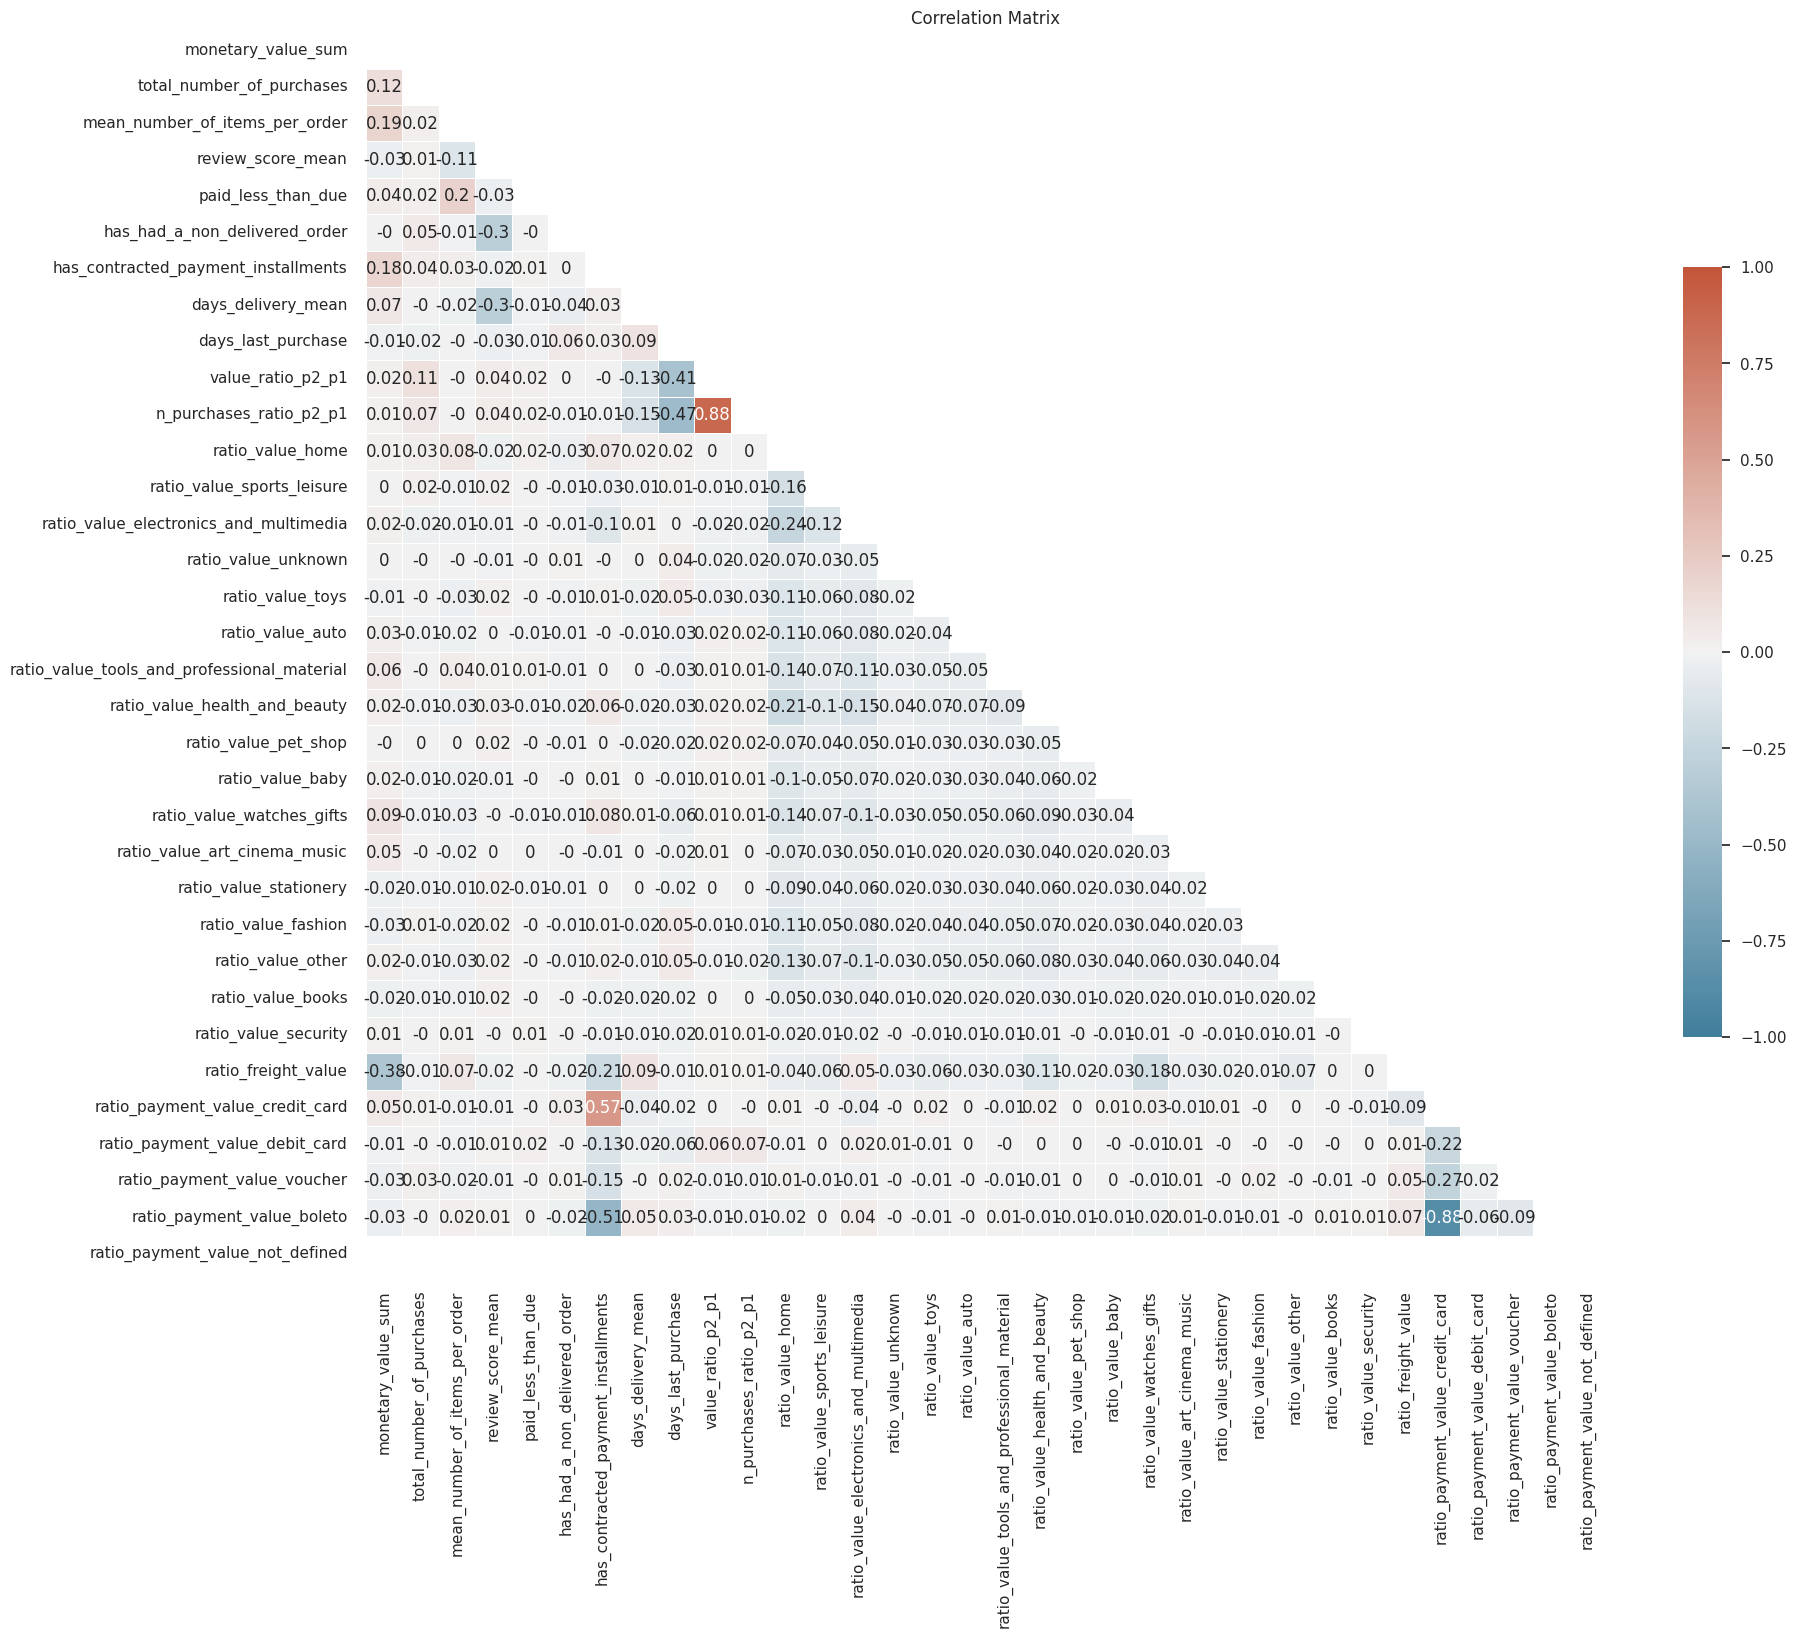

In [216]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

fts = ['monetary_value_sum', 'total_number_of_purchases', 'mean_number_of_items_per_order',
       'review_score_mean', 
       'paid_less_than_due', 'has_had_a_non_delivered_order',
       'has_contracted_payment_installments',
       'days_delivery_mean',
       'days_last_purchase', 'value_ratio_p2_p1', 'n_purchases_ratio_p2_p1', 'ratio_value_home',
       'ratio_value_sports_leisure', 'ratio_value_electronics_and_multimedia',
       'ratio_value_unknown', 'ratio_value_toys', 'ratio_value_auto',
       'ratio_value_tools_and_professional_material',
       'ratio_value_health_and_beauty', 'ratio_value_pet_shop',
       'ratio_value_baby', 'ratio_value_watches_gifts',
       'ratio_value_art_cinema_music', 'ratio_value_stationery',
       'ratio_value_fashion', 'ratio_value_other', 'ratio_value_books',
       'ratio_value_security', 'ratio_freight_value',
       'ratio_payment_value_credit_card', 'ratio_payment_value_debit_card',
       'ratio_payment_value_voucher', 'ratio_payment_value_boleto',
       'ratio_payment_value_not_defined']

ds.display_correlation_matrix(
       pd.DataFrame(
              imputer.fit_transform(clients.loc[:, fts]),
              index=clients.index,
              columns=fts
       ),
       features=fts,
       figsize=(20,20)
)


- The greater the monetary value, the lesser the freight ratio.
- payment_installments are correlated with credit_card users.
- the '2 dynamic ratios' are very correlated. I can use only one of them for the clustering.
- long deliveries and non-delivered orders tend to yield a bad review score. 


In [217]:
clients.to_csv('clients_2_cleaned.csv.gz')

In [219]:
!ls -Flash 

total 77M
 20K drwxrwxr-x 5 louberehc louberehc  20K avril 27 17:31 ./
4,0K drwxrwxr-x 7 louberehc louberehc 4,0K mars  24 16:51 ../
7,0M -rw-rw-r-- 1 louberehc louberehc 7,0M avril 27 17:31 clients_2_cleaned.csv.gz
7,0M -rw-rw-r-- 1 louberehc louberehc 7,0M avril 27 15:19 clients_2.csv.gz
2,8M -rw-rw-r-- 1 louberehc louberehc 2,8M avril  6 14:39 clients.csv.gz
2,9M -rw-rw-r-- 1 louberehc louberehc 2,9M avril 21 10:48 clients_rfm.csv.gz
4,6M -rw-rw-r-- 1 louberehc louberehc 4,6M avril 26 18:56 clients_second_fts_engineering.csv.gz
2,9M -rw-rw-r-- 1 louberehc louberehc 2,9M avril 20 15:35 clients_with_kmeans_and_hc_labels.csv.gz
7,2M -rw-rw-r-- 1 louberehc louberehc 7,2M avril 25 11:10 clustering_models.ipynb
4,0K drwxrwxr-x 2 louberehc louberehc 4,0K mars  29 10:37 csv_files/
 80K -rw-rw-r-- 1 louberehc louberehc  80K mars  29 15:12 data_schema.png
 28K -rw-rw-r-- 1 louberehc louberehc  25K avril 27 17:08 data_science_functions.py
4,0K drwxrwxr-x 8 louberehc louberehc 4,0K avril 17 15: